In [1]:
#@title
import copy
import math
import random
from math import exp

import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

z = []  # [3, 4] (m服务, n服务器) zik
y = []  # [3, 2, 4] (m服务, l基站，n服务器) yijk


def is_feasible(x):
    for j in range(m):
        if np.sum(x[:, j]) == 0:  #至少部署一个
            return False

    for i in range(n):
        sum = 0
        for j in range(m):
            sum += x[i][j] * s[j]
        if sum > c[i]:            #资源不超限制
            return False

    return True

def add_z(i, k, val, x):          #将z整合到变量val
    # [m, n]
    x[i * n + k] += val


def add_y(i, j, k, val, x):       #将y整合到变量val
    # [m, l, n]
    x[n * m + i * l * n + j * n + k] += val


def solve_yz(greedy=False):
    N = (l + 1) * n * m
    A_ub = []
    B_ub = []
    A_eq = []
    B_eq = []

    def eq_1():
        """
        any i,j: sum(y[i][j][k]) = 1
        :return: size=l*n
        """
        vs = []
        b = []
        for j in range(l):
            for k in range(n):
                v = [0] * N
                for i in range(m):
                    add_y(i, j, k, 1, v)
                vs += [v]
                b += [1]

        return vs, b

    def ineq_1():
        """
        any k: sum(z[i][k]) <= f[k]
        :return: size=n
        """
        vs = []
        b = []
        for k in range(n):
            v = [0] * N
            for i in range(m):
                add_z(i, k, 1, v)
            vs += [v]
            b += [f[k] * max(x[k, :])]

        return vs, b
    
    def ineq_2():
        """
        any k: z[i][k] <= x[i][k] * f[k]
        :return: size=n
        """
        vs = []
        b = []
        for k in range(n):
            for i in range(m):
                v = [0] * N
                add_z(i, k, 1, v)
                vs += [v]
                b += [x[k][i] * f[k]]

        return vs, b

    def ineq_3():
        """
        any i,j,k: -y[i][j][k]) <= 0
        :return: size=l*m*n
        """
        vs = []
        b = []
        for i in range(m):
            for k in range(n):
                for j in range(l):
                    v = [0] * N
                    add_y(i, j, k, -1, v)
                    b += [0]
                    vs += [v]

        return vs, b

    def ineq_4():
        """
        any i,j,k: y[i][j][k]) <= x[i][k]
        :return: size=l*m*n
        """
        vs = []
        b = []
        for i in range(m):
            for k in range(n):
                for j in range(l):
                    v = [0] * N
                    add_y(i, j, k, 1, v)
                    b += [x[k][i]]
                    vs += [v]

        return vs, b

    def ineq_5():
        """
        sum_j(y[i][j][k] * la[i][j]) - z[i][k] / r[i] < 0
        :return: n*m
        """
        vs = []
        b = []
        for i in range(m):
            for k in range(n):
                v = [0] * N
                for j in range(l):
                    add_y(i, j, k, la[i][j], v)
                add_z(i, k, -1.0 / r[i], v)
                vs += [v]
                b += [0]

        return vs, b

    def ineq_6():
        """
        if x[k][i] == 1:
        T[j][k] + 1 / (z[i][k] / r[i] - sum_j(y[i][j][k] * la[i][j])) <= d[i] 
        :return: l*m*n
        """
        vs = []
        b = []
        for i in range(m):
            for k in range(n):
                if x[k][i] == 1:
                    for j in range(l):
                        v = [0] * N
                        for o in range(l):
                            add_y(i, o, k, la[i][o] * (d[i] - t[j][k]), v)
                        add_z(i, k, (t[j][k] - d[i]) / r[i], v)
                        vs += [v]
                        b += [-1]

        return vs, b

    def cost():
        v = [0] * N
        for i in range(m):
            for k in range(n):
                add_z(i, k, x[k][i] * Pf[k] / f[k], v)

        return v

    eq_greedy = ineq_1

    if greedy:
        eqs = [eq_1(), eq_greedy()]
        ineqs = [ineq_2(), ineq_3(), ineq_4(), ineq_5(), ineq_6()]
    else:
        eqs = [eq_1()]
        ineqs = [ineq_1(), ineq_2(), ineq_3(), ineq_4(), ineq_5(), ineq_6()]

    for ineq in ineqs:
        A_ub += ineq[0]
        B_ub += ineq[1]

    for eq in eqs:
        A_eq += eq[0]
        B_eq += eq[1]

    res = optimize.linprog(cost(), A_ub=A_ub, b_ub=B_ub, A_eq=A_eq, b_eq=B_eq)
    # calc_duration(x, res)
    return res

def total_cost(x, g):
    z = np.reshape(g.x[:n * m], (m, n))

    cost = 0
    for k in range(n):
        for i in range(m):
            cost += x[k][i] * (Pc[k] * s[i] / c[k] + Pf[k] * z[i][k] / f[k])

    return cost


def guess_x_gibbs(epochs, omega=1e-6, greedy=False):
    global x

    cost_list = []
    best_g = None

    # init X_0
    while True:
        x = np.random.randint(2, size=(n, m))
        if is_feasible(x):
          g = solve_yz(greedy)
          if g.success:
              best_g = g
              break
          #else:
            #print("no success g!")
        #else:
          #print("no feasible x!")

    print("[INIT]\t\t: cost=%s" % (total_cost(x, g)))

    for i in range(epochs):
        choice_idx = random.randint(0, n - 1)
        old_x = copy.deepcopy(x)
        x[choice_idx, :] = np.random.randint(2, size=m)
        new_g = solve_yz(greedy)

        if new_g.success and is_feasible(x):
            old_cost = total_cost(old_x, g)
            new_cost = total_cost(x, new_g)
            delta = new_cost - old_cost
            trans_prob = 1.0 / (1.0 + np.exp(1.0 * delta / omega))

            if random.random() <= trans_prob:
                print("[%3d][CHANGE]\t: new_cost=%s, old_cost=%s, prob=%s -- %s" % (i, new_cost, old_cost, trans_prob, new_cost))
                g = new_g
                best_g = g
            else:
                print("[%3d][KEEP]\t\t: new_cost=%s, old_cost=%s, prob=%s -- %s" % (i, new_cost, old_cost, trans_prob, old_cost))
                x = old_x
        else:
            print("[%3d][SKIP]\t\t: %s" % (i, new_g.success))
            x = old_x

        cost_list.append(total_cost(x, g))

    return cost_list #, resource_usage_rate(best_g)


def guess_x_random(nums, greedy=False):
    global x

    best_g = None 
    
    # init X_0
    while True:
        x = np.random.randint(2, size=(n, m))
        if is_feasible(x):
          g = solve_yz(greedy)
          if g.success:
              best_g = g
              break
          else:
            print("no success g!")
        else:
          print("not feasible x!")

    print("INIT x = %s" % x)
    min_cost = total_cost(x, g)
    cost_list = []

    for i in range(nums):
        x = np.random.randint(2, size=(n, m))
        g = solve_yz(greedy)
        if g.success and is_feasible(x):
            cur_cost = total_cost(x, g)
            if cur_cost < min_cost:
                min_cost = cur_cost
                best_g = g

        cost_list.append(min_cost)
        print("[%3d]: %s --- %s" % (i, g.fun, min_cost))

    return cost_list

In [2]:
n = 10 #server 5,4,1
m = 5 #service
s = np.array([10, 5, 15, 20, 25])
c = np.array([50, 70, 60, 65, 55, 130, 100, 160, 140, 200])
Pc = np.array([25, 30, 30, 32, 22, 33, 29, 38, 35, 40])
f = np.array([50, 55, 80, 53, 60, 75, 125, 130, 100, 150])
Pf = np.array([24, 22, 28, 25, 30, 39, 40, 50, 34, 48])
d = np.array([0.045, 0.02, 0.035, 0.038, 0.04])
r = np.array([0.3, 0.15, 0.2, 0.25, 0.14])
l = 5 #base station
t = np.array([[0.005,0.006,0.001,0.004,0.005, 0.011,0.013,0.010,0.012, 0.015],
        [0.001,0.002,0.005,0.005,0.004, 0.010,0.010,0.014,0.013, 0.015],
        [0.003,0.004,0.006,0.001,0.002, 0.013,0.010,0.011,0.013, 0.015],
        [0.006,0.001,0.003,0.004,0.005, 0.011,0.014,0.012,0.010, 0.015],
        [0.002,0.003,0.004,0.005,0.001, 0.012,0.013,0.010,0.010, 0.015]]) #l * n
la = np.array([[50,59,70,69,57],[69,50,50,60,57],[69,50,56,61,70],[70,59,63,54,60],[56,62,57,60,50]]) # m * l


total_iters = 2000
result_gibbs_greedy1 = guess_x_gibbs(total_iters, 1e-6, greedy=True)
result_gibbs_ondemand1 = guess_x_gibbs(total_iters, 1e-6, greedy=False)
result_random_ondemand1 = guess_x_random(total_iters, greedy=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.


[INIT]		: cost=442.59476269612895
[  0][SKIP]		: False
[  1][KEEP]		: new_cost=446.15726962843837, old_cost=442.59476269612895, prob=0.0 -- 442.59476269612895


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:241: RuntimeWarning: overflow encountered in exp


[  2][KEEP]		: new_cost=442.59476269612895, old_cost=442.59476269612895, prob=0.5 -- 442.59476269612895
[  3][KEEP]		: new_cost=443.5947525219255, old_cost=442.59476269612895, prob=0.0 -- 442.59476269612895
[  4][CHANGE]	: new_cost=436.6572801804256, old_cost=442.59476269612895, prob=1.0 -- 436.6572801804256
[  5][KEEP]		: new_cost=450.618805490364, old_cost=436.6572801804256, prob=0.0 -- 436.6572801804256
[  6][SKIP]		: False
[  7][SKIP]		: False
[  8][SKIP]		: False
[  9][SKIP]		: False
[ 10][KEEP]		: new_cost=446.65725060201447, old_cost=436.6572801804256, prob=0.0 -- 436.6572801804256
[ 11][KEEP]		: new_cost=446.65725060201447, old_cost=436.6572801804256, prob=0.0 -- 436.6572801804256
[ 12][SKIP]		: False
[ 13][KEEP]		: new_cost=438.10728018659336, old_cost=436.6572801804256, prob=0.0 -- 436.6572801804256
[ 14][KEEP]		: new_cost=437.90728018900126, old_cost=436.6572801804256, prob=0.0 -- 436.6572801804256
[ 15][KEEP]		: new_cost=441.0072801805109, old_cost=436.6572801804256, prob=0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting

[ 16][KEEP]		: new_cost=449.1572802135677, old_cost=436.6572801804256, prob=0.0 -- 436.6572801804256
[ 17][SKIP]		: False
[ 18][SKIP]		: False
[ 19][KEEP]		: new_cost=448.0803446811417, old_cost=436.6572801804256, prob=0.0 -- 436.6572801804256
[ 20][CHANGE]	: new_cost=432.3072801804663, old_cost=436.6572801804256, prob=1.0 -- 432.3072801804663
[ 21][SKIP]		: False
[ 22][KEEP]		: new_cost=438.5572801821801, old_cost=432.3072801804663, prob=0.0 -- 432.3072801804663
[ 23][SKIP]		: False
[ 24][KEEP]		: new_cost=436.30728018872304, old_cost=432.3072801804663, prob=0.0 -- 432.3072801804663
[ 25][SKIP]		: False
[ 26][KEEP]		: new_cost=436.30728018872304, old_cost=432.3072801804663, prob=0.0 -- 432.3072801804663
[ 27][KEEP]		: new_cost=438.6534273505828, old_cost=432.3072801804663, prob=0.0 -- 432.3072801804663
[ 28][KEEP]		: new_cost=449.8072802160589, old_cost=432.3072801804663, prob=0.0 -- 432.3072801804663
[ 29][KEEP]		: new_cost=432.30728017342983, old_cost=432.3072801804663, prob=0.50175

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.51125e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[ 69][KEEP]		: new_cost=422.55728020724024, old_cost=410.0572802092007, prob=0.0 -- 410.0572802092007
[ 70][KEEP]		: new_cost=416.3072540975951, old_cost=410.0572802092007, prob=0.0 -- 410.0572802092007
[ 71][CHANGE]	: new_cost=407.05728021327093, old_cost=410.0572802092007, prob=1.0 -- 407.05728021327093
[ 72][KEEP]		: new_cost=415.9418954105559, old_cost=407.05728021327093, prob=0.0 -- 407.05728021327093
[ 73][KEEP]		: new_cost=415.75728021104885, old_cost=407.05728021327093, prob=0.0 -- 407.05728021327093
[ 74][SKIP]		: False
[ 75][SKIP]		: False
[ 76][SKIP]		: False
[ 77][KEEP]		: new_cost=419.55728020504284, old_cost=407.05728021327093, prob=0.0 -- 407.05728021327093
[ 78][KEEP]		: new_cost=412.0572802183067, old_cost=407.05728021327093, prob=0.0 -- 407.05728021327093
[ 79][SKIP]		: True
[ 80][SKIP]		: False
[ 81][SKIP]		: False
[ 82][KEEP]		: new_cost=427.05727078753876, old_cost=407.05728021327093, prob=0.0 -- 407.05728021327093
[ 83][SKIP]		: False
[ 84][KEEP]		: new_cost=415.8

[208][SKIP]		: False
[209][KEEP]		: new_cost=398.4072797682375, old_cost=395.9072800487732, prob=0.0 -- 395.9072800487732
[210][SKIP]		: True
[211][KEEP]		: new_cost=404.79189133745484, old_cost=395.9072800487732, prob=0.0 -- 395.9072800487732
[212][SKIP]		: False
[213][SKIP]		: False
[214][KEEP]		: new_cost=401.9072783776127, old_cost=395.9072800487732, prob=0.0 -- 395.9072800487732
[215][SKIP]		: False
[216][SKIP]		: False
[217][KEEP]		: new_cost=403.0322798794135, old_cost=395.9072800487732, prob=0.0 -- 395.9072800487732
[218][SKIP]		: False
[219][SKIP]		: False
[220][KEEP]		: new_cost=403.5226647901237, old_cost=395.9072800487732, prob=0.0 -- 395.9072800487732
[221][SKIP]		: False
[222][KEEP]		: new_cost=404.21977997155375, old_cost=395.9072800487732, prob=0.0 -- 395.9072800487732
[223][SKIP]		: False
[224][SKIP]		: True
[225][KEEP]		: new_cost=406.59477159114664, old_cost=395.9072800487732, prob=0.0 -- 395.9072800487732
[226][KEEP]		: new_cost=404.47870861768206, old_cost=395.9072

[339][KEEP]		: new_cost=389.6495879095874, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[340][KEEP]		: new_cost=397.1495875325437, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[341][KEEP]		: new_cost=387.1495712407471, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[342][SKIP]		: False
[343][KEEP]		: new_cost=384.6495878364733, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[344][SKIP]		: True
[345][KEEP]		: new_cost=382.14958406231705, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[346][KEEP]		: new_cost=386.7745875487529, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[347][SKIP]		: False
[348][KEEP]		: new_cost=380.6495865068759, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[349][KEEP]		: new_cost=384.6495878364733, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[350][SKIP]		: False
[351][SKIP]		: False
[352][KEEP]		: new_cost=383.3995752467282, old_cost=379.6495800555711, prob=0.0 -- 379.

[470][SKIP]		: True
[471][SKIP]		: True
[472][SKIP]		: True
[473][SKIP]		: False
[474][KEEP]		: new_cost=383.2120837235001, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[475][KEEP]		: new_cost=392.14958711413476, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[476][SKIP]		: False
[477][SKIP]		: False
[478][SKIP]		: True
[479][KEEP]		: new_cost=392.50673035170786, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[480][SKIP]		: True
[481][SKIP]		: True
[482][KEEP]		: new_cost=383.212087903308, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[483][SKIP]		: False
[484][SKIP]		: True
[485][KEEP]		: new_cost=395.89958626129936, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[486][KEEP]		: new_cost=388.3495868375965, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[487][SKIP]		: False
[488][SKIP]		: True
[489][KEEP]		: new_cost=384.6495879052849, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[490][SKIP]		: True
[491][

[618][SKIP]		: False
[619][SKIP]		: False
[620][KEEP]		: new_cost=387.9620758449677, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[621][SKIP]		: False
[622][KEEP]		: new_cost=389.64957557047757, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[623][SKIP]		: False
[624][KEEP]		: new_cost=397.1495875325437, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[625][KEEP]		: new_cost=389.1495652156234, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[626][SKIP]		: False
[627][KEEP]		: new_cost=388.6495878817671, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[628][SKIP]		: False
[629][SKIP]		: True
[630][SKIP]		: True
[631][KEEP]		: new_cost=391.95727992489225, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[632][KEEP]		: new_cost=385.64958627446356, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[633][SKIP]		: False
[634][KEEP]		: new_cost=385.899581542506, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[63

[759][SKIP]		: False
[760][SKIP]		: True
[761][SKIP]		: False
[762][KEEP]		: new_cost=382.5495627355895, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[763][KEEP]		: new_cost=383.6495878968319, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[764][KEEP]		: new_cost=382.024583005204, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[765][KEEP]		: new_cost=391.52458635049675, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[766][SKIP]		: True
[767][KEEP]		: new_cost=397.1495874592008, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[768][KEEP]		: new_cost=388.39958768453454, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[769][KEEP]		: new_cost=389.7995878861976, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[770][SKIP]		: False
[771][SKIP]		: False
[772][SKIP]		: True
[773][SKIP]		: False
[774][SKIP]		: False
[775][KEEP]		: new_cost=386.64958792019837, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[776

[893][SKIP]		: False
[894][SKIP]		: False
[895][SKIP]		: False
[896][SKIP]		: False
[897][KEEP]		: new_cost=389.6495833727303, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[898][SKIP]		: False
[899][KEEP]		: new_cost=386.77455268233876, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[900][SKIP]		: False
[901][SKIP]		: False
[902][SKIP]		: False
[903][KEEP]		: new_cost=382.64958596921934, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[904][KEEP]		: new_cost=381.64958790820924, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[905][KEEP]		: new_cost=385.58708784458145, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[906][KEEP]		: new_cost=390.64958647435424, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[907][KEEP]		: new_cost=402.1495239524728, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[908][SKIP]		: True
[909][KEEP]		: new_cost=384.39958788220906, old_cost=379.6495800555711, prob=0.0 -- 379.649580055571

[1033][KEEP]		: new_cost=399.3418953986008, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1034][SKIP]		: True
[1035][SKIP]		: False
[1036][KEEP]		: new_cost=391.07266406273504, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1037][SKIP]		: True
[1038][KEEP]		: new_cost=397.64958782493534, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1039][KEEP]		: new_cost=394.64958689976834, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1040][KEEP]		: new_cost=391.6495339483922, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1041][SKIP]		: False
[1042][SKIP]		: False
[1043][SKIP]		: False
[1044][SKIP]		: False
[1045][KEEP]		: new_cost=396.8803373200136, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1046][SKIP]		: True
[1047][KEEP]		: new_cost=388.3995756401725, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1048][KEEP]		: new_cost=384.6495845029284, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1049][S

[1166][KEEP]		: new_cost=390.36387352361095, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1167][KEEP]		: new_cost=387.264972465298, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1168][SKIP]		: False
[1169][SKIP]		: True
[1170][SKIP]		: False
[1171][SKIP]		: False
[1172][SKIP]		: True
[1173][KEEP]		: new_cost=399.3418953986008, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1174][KEEP]		: new_cost=383.99957826008705, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1175][SKIP]		: False
[1176][KEEP]		: new_cost=379.6495800555711, old_cost=379.6495800555711, prob=0.5 -- 379.6495800555711
[1177][SKIP]		: False
[1178][SKIP]		: False
[1179][KEEP]		: new_cost=392.6495812763256, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1180][SKIP]		: False
[1181][KEEP]		: new_cost=395.89958626129936, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1182][KEEP]		: new_cost=383.9995879243714, old_cost=379.6495800555711, prob=0.0 -- 379.

[1306][SKIP]		: False
[1307][SKIP]		: False
[1308][SKIP]		: False
[1309][SKIP]		: False
[1310][SKIP]		: False
[1311][KEEP]		: new_cost=380.9188173513003, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1312][SKIP]		: False
[1313][SKIP]		: False
[1314][KEEP]		: new_cost=399.64958765961467, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1315][KEEP]		: new_cost=390.64958647435424, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1316][KEEP]		: new_cost=391.95727992489225, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1317][KEEP]		: new_cost=381.0995714321992, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1318][KEEP]		: new_cost=387.64958522098175, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1319][SKIP]		: False
[1320][KEEP]		: new_cost=394.6495628880969, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1321][SKIP]		: False
[1322][SKIP]		: True
[1323][KEEP]		: new_cost=384.39954168046523, old_cost=379.64958

[1440][SKIP]		: False
[1441][KEEP]		: new_cost=388.3995756401725, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1442][SKIP]		: True
[1443][SKIP]		: False
[1444][SKIP]		: True
[1445][CHANGE]	: new_cost=379.6495800555711, old_cost=379.6495800555711, prob=0.5 -- 379.6495800555711
[1446][KEEP]		: new_cost=388.34954646915133, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1447][SKIP]		: False
[1448][SKIP]		: False
[1449][KEEP]		: new_cost=385.99567606629154, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1450][SKIP]		: False
[1451][SKIP]		: False
[1452][SKIP]		: False
[1453][KEEP]		: new_cost=379.6495800555711, old_cost=379.6495800555711, prob=0.5 -- 379.6495800555711
[1454][SKIP]		: False
[1455][SKIP]		: False
[1456][SKIP]		: False
[1457][KEEP]		: new_cost=388.3995756401725, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1458][SKIP]		: False
[1459][SKIP]		: False
[1460][SKIP]		: False
[1461][KEEP]		: new_cost=382.14958406231705, old_cost=379

[1588][SKIP]		: False
[1589][SKIP]		: False
[1590][SKIP]		: True
[1591][KEEP]		: new_cost=396.8803373200136, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1592][KEEP]		: new_cost=389.1495652156234, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1593][SKIP]		: False
[1594][KEEP]		: new_cost=382.02458790243816, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1595][SKIP]		: True
[1596][KEEP]		: new_cost=379.6495800555711, old_cost=379.6495800555711, prob=0.5 -- 379.6495800555711
[1597][KEEP]		: new_cost=385.649585054069, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1598][SKIP]		: False
[1599][SKIP]		: False
[1600][SKIP]		: False
[1601][SKIP]		: False
[1602][KEEP]		: new_cost=387.1495875292772, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1603][KEEP]		: new_cost=396.8803373200136, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1604][SKIP]		: False
[1605][KEEP]		: new_cost=379.6495800555711, old_cost=379.64958005557

[1736][KEEP]		: new_cost=389.7995878861976, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1737][SKIP]		: False
[1738][KEEP]		: new_cost=385.649585054069, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1739][SKIP]		: False
[1740][KEEP]		: new_cost=383.64958442050494, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1741][KEEP]		: new_cost=393.8995876610756, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1742][SKIP]		: False
[1743][SKIP]		: False
[1744][SKIP]		: False
[1745][KEEP]		: new_cost=383.3995833691258, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1746][KEEP]		: new_cost=386.77455268233876, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1747][KEEP]		: new_cost=389.64957991499915, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1748][KEEP]		: new_cost=390.8995810307106, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1749][SKIP]		: True
[1750][KEEP]		: new_cost=389.1495878933964, old_cos

[1874][SKIP]		: False
[1875][SKIP]		: False
[1876][SKIP]		: False
[1877][KEEP]		: new_cost=399.64958765961467, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1878][SKIP]		: True
[1879][SKIP]		: False
[1880][SKIP]		: False
[1881][KEEP]		: new_cost=395.89958626129936, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1882][SKIP]		: False
[1883][SKIP]		: True
[1884][SKIP]		: False
[1885][KEEP]		: new_cost=385.899581542506, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1886][KEEP]		: new_cost=388.64958528064193, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1887][SKIP]		: True
[1888][SKIP]		: False
[1889][SKIP]		: False
[1890][SKIP]		: False
[1891][SKIP]		: False
[1892][KEEP]		: new_cost=390.64958792500437, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1893][KEEP]		: new_cost=387.6495817520073, old_cost=379.6495800555711, prob=0.0 -- 379.6495800555711
[1894][KEEP]		: new_cost=382.649587873956, old_cost=379.6495800555711, prob=0.0 

[  2][SKIP]		: False
[  3][SKIP]		: False
[  4][SKIP]		: False
[  5][SKIP]		: False
[  6][CHANGE]	: new_cost=355.78656004690816, old_cost=360.34366743583075, prob=1.0 -- 355.78656004690816
[  7][CHANGE]	: new_cost=348.2842991705481, old_cost=355.78656004690816, prob=1.0 -- 348.2842991705481
[  8][KEEP]		: new_cost=351.14776529403997, old_cost=348.2842991705481, prob=0.0 -- 348.2842991705481
[  9][KEEP]		: new_cost=353.0523036352056, old_cost=348.2842991705481, prob=0.0 -- 348.2842991705481
[ 10][KEEP]		: new_cost=358.93886461221604, old_cost=348.2842991705481, prob=0.0 -- 348.2842991705481
[ 11][KEEP]		: new_cost=357.6176325035903, old_cost=348.2842991705481, prob=0.0 -- 348.2842991705481
[ 12][KEEP]		: new_cost=352.8414444069672, old_cost=348.2842991705481, prob=0.0 -- 348.2842991705481
[ 13][KEEP]		: new_cost=357.0967086135932, old_cost=348.2842991705481, prob=0.0 -- 348.2842991705481
[ 14][SKIP]		: False
[ 15][CHANGE]	: new_cost=329.32194990392213, old_cost=348.2842991705481, prob=1

[130][SKIP]		: False
[131][SKIP]		: False
[132][SKIP]		: True
[133][SKIP]		: False
[134][CHANGE]	: new_cost=285.9619690410273, old_cost=287.50472023843815, prob=1.0 -- 285.9619690410273
[135][KEEP]		: new_cost=302.1299955223491, old_cost=285.9619690410273, prob=0.0 -- 285.9619690410273
[136][KEEP]		: new_cost=291.95874295563124, old_cost=285.9619690410273, prob=0.0 -- 285.9619690410273
[137][SKIP]		: True
[138][SKIP]		: True
[139][SKIP]		: False
[140][SKIP]		: False
[141][KEEP]		: new_cost=290.8916066456629, old_cost=285.9619690410273, prob=0.0 -- 285.9619690410273
[142][KEEP]		: new_cost=298.3602297620141, old_cost=285.9619690410273, prob=0.0 -- 285.9619690410273
[143][SKIP]		: True
[144][KEEP]		: new_cost=293.37543197119, old_cost=285.9619690410273, prob=0.0 -- 285.9619690410273
[145][KEEP]		: new_cost=292.6031456235173, old_cost=285.9619690410273, prob=0.0 -- 285.9619690410273
[146][KEEP]		: new_cost=315.2513133385532, old_cost=285.9619690410273, prob=0.0 -- 285.9619690410273
[147][

[262][KEEP]		: new_cost=299.4126581534, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[263][SKIP]		: False
[264][SKIP]		: True
[265][SKIP]		: False
[266][SKIP]		: True
[267][KEEP]		: new_cost=277.87490265091856, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[268][KEEP]		: new_cost=294.2126583068705, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[269][KEEP]		: new_cost=300.806080535708, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[270][KEEP]		: new_cost=284.1438581293363, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[271][SKIP]		: False
[272][SKIP]		: True
[273][KEEP]		: new_cost=285.3855972252675, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[274][SKIP]		: False
[275][KEEP]		: new_cost=296.67158168603675, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[276][KEEP]		: new_cost=290.4680814306675, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[277][KEEP]		: new_cost=279.59893056237695, old_co

[400][SKIP]		: False
[401][KEEP]		: new_cost=293.26876533725425, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[402][SKIP]		: False
[403][KEEP]		: new_cost=279.00056226459606, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[404][SKIP]		: False
[405][SKIP]		: False
[406][KEEP]		: new_cost=280.9629428086587, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[407][KEEP]		: new_cost=280.05637511841223, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[408][KEEP]		: new_cost=293.6778236044142, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[409][SKIP]		: True
[410][SKIP]		: False
[411][KEEP]		: new_cost=276.53554334861826, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[412][SKIP]		: False
[413][KEEP]		: new_cost=288.91185936824724, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[414][SKIP]		: False
[415][KEEP]		: new_cost=297.5334563859526, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[416][KEEP]		: new_c

[533][KEEP]		: new_cost=287.91185861724415, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[534][SKIP]		: False
[535][KEEP]		: new_cost=280.53439031810905, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[536][KEEP]		: new_cost=287.5382483365001, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[537][KEEP]		: new_cost=281.88959724058594, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[538][SKIP]		: False
[539][KEEP]		: new_cost=276.6895972251456, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[540][SKIP]		: False
[541][SKIP]		: False
[542][KEEP]		: new_cost=275.5724759100615, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[543][KEEP]		: new_cost=276.0664680354527, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[544][SKIP]		: False
[545][SKIP]		: True
[546][KEEP]		: new_cost=280.63002059344007, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[547][KEEP]		: new_cost=280.9629428086587, old_cost=270.4655972

[676][KEEP]		: new_cost=293.26876533725425, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[677][KEEP]		: new_cost=288.91185936824724, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[678][KEEP]		: new_cost=289.18970476729413, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[679][SKIP]		: False
[680][SKIP]		: False
[681][KEEP]		: new_cost=282.01448522593796, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[682][SKIP]		: True
[683][SKIP]		: True
[684][SKIP]		: False
[685][KEEP]		: new_cost=277.69110087296576, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[686][CHANGE]	: new_cost=270.4655972226757, old_cost=270.4655972226757, prob=0.5 -- 270.4655972226757
[687][KEEP]		: new_cost=277.9438581819882, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[688][SKIP]		: False
[689][SKIP]		: False
[690][SKIP]		: False
[691][SKIP]		: False
[692][SKIP]		: False
[693][KEEP]		: new_cost=284.16785811865327, old_cost=270.4655972226757, prob=0.

[815][KEEP]		: new_cost=283.29663425818245, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[816][KEEP]		: new_cost=300.806080535708, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[817][KEEP]		: new_cost=290.62304385184024, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[818][KEEP]		: new_cost=286.7343972144514, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[819][KEEP]		: new_cost=281.88959724058594, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[820][SKIP]		: True
[821][SKIP]		: False
[822][KEEP]		: new_cost=300.38187783689904, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[823][SKIP]		: False
[824][CHANGE]	: new_cost=270.4655972226757, old_cost=270.4655972226757, prob=0.5 -- 270.4655972226757
[825][KEEP]		: new_cost=278.15790494913585, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[826][KEEP]		: new_cost=275.3952349857299, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[827][SKIP]		: False
[82

[953][KEEP]		: new_cost=296.690946860933, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[954][KEEP]		: new_cost=282.4619688947118, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[955][KEEP]		: new_cost=280.1355972175315, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[956][KEEP]		: new_cost=275.5724759100615, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[957][KEEP]		: new_cost=288.0126580856439, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[958][CHANGE]	: new_cost=270.4655972226757, old_cost=270.4655972226757, prob=0.5 -- 270.4655972226757
[959][SKIP]		: False
[960][KEEP]		: new_cost=282.22304344173426, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[961][SKIP]		: False
[962][SKIP]		: False
[963][KEEP]		: new_cost=275.19837033581734, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[964][SKIP]		: True
[965][KEEP]		: new_cost=296.690946860933, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[966][K

[1089][SKIP]		: False
[1090][SKIP]		: True
[1091][SKIP]		: False
[1092][KEEP]		: new_cost=291.93439748748204, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1093][SKIP]		: False
[1094][SKIP]		: False
[1095][SKIP]		: False
[1096][KEEP]		: new_cost=289.841148724276, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1097][KEEP]		: new_cost=274.0596037546801, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1098][SKIP]		: False
[1099][KEEP]		: new_cost=283.1929311595138, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1100][KEEP]		: new_cost=285.3855972252675, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1101][KEEP]		: new_cost=277.87490265091856, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1102][SKIP]		: False
[1103][KEEP]		: new_cost=291.3940063018842, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1104][SKIP]		: False
[1105][SKIP]		: False
[1106][SKIP]		: False
[1107][KEEP]		: new_cost=296.67158168603675,

[1223][SKIP]		: False
[1224][SKIP]		: False
[1225][SKIP]		: False
[1226][SKIP]		: False
[1227][SKIP]		: True
[1228][SKIP]		: False
[1229][SKIP]		: False
[1230][SKIP]		: True
[1231][SKIP]		: False
[1232][KEEP]		: new_cost=282.9940066294566, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1233][SKIP]		: True
[1234][KEEP]		: new_cost=286.4140237858714, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1235][SKIP]		: False
[1236][SKIP]		: True
[1237][KEEP]		: new_cost=277.69584864030077, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1238][KEEP]		: new_cost=292.93675763279657, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1239][SKIP]		: True
[1240][CHANGE]	: new_cost=270.4655972226757, old_cost=270.4655972226757, prob=0.5 -- 270.4655972226757
[1241][SKIP]		: False
[1242][SKIP]		: True
[1243][KEEP]		: new_cost=278.865597232971, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1244][SKIP]		: False
[1245][KEEP]		: new_cost=288.01265808564

[1367][KEEP]		: new_cost=280.74252032535526, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1368][SKIP]		: False
[1369][SKIP]		: False
[1370][SKIP]		: True
[1371][KEEP]		: new_cost=290.9653205861821, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1372][SKIP]		: True
[1373][SKIP]		: False
[1374][SKIP]		: False
[1375][KEEP]		: new_cost=296.67158168603675, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1376][KEEP]		: new_cost=274.0596037546801, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1377][SKIP]		: False
[1378][SKIP]		: False
[1379][SKIP]		: False
[1380][KEEP]		: new_cost=282.77577371183673, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1381][KEEP]		: new_cost=280.9629428086587, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1382][SKIP]		: False
[1383][KEEP]		: new_cost=281.88959724058594, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1384][SKIP]		: False
[1385][KEEP]		: new_cost=287.8856002716338

[1516][KEEP]		: new_cost=294.7128757286221, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1517][CHANGE]	: new_cost=270.4655972226757, old_cost=270.4655972226757, prob=0.5 -- 270.4655972226757
[1518][KEEP]		: new_cost=287.26385811347006, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1519][KEEP]		: new_cost=288.1559818273111, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1520][SKIP]		: False
[1521][KEEP]		: new_cost=293.2126585362848, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1522][SKIP]		: False
[1523][SKIP]		: False
[1524][KEEP]		: new_cost=287.26385811347006, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1525][KEEP]		: new_cost=277.87490265091856, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1526][SKIP]		: False
[1527][SKIP]		: True
[1528][SKIP]		: True
[1529][SKIP]		: False
[1530][KEEP]		: new_cost=285.753476352233, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1531][SKIP]		: False
[1532][

[1656][KEEP]		: new_cost=285.753476352233, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1657][KEEP]		: new_cost=286.7343972144514, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1658][KEEP]		: new_cost=289.841148724276, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1659][SKIP]		: False
[1660][SKIP]		: True
[1661][KEEP]		: new_cost=289.48609247644987, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1662][SKIP]		: True
[1663][KEEP]		: new_cost=290.62304385184024, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1664][KEEP]		: new_cost=284.93554340978613, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1665][SKIP]		: False
[1666][SKIP]		: False
[1667][KEEP]		: new_cost=284.12441153624275, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1668][SKIP]		: False
[1669][SKIP]		: False
[1670][SKIP]		: False
[1671][SKIP]		: True
[1672][KEEP]		: new_cost=282.8086965709153, old_cost=270.4655972226757, prob=0.0 -- 270.4

[1791][KEEP]		: new_cost=284.93554340978613, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1792][SKIP]		: False
[1793][SKIP]		: True
[1794][SKIP]		: True
[1795][KEEP]		: new_cost=291.0489305423867, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1796][KEEP]		: new_cost=290.54945015652413, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1797][SKIP]		: False
[1798][SKIP]		: False
[1799][KEEP]		: new_cost=286.59573779911574, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1800][SKIP]		: False
[1801][KEEP]		: new_cost=270.4655972226757, old_cost=270.4655972226757, prob=0.5 -- 270.4655972226757
[1802][KEEP]		: new_cost=275.23359739176726, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1803][KEEP]		: new_cost=299.75494181296216, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1804][KEEP]		: new_cost=272.00834854232374, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1805][SKIP]		: False
[1806][SKIP]		: False
[180

[1926][SKIP]		: False
[1927][KEEP]		: new_cost=280.05637511841223, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1928][SKIP]		: False
[1929][SKIP]		: False
[1930][SKIP]		: False
[1931][KEEP]		: new_cost=280.4083486509203, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1932][SKIP]		: False
[1933][KEEP]		: new_cost=270.4655972226757, old_cost=270.4655972226757, prob=0.5 -- 270.4655972226757
[1934][KEEP]		: new_cost=277.69110087296576, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1935][KEEP]		: new_cost=300.38187783689904, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1936][SKIP]		: False
[1937][KEEP]		: new_cost=293.26876533725425, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1938][SKIP]		: True
[1939][KEEP]		: new_cost=275.23359739176726, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[1940][SKIP]		: False
[1941][KEEP]		: new_cost=285.27782071830393, old_cost=270.4655972226757, prob=0.0 -- 270.4655972226757
[19

no success g!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
no success g!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
no s

no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
no success g!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
no succe

no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
no success g!
no success g!
no success g!
no success g!
no success g!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g

no success g!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
no success g!
no success g!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
not 

no success g!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
no

no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
no success g!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g

no success g!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
no success g!
no success g!
not feasible x!
not feasible x!
no success g

no success g!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
no success g!
no success g!
no success g!
no success g!
not feasible x!
no success g!
no success g!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
no success g!
no success g!
not feasible x!
no success g!
no success g!
no success g!
no success g!
no success g!
not feasible x!


no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
no success g!
no success g!
no success g!
no success g!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
no success g!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
not 

no success g!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
no success g!
no success g!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
no success g!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
not 

[ 17]: 110.42614768510518 --- 347.5482738248138
[ 18]: 65.41739875439855 --- 347.5482738248138
[ 19]: 229.46644713857077 --- 347.5482738248138
[ 20]: 13.212981778438362 --- 347.5482738248138
[ 21]: 115.74548728598003 --- 347.5482738248138
[ 22]: 218.90151785292636 --- 347.5482738248138
[ 23]: 219.69632555346828 --- 347.5482738248138
[ 24]: 168.85354429425973 --- 347.5482738248138
[ 25]: 222.69010112988855 --- 347.5482738248138
[ 26]: 130.898697105451 --- 347.5482738248138
[ 27]: 223.1608595713819 --- 347.5482738248138
[ 28]: 16.068754638810795 --- 347.5482738248138
[ 29]: 0.0 --- 347.5482738248138
[ 30]: 222.60402594105807 --- 347.5482738248138
[ 31]: 0.0 --- 347.5482738248138
[ 32]: 253.42078100324005 --- 347.5482738248138
[ 33]: 0.0 --- 347.5482738248138
[ 34]: 12.702330120821319 --- 347.5482738248138
[ 35]: 172.68526946798295 --- 347.5482738248138
[ 36]: 230.61411679991375 --- 347.5482738248138
[ 37]: 103.75278674343811 --- 347.5482738248138
[ 38]: 29.36417699457348 --- 347.54827382

[206]: 135.34716322406885 --- 347.5482738248138
[207]: 86.6437734025391 --- 347.5482738248138
[208]: 0.0 --- 347.5482738248138
[209]: 15.688852165103095 --- 347.5482738248138
[210]: 129.06143951557345 --- 347.5482738248138
[211]: 15.092811940126229 --- 347.5482738248138
[212]: 33.7395481469074 --- 347.5482738248138
[213]: 100.37197291309577 --- 347.5482738248138
[214]: 248.22892860638342 --- 347.5482738248138
[215]: 35.44618854768952 --- 347.5482738248138
[216]: 0.0 --- 347.5482738248138
[217]: 39.72101206466155 --- 347.5482738248138
[218]: 179.60771245266943 --- 347.5482738248138
[219]: 211.80722591107696 --- 347.5482738248138
[220]: 0.0 --- 347.5482738248138
[221]: 0.0 --- 347.5482738248138
[222]: 112.21635285735422 --- 347.5482738248138
[223]: 17.284612698312543 --- 347.5482738248138
[224]: 0.0 --- 347.5482738248138
[225]: 256.94398975134425 --- 347.5482738248138
[226]: 126.31688284232033 --- 347.5482738248138
[227]: 28.32962389725632 --- 347.5482738248138
[228]: 13.572549460429332 

[394]: 163.89216736269964 --- 347.5482738248138
[395]: 0.0 --- 347.5482738248138
[396]: 13.0059602833113 --- 347.5482738248138
[397]: 223.40730318658177 --- 347.5482738248138
[398]: 0.0 --- 347.5482738248138
[399]: 0.0 --- 347.5482738248138
[400]: 161.7315479971706 --- 347.5482738248138
[401]: 254.49903863438766 --- 347.5482738248138
[402]: 184.01070632646096 --- 347.5482738248138
[403]: 190.3699387597908 --- 347.5482738248138
[404]: 14.479460620880559 --- 347.5482738248138
[405]: 0.0 --- 347.5482738248138
[406]: 208.7027081865806 --- 347.5482738248138
[407]: 0.0 --- 347.5482738248138
[408]: 14.984815103491172 --- 347.5482738248138
[409]: 0.0 --- 347.5482738248138
[410]: 230.7957589581856 --- 347.5482738248138
[411]: 12.824360654126728 --- 347.5482738248138
[412]: 12.583361335849215 --- 347.5482738248138
[413]: 0.0 --- 347.5482738248138
[414]: 0.0 --- 347.5482738248138
[415]: 14.610463713495875 --- 347.5482738248138
[416]: 0.0 --- 347.5482738248138
[417]: 0.0 --- 347.5482738248138
[418

[587]: 26.362679450722233 --- 347.5482738248138
[588]: 17.830191764372817 --- 347.5482738248138
[589]: 0.0 --- 347.5482738248138
[590]: 89.18782101348492 --- 347.5482738248138
[591]: 99.45743829137831 --- 347.5482738248138
[592]: 242.5109774135093 --- 347.5482738248138
[593]: 122.19275545445008 --- 347.5482738248138
[594]: 191.31983992935773 --- 347.5482738248138
[595]: 229.12930906847166 --- 347.5482738248138
[596]: 0.0 --- 347.5482738248138
[597]: 18.880280752602246 --- 347.5482738248138
[598]: 254.64275985378862 --- 347.5482738248138
[599]: 144.83899500458116 --- 347.5482738248138
[600]: 15.300030847253472 --- 347.5482738248138
[601]: 20.437304779702686 --- 347.5482738248138
[602]: 175.4484057218591 --- 347.5482738248138
[603]: 33.711835857159826 --- 347.5482738248138
[604]: 83.7663692215943 --- 347.5482738248138
[605]: 0.0 --- 347.5482738248138
[606]: 229.77096277640086 --- 347.5482738248138
[607]: 200.144585072646 --- 347.5482738248138
[608]: 213.27295588212937 --- 347.54827382481

[777]: 232.4745059527324 --- 347.5482738248138
[778]: 0.0 --- 347.5482738248138
[779]: 0.0 --- 347.5482738248138
[780]: 12.968621470514615 --- 347.5482738248138
[781]: 0.0 --- 347.5482738248138
[782]: 159.9684191630011 --- 347.5482738248138
[783]: 46.25180142751047 --- 347.5482738248138
[784]: 16.47786111252139 --- 347.5482738248138
[785]: 213.59574650072975 --- 347.5482738248138
[786]: 112.61626130470387 --- 347.5482738248138
[787]: 141.4722258587841 --- 347.5482738248138
[788]: 277.51006362671467 --- 347.5482738248138
[789]: 12.748397229470225 --- 347.5482738248138
[790]: 0.0 --- 347.5482738248138
[791]: 260.27085857975806 --- 347.5482738248138
[792]: 18.450846714124047 --- 347.5482738248138
[793]: 211.55818233414425 --- 347.5482738248138
[794]: 0.0 --- 347.5482738248138
[795]: 120.11910926696822 --- 347.5482738248138
[796]: 131.0016724726998 --- 347.5482738248138
[797]: 0.0 --- 347.5482738248138
[798]: 0.0 --- 347.5482738248138
[799]: 21.733597697272238 --- 347.5482738248138
[800]: 

[1149]: 201.8899339313354 --- 347.5482738248138
[1150]: 34.27814737043084 --- 347.5482738248138
[1151]: 18.76980934553 --- 347.5482738248138
[1152]: 19.38045091122771 --- 347.5482738248138
[1153]: 39.06098141773365 --- 347.5482738248138
[1154]: 103.47602037551496 --- 347.5482738248138
[1155]: 218.86978561619878 --- 347.5482738248138
[1156]: 214.41466524711052 --- 347.5482738248138
[1157]: 19.12528442905461 --- 347.5482738248138
[1158]: 150.81506443811844 --- 347.5482738248138
[1159]: 228.4958996410328 --- 347.5482738248138
[1160]: 173.13909365707684 --- 347.5482738248138
[1161]: 0.0 --- 347.5482738248138
[1162]: 142.58326782979344 --- 347.5482738248138
[1163]: 99.28467166368563 --- 347.5482738248138
[1164]: 13.301460067807687 --- 347.5482738248138
[1165]: 261.2148771126025 --- 347.5482738248138
[1166]: 268.60912726300774 --- 347.5482738248138
[1167]: 179.69529558070593 --- 347.5482738248138
[1168]: 250.05336020696362 --- 347.5482738248138
[1169]: 37.46226526165428 --- 347.5482738248138

[1337]: 13.032531162768604 --- 347.5482738248138
[1338]: 17.84336296894004 --- 347.5482738248138
[1339]: 0.0 --- 347.5482738248138
[1340]: 0.0 --- 347.5482738248138
[1341]: 0.0 --- 347.5482738248138
[1342]: 253.4720294504674 --- 347.5482738248138
[1343]: 108.01169323191208 --- 347.5482738248138
[1344]: 0.0 --- 347.5482738248138
[1345]: 14.818472389548967 --- 347.5482738248138
[1346]: 229.60176839744963 --- 347.5482738248138
[1347]: 113.16392819992521 --- 347.5482738248138
[1348]: 0.0 --- 347.5482738248138
[1349]: 155.56999095990952 --- 347.5482738248138
[1350]: 102.8515677016756 --- 347.5482738248138
[1351]: 15.301805517794687 --- 347.5482738248138
[1352]: 151.64838539452956 --- 347.5482738248138
[1353]: 98.92412067303448 --- 347.5482738248138
[1354]: 243.81696728611632 --- 347.5482738248138
[1355]: 16.080751358135863 --- 347.5482738248138
[1356]: 253.5289608091997 --- 347.5482738248138
[1357]: 0.0 --- 347.5482738248138
[1358]: 16.083873132507605 --- 347.5482738248138
[1359]: 84.535728

[1523]: 272.8606068457435 --- 347.5482738248138
[1524]: 28.134251129914624 --- 347.5482738248138
[1525]: 45.8589118345232 --- 347.5482738248138
[1526]: 17.70850178885859 --- 347.5482738248138
[1527]: 0.0 --- 347.5482738248138
[1528]: 0.0 --- 347.5482738248138
[1529]: 0.0 --- 347.5482738248138
[1530]: 27.175060558386726 --- 347.5482738248138
[1531]: 0.0 --- 347.5482738248138
[1532]: 0.0 --- 347.5482738248138
[1533]: 0.0 --- 347.5482738248138
[1534]: 0.0 --- 347.5482738248138
[1535]: 0.0 --- 347.5482738248138
[1536]: 30.607448965388897 --- 347.5482738248138
[1537]: 0.0 --- 347.5482738248138
[1538]: 48.18033238267243 --- 347.5482738248138
[1539]: 0.0 --- 347.5482738248138
[1540]: 130.8647542531516 --- 347.5482738248138
[1541]: 29.547767981308727 --- 347.5482738248138
[1542]: 0.0 --- 347.5482738248138
[1543]: 96.67305997825355 --- 347.5482738248138
[1544]: 17.401068860851275 --- 347.5482738248138
[1545]: 269.80592947253126 --- 347.5482738248138
[1546]: 208.87709920800415 --- 347.5482738248

[1708]: 180.99676153946598 --- 347.5482738248138
[1709]: 0.0 --- 347.5482738248138
[1710]: 0.0 --- 347.5482738248138
[1711]: 210.3255561034054 --- 347.5482738248138
[1712]: 19.559712424406253 --- 347.5482738248138
[1713]: 162.0023357863613 --- 347.5482738248138
[1714]: 16.31118972758396 --- 347.5482738248138
[1715]: 0.0 --- 347.5482738248138
[1716]: 15.083011624785424 --- 347.5482738248138
[1717]: 209.17405104434542 --- 347.5482738248138
[1718]: 260.7108396297166 --- 347.5482738248138
[1719]: 19.644724181429083 --- 347.5482738248138
[1720]: 182.55672922977197 --- 347.5482738248138
[1721]: 31.462751957337062 --- 347.5482738248138
[1722]: 30.22895693304053 --- 347.5482738248138
[1723]: 206.66294207741083 --- 347.5482738248138
[1724]: 112.61068045743988 --- 347.5482738248138
[1725]: 0.0 --- 347.5482738248138
[1726]: 19.565887357363067 --- 347.5482738248138
[1727]: 268.5571120878494 --- 347.5482738248138
[1728]: 233.65465825737635 --- 347.5482738248138
[1729]: 21.697763813269248 --- 347.54

[1893]: 23.114140273055334 --- 347.5482738248138
[1894]: 0.0 --- 347.5482738248138
[1895]: 276.54911142094767 --- 347.5482738248138
[1896]: 15.021468438693404 --- 347.5482738248138
[1897]: 0.0 --- 347.5482738248138
[1898]: 0.0 --- 347.5482738248138
[1899]: 213.2846542773629 --- 347.5482738248138
[1900]: 0.0 --- 347.5482738248138
[1901]: 181.19580948846476 --- 347.5482738248138
[1902]: 28.56546487166686 --- 347.5482738248138
[1903]: 0.0 --- 347.5482738248138
[1904]: 0.0 --- 347.5482738248138
[1905]: 99.7326111840854 --- 347.5482738248138
[1906]: 239.64372998267092 --- 347.5482738248138
[1907]: 183.497938004346 --- 347.5482738248138
[1908]: 0.0 --- 347.5482738248138
[1909]: 218.2753022949323 --- 347.5482738248138
[1910]: 83.82147904278375 --- 347.5482738248138
[1911]: 0.0 --- 347.5482738248138
[1912]: 233.89067012306936 --- 347.5482738248138
[1913]: 162.81589584981515 --- 347.5482738248138
[1914]: 0.0 --- 347.5482738248138
[1915]: 179.65486848823664 --- 347.5482738248138
[1916]: 0.0 --- 

In [3]:
from itertools import permutations  


def solve_greedy5():
    # sort services by time limition
    services = list(range(m))
    services.sort(key=lambda x: d[x])
    
    server_order = [list(range(n)) for i in range(l)]
    for bs in range(l):
        server_order[bs].sort(key=lambda sv: t[bs][sv] * Pc[sv] / c[sv] * Pf[sv] / f[sv])
    
    store = c.tolist()
    compute = f.tolist()
    
    sum_cost = 0
    for svc in services:
        cost, store, compute = get_best_for_service5(svc, store, compute, server_order)
        sum_cost += cost
    
    print(sum_cost)
    return sum_cost


def get_best_for_service5(svc, store, compute, server_order):
    min_cost = float('inf')
    bst_store = None
    bst_compute = None
    
    for bs_list in permutations(range(l)):
        t_store = store.copy()
        t_compute = compute.copy()
        sum_cost = 0
        
        sv_set = set()
        for bs in bs_list:
            total_y = 1.0
            for sv in server_order[bs]:
                # 如果server已经部署过该服务，则不需要存储成本。
                finished, cost = try_set_server5(bs, svc, sv, t_store, t_compute, total_y, sv in sv_set)

                if finished > 0:
                    total_y -= finished
                    sum_cost += cost
                    sv_set.add(sv)
            
            assert total_y == 0, "impossible task ?"
        
        min_cost = min(min_cost, sum_cost)
        bst_store, bst_compute = t_store, t_compute
    
    return min_cost, bst_compute, bst_store


def try_set_server5(bs, svc, sv, store, compute, total_y, free_store):
    if not free_store and s[svc] >= store[sv]:
        return 0, 0
    
    if compute[sv] == 0:
        return 0, 0
    
    st = s[svc] if not free_store else 0
    z = compute[sv]
    y = 1.0 / la[svc][bs] * (z / r[svc] - 1.0 / (d[svc] - t[bs][sv]))
    if y > total_y:
        z = r[svc] * (total_y * la[svc][bs] + 1.0 / (d[svc] - t[bs][sv]))
        y = total_y
    
    if y > 0:
        store[sv] -= st
        compute[sv] -= z
    
    return y, 1.0 * st / c[sv] * Pc[sv] + 1.0 * z / f[sv] * Pf[sv]
    
               
result_N5 = solve_greedy5()

320.94913505793676


In [4]:
n = 10 #server 5,4,1
m = 6 #service
s = np.array([10, 5, 10, 15, 20, 25])

c = np.array([50, 70, 60, 65, 55, 130, 100, 160, 140, 200])
Pc = np.array([25, 30, 30, 32, 22, 33, 29, 38, 35, 40])
f = np.array([50, 55, 80, 53, 60, 75, 125, 130, 100, 150])
Pf = np.array([24, 22, 28, 25, 30, 39, 40, 50, 34, 48])

d = np.array([0.045, 0.04, 0.03, 0.045, 0.038, 0.04])
r = np.array([0.1, 0.3, 0.15, 0.2, 0.25, 0.14])
l = 5 #base station
t = np.array([[0.005,0.006,0.001,0.004,0.005, 0.011,0.013,0.010,0.012, 0.015],
        [0.001,0.002,0.005,0.005,0.004, 0.010,0.010,0.014,0.013, 0.015],
        [0.003,0.004,0.006,0.001,0.002, 0.013,0.010,0.011,0.013, 0.015],
        [0.006,0.001,0.003,0.004,0.005, 0.011,0.014,0.012,0.010, 0.015],
        [0.002,0.003,0.004,0.005,0.001, 0.012,0.013,0.010,0.010, 0.015]]) #l * n
la = np.array([[50,59,70,69,57],[69,50,50,60,57],[69,50,56,61,70],[70,59,63,54,60],[56,62,57,60,50],[50,57,60,51,70]]) # m * l


total_iters = 2000
result_gibbs_greedy2 = guess_x_gibbs(total_iters, 1e-6, greedy=True)
result_gibbs_ondemand2 = guess_x_gibbs(total_iters, 1e-6, greedy=False)
result_random_ondemand2 = guess_x_random(total_iters, greedy=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasional

[INIT]		: cost=439.59725274358976
[  0][CHANGE]	: new_cost=439.59725274358976, old_cost=439.59725274358976, prob=0.5 -- 439.59725274358976


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:241: RuntimeWarning: overflow encountered in exp


[  1][KEEP]		: new_cost=461.02582321007935, old_cost=439.59725274358976, prob=0.0 -- 439.59725274358976
[  2][SKIP]		: False
[  3][KEEP]		: new_cost=445.59725273718686, old_cost=439.59725274358976, prob=0.0 -- 439.59725274358976
[  4][SKIP]		: True
[  5][SKIP]		: False
[  6][CHANGE]	: new_cost=439.597252637089, old_cost=439.59725274358976, prob=0.5266000497513732 -- 439.597252637089
[  7][CHANGE]	: new_cost=432.2126362953828, old_cost=439.597252637089, prob=1.0 -- 432.2126362953828
[  8][CHANGE]	: new_cost=420.7895554651161, old_cost=432.2126362953828, prob=1.0 -- 420.7895554651161
[  9][SKIP]		: True
[ 10][SKIP]		: False
[ 11][SKIP]		: True
[ 12][SKIP]		: True
[ 13][CHANGE]	: new_cost=420.7895554651161, old_cost=420.7895554651161, prob=0.5 -- 420.7895554651161
[ 14][CHANGE]	: new_cost=414.8520572363175, old_cost=420.7895554651161, prob=1.0 -- 414.8520572363175
[ 15][CHANGE]	: new_cost=414.85205690417536, old_cost=414.8520572363175, prob=0.5822804966077159 -- 414.85205690417536
[ 16][K

[112][SKIP]		: False
[113][SKIP]		: False
[114][KEEP]		: new_cost=418.1712808296897, old_cost=403.4020501982683, prob=0.0 -- 403.4020501982683
[115][SKIP]		: False
[116][KEEP]		: new_cost=415.9020446915241, old_cost=403.4020501982683, prob=0.0 -- 403.4020501982683
[117][KEEP]		: new_cost=404.6712817553115, old_cost=403.4020501982683, prob=0.0 -- 403.4020501982683


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.36876e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[118][KEEP]		: new_cost=424.83063182328664, old_cost=403.4020501982683, prob=0.0 -- 403.4020501982683
[119][SKIP]		: True
[120][SKIP]		: False
[121][KEEP]		: new_cost=412.1520454102527, old_cost=403.4020501982683, prob=0.0 -- 403.4020501982683
[122][KEEP]		: new_cost=412.1020463519327, old_cost=403.4020501982683, prob=0.0 -- 403.4020501982683
[123][SKIP]		: False
[124][KEEP]		: new_cost=415.9020446915241, old_cost=403.4020501982683, prob=0.0 -- 403.4020501982683
[125][KEEP]		: new_cost=408.47896942894954, old_cost=403.4020501982683, prob=0.0 -- 403.4020501982683
[126][KEEP]		: new_cost=405.77704692875375, old_cost=403.4020501982683, prob=0.0 -- 403.4020501982683
[127][SKIP]		: False
[128][SKIP]		: False
[129][SKIP]		: True
[130][KEEP]		: new_cost=408.1520495568307, old_cost=403.4020501982683, prob=0.0 -- 403.4020501982683
[131][KEEP]		: new_cost=408.47896942894954, old_cost=403.4020501982683, prob=0.0 -- 403.4020501982683
[132][KEEP]		: new_cost=425.90205994829137, old_cost=403.4020501

[231][KEEP]		: new_cost=406.017444859104, old_cost=396.01743701836966, prob=0.0 -- 396.01743701836966
[232][KEEP]		: new_cost=411.45494505016273, old_cost=396.01743701836966, prob=0.0 -- 396.01743701836966
[233][KEEP]		: new_cost=406.704929921823, old_cost=396.01743701836966, prob=0.0 -- 396.01743701836966
[234][KEEP]		: new_cost=410.7866753072377, old_cost=396.01743701836966, prob=0.0 -- 396.01743701836966
[235][SKIP]		: True
[236][KEEP]		: new_cost=397.46743903956633, old_cost=396.01743701836966, prob=0.0 -- 396.01743701836966
[237][CHANGE]	: new_cost=388.51743906299595, old_cost=396.01743701836966, prob=1.0 -- 388.51743906299595
[238][KEEP]		: new_cost=393.51742978228174, old_cost=388.51743906299595, prob=0.0 -- 388.51743906299595
[239][KEEP]		: new_cost=390.89244380382627, old_cost=388.51743906299595, prob=0.0 -- 388.51743906299595
[240][SKIP]		: False
[241][SKIP]		: False
[242][SKIP]		: True
[243][SKIP]		: False
[244][KEEP]		: new_cost=396.1328268865973, old_cost=388.5174390629959

[348][KEEP]		: new_cost=394.61743330980386, old_cost=385.61744483216336, prob=0.0 -- 385.61744483216336
[349][KEEP]		: new_cost=391.6174414652159, old_cost=385.61744483216336, prob=0.0 -- 385.61744483216336
[350][KEEP]		: new_cost=398.4745877119223, old_cost=385.61744483216336, prob=0.0 -- 385.61744483216336
[351][SKIP]		: False
[352][KEEP]		: new_cost=394.5020602182623, old_cost=385.61744483216336, prob=0.0 -- 385.61744483216336
[353][CHANGE]	: new_cost=385.61744483216336, old_cost=385.61744483216336, prob=0.5 -- 385.61744483216336
[354][SKIP]		: True
[355][KEEP]		: new_cost=389.6174433872677, old_cost=385.61744483216336, prob=0.0 -- 385.61744483216336
[356][KEEP]		: new_cost=386.8049447243373, old_cost=385.61744483216336, prob=0.0 -- 385.61744483216336
[357][KEEP]		: new_cost=398.1174401356423, old_cost=385.61744483216336, prob=0.0 -- 385.61744483216336
[358][KEEP]		: new_cost=398.1174450261016, old_cost=385.61744483216336, prob=0.0 -- 385.61744483216336
[359][SKIP]		: False
[360][KE

[467][SKIP]		: True
[468][SKIP]		: True
[469][SKIP]		: False
[470][SKIP]		: True
[471][KEEP]		: new_cost=397.84684053710436, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[472][KEEP]		: new_cost=386.50398350681064, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[473][KEEP]		: new_cost=388.7039808832296, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[474][KEEP]		: new_cost=389.01648349050305, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[475][SKIP]		: False
[476][KEEP]		: new_cost=402.8578294060345, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[477][CHANGE]	: new_cost=380.7039518555219, old_cost=380.7039518555219, prob=0.5 -- 380.7039518555219
[478][KEEP]		: new_cost=390.70398301744643, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[479][KEEP]		: new_cost=390.8539835075891, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[480][KEEP]		: new_cost=385.4539834507539, old_cost=380.7039518555219, prob=0.0 -- 38

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.88214e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[586][SKIP]		: False
[587][SKIP]		: False
[588][SKIP]		: False
[589][KEEP]		: new_cost=393.39627832589883, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[590][KEEP]		: new_cost=396.9539827385068, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[591][KEEP]		: new_cost=388.31936802393443, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[592][SKIP]		: False
[593][KEEP]		: new_cost=398.20398319872845, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[594][KEEP]		: new_cost=390.70398105633774, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[595][KEEP]		: new_cost=394.95397453823347, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[596][KEEP]		: new_cost=400.7039832586185, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[597][SKIP]		: False
[598][KEEP]		: new_cost=402.1325420872012, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[599][KEEP]		: new_cost=390.85398350682215, old_cost=380.7039518555219, prob=0.0 -

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.47239e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[684][SKIP]		: False
[685][SKIP]		: False
[686][KEEP]		: new_cost=395.703981664995, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[687][KEEP]		: new_cost=398.10397800940285, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[688][KEEP]		: new_cost=386.9539834715688, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[689][SKIP]		: False
[690][KEEP]		: new_cost=381.7039532918761, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[691][KEEP]		: new_cost=387.95398350990956, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[692][KEEP]		: new_cost=392.7039832808942, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[693][KEEP]		: new_cost=389.01648051695156, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[694][SKIP]		: True
[695][SKIP]		: False
[696][KEEP]		: new_cost=389.0164816342544, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[697][KEEP]		: new_cost=385.7039283570204, old_cost=380.7039518555219, prob=0.0 -- 380

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.0004e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[744][KEEP]		: new_cost=387.82891870511776, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[745][KEEP]		: new_cost=400.7039835015506, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[746][SKIP]		: False
[747][KEEP]		: new_cost=397.32898350523783, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[748][KEEP]		: new_cost=390.8578296379536, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[749][KEEP]		: new_cost=384.51167577003764, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[750][KEEP]		: new_cost=397.93475264277447, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[751][KEEP]		: new_cost=388.70391413923863, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[752][SKIP]		: True
[753][KEEP]		: new_cost=403.2039831406867, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[754][KEEP]		: new_cost=393.75398097034594, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[755][KEEP]		: new_cost=391.41826887217485, 

[860][KEEP]		: new_cost=385.7039708659605, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[861][KEEP]		: new_cost=400.70398191901785, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[862][SKIP]		: False
[863][KEEP]		: new_cost=393.76648340910776, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[864][KEEP]		: new_cost=387.9539833601396, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[865][SKIP]		: False
[866][SKIP]		: False
[867][KEEP]		: new_cost=394.4539780101648, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[868][SKIP]		: False
[869][SKIP]		: True
[870][SKIP]		: False
[871][SKIP]		: True
[872][SKIP]		: False
[873][KEEP]		: new_cost=386.7039522206309, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[874][KEEP]		: new_cost=387.70398351097606, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[875][SKIP]		: False
[876][KEEP]		: new_cost=384.4539076972579, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[8

[985][KEEP]		: new_cost=400.7039806796155, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[986][KEEP]		: new_cost=383.20398351027114, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[987][KEEP]		: new_cost=393.0116749218331, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[988][KEEP]		: new_cost=386.641483510203, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[989][SKIP]		: False
[990][SKIP]		: False
[991][KEEP]		: new_cost=389.4539825820096, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[992][KEEP]		: new_cost=395.703983253123, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[993][KEEP]		: new_cost=385.7039708659605, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[994][KEEP]		: new_cost=400.70398347585603, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[995][SKIP]		: False
[996][KEEP]		: new_cost=399.989697663643, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[997][SKIP]		: False
[998][KE

[1114][SKIP]		: True
[1115][KEEP]		: new_cost=398.2039737258515, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[1116][SKIP]		: True
[1117][KEEP]		: new_cost=389.45393546480045, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[1118][SKIP]		: False
[1119][KEEP]		: new_cost=390.70398301744643, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[1120][KEEP]		: new_cost=393.20398188797145, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[1121][SKIP]		: False
[1122][SKIP]		: True
[1123][SKIP]		: False
[1124][SKIP]		: True
[1125][KEEP]		: new_cost=386.7039830163828, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[1126][SKIP]		: True
[1127][SKIP]		: False
[1128][SKIP]		: False
[1129][KEEP]		: new_cost=384.5116733499243, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[1130][KEEP]		: new_cost=400.70398293356635, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[1131][SKIP]		: False
[1132][KEEP]		: new_cost=390.8539835075891, o

[1355][CHANGE]	: new_cost=380.7039518555219, old_cost=380.7039518555219, prob=0.5 -- 380.7039518555219
[1356][SKIP]		: True
[1357][SKIP]		: False
[1358][KEEP]		: new_cost=391.41826887217485, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[1359][KEEP]		: new_cost=390.85398350682215, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[1360][SKIP]		: False
[1361][KEEP]		: new_cost=396.14148170982264, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[1362][KEEP]		: new_cost=394.45398349045774, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[1363][SKIP]		: True
[1364][KEEP]		: new_cost=383.70391904331353, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[1365][KEEP]		: new_cost=388.203957880007, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[1366][SKIP]		: True
[1367][KEEP]		: new_cost=383.2424450267495, old_cost=380.7039518555219, prob=0.0 -- 380.7039518555219
[1368][SKIP]		: True
[1369][KEEP]		: new_cost=395.70398298827297, old_co

[1473][SKIP]		: False
[1474][SKIP]		: False
[1475][KEEP]		: new_cost=395.7039754064867, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1476][KEEP]		: new_cost=393.7539366407139, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1477][KEEP]		: new_cost=387.82898346350146, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1478][SKIP]		: True
[1479][SKIP]		: True
[1480][SKIP]		: True
[1481][KEEP]		: new_cost=385.7039833075119, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1482][SKIP]		: True
[1483][SKIP]		: False
[1484][SKIP]		: False
[1485][KEEP]		: new_cost=393.7539366407139, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1486][KEEP]		: new_cost=387.050136328489, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1487][KEEP]		: new_cost=394.4539816488833, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1488][KEEP]		: new_cost=397.84684058762366, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1489][KEEP

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=5.78095e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)



[1560][SKIP]		: False
[1561][KEEP]		: new_cost=387.8289832015373, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1562][KEEP]		: new_cost=389.2754107137372, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1563][SKIP]		: True
[1564][SKIP]		: True
[1565][KEEP]		: new_cost=389.7039834951062, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1566][SKIP]		: False
[1567][SKIP]		: True
[1568][SKIP]		: False
[1569][SKIP]		: False
[1570][SKIP]		: True
[1571][KEEP]		: new_cost=392.1270586973528, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1572][KEEP]		: new_cost=390.7039831523066, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1573][SKIP]		: True
[1574][KEEP]		: new_cost=397.20398191111485, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1575][KEEP]		: new_cost=398.70398344032685, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1576][SKIP]		: False
[1577][SKIP]		: True
[1578][KEEP]		: new_cost=400.70398349432514, ol

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=3.79842e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1669][KEEP]		: new_cost=384.45398300184786, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1670][KEEP]		: new_cost=387.8289832015373, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1671][KEEP]		: new_cost=383.20398346258395, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1672][SKIP]		: False
[1673][SKIP]		: True
[1674][KEEP]		: new_cost=392.7039834690005, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1675][SKIP]		: True
[1676][SKIP]		: False
[1677][SKIP]		: False
[1678][KEEP]		: new_cost=386.6414834947199, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1679][KEEP]		: new_cost=385.0539302137291, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1680][SKIP]		: False
[1681][SKIP]		: True
[1682][SKIP]		: False
[1683][SKIP]		: False
[1684][KEEP]		: new_cost=398.10398287924056, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1685][KEEP]		: new_cost=403.20398327090004, old_cost=380.7039037072715, prob=0.0 -- 380

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=6.26214e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1712][KEEP]		: new_cost=393.2039834830641, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1713][KEEP]		: new_cost=394.9539713007522, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1714][KEEP]		: new_cost=384.45398349911363, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1715][SKIP]		: False
[1716][SKIP]		: True
[1717][SKIP]		: False
[1718][KEEP]		: new_cost=386.64148164138305, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1719][SKIP]		: False
[1720][KEEP]		: new_cost=390.203983463494, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1721][KEEP]		: new_cost=384.45398349911363, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1722][SKIP]		: True
[1723][SKIP]		: True
[1724][SKIP]		: True
[1725][KEEP]		: new_cost=390.203983463494, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1726][KEEP]		: new_cost=388.20398314711406, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1727][KEEP]		: new_cost=392.578

[1841][SKIP]		: False
[1842][SKIP]		: True
[1843][KEEP]		: new_cost=393.5611261390081, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1844][SKIP]		: False
[1845][SKIP]		: True
[1846][KEEP]		: new_cost=390.7039831523066, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1847][KEEP]		: new_cost=398.51647388323374, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1848][KEEP]		: new_cost=398.2039831850433, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1849][KEEP]		: new_cost=390.703982791223, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1850][KEEP]		: new_cost=392.70398145399616, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1851][KEEP]		: new_cost=393.7039706119483, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1852][KEEP]		: new_cost=390.85782937549754, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1853][KEEP]		: new_cost=388.20398280366163, old_cost=380.7039037072715, prob=0.0 -- 380.7039037

[1958][KEEP]		: new_cost=389.27541188731243, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1959][KEEP]		: new_cost=383.20398284714116, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1960][KEEP]		: new_cost=396.95398285432776, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1961][KEEP]		: new_cost=394.70398289326886, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1962][SKIP]		: False
[1963][SKIP]		: True
[1964][SKIP]		: False
[1965][SKIP]		: True
[1966][SKIP]		: True
[1967][KEEP]		: new_cost=396.1414807035936, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1968][KEEP]		: new_cost=390.550117182374, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1969][KEEP]		: new_cost=392.70398350152243, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1970][KEEP]		: new_cost=385.7039833075119, old_cost=380.7039037072715, prob=0.0 -- 380.7039037072715
[1971][SKIP]		: False
[1972][KEEP]		: new_cost=387.8289832015373, old_cos

[ 77][KEEP]		: new_cost=285.78925785213164, old_cost=271.4290747187098, prob=0.0 -- 271.4290747187098
[ 78][SKIP]		: True
[ 79][KEEP]		: new_cost=276.3357394601466, old_cost=271.4290747187098, prob=0.0 -- 271.4290747187098
[ 80][CHANGE]	: new_cost=266.0547866895208, old_cost=271.4290747187098, prob=1.0 -- 266.0547866895208
[ 81][CHANGE]	: new_cost=263.8324637812522, old_cost=266.0547866895208, prob=1.0 -- 263.8324637812522
[ 82][CHANGE]	: new_cost=263.4139490182871, old_cost=263.8324637812522, prob=1.0 -- 263.4139490182871
[ 83][KEEP]		: new_cost=268.7882313559727, old_cost=263.4139490182871, prob=0.0 -- 263.4139490182871
[ 84][SKIP]		: False
[ 85][KEEP]		: new_cost=283.89923814682254, old_cost=263.4139490182871, prob=0.0 -- 263.4139490182871
[ 86][KEEP]		: new_cost=274.40190826891603, old_cost=263.4139490182871, prob=0.0 -- 263.4139490182871
[ 87][SKIP]		: True
[ 88][SKIP]		: False
[ 89][CHANGE]	: new_cost=260.51394474240226, old_cost=263.4139490182871, prob=1.0 -- 260.51394474240226


[197][KEEP]		: new_cost=235.74796177569877, old_cost=224.22942098417508, prob=0.0 -- 224.22942098417508
[198][SKIP]		: True
[199][SKIP]		: True
[200][KEEP]		: new_cost=244.1512960372147, old_cost=224.22942098417508, prob=0.0 -- 224.22942098417508
[201][SKIP]		: True
[202][SKIP]		: False
[203][KEEP]		: new_cost=234.14580498167385, old_cost=224.22942098417508, prob=0.0 -- 224.22942098417508
[204][KEEP]		: new_cost=234.42665582576265, old_cost=224.22942098417508, prob=0.0 -- 224.22942098417508
[205][KEEP]		: new_cost=231.09715432678306, old_cost=224.22942098417508, prob=0.0 -- 224.22942098417508
[206][KEEP]		: new_cost=228.22044662465976, old_cost=224.22942098417508, prob=0.0 -- 224.22942098417508
[207][KEEP]		: new_cost=238.17059747406924, old_cost=224.22942098417508, prob=0.0 -- 224.22942098417508
[208][KEEP]		: new_cost=244.8637068400323, old_cost=224.22942098417508, prob=0.0 -- 224.22942098417508
[209][KEEP]		: new_cost=243.9966650750717, old_cost=224.22942098417508, prob=0.0 -- 224.2

[330][KEEP]		: new_cost=252.57708921583696, old_cost=224.22942098417508, prob=0.0 -- 224.22942098417508
[331][KEEP]		: new_cost=243.5321988410254, old_cost=224.22942098417508, prob=0.0 -- 224.22942098417508
[332][KEEP]		: new_cost=244.41205786264598, old_cost=224.22942098417508, prob=0.0 -- 224.22942098417508
[333][SKIP]		: False
[334][KEEP]		: new_cost=234.50634409008796, old_cost=224.22942098417508, prob=0.0 -- 224.22942098417508
[335][KEEP]		: new_cost=247.2217183576947, old_cost=224.22942098417508, prob=0.0 -- 224.22942098417508
[336][SKIP]		: False
[337][KEEP]		: new_cost=246.97510650195315, old_cost=224.22942098417508, prob=0.0 -- 224.22942098417508
[338][SKIP]		: False
[339][SKIP]		: False
[340][SKIP]		: True
[341][KEEP]		: new_cost=238.57541516293958, old_cost=224.22942098417508, prob=0.0 -- 224.22942098417508
[342][KEEP]		: new_cost=243.23419882112842, old_cost=224.22942098417508, prob=0.0 -- 224.22942098417508
[343][SKIP]		: True
[344][SKIP]		: True
[345][KEEP]		: new_cost=25

[446][KEEP]		: new_cost=226.3677343481571, old_cost=219.87697136665543, prob=0.0 -- 219.87697136665543
[447][SKIP]		: True
[448][SKIP]		: True
[449][CHANGE]	: new_cost=218.20347139607617, old_cost=219.87697136665543, prob=1.0 -- 218.20347139607617
[450][SKIP]		: False
[451][KEEP]		: new_cost=242.0439606291961, old_cost=218.20347139607617, prob=0.0 -- 218.20347139607617
[452][KEEP]		: new_cost=235.5721700882597, old_cost=218.20347139607617, prob=0.0 -- 218.20347139607617
[453][KEEP]		: new_cost=232.39795599572165, old_cost=218.20347139607617, prob=0.0 -- 218.20347139607617
[454][KEEP]		: new_cost=225.82953436311348, old_cost=218.20347139607617, prob=0.0 -- 218.20347139607617
[455][SKIP]		: False
[456][KEEP]		: new_cost=230.3961488257216, old_cost=218.20347139607617, prob=0.0 -- 218.20347139607617
[457][KEEP]		: new_cost=234.1784072373459, old_cost=218.20347139607617, prob=0.0 -- 218.20347139607617
[458][SKIP]		: False
[459][KEEP]		: new_cost=230.3961488257216, old_cost=218.2034713960761

[571][SKIP]		: True
[572][KEEP]		: new_cost=238.8246239009011, old_cost=218.1344667224326, prob=0.0 -- 218.1344667224326
[573][KEEP]		: new_cost=225.25048000733727, old_cost=218.1344667224326, prob=0.0 -- 218.1344667224326
[574][KEEP]		: new_cost=234.6168385500957, old_cost=218.1344667224326, prob=0.0 -- 218.1344667224326
[575][KEEP]		: new_cost=227.87758342009434, old_cost=218.1344667224326, prob=0.0 -- 218.1344667224326
[576][KEEP]		: new_cost=227.16623305146663, old_cost=218.1344667224326, prob=0.0 -- 218.1344667224326
[577][SKIP]		: False
[578][SKIP]		: True
[579][SKIP]		: True
[580][KEEP]		: new_cost=238.09187834990226, old_cost=218.1344667224326, prob=0.0 -- 218.1344667224326
[581][SKIP]		: True
[582][SKIP]		: True
[583][KEEP]		: new_cost=225.32196670267786, old_cost=218.1344667224326, prob=0.0 -- 218.1344667224326
[584][SKIP]		: True
[585][SKIP]		: False
[586][KEEP]		: new_cost=224.7088666929027, old_cost=218.1344667224326, prob=0.0 -- 218.1344667224326
[587][SKIP]		: False
[588

[823][SKIP]		: False
[824][KEEP]		: new_cost=237.3437024568711, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[825][SKIP]		: True
[826][SKIP]		: False
[827][SKIP]		: True
[828][KEEP]		: new_cost=235.65653522299866, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[829][SKIP]		: True
[830][KEEP]		: new_cost=217.3339248278947, old_cost=217.3339248278947, prob=0.5 -- 217.3339248278947
[831][SKIP]		: False
[832][KEEP]		: new_cost=224.96828497543189, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[833][KEEP]		: new_cost=237.19518173725646, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[834][KEEP]		: new_cost=231.56951904844863, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[835][SKIP]		: False
[836][SKIP]		: True
[837][KEEP]		: new_cost=233.81629673503235, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[838][KEEP]		: new_cost=246.10011302949326, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[839][KEEP]		: new_cos

[949][SKIP]		: True
[950][KEEP]		: new_cost=230.0683014474336, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[951][KEEP]		: new_cost=237.0116920084915, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[952][KEEP]		: new_cost=230.05817382517324, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[953][KEEP]		: new_cost=229.04165827855257, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[954][KEEP]		: new_cost=224.9599947325053, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[955][SKIP]		: False
[956][SKIP]		: True
[957][SKIP]		: True
[958][KEEP]		: new_cost=236.44418580468096, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[959][KEEP]		: new_cost=240.1427326498355, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[960][SKIP]		: True
[961][KEEP]		: new_cost=223.31469405267774, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[962][CHANGE]	: new_cost=217.3339248278947, old_cost=217.3339248278947, prob=0.5 -- 217

[1058][KEEP]		: new_cost=229.166090666562, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1059][KEEP]		: new_cost=226.62879765254638, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1060][KEEP]		: new_cost=224.88242585603845, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1061][SKIP]		: True
[1062][SKIP]		: True
[1063][KEEP]		: new_cost=238.54569021129345, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1064][KEEP]		: new_cost=232.43520323702282, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1065][KEEP]		: new_cost=236.40951914017435, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1066][SKIP]		: True
[1067][KEEP]		: new_cost=228.30516037375517, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1068][SKIP]		: True
[1069][SKIP]		: True
[1070][KEEP]		: new_cost=217.3339248278947, old_cost=217.3339248278947, prob=0.5 -- 217.3339248278947
[1071][KEEP]		: new_cost=228.9659254273463, old_cost=217.3339248278947, pr

[1199][SKIP]		: True
[1200][SKIP]		: False
[1201][SKIP]		: False
[1202][KEEP]		: new_cost=236.73298668162198, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1203][SKIP]		: False
[1204][KEEP]		: new_cost=224.0237828941183, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1205][SKIP]		: False
[1206][SKIP]		: True
[1207][KEEP]		: new_cost=231.56981411110058, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1208][SKIP]		: True
[1209][SKIP]		: True
[1210][SKIP]		: False
[1211][KEEP]		: new_cost=236.48098417282174, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1212][SKIP]		: True
[1213][SKIP]		: True
[1214][SKIP]		: False
[1215][KEEP]		: new_cost=229.33392562605894, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1216][KEEP]		: new_cost=228.99392566871327, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1217][SKIP]		: False
[1218][SKIP]		: True
[1219][KEEP]		: new_cost=237.2557998967326, old_cost=217.3339248278947, prob=0.0 -

[1344][SKIP]		: False
[1345][KEEP]		: new_cost=240.0038563756155, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1346][KEEP]		: new_cost=239.8104054415391, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1347][KEEP]		: new_cost=230.83498797317068, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1348][KEEP]		: new_cost=239.2816751844263, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1349][SKIP]		: True
[1350][SKIP]		: True
[1351][KEEP]		: new_cost=240.05622556747824, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1352][KEEP]		: new_cost=225.34688797775763, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1353][KEEP]		: new_cost=234.20709463748216, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1354][KEEP]		: new_cost=254.15677568518566, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1355][SKIP]		: False
[1356][KEEP]		: new_cost=240.5607641061705, old_cost=217.3339248278947, prob=0.0 -- 217.33392

[1466][KEEP]		: new_cost=236.51991911516308, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1467][KEEP]		: new_cost=234.4960897785675, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1468][SKIP]		: True
[1469][SKIP]		: False
[1470][KEEP]		: new_cost=239.62188858791686, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1471][KEEP]		: new_cost=232.83392602460367, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1472][KEEP]		: new_cost=228.81466539299188, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1473][SKIP]		: True
[1474][KEEP]		: new_cost=248.56854195534459, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1475][SKIP]		: True
[1476][SKIP]		: False
[1477][SKIP]		: True
[1478][KEEP]		: new_cost=227.14940191466718, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1479][KEEP]		: new_cost=231.29981287340505, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1480][KEEP]		: new_cost=242.99245948194275, old_

[1575][SKIP]		: False
[1576][KEEP]		: new_cost=227.2571186000422, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1577][CHANGE]	: new_cost=217.3339248278947, old_cost=217.3339248278947, prob=0.5 -- 217.3339248278947
[1578][KEEP]		: new_cost=233.1571217985228, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1579][SKIP]		: False
[1580][KEEP]		: new_cost=223.20892525876877, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1581][SKIP]		: True
[1582][KEEP]		: new_cost=229.9102031556103, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1583][KEEP]		: new_cost=245.1290371971731, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1584][KEEP]		: new_cost=235.86276623200544, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1585][SKIP]		: True
[1586][KEEP]		: new_cost=226.37637500898146, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1587][KEEP]		: new_cost=225.5036590286338, old_cost=217.3339248278947, prob=0.0 -- 217.333924

[1688][KEEP]		: new_cost=239.23498797874336, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1689][KEEP]		: new_cost=237.1729208442255, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1690][SKIP]		: False
[1691][SKIP]		: False
[1692][KEEP]		: new_cost=238.17512283465206, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1693][KEEP]		: new_cost=242.99245948194275, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1694][SKIP]		: False
[1695][KEEP]		: new_cost=224.3916173280731, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1696][SKIP]		: False
[1697][KEEP]		: new_cost=237.42632498354143, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1698][KEEP]		: new_cost=239.8104054415391, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1699][KEEP]		: new_cost=222.9221603100943, old_cost=217.3339248278947, prob=0.0 -- 217.3339248278947
[1700][KEEP]		: new_cost=234.40290074484886, old_cost=217.3339248278947, prob=0.0 -- 217.333

[1813][SKIP]		: True
[1814][KEEP]		: new_cost=239.66587771289238, old_cost=211.04823129016006, prob=0.0 -- 211.04823129016006
[1815][KEEP]		: new_cost=238.84332341974317, old_cost=211.04823129016006, prob=0.0 -- 211.04823129016006
[1816][SKIP]		: True
[1817][KEEP]		: new_cost=233.79389626867612, old_cost=211.04823129016006, prob=0.0 -- 211.04823129016006
[1818][KEEP]		: new_cost=231.0579882284721, old_cost=211.04823129016006, prob=0.0 -- 211.04823129016006
[1819][KEEP]		: new_cost=224.15258488668724, old_cost=211.04823129016006, prob=0.0 -- 211.04823129016006
[1820][KEEP]		: new_cost=223.40955523994205, old_cost=211.04823129016006, prob=0.0 -- 211.04823129016006
[1821][SKIP]		: True
[1822][SKIP]		: True
[1823][SKIP]		: False
[1824][SKIP]		: False
[1825][KEEP]		: new_cost=230.77888221591388, old_cost=211.04823129016006, prob=0.0 -- 211.04823129016006
[1826][SKIP]		: True
[1827][KEEP]		: new_cost=222.5289518031139, old_cost=211.04823129016006, prob=0.0 -- 211.04823129016006
[1828][SKIP]	

[1951][SKIP]		: False
[1952][KEEP]		: new_cost=224.7982105325302, old_cost=211.04823129016006, prob=0.0 -- 211.04823129016006
[1953][KEEP]		: new_cost=236.70674509205946, old_cost=211.04823129016006, prob=0.0 -- 211.04823129016006
[1954][KEEP]		: new_cost=244.55819949420422, old_cost=211.04823129016006, prob=0.0 -- 211.04823129016006
[1955][KEEP]		: new_cost=219.5482108842122, old_cost=211.04823129016006, prob=0.0 -- 211.04823129016006
[1956][SKIP]		: True
[1957][KEEP]		: new_cost=222.02619977035448, old_cost=211.04823129016006, prob=0.0 -- 211.04823129016006
[1958][SKIP]		: False
[1959][SKIP]		: False
[1960][SKIP]		: True
[1961][KEEP]		: new_cost=220.3430824974164, old_cost=211.04823129016006, prob=0.0 -- 211.04823129016006
[1962][KEEP]		: new_cost=218.23571317066737, old_cost=211.04823129016006, prob=0.0 -- 211.04823129016006
[1963][SKIP]		: False
[1964][KEEP]		: new_cost=221.08821064621853, old_cost=211.04823129016006, prob=0.0 -- 211.04823129016006
[1965][KEEP]		: new_cost=228.3828

[ 84]: 22.26932305033741 --- 300.3774466644838
[ 85]: 267.7699848606723 --- 300.3774466644838
[ 86]: 211.72285808689736 --- 300.3774466644838
[ 87]: 293.6415523401122 --- 300.3774466644838
[ 88]: 225.1037983929933 --- 300.3774466644838
[ 89]: 297.8422568618113 --- 300.3774466644838
[ 90]: 23.175291774536515 --- 300.3774466644838
[ 91]: 0.0 --- 300.3774466644838
[ 92]: 252.8460071806383 --- 300.3774466644838
[ 93]: 286.41449051346393 --- 300.3774466644838
[ 94]: 234.40782793126954 --- 300.3774466644838
[ 95]: 0.0 --- 300.3774466644838
[ 96]: 212.13712882101402 --- 300.3774466644838
[ 97]: 234.52762049570396 --- 300.3774466644838
[ 98]: 261.4508691127358 --- 300.3774466644838
[ 99]: 237.55720494352013 --- 300.3774466644838
[100]: 225.64102867279723 --- 300.3774466644838
[101]: 46.834983361589984 --- 300.3774466644838
[102]: 130.02700906582112 --- 300.3774466644838
[103]: 221.32885636464673 --- 300.3774466644838
[104]: 32.795549871166955 --- 300.3774466644838
[105]: 126.36221995958475 ---

[266]: 19.874465981154906 --- 300.3774466644838
[267]: 244.91252442683057 --- 300.3774466644838
[268]: 300.8952110775856 --- 300.3774466644838
[269]: 151.83839014460267 --- 300.3774466644838
[270]: 250.01244030272974 --- 300.3774466644838
[271]: 255.14247654528555 --- 300.3774466644838
[272]: 316.33664229668193 --- 300.3774466644838
[273]: 31.451907725621783 --- 300.3774466644838
[274]: 260.8765082863536 --- 300.3774466644838
[275]: 302.2488360310582 --- 300.3774466644838
[276]: 17.03560325178349 --- 300.3774466644838
[277]: 294.71208476859886 --- 300.3774466644838
[278]: 303.45384854977704 --- 300.3774466644838
[279]: 314.1223867489696 --- 300.3774466644838
[280]: 17.13549039730773 --- 300.3774466644838
[281]: 20.305786994529726 --- 300.3774466644838
[282]: 119.01893467626826 --- 300.3774466644838
[283]: 223.31356166032697 --- 300.3774466644838
[284]: 22.3908038852166 --- 300.3774466644838
[285]: 307.8194573856936 --- 300.3774466644838
[286]: 0.0 --- 300.3774466644838
[287]: 0.0 --- 3

[447]: 286.9680118987606 --- 300.3774466644838
[448]: 0.0 --- 300.3774466644838
[449]: 281.2691844551615 --- 300.3774466644838
[450]: 145.08021446164673 --- 300.3774466644838
[451]: 239.4588504558654 --- 300.3774466644838
[452]: 227.07772627732572 --- 300.3774466644838
[453]: 320.8171088073899 --- 300.3774466644838
[454]: 16.226262499372957 --- 300.3774466644838
[455]: 53.89205534161752 --- 300.3774466644838
[456]: 16.158985246148653 --- 300.3774466644838
[457]: 298.382084883973 --- 300.3774466644838
[458]: 91.75997510639925 --- 300.3774466644838
[459]: 0.0 --- 300.3774466644838
[460]: 247.69827112725443 --- 300.3774466644838
[461]: 263.44117789440236 --- 300.3774466644838
[462]: 255.52236740305298 --- 300.3774466644838
[463]: 127.61936054014222 --- 300.3774466644838
[464]: 296.0561326511603 --- 300.3774466644838
[465]: 307.9004763434887 --- 300.3774466644838
[466]: 276.17793634037264 --- 300.3774466644838
[467]: 196.4588501989722 --- 300.3774466644838
[468]: 291.428359160284 --- 300.3

[627]: 0.0 --- 300.3774466644838
[628]: 19.289228307928177 --- 300.3774466644838
[629]: 119.1044017785515 --- 300.3774466644838
[630]: 16.91483947772338 --- 300.3774466644838
[631]: 244.43235392861462 --- 300.3774466644838
[632]: 281.81299048341214 --- 300.3774466644838
[633]: 16.43976411635468 --- 300.3774466644838
[634]: 110.96674295818502 --- 300.3774466644838
[635]: 246.11060359218612 --- 300.3774466644838
[636]: 99.19068542122521 --- 300.3774466644838
[637]: 212.0331706936713 --- 300.3774466644838
[638]: 84.85238336753102 --- 300.3774466644838
[639]: 278.93008243615145 --- 300.3774466644838
[640]: 27.374034901159007 --- 300.3774466644838
[641]: 287.4254601731309 --- 300.3774466644838
[642]: 151.885009744414 --- 300.3774466644838
[643]: 33.410937593244064 --- 300.3774466644838
[644]: 19.313022850293525 --- 300.3774466644838
[645]: 194.92036955824355 --- 300.3774466644838
[646]: 206.2129472581288 --- 300.3774466644838
[647]: 15.494833921061774 --- 300.3774466644838
[648]: 36.6664450

[805]: 174.75511975629325 --- 300.3774466644838
[806]: 275.6295679425349 --- 300.3774466644838
[807]: 241.29367865161237 --- 300.3774466644838
[808]: 236.0063445420197 --- 300.3774466644838
[809]: 299.9676731520702 --- 300.3774466644838
[810]: 209.57473978503162 --- 300.3774466644838
[811]: 258.27894070491243 --- 300.3774466644838
[812]: 296.39768277353716 --- 300.3774466644838
[813]: 0.0 --- 300.3774466644838
[814]: 315.8722154969114 --- 300.3774466644838
[815]: 315.42498769028145 --- 300.3774466644838
[816]: 313.3918285617217 --- 300.3774466644838
[817]: 274.3544363820305 --- 300.3774466644838
[818]: 238.4381748044791 --- 300.3774466644838
[819]: 226.97925395654912 --- 300.3774466644838
[820]: 214.70659925985495 --- 300.3774466644838
[821]: 169.443909438702 --- 300.3774466644838
[822]: 212.83709367112473 --- 300.3774466644838
[823]: 223.19666219672115 --- 300.3774466644838
[824]: 171.77093785169274 --- 300.3774466644838
[825]: 196.53690537704918 --- 300.3774466644838
[826]: 329.10031

[982]: 21.86792358505149 --- 300.3774466644838
[983]: 276.4939451990574 --- 300.3774466644838
[984]: 115.17784180830913 --- 300.3774466644838
[985]: 325.81571214042145 --- 300.3774466644838
[986]: 260.2781668715173 --- 300.3774466644838
[987]: 233.17764215737543 --- 300.3774466644838
[988]: 286.0520870412101 --- 300.3774466644838
[989]: 284.7233398060391 --- 300.3774466644838
[990]: 233.8747142049924 --- 300.3774466644838
[991]: 17.790461722404313 --- 300.3774466644838
[992]: 291.2373973756414 --- 300.3774466644838
[993]: 20.21453562741965 --- 300.3774466644838
[994]: 177.329151923094 --- 300.3774466644838
[995]: 124.54175532102516 --- 300.3774466644838
[996]: 239.0165819973589 --- 300.3774466644838
[997]: 116.05215595866164 --- 300.3774466644838
[998]: 0.0 --- 300.3774466644838
[999]: 286.8698999404171 --- 300.3774466644838
[1000]: 39.53468325729756 --- 300.3774466644838
[1001]: 295.2231458589371 --- 300.3774466644838
[1002]: 218.93691439900024 --- 300.3774466644838
[1003]: 245.280395

[1160]: 297.0696524686081 --- 300.3774466644838
[1161]: 246.00538035236468 --- 300.3774466644838
[1162]: 24.39741558879598 --- 300.3774466644838
[1163]: 243.273370061344 --- 300.3774466644838
[1164]: 222.4645931451781 --- 300.3774466644838
[1165]: 111.25005648479208 --- 300.3774466644838
[1166]: 260.3754305394493 --- 300.3774466644838
[1167]: 190.91401840421594 --- 300.3774466644838
[1168]: 0.0 --- 300.3774466644838
[1169]: 0.0 --- 300.3774466644838
[1170]: 0.0 --- 300.3774466644838
[1171]: 308.48871640237724 --- 300.3774466644838
[1172]: 220.16390720818438 --- 300.3774466644838
[1173]: 313.08161170454713 --- 300.3774466644838
[1174]: 169.5108130149407 --- 300.3774466644838
[1175]: 0.0 --- 300.3774466644838
[1176]: 0.0 --- 300.3774466644838
[1177]: 118.87763350446839 --- 300.3774466644838
[1178]: 261.88256646741013 --- 300.3774466644838
[1179]: 314.2425717929482 --- 300.3774466644838
[1180]: 114.33273413599524 --- 300.3774466644838
[1181]: 232.92226417895984 --- 300.3774466644838
[1182

[1338]: 299.4213581867119 --- 300.3774466644838
[1339]: 242.16830284665576 --- 300.3774466644838
[1340]: 197.22516367628475 --- 300.3774466644838
[1341]: 213.58176991400876 --- 300.3774466644838
[1342]: 219.17824826098786 --- 300.3774466644838
[1343]: 262.7525907587112 --- 300.3774466644838
[1344]: 293.0108715776299 --- 300.3774466644838
[1345]: 240.24197327804663 --- 300.3774466644838
[1346]: 266.94490418317594 --- 300.3774466644838
[1347]: 0.0 --- 300.3774466644838
[1348]: 247.81064551525623 --- 300.3774466644838
[1349]: 213.25542919562093 --- 300.3774466644838
[1350]: 247.15687988750497 --- 300.3774466644838
[1351]: 299.1632213570824 --- 300.3774466644838
[1352]: 29.213843617972042 --- 300.3774466644838
[1353]: 124.79655367065322 --- 300.3774466644838
[1354]: 96.77592504970183 --- 300.3774466644838
[1355]: 220.3907042120702 --- 300.3774466644838
[1356]: 294.1339698604248 --- 300.3774466644838
[1357]: 108.92094298022893 --- 300.3774466644838
[1358]: 283.34645909375786 --- 300.3774466

[1690]: 189.15089874592422 --- 300.3774466644838
[1691]: 18.711541580066907 --- 300.3774466644838
[1692]: 322.4817945905595 --- 300.3774466644838
[1693]: 244.4882266759847 --- 300.3774466644838
[1694]: 225.92408631378368 --- 300.3774466644838
[1695]: 230.9370149594003 --- 300.3774466644838
[1696]: 17.045460664815465 --- 300.3774466644838
[1697]: 303.2809120330355 --- 300.3774466644838
[1698]: 307.3747643853036 --- 300.3774466644838
[1699]: 0.0 --- 300.3774466644838
[1700]: 0.0 --- 300.3774466644838
[1701]: 242.58510731080196 --- 300.3774466644838
[1702]: 307.4327816338303 --- 300.3774466644838
[1703]: 27.62464527513126 --- 300.3774466644838
[1704]: 227.95434605387305 --- 300.3774466644838
[1705]: 53.50870506017931 --- 300.3774466644838
[1706]: 170.7365841068973 --- 300.3774466644838
[1707]: 0.0 --- 300.3774466644838
[1708]: 16.705560141029068 --- 300.3774466644838
[1709]: 228.42389310736564 --- 300.3774466644838
[1710]: 204.3235337908634 --- 300.3774466644838
[1711]: 17.872282591184113

[1868]: 179.72048498662357 --- 300.3774466644838
[1869]: 36.17650397834351 --- 300.3774466644838
[1870]: 135.89358942036972 --- 300.3774466644838
[1871]: 195.83422387656245 --- 300.3774466644838
[1872]: 304.6031463552674 --- 300.3774466644838
[1873]: 28.244054035721838 --- 300.3774466644838
[1874]: 291.04047052788064 --- 300.3774466644838
[1875]: 238.01844133351895 --- 300.3774466644838
[1876]: 307.3723936939759 --- 300.3774466644838
[1877]: 212.25258846294477 --- 300.3774466644838
[1878]: 205.40279196836835 --- 300.3774466644838
[1879]: 249.19711594294623 --- 300.3774466644838
[1880]: 210.5373194297714 --- 300.3774466644838
[1881]: 135.8605714164383 --- 300.3774466644838
[1882]: 27.673567651759733 --- 300.3774466644838
[1883]: 172.68417574070182 --- 300.3774466644838
[1884]: 234.24766649298914 --- 300.3774466644838
[1885]: 97.77155841720315 --- 300.3774466644838
[1886]: 220.62981663382735 --- 300.3774466644838
[1887]: 0.0 --- 300.3774466644838
[1888]: 18.194957765072033 --- 300.377446

In [5]:
from itertools import permutations  


def solve_greedy6():
    # sort services by time limition
    services = list(range(m))
    services.sort(key=lambda x: d[x])
    
    server_order = [list(range(n)) for i in range(l)]
    for bs in range(l):
        server_order[bs].sort(key=lambda sv: t[bs][sv] * Pc[sv] / c[sv] * Pf[sv] / f[sv])
    
    store = c.tolist()
    compute = f.tolist()
    
    sum_cost = 0
    for svc in services:
        cost, store, compute = get_best_for_service6(svc, store, compute, server_order)
        sum_cost += cost
    
    print(sum_cost)
    return sum_cost


def get_best_for_service6(svc, store, compute, server_order):
    min_cost = float('inf')
    bst_store = None
    bst_compute = None
    
    for bs_list in permutations(range(l)):
        t_store = store.copy()
        t_compute = compute.copy()
        sum_cost = 0
        
        sv_set = set()
        for bs in bs_list:
            total_y = 1.0
            for sv in server_order[bs]:
                # 如果server已经部署过该服务，则不需要存储成本。
                finished, cost = try_set_server6(bs, svc, sv, t_store, t_compute, total_y, sv in sv_set)

                if finished > 0:
                    total_y -= finished
                    sum_cost += cost
                    sv_set.add(sv)
            
            assert total_y == 0, "impossible task ?"
        
        min_cost = min(min_cost, sum_cost)
        bst_store, bst_compute = t_store, t_compute
    
    return min_cost, bst_compute, bst_store


def try_set_server6(bs, svc, sv, store, compute, total_y, free_store):
    if not free_store and s[svc] >= store[sv]:
        return 0, 0
    
    if compute[sv] == 0:
        return 0, 0
    
    st = s[svc] if not free_store else 0
    z = compute[sv]
    y = 1.0 / la[svc][bs] * (z / r[svc] - 1.0 / (d[svc] - t[bs][sv]))
    if y > total_y:
        z = r[svc] * (total_y * la[svc][bs] + 1.0 / (d[svc] - t[bs][sv]))
        y = total_y
    
    if y > 0:
        store[sv] -= st
        compute[sv] -= z
    
    return y, 1.0 * st / c[sv] * Pc[sv] + 1.0 * z / f[sv] * Pf[sv]
    
                
result_N6 = solve_greedy6()

329.7458359184743


In [6]:
n = 10 #server 5,4,1
m = 7 #service
s = np.array([10, 5, 15, 10, 15, 20, 25])

c = np.array([50, 70, 60, 65, 55, 130, 100, 160, 140, 200])
Pc = np.array([25, 30, 30, 32, 22, 33, 29, 38, 35, 40])
f = np.array([50, 55, 80, 53, 60, 75, 125, 130, 100, 150])
Pf = np.array([24, 22, 28, 25, 30, 39, 40, 50, 34, 48])

d = np.array([0.045, 0.02, 0.04, 0.03, 0.045, 0.038, 0.04])
r = np.array([0.1, 0.2, 0.3, 0.15, 0.2, 0.25, 0.14])
l = 5 #base station
t = np.array([[0.005,0.006,0.001,0.004,0.005, 0.011,0.013,0.010,0.012, 0.015],
        [0.001,0.002,0.005,0.005,0.004, 0.010,0.010,0.014,0.013, 0.015],
        [0.003,0.004,0.006,0.001,0.002, 0.013,0.010,0.011,0.013, 0.015],
        [0.006,0.001,0.003,0.004,0.005, 0.011,0.014,0.012,0.010, 0.015],
        [0.002,0.003,0.004,0.005,0.001, 0.012,0.013,0.010,0.010, 0.015]]) #l * n
la = np.array([[50,59,70,69,57],[69,50,50,60,57],[69,50,56,61,70],[70,59,63,54,60],[56,62,57,60,50],[50,57,60,51,70],[61,50,52,70,55]]) # m * l


total_iters = 2000
result_gibbs_greedy3 = guess_x_gibbs(total_iters, 1e-6, greedy=True)
result_gibbs_ondemand3 = guess_x_gibbs(total_iters, 1e-6, greedy=False)
result_random_ondemand3 = guess_x_random(total_iters, greedy=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.


[INIT]		: cost=486.92678546878096
[  0][SKIP]		: False
[  1][SKIP]		: False


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:241: RuntimeWarning: overflow encountered in exp


[  2][KEEP]		: new_cost=497.0767856278091, old_cost=486.92678546878096, prob=0.0 -- 486.92678546878096
[  3][SKIP]		: False
[  4][CHANGE]	: new_cost=479.42678045572507, old_cost=486.92678546878096, prob=1.0 -- 479.42678045572507
[  5][KEEP]		: new_cost=492.4767824196776, old_cost=479.42678045572507, prob=0.0 -- 479.42678045572507
[  6][KEEP]		: new_cost=488.12678127744823, old_cost=479.42678045572507, prob=0.0 -- 479.42678045572507
[  7][SKIP]		: True
[  8][SKIP]		: True
[  9][KEEP]		: new_cost=499.4267857120587, old_cost=479.42678045572507, prob=0.0 -- 479.42678045572507
[ 10][SKIP]		: False
[ 11][KEEP]		: new_cost=486.67676826648875, old_cost=479.42678045572507, prob=0.0 -- 479.42678045572507


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.51032e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, espec

[ 12][KEEP]		: new_cost=480.8767857063747, old_cost=479.42678045572507, prob=0.0 -- 479.42678045572507
[ 13][CHANGE]	: new_cost=478.1575477739453, old_cost=479.42678045572507, prob=1.0 -- 478.1575477739453
[ 14][KEEP]		: new_cost=482.5075459308569, old_cost=478.1575477739453, prob=0.0 -- 478.1575477739453
[ 15][SKIP]		: False
[ 16][KEEP]		: new_cost=483.23447801862295, old_cost=478.1575477739453, prob=0.0 -- 478.1575477739453
[ 17][CHANGE]	: new_cost=472.22004645451955, old_cost=478.1575477739453, prob=1.0 -- 472.22004645451955
[ 18][KEEP]		: new_cost=475.9700486800135, old_cost=472.22004645451955, prob=0.0 -- 472.22004645451955
[ 19][CHANGE]	: new_cost=452.5277449309517, old_cost=472.22004645451955, prob=1.0 -- 452.5277449309517
[ 20][CHANGE]	: new_cost=446.2777263461769, old_cost=452.5277449309517, prob=1.0 -- 446.2777263461769
[ 21][KEEP]		: new_cost=460.7777472488204, old_cost=446.2777263461769, prob=0.0 -- 446.2777263461769
[ 22][CHANGE]	: new_cost=432.2777465656053, old_cost=446.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=5.32975e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[ 69][KEEP]		: new_cost=435.162362618702, old_cost=417.16235996594463, prob=0.0 -- 417.16235996594463
[ 70][SKIP]		: True
[ 71][SKIP]		: True
[ 72][SKIP]		: True
[ 73][SKIP]		: True
[ 74][SKIP]		: False
[ 75][SKIP]		: False
[ 76][SKIP]		: False
[ 77][SKIP]		: False
[ 78][KEEP]		: new_cost=427.1623625905415, old_cost=417.16235996594463, prob=0.0 -- 417.16235996594463
[ 79][KEEP]		: new_cost=436.4480766629444, old_cost=417.16235996594463, prob=0.0 -- 417.16235996594463
[ 80][SKIP]		: True
[ 81][KEEP]		: new_cost=427.8498626057816, old_cost=417.16235996594463, prob=0.0 -- 417.16235996594463
[ 82][KEEP]		: new_cost=431.16236261328174, old_cost=417.16235996594463, prob=0.0 -- 417.16235996594463
[ 83][SKIP]		: False
[ 84][SKIP]		: False
[ 85][SKIP]		: True
[ 86][SKIP]		: True
[ 87][CHANGE]	: new_cost=407.1623511489056, old_cost=417.16235996594463, prob=1.0 -- 407.1623511489056
[ 88][SKIP]		: True
[ 89][SKIP]		: False
[ 90][KEEP]		: new_cost=419.03736246806204, old_cost=407.1623511489056, pro

[382][SKIP]		: True
[383][KEEP]		: new_cost=405.61813184448977, old_cost=400.6181318557649, prob=0.0 -- 400.6181318557649
[384][CHANGE]	: new_cost=400.6181318557649, old_cost=400.6181318557649, prob=0.5 -- 400.6181318557649
[385][SKIP]		: True
[386][KEEP]		: new_cost=400.6181318557649, old_cost=400.6181318557649, prob=0.5 -- 400.6181318557649
[387][KEEP]		: new_cost=411.8681178475752, old_cost=400.6181318557649, prob=0.0 -- 400.6181318557649
[388][KEEP]		: new_cost=406.6181318053129, old_cost=400.6181318557649, prob=0.0 -- 400.6181318557649
[389][SKIP]		: False
[390][SKIP]		: True
[391][SKIP]		: False
[392][SKIP]		: False
[393][KEEP]		: new_cost=412.49313178384256, old_cost=400.6181318557649, prob=0.0 -- 400.6181318557649
[394][SKIP]		: False
[395][SKIP]		: False
[396][KEEP]		: new_cost=416.61811817357835, old_cost=400.6181318557649, prob=0.0 -- 400.6181318557649
[397][SKIP]		: False
[398][KEEP]		: new_cost=413.61813185162407, old_cost=400.6181318557649, prob=0.0 -- 400.6181318557649
[

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=4.49048e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[488][KEEP]		: new_cost=407.74313185322194, old_cost=400.6181318557649, prob=0.0 -- 400.6181318557649
[489][SKIP]		: False
[490][SKIP]		: False
[491][SKIP]		: False
[492][KEEP]		: new_cost=401.805631855637, old_cost=400.6181318557649, prob=0.0 -- 400.6181318557649
[493][SKIP]		: False
[494][KEEP]		: new_cost=406.86813184165345, old_cost=400.6181318557649, prob=0.0 -- 400.6181318557649
[495][SKIP]		: False
[496][KEEP]		: new_cost=407.74313185825054, old_cost=400.6181318557649, prob=0.0 -- 400.6181318557649
[497][SKIP]		: False
[498][SKIP]		: False
[499][SKIP]		: False
[500][KEEP]		: new_cost=415.61813149770217, old_cost=400.6181318557649, prob=0.0 -- 400.6181318557649
[501][SKIP]		: True
[502][SKIP]		: False
[503][SKIP]		: False
[504][SKIP]		: True
[505][KEEP]		: new_cost=404.42582368058584, old_cost=400.6181318557649, prob=0.0 -- 400.6181318557649
[506][KEEP]		: new_cost=411.86813078174885, old_cost=400.6181318557649, prob=0.0 -- 400.6181318557649
[507][SKIP]		: True
[508][SKIP]		: Fal

[648][SKIP]		: False
[649][KEEP]		: new_cost=399.4835086376451, old_cost=393.23351595382604, prob=0.0 -- 393.23351595382604
[650][SKIP]		: True
[651][SKIP]		: True
[652][SKIP]		: False
[653][KEEP]		: new_cost=405.7335162307811, old_cost=393.23351595382604, prob=0.0 -- 393.23351595382604
[654][KEEP]		: new_cost=406.2335123951033, old_cost=393.23351595382604, prob=0.0 -- 393.23351595382604
[655][SKIP]		: False
[656][SKIP]		: False
[657][KEEP]		: new_cost=406.2960158929091, old_cost=393.23351595382604, prob=0.0 -- 393.23351595382604
[658][KEEP]		: new_cost=399.23351601303136, old_cost=393.23351595382604, prob=0.0 -- 393.23351595382604
[659][KEEP]		: new_cost=397.58351379924517, old_cost=393.23351595382604, prob=0.0 -- 393.23351595382604
[660][SKIP]		: False
[661][KEEP]		: new_cost=400.73351624300125, old_cost=393.23351595382604, prob=0.0 -- 393.23351595382604
[662][SKIP]		: True
[663][SKIP]		: True
[664][KEEP]		: new_cost=400.48351456821797, old_cost=393.23351595382604, prob=0.0 -- 393.23

[782][KEEP]		: new_cost=412.10851647974226, old_cost=390.85851361627533, prob=0.0 -- 390.85851361627533
[783][KEEP]		: new_cost=392.10851437381154, old_cost=390.85851361627533, prob=0.0 -- 390.85851361627533
[784][SKIP]		: True
[785][KEEP]		: new_cost=396.7960159541674, old_cost=390.85851361627533, prob=0.0 -- 390.85851361627533
[786][SKIP]		: True
[787][KEEP]		: new_cost=399.1710159310761, old_cost=390.85851361627533, prob=0.0 -- 390.85851361627533
[788][KEEP]		: new_cost=393.85851387070835, old_cost=390.85851361627533, prob=0.0 -- 390.85851361627533
[789][SKIP]		: True
[790][SKIP]		: False
[791][SKIP]		: False
[792][KEEP]		: new_cost=395.8585159439321, old_cost=390.85851361627533, prob=0.0 -- 390.85851361627533
[793][SKIP]		: False
[794][KEEP]		: new_cost=402.73351507887645, old_cost=390.85851361627533, prob=0.0 -- 390.85851361627533
[795][KEEP]		: new_cost=395.60851596830275, old_cost=390.85851361627533, prob=0.0 -- 390.85851361627533
[796][KEEP]		: new_cost=396.7960153567956, old_c

[919][KEEP]		: new_cost=394.29601647392553, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[920][KEEP]		: new_cost=395.60851394764074, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[921][SKIP]		: True
[922][SKIP]		: False
[923][SKIP]		: False
[924][SKIP]		: False
[925][SKIP]		: False
[926][SKIP]		: False
[927][KEEP]		: new_cost=403.79601642247025, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[928][KEEP]		: new_cost=399.6085161090029, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[929][KEEP]		: new_cost=395.4835164761244, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[930][SKIP]		: True
[931][SKIP]		: False
[932][KEEP]		: new_cost=408.35850822564595, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[933][KEEP]		: new_cost=400.8585159991165, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[934][SKIP]		: True
[935][KEEP]		: new_cost=400.8585145373495, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[9

[1065][KEEP]		: new_cost=407.1084752491272, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1066][KEEP]		: new_cost=392.358516479469, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1067][SKIP]		: True
[1068][SKIP]		: True
[1069][KEEP]		: new_cost=399.60851643603024, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1070][SKIP]		: False
[1071][SKIP]		: False
[1072][SKIP]		: False
[1073][SKIP]		: False
[1074][SKIP]		: False
[1075][SKIP]		: True
[1076][SKIP]		: False
[1077][KEEP]		: new_cost=395.85851686441777, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1078][KEEP]		: new_cost=397.85851646398, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1079][SKIP]		: True
[1080][SKIP]		: False
[1081][SKIP]		: False
[1082][KEEP]		: new_cost=403.79601627311195, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1083][KEEP]		: new_cost=402.3585163107521, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1084][KEEP]		: new_cost=4

[1191][SKIP]		: False
[1192][SKIP]		: False
[1193][SKIP]		: False
[1194][SKIP]		: False
[1195][SKIP]		: False
[1196][KEEP]		: new_cost=398.3585157464541, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1197][SKIP]		: False
[1198][SKIP]		: True
[1199][KEEP]		: new_cost=406.3585109893326, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1200][SKIP]		: False
[1201][SKIP]		: False
[1202][SKIP]		: True
[1203][SKIP]		: False
[1204][KEEP]		: new_cost=413.3585139694221, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1205][KEEP]		: new_cost=401.4085107684779, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1206][SKIP]		: True
[1207][KEEP]		: new_cost=398.3585164718173, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1208][SKIP]		: False
[1209][SKIP]		: True
[1210][KEEP]		: new_cost=404.60851232731886, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1211][SKIP]		: False
[1212][SKIP]		: False
[1213][SKIP]		: False
[1214][SKIP]		: F

[1336][SKIP]		: False
[1337][SKIP]		: False
[1338][SKIP]		: False
[1339][SKIP]		: False
[1340][SKIP]		: True
[1341][SKIP]		: False
[1342][KEEP]		: new_cost=408.3585164796785, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1343][KEEP]		: new_cost=399.04598081912746, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1344][SKIP]		: False
[1345][KEEP]		: new_cost=398.3585161064315, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1346][KEEP]		: new_cost=394.35851647697007, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1347][SKIP]		: False
[1348][KEEP]		: new_cost=398.5085159178991, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1349][KEEP]		: new_cost=389.6085158923307, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1350][SKIP]		: True
[1351][KEEP]		: new_cost=394.29599916197674, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1352][SKIP]		: False
[1353][KEEP]		: new_cost=401.42098231815476, old_cost=388.3584445

[1484][KEEP]		: new_cost=408.3585164796785, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1485][KEEP]		: new_cost=398.3585164612072, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1486][SKIP]		: True
[1487][SKIP]		: True
[1488][SKIP]		: False
[1489][KEEP]		: new_cost=397.243131490271, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1490][SKIP]		: True
[1491][SKIP]		: False
[1492][SKIP]		: True
[1493][KEEP]		: new_cost=400.85851646398913, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1494][KEEP]		: new_cost=398.50851566652415, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1495][SKIP]		: False
[1496][KEEP]		: new_cost=405.7585132683186, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1497][KEEP]		: new_cost=397.358516416774, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1498][KEEP]		: new_cost=400.85851606299934, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1499][KEEP]		: new_cost=415.8584

[1618][SKIP]		: False
[1619][KEEP]		: new_cost=402.1085163774593, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1620][KEEP]		: new_cost=400.2335164804575, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1621][KEEP]		: new_cost=404.358515149854, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1622][SKIP]		: False
[1623][SKIP]		: False
[1624][SKIP]		: False
[1625][KEEP]		: new_cost=403.79601611470775, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1626][KEEP]		: new_cost=396.67098562481, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1627][KEEP]		: new_cost=392.166151979292, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1628][SKIP]		: False
[1629][SKIP]		: False
[1630][KEEP]		: new_cost=402.32004161288904, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1631][KEEP]		: new_cost=395.35851630349146, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1632][KEEP]		: new_cost=390.8585164748529, old_cost=

[1749][SKIP]		: True
[1750][KEEP]		: new_cost=397.8584831652363, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1751][KEEP]		: new_cost=398.35851647872397, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1752][KEEP]		: new_cost=402.1085133275828, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1753][KEEP]		: new_cost=393.3585164783523, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1754][KEEP]		: new_cost=397.8584736033995, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1755][SKIP]		: False
[1756][SKIP]		: True
[1757][KEEP]		: new_cost=404.9834777891483, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1758][SKIP]		: False
[1759][SKIP]		: False
[1760][SKIP]		: True
[1761][KEEP]		: new_cost=397.358516416774, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1762][SKIP]		: False
[1763][SKIP]		: True
[1764][KEEP]		: new_cost=399.95851197437025, old_cost=388.3584445112276, prob=0.0 -- 388.3584445112276
[1765][SKIP

[1899][KEEP]		: new_cost=394.0334988800823, old_cost=386.90850373076734, prob=0.0 -- 386.90850373076734
[1900][KEEP]		: new_cost=404.90851647934244, old_cost=386.90850373076734, prob=0.0 -- 386.90850373076734
[1901][KEEP]		: new_cost=402.90848458721405, old_cost=386.90850373076734, prob=0.0 -- 386.90850373076734
[1902][SKIP]		: False
[1903][KEEP]		: new_cost=397.9085155565173, old_cost=386.90850373076734, prob=0.0 -- 386.90850373076734
[1904][KEEP]		: new_cost=400.6584559456838, old_cost=386.90850373076734, prob=0.0 -- 386.90850373076734
[1905][KEEP]		: new_cost=395.6584823004922, old_cost=386.90850373076734, prob=0.0 -- 386.90850373076734
[1906][SKIP]		: False
[1907][KEEP]		: new_cost=390.908508710021, old_cost=386.90850373076734, prob=0.0 -- 386.90850373076734
[1908][KEEP]		: new_cost=394.4084949397614, old_cost=386.90850373076734, prob=0.0 -- 386.90850373076734
[1909][SKIP]		: True
[1910][KEEP]		: new_cost=386.90850373076734, old_cost=386.90850373076734, prob=0.5 -- 386.908503730767

[ 21][CHANGE]	: new_cost=362.1144277872787, old_cost=377.76539892650584, prob=1.0 -- 362.1144277872787
[ 22][CHANGE]	: new_cost=358.3774359005696, old_cost=362.1144277872787, prob=1.0 -- 358.3774359005696
[ 23][SKIP]		: False
[ 24][CHANGE]	: new_cost=357.9331293082242, old_cost=358.3774359005696, prob=1.0 -- 357.9331293082242
[ 25][KEEP]		: new_cost=359.8946347908462, old_cost=357.9331293082242, prob=0.0 -- 357.9331293082242
[ 26][KEEP]		: new_cost=360.2388136157998, old_cost=357.9331293082242, prob=0.0 -- 357.9331293082242
[ 27][KEEP]		: new_cost=361.8031307405918, old_cost=357.9331293082242, prob=0.0 -- 357.9331293082242
[ 28][KEEP]		: new_cost=374.4371798125125, old_cost=357.9331293082242, prob=0.0 -- 357.9331293082242
[ 29][SKIP]		: False
[ 30][KEEP]		: new_cost=362.3154208873958, old_cost=357.9331293082242, prob=0.0 -- 357.9331293082242
[ 31][KEEP]		: new_cost=360.2388136157998, old_cost=357.9331293082242, prob=0.0 -- 357.9331293082242
[ 32][KEEP]		: new_cost=367.6621352192882, ol

[163][SKIP]		: True
[164][KEEP]		: new_cost=314.9259070997802, old_cost=293.4847306259117, prob=0.0 -- 293.4847306259117
[165][CHANGE]	: new_cost=285.2518760769799, old_cost=293.4847306259117, prob=1.0 -- 285.2518760769799
[166][SKIP]		: False
[167][SKIP]		: False
[168][SKIP]		: True
[169][SKIP]		: True
[170][SKIP]		: False
[171][SKIP]		: True
[172][KEEP]		: new_cost=288.3727235851754, old_cost=285.2518760769799, prob=0.0 -- 285.2518760769799
[173][KEEP]		: new_cost=314.82085203647114, old_cost=285.2518760769799, prob=0.0 -- 285.2518760769799
[174][SKIP]		: False
[175][KEEP]		: new_cost=305.0268763431459, old_cost=285.2518760769799, prob=0.0 -- 285.2518760769799
[176][CHANGE]	: new_cost=278.1631153978245, old_cost=285.2518760769799, prob=1.0 -- 278.1631153978245
[177][KEEP]		: new_cost=301.88015636321285, old_cost=278.1631153978245, prob=0.0 -- 278.1631153978245
[178][SKIP]		: False
[179][SKIP]		: True
[180][CHANGE]	: new_cost=274.2521049761428, old_cost=278.1631153978245, prob=1.0 -- 

[302][SKIP]		: True
[303][SKIP]		: True
[304][KEEP]		: new_cost=277.68389675604675, old_cost=251.5351774691822, prob=0.0 -- 251.5351774691822
[305][KEEP]		: new_cost=282.8990250124131, old_cost=251.5351774691822, prob=0.0 -- 251.5351774691822
[306][KEEP]		: new_cost=280.75192406085745, old_cost=251.5351774691822, prob=0.0 -- 251.5351774691822
[307][KEEP]		: new_cost=260.57762763477007, old_cost=251.5351774691822, prob=0.0 -- 251.5351774691822
[308][KEEP]		: new_cost=258.94360251592764, old_cost=251.5351774691822, prob=0.0 -- 251.5351774691822
[309][SKIP]		: True
[310][KEEP]		: new_cost=275.0849351037308, old_cost=251.5351774691822, prob=0.0 -- 251.5351774691822
[311][SKIP]		: False
[312][SKIP]		: True
[313][CHANGE]	: new_cost=251.31239352947497, old_cost=251.5351774691822, prob=1.0 -- 251.31239352947497
[314][SKIP]		: False
[315][SKIP]		: True
[316][KEEP]		: new_cost=283.9298757873319, old_cost=251.31239352947497, prob=0.0 -- 251.31239352947497
[317][KEEP]		: new_cost=281.1281341052859

[439][SKIP]		: True
[440][SKIP]		: False
[441][KEEP]		: new_cost=260.7081355198092, old_cost=243.85681271651228, prob=0.0 -- 243.85681271651228
[442][SKIP]		: False
[443][SKIP]		: False
[444][SKIP]		: False
[445][KEEP]		: new_cost=248.87162755960242, old_cost=243.85681271651228, prob=0.0 -- 243.85681271651228
[446][SKIP]		: True
[447][KEEP]		: new_cost=254.79134970996688, old_cost=243.85681271651228, prob=0.0 -- 243.85681271651228
[448][KEEP]		: new_cost=264.09118856912283, old_cost=243.85681271651228, prob=0.0 -- 243.85681271651228
[449][KEEP]		: new_cost=250.59547946143115, old_cost=243.85681271651228, prob=0.0 -- 243.85681271651228
[450][KEEP]		: new_cost=254.1425277926347, old_cost=243.85681271651228, prob=0.0 -- 243.85681271651228
[451][KEEP]		: new_cost=258.05129745164254, old_cost=243.85681271651228, prob=0.0 -- 243.85681271651228
[452][KEEP]		: new_cost=280.6736313202228, old_cost=243.85681271651228, prob=0.0 -- 243.85681271651228
[453][SKIP]		: False
[454][SKIP]		: False
[455]

[581][SKIP]		: False
[582][KEEP]		: new_cost=276.5883381524419, old_cost=243.42099147479965, prob=0.0 -- 243.42099147479965
[583][SKIP]		: False
[584][KEEP]		: new_cost=246.69299153223994, old_cost=243.42099147479965, prob=0.0 -- 243.42099147479965
[585][KEEP]		: new_cost=246.26806416201558, old_cost=243.42099147479965, prob=0.0 -- 243.42099147479965
[586][KEEP]		: new_cost=253.53299158596454, old_cost=243.42099147479965, prob=0.0 -- 243.42099147479965
[587][SKIP]		: True
[588][KEEP]		: new_cost=263.0966082423225, old_cost=243.42099147479965, prob=0.0 -- 243.42099147479965
[589][KEEP]		: new_cost=283.03863420639107, old_cost=243.42099147479965, prob=0.0 -- 243.42099147479965
[590][SKIP]		: False
[591][SKIP]		: False
[592][KEEP]		: new_cost=272.6377392491197, old_cost=243.42099147479965, prob=0.0 -- 243.42099147479965
[593][SKIP]		: False
[594][SKIP]		: False
[595][SKIP]		: False
[596][SKIP]		: False
[597][SKIP]		: False
[598][KEEP]		: new_cost=255.88863428085028, old_cost=243.420991474

[714][KEEP]		: new_cost=282.71853753677783, old_cost=243.42099147479965, prob=0.0 -- 243.42099147479965
[715][SKIP]		: True
[716][SKIP]		: True
[717][CHANGE]	: new_cost=234.08139765260927, old_cost=243.42099147479965, prob=1.0 -- 234.08139765260927
[718][SKIP]		: True
[719][SKIP]		: True
[720][KEEP]		: new_cost=243.3762691642554, old_cost=234.08139765260927, prob=0.0 -- 234.08139765260927
[721][SKIP]		: True
[722][KEEP]		: new_cost=260.75694886478493, old_cost=234.08139765260927, prob=0.0 -- 234.08139765260927
[723][SKIP]		: False
[724][KEEP]		: new_cost=251.2570396912155, old_cost=234.08139765260927, prob=0.0 -- 234.08139765260927
[725][SKIP]		: True
[726][SKIP]		: False
[727][KEEP]		: new_cost=238.14346743134072, old_cost=234.08139765260927, prob=0.0 -- 234.08139765260927
[728][KEEP]		: new_cost=247.72246395310202, old_cost=234.08139765260927, prob=0.0 -- 234.08139765260927
[729][KEEP]		: new_cost=237.71687482468047, old_cost=234.08139765260927, prob=0.0 -- 234.08139765260927
[730][S

[865][KEEP]		: new_cost=261.23612146934454, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[866][KEEP]		: new_cost=247.75996586469347, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[867][KEEP]		: new_cost=248.20832407631113, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[868][KEEP]		: new_cost=248.91438212695704, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[869][KEEP]		: new_cost=240.28170496882342, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[870][SKIP]		: True
[871][KEEP]		: new_cost=241.24733926766783, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[872][SKIP]		: False
[873][SKIP]		: False
[874][SKIP]		: False
[875][KEEP]		: new_cost=241.94703820358018, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[876][KEEP]		: new_cost=262.6085140160026, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[877][KEEP]		: new_cost=254.43619042356906, old_cost=226.44703896769002, prob=0.0 -- 2

[1008][SKIP]		: False
[1009][SKIP]		: False
[1010][KEEP]		: new_cost=234.0159638471823, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1011][SKIP]		: False
[1012][SKIP]		: False
[1013][KEEP]		: new_cost=257.2696486325521, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1014][SKIP]		: False
[1015][KEEP]		: new_cost=262.78746513807823, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1016][SKIP]		: True
[1017][SKIP]		: False
[1018][SKIP]		: True
[1019][KEEP]		: new_cost=248.62478584934058, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1020][SKIP]		: True
[1021][SKIP]		: True
[1022][SKIP]		: True
[1023][SKIP]		: True
[1024][SKIP]		: True
[1025][SKIP]		: False
[1026][SKIP]		: True
[1027][KEEP]		: new_cost=251.2123241480068, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1028][SKIP]		: False
[1029][KEEP]		: new_cost=245.39001435749424, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1030][KEEP]		: new_cost=247.

[1180][SKIP]		: True
[1181][SKIP]		: False
[1182][SKIP]		: True
[1183][SKIP]		: False
[1184][SKIP]		: True
[1185][KEEP]		: new_cost=259.69863275159287, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1186][SKIP]		: False
[1187][SKIP]		: True
[1188][SKIP]		: False
[1189][KEEP]		: new_cost=244.5352751126381, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1190][SKIP]		: True
[1191][SKIP]		: True
[1192][KEEP]		: new_cost=257.2696486325521, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1193][SKIP]		: True
[1194][SKIP]		: True
[1195][SKIP]		: False
[1196][SKIP]		: False
[1197][SKIP]		: False
[1198][SKIP]		: False
[1199][SKIP]		: False
[1200][KEEP]		: new_cost=261.3572994895376, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1201][KEEP]		: new_cost=243.13502576215208, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1202][SKIP]		: True
[1203][SKIP]		: False
[1204][SKIP]		: False
[1205][SKIP]		: True
[1206][KEEP]		: new_cost=2

[1324][SKIP]		: False
[1325][SKIP]		: False
[1326][KEEP]		: new_cost=251.49197002161137, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1327][SKIP]		: False
[1328][SKIP]		: True
[1329][SKIP]		: False
[1330][KEEP]		: new_cost=248.499803469854, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1331][KEEP]		: new_cost=243.61370482432295, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1332][KEEP]		: new_cost=240.62710632604126, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1333][SKIP]		: True
[1334][SKIP]		: True
[1335][SKIP]		: True
[1336][KEEP]		: new_cost=226.44703896769002, old_cost=226.44703896769002, prob=0.5 -- 226.44703896769002
[1337][SKIP]		: False
[1338][KEEP]		: new_cost=230.87237548908178, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1339][KEEP]		: new_cost=238.91468266301752, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1340][KEEP]		: new_cost=245.8614775429303, old_cost=226.44703896769002, 

[1482][KEEP]		: new_cost=259.0123719867637, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1483][SKIP]		: False
[1484][SKIP]		: False
[1485][SKIP]		: False
[1486][SKIP]		: True
[1487][KEEP]		: new_cost=262.78746513807823, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1488][SKIP]		: False
[1489][SKIP]		: False
[1490][KEEP]		: new_cost=239.0586325695947, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1491][SKIP]		: False
[1492][SKIP]		: True
[1493][SKIP]		: False
[1494][KEEP]		: new_cost=242.59851714797557, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1495][KEEP]		: new_cost=248.20832407631113, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1496][KEEP]		: new_cost=252.0105951792105, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1497][SKIP]		: False
[1498][KEEP]		: new_cost=246.66552556754792, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1499][SKIP]		: False
[1500][SKIP]		: False
[1501]

[1631][SKIP]		: False
[1632][SKIP]		: True
[1633][SKIP]		: True
[1634][SKIP]		: False
[1635][KEEP]		: new_cost=256.93134771583675, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1636][SKIP]		: False
[1637][KEEP]		: new_cost=249.67397725120713, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1638][SKIP]		: True
[1639][SKIP]		: False
[1640][KEEP]		: new_cost=241.7126060477974, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1641][KEEP]		: new_cost=252.22236593888286, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1642][SKIP]		: False
[1643][SKIP]		: False
[1644][SKIP]		: True
[1645][SKIP]		: False
[1646][KEEP]		: new_cost=251.21533758189614, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1647][SKIP]		: True
[1648][KEEP]		: new_cost=253.94801417534643, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1649][KEEP]		: new_cost=239.86666330396505, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1650][

[1959][SKIP]		: False
[1960][SKIP]		: False
[1961][KEEP]		: new_cost=251.49197002161137, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1962][KEEP]		: new_cost=249.41707327605909, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1963][SKIP]		: False
[1964][KEEP]		: new_cost=246.5707717127592, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1965][SKIP]		: True
[1966][SKIP]		: False
[1967][KEEP]		: new_cost=236.4324271968682, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1968][KEEP]		: new_cost=257.4996125982742, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1969][SKIP]		: True
[1970][SKIP]		: False
[1971][SKIP]		: True
[1972][SKIP]		: True
[1973][KEEP]		: new_cost=247.94406525467062, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1974][KEEP]		: new_cost=263.2007376154511, old_cost=226.44703896769002, prob=0.0 -- 226.44703896769002
[1975][SKIP]		: True
[1976][SKIP]		: False
[1977][KEEP]		: new_cost=240.660

no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasib

[ 93]: 260.9473881178107 --- 370.0108160952505
[ 94]: 17.28350778020149 --- 370.0108160952505
[ 95]: 202.88695123702846 --- 370.0108160952505
[ 96]: 226.42666677721357 --- 370.0108160952505
[ 97]: 216.47834161865185 --- 370.0108160952505
[ 98]: 174.16695522167174 --- 370.0108160952505
[ 99]: 269.95460563200254 --- 370.0108160952505
[100]: 210.08385028737098 --- 370.0108160952505
[101]: 24.598819879991595 --- 370.0108160952505
[102]: 268.80479385961024 --- 370.0108160952505
[103]: 273.09277866931905 --- 370.0108160952505
[104]: 257.19487395955963 --- 370.0108160952505
[105]: 17.250371804213092 --- 370.0108160952505
[106]: 262.5880071062644 --- 370.0108160952505
[107]: 149.18958648686976 --- 370.0108160952505
[108]: 272.2663687320254 --- 370.0108160952505
[109]: 141.0809371442425 --- 370.0108160952505
[110]: 33.3435681288918 --- 370.0108160952505
[111]: 193.94637027054927 --- 370.0108160952505
[112]: 83.0669134138885 --- 370.0108160952505
[113]: 255.96199937290282 --- 370.0108160952505
[

[271]: 227.65559207600378 --- 370.0108160952505
[272]: 178.73732783413993 --- 370.0108160952505
[273]: 0.0 --- 370.0108160952505
[274]: 258.01861748642074 --- 370.0108160952505
[275]: 22.64616015892553 --- 370.0108160952505
[276]: 297.3477559065683 --- 370.0108160952505
[277]: 162.24446592039897 --- 370.0108160952505
[278]: 178.68254480742894 --- 370.0108160952505
[279]: 172.12945228210626 --- 370.0108160952505
[280]: 218.4795733316032 --- 370.0108160952505
[281]: 301.416229061237 --- 370.0108160952505
[282]: 190.2285761840583 --- 370.0108160952505
[283]: 157.36829478999556 --- 370.0108160952505
[284]: 218.17326394261437 --- 370.0108160952505
[285]: 159.11744510011053 --- 370.0108160952505
[286]: 239.92270376988114 --- 370.0108160952505
[287]: 142.85555632582688 --- 370.0108160952505
[288]: 0.0 --- 370.0108160952505
[289]: 103.34474795807327 --- 370.0108160952505
[290]: 86.39409026410385 --- 370.0108160952505
[291]: 25.3715174452094 --- 370.0108160952505
[292]: 163.76910050434608 --- 3

[447]: 298.9808573809163 --- 370.0108160952505
[448]: 197.99619495672016 --- 370.0108160952505
[449]: 0.0 --- 370.0108160952505
[450]: 121.66567095862095 --- 370.0108160952505
[451]: 194.19819135789436 --- 370.0108160952505
[452]: 0.0 --- 370.0108160952505
[453]: 25.120119180623963 --- 370.0108160952505
[454]: 262.51620538302916 --- 370.0108160952505
[455]: 213.0910277476395 --- 370.0108160952505
[456]: 205.59640879813674 --- 370.0108160952505
[457]: 235.54980410082666 --- 370.0108160952505
[458]: 270.4867267499076 --- 370.0108160952505
[459]: 303.9260099807543 --- 370.0108160952505
[460]: 192.7026795901022 --- 370.0108160952505
[461]: 27.41204861835019 --- 370.0108160952505
[462]: 151.97828833902955 --- 370.0108160952505
[463]: 286.9692976122932 --- 370.0108160952505
[464]: 287.8200115768246 --- 370.0108160952505
[465]: 209.83933836441673 --- 370.0108160952505
[466]: 0.0 --- 370.0108160952505
[467]: 223.7034003050729 --- 370.0108160952505
[468]: 240.603052128709 --- 370.0108160952505


[622]: 176.30512759953052 --- 370.0108160952505
[623]: 190.53397980605715 --- 370.0108160952505
[624]: 0.0 --- 370.0108160952505
[625]: 238.15189258320208 --- 370.0108160952505
[626]: 254.3382293831046 --- 370.0108160952505
[627]: 193.16178924104705 --- 370.0108160952505
[628]: 147.0034284570739 --- 370.0108160952505
[629]: 328.3909165701285 --- 370.0108160952505
[630]: 92.3155934429235 --- 370.0108160952505
[631]: 201.07714935685846 --- 370.0108160952505
[632]: 231.29034068877002 --- 370.0108160952505
[633]: 236.62925008028495 --- 370.0108160952505
[634]: 282.1795794266995 --- 370.0108160952505
[635]: 18.791216472320205 --- 370.0108160952505
[636]: 170.7424786996869 --- 370.0108160952505
[637]: 206.47137676560067 --- 370.0108160952505
[638]: 241.78447193560766 --- 370.0108160952505
[639]: 307.3502517101922 --- 370.0108160952505
[640]: 149.38141895085914 --- 370.0108160952505
[641]: 0.0 --- 370.0108160952505
[642]: 153.06271102769057 --- 370.0108160952505
[643]: 253.004881672027 --- 37

[974]: 214.9702642390382 --- 370.0108160952505
[975]: 27.343377947991723 --- 370.0108160952505
[976]: 291.8965869193519 --- 370.0108160952505
[977]: 279.6173361933732 --- 370.0108160952505
[978]: 0.0 --- 370.0108160952505
[979]: 220.5310579572714 --- 370.0108160952505
[980]: 132.46895728507707 --- 370.0108160952505
[981]: 293.310063860605 --- 370.0108160952505
[982]: 201.30479843016704 --- 370.0108160952505
[983]: 217.713860470586 --- 370.0108160952505
[984]: 292.05175285892733 --- 370.0108160952505
[985]: 157.51819992616015 --- 370.0108160952505
[986]: 205.94423424752807 --- 370.0108160952505
[987]: 258.22015513828154 --- 370.0108160952505
[988]: 117.73218550313857 --- 370.0108160952505
[989]: 270.9203535676637 --- 370.0108160952505
[990]: 197.65644921264368 --- 370.0108160952505
[991]: 200.91844096263543 --- 370.0108160952505
[992]: 263.00771961415467 --- 370.0108160952505
[993]: 235.24367774204333 --- 370.0108160952505
[994]: 270.769325881268 --- 370.0108160952505
[995]: 195.3491872

[1148]: 246.64723204642357 --- 370.0108160952505
[1149]: 156.56241497585586 --- 370.0108160952505
[1150]: 175.84710991921003 --- 370.0108160952505
[1151]: 139.74518211599832 --- 370.0108160952505
[1152]: 25.117110524841113 --- 370.0108160952505
[1153]: 276.01750020588327 --- 370.0108160952505
[1154]: 29.859365514749484 --- 370.0108160952505
[1155]: 256.19932856709096 --- 370.0108160952505
[1156]: 225.98159318713954 --- 370.0108160952505
[1157]: 199.57050615040274 --- 370.0108160952505
[1158]: 207.66063854728625 --- 370.0108160952505
[1159]: 252.80286872463796 --- 370.0108160952505
[1160]: 215.56336940956595 --- 370.0108160952505
[1161]: 132.5384816086986 --- 370.0108160952505
[1162]: 138.5236622197942 --- 370.0108160952505
[1163]: 0.0 --- 370.0108160952505
[1164]: 224.0982420194017 --- 370.0108160952505
[1165]: 0.0 --- 370.0108160952505
[1166]: 275.67558181381037 --- 370.0108160952505
[1167]: 275.90945678828524 --- 370.0108160952505
[1168]: 173.42291658326306 --- 370.0108160952505
[116

[1323]: 203.64713825719676 --- 370.0108160952505
[1324]: 220.3933135935668 --- 370.0108160952505
[1325]: 0.0 --- 370.0108160952505
[1326]: 223.8801847989344 --- 370.0108160952505
[1327]: 173.71162322346692 --- 370.0108160952505
[1328]: 52.24852400769089 --- 370.0108160952505
[1329]: 19.09500026884907 --- 370.0108160952505
[1330]: 0.0 --- 370.0108160952505
[1331]: 170.36911803367533 --- 370.0108160952505
[1332]: 115.82169968367226 --- 370.0108160952505
[1333]: 0.0 --- 370.0108160952505
[1334]: 239.89305167815826 --- 370.0108160952505
[1335]: 274.6916761381925 --- 370.0108160952505
[1336]: 250.119412039303 --- 370.0108160952505
[1337]: 138.4075599363622 --- 370.0108160952505
[1338]: 215.8925198914965 --- 370.0108160952505
[1339]: 220.30839517996498 --- 370.0108160952505
[1340]: 19.607882156666065 --- 370.0108160952505
[1341]: 221.09789914798444 --- 370.0108160952505
[1342]: 280.5780906696677 --- 370.0108160952505
[1343]: 148.8323981840584 --- 370.0108160952505
[1344]: 20.289706293432413 

[1498]: 278.09144579763824 --- 370.0108160952505
[1499]: 218.41022499270701 --- 370.0108160952505
[1500]: 227.23989257376167 --- 370.0108160952505
[1501]: 194.18241757086008 --- 370.0108160952505
[1502]: 17.186235511365297 --- 370.0108160952505
[1503]: 0.0 --- 370.0108160952505
[1504]: 139.75763703063967 --- 370.0108160952505
[1505]: 198.11300515836206 --- 370.0108160952505
[1506]: 225.14295710972846 --- 370.0108160952505
[1507]: 164.6659779865444 --- 370.0108160952505
[1508]: 191.40804762538153 --- 370.0108160952505
[1509]: 243.7330949539027 --- 370.0108160952505
[1510]: 254.4114900998018 --- 370.0108160952505
[1511]: 249.64453463305765 --- 370.0108160952505
[1512]: 163.89283694702743 --- 370.0108160952505
[1513]: 0.0 --- 370.0108160952505
[1514]: 275.82722697773073 --- 370.0108160952505
[1515]: 198.1000096937853 --- 370.0108160952505
[1516]: 230.2973521182745 --- 370.0108160952505
[1517]: 268.7846197745223 --- 370.0108160952505
[1518]: 148.25729035406795 --- 370.0108160952505
[1519]:

[1671]: 165.7170511322331 --- 370.0108160952505
[1672]: 182.84315206068592 --- 370.0108160952505
[1673]: 31.83903554585516 --- 370.0108160952505
[1674]: 256.145958636361 --- 370.0108160952505
[1675]: 194.82156237182588 --- 370.0108160952505
[1676]: 23.706731600779868 --- 370.0108160952505
[1677]: 197.46960939391502 --- 370.0108160952505
[1678]: 174.27253415861776 --- 370.0108160952505
[1679]: 229.0326020108273 --- 370.0108160952505
[1680]: 217.17914455572551 --- 370.0108160952505
[1681]: 287.2140720189009 --- 370.0108160952505
[1682]: 176.53505130915235 --- 370.0108160952505
[1683]: 203.28946375604164 --- 370.0108160952505
[1684]: 264.2021700739258 --- 370.0108160952505
[1685]: 48.5807451339722 --- 370.0108160952505
[1686]: 199.3242206977937 --- 370.0108160952505
[1687]: 206.28497800060592 --- 370.0108160952505
[1688]: 239.7071052872197 --- 370.0108160952505
[1689]: 229.54740203398663 --- 370.0108160952505
[1690]: 280.05317096088726 --- 370.0108160952505
[1691]: 177.73465918691124 --- 

[1843]: 163.05409169549677 --- 370.0108160952505
[1844]: 190.58311445824785 --- 370.0108160952505
[1845]: 197.34260712977644 --- 370.0108160952505
[1846]: 228.7377559403467 --- 370.0108160952505
[1847]: 149.4688556222573 --- 370.0108160952505
[1848]: 100.80719508976046 --- 370.0108160952505
[1849]: 193.42480601876866 --- 370.0108160952505
[1850]: 0.0 --- 370.0108160952505
[1851]: 30.645964903109068 --- 370.0108160952505
[1852]: 226.12771433050813 --- 370.0108160952505
[1853]: 172.88542914483628 --- 370.0108160952505
[1854]: 190.20455941474012 --- 370.0108160952505
[1855]: 165.46700686353554 --- 370.0108160952505
[1856]: 0.0 --- 370.0108160952505
[1857]: 18.78452366554204 --- 370.0108160952505
[1858]: 0.0 --- 370.0108160952505
[1859]: 211.81732618745258 --- 370.0108160952505
[1860]: 212.29084416414344 --- 370.0108160952505
[1861]: 33.363647513873204 --- 370.0108160952505
[1862]: 214.5361978768173 --- 370.0108160952505
[1863]: 206.2544134056506 --- 370.0108160952505
[1864]: 188.893593273

In [7]:
from itertools import permutations  


def solve_greedy7():
    # sort services by time limition
    services = list(range(m))
    services.sort(key=lambda x: d[x])
    
    server_order = [list(range(n)) for i in range(l)]
    for bs in range(l):
        server_order[bs].sort(key=lambda sv: t[bs][sv] * Pc[sv] / c[sv] * Pf[sv] / f[sv])
    
    store = c.tolist()
    compute = f.tolist()
    
    sum_cost = 0
    for svc in services:
        cost, store, compute = get_best_for_service7(svc, store, compute, server_order)
        sum_cost += cost
    
    print(sum_cost)
    return sum_cost


def get_best_for_service7(svc, store, compute, server_order):
    min_cost = float('inf')
    bst_store = None
    bst_compute = None
    
    for bs_list in permutations(range(l)):
        t_store = store.copy()
        t_compute = compute.copy()
        sum_cost = 0
        
        sv_set = set()
        for bs in bs_list:
            total_y = 1.0
            for sv in server_order[bs]:
                # 如果server已经部署过该服务，则不需要存储成本。
                finished, cost = try_set_server7(bs, svc, sv, t_store, t_compute, total_y, sv in sv_set)

                if finished > 0:
                    total_y -= finished
                    sum_cost += cost
                    sv_set.add(sv)
            
            assert total_y == 0, "impossible task ?"
        
        min_cost = min(min_cost, sum_cost)
        bst_store, bst_compute = t_store, t_compute
    
    return min_cost, bst_compute, bst_store


def try_set_server7(bs, svc, sv, store, compute, total_y, free_store):
    if not free_store and s[svc] >= store[sv]:
        return 0, 0
    
    if compute[sv] == 0:
        return 0, 0
    
    st = s[svc] if not free_store else 0
    z = compute[sv]
    y = 1.0 / la[svc][bs] * (z / r[svc] - 1.0 / (d[svc] - t[bs][sv]))
    if y > total_y:
        z = r[svc] * (total_y * la[svc][bs] + 1.0 / (d[svc] - t[bs][sv]))
        y = total_y
    
    if y > 0:
        store[sv] -= st
        compute[sv] -= z
    
    return y, 1.0 * st / c[sv] * Pc[sv] + 1.0 * z / f[sv] * Pf[sv]
    
                
result_N7 = solve_greedy7()

384.4722964456233


In [8]:
n = 10 #server 5,4,1
m = 8 #service
s = np.array([10, 5, 5, 15, 10, 15, 20, 25])

c = np.array([50, 70, 60, 65, 55, 130, 100, 160, 140, 200])
Pc = np.array([25, 30, 30, 32, 22, 33, 29, 38, 35, 40])
f = np.array([50, 55, 80, 53, 60, 75, 125, 130, 100, 150])
Pf = np.array([24, 22, 28, 25, 30, 39, 40, 50, 34, 48])

d = np.array([0.045, 0.02, 0.035, 0.04, 0.03, 0.045, 0.038, 0.04])
r = np.array([0.1, 0.2, 0.1, 0.3, 0.15, 0.2, 0.25, 0.14])
l = 5 #base station
t = np.array([[0.005,0.006,0.001,0.004,0.005, 0.011,0.013,0.010,0.012, 0.015],
        [0.001,0.002,0.005,0.005,0.004, 0.010,0.010,0.014,0.013, 0.015],
        [0.003,0.004,0.006,0.001,0.002, 0.013,0.010,0.011,0.013, 0.015],
        [0.006,0.001,0.003,0.004,0.005, 0.011,0.014,0.012,0.010, 0.015],
        [0.002,0.003,0.004,0.005,0.001, 0.012,0.013,0.010,0.010, 0.015]]) #l * n
la = np.array([[50,59,70,69,57],[69,50,50,60,57],[69,50,56,61,70],[70,59,63,54,60],[56,62,57,60,50],[50,57,60,51,70],[61,50,52,70,55],[50,69,56,70,61]]) # m * l

total_iters = 2000
result_gibbs_greedy4 = guess_x_gibbs(total_iters, 1e-6, greedy=True)
result_gibbs_ondemand4 = guess_x_gibbs(total_iters, 1e-6, greedy=False)
result_random_ondemand4 = guess_x_random(total_iters, greedy=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.


[INIT]		: cost=483.8909339837284
[  0][KEEP]		: new_cost=495.3139997479442, old_cost=483.8909339837284, prob=0.0 -- 483.8909339837284


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:241: RuntimeWarning: overflow encountered in exp


[  1][KEEP]		: new_cost=486.8909339407966, old_cost=483.8909339837284, prob=0.0 -- 483.8909339837284
[  2][KEEP]		: new_cost=498.66015953435107, old_cost=483.8909339837284, prob=0.0 -- 483.8909339837284
[  3][KEEP]		: new_cost=493.8909237642205, old_cost=483.8909339837284, prob=0.0 -- 483.8909339837284
[  4][SKIP]		: False
[  5][SKIP]		: True
[  6][SKIP]		: False
[  7][KEEP]		: new_cost=488.8909219074142, old_cost=483.8909339837284, prob=0.0 -- 483.8909339837284
[  8][SKIP]		: True
[  9][KEEP]		: new_cost=486.3909340602751, old_cost=483.8909339837284, prob=0.0 -- 483.8909339837284
[ 10][CHANGE]	: new_cost=466.39093004502047, old_cost=483.8909339837284, prob=1.0 -- 466.39093004502047
[ 11][KEEP]		: new_cost=468.53379115851226, old_cost=466.39093004502047, prob=0.0 -- 466.39093004502047
[ 12][KEEP]		: new_cost=466.39093018003535, old_cost=466.39093004502047, prob=0.46629745987857374 -- 466.39093004502047
[ 13][KEEP]		: new_cost=466.39093027428595, old_cost=466.39093004502047, prob=0.4429

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.02931e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[ 42][CHANGE]	: new_cost=444.043681315442, old_cost=444.0436813159725, prob=0.5001326299039462 -- 444.043681315442
[ 43][KEEP]		: new_cost=445.2311813165972, old_cost=444.043681315442, prob=0.0 -- 444.043681315442
[ 44][SKIP]		: False
[ 45][KEEP]		: new_cost=458.54368131635744, old_cost=444.043681315442, prob=0.0 -- 444.043681315442
[ 46][KEEP]		: new_cost=453.0436641459175, old_cost=444.043681315442, prob=0.0 -- 444.043681315442


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.


[ 47][KEEP]		: new_cost=444.04368126709477, old_cost=444.043681315442, prob=0.5120844470838375 -- 444.043681315442
[ 48][SKIP]		: True
[ 49][CHANGE]	: new_cost=440.04368130332597, old_cost=444.043681315442, prob=1.0 -- 440.04368130332597
[ 50][SKIP]		: False
[ 51][KEEP]		: new_cost=445.8436715089922, old_cost=440.04368130332597, prob=0.0 -- 440.04368130332597
[ 52][KEEP]		: new_cost=450.19368080776735, old_cost=440.04368130332597, prob=0.0 -- 440.04368130332597
[ 53][SKIP]		: True
[ 54][SKIP]		: False
[ 55][SKIP]		: False
[ 56][SKIP]		: False
[ 57][SKIP]		: False


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=9.30914e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[ 58][SKIP]		: True
[ 59][SKIP]		: False
[ 60][KEEP]		: new_cost=452.04368127185967, old_cost=440.04368130332597, prob=0.0 -- 440.04368130332597
[ 61][CHANGE]	: new_cost=437.5436812984171, old_cost=440.04368130332597, prob=1.0 -- 437.5436812984171
[ 62][SKIP]		: True
[ 63][KEEP]		: new_cost=450.5936807229081, old_cost=437.5436812984171, prob=0.0 -- 437.5436812984171
[ 64][KEEP]		: new_cost=453.49368071649917, old_cost=437.5436812984171, prob=0.0 -- 437.5436812984171
[ 65][KEEP]		: new_cost=447.69368073304537, old_cost=437.5436812984171, prob=0.0 -- 437.5436812984171
[ 66][KEEP]		: new_cost=450.59368072122845, old_cost=437.5436812984171, prob=0.0 -- 437.5436812984171
[ 67][SKIP]		: True
[ 68][KEEP]		: new_cost=451.543681211612, old_cost=437.5436812984171, prob=0.0 -- 437.5436812984171
[ 69][SKIP]		: False
[ 70][KEEP]		: new_cost=441.8936806912317, old_cost=437.5436812984171, prob=0.0 -- 437.5436812984171
[ 71][SKIP]		: True
[ 72][KEEP]		: new_cost=447.54365907710445, old_cost=437.543681

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.21409e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)



[ 93][KEEP]		: new_cost=446.428290493135, old_cost=437.5436812984171, prob=0.0 -- 437.5436812984171
[ 94][KEEP]		: new_cost=445.5436813036086, old_cost=437.5436812984171, prob=0.0 -- 437.5436812984171
[ 95][KEEP]		: new_cost=440.0821427938035, old_cost=437.5436812984171, prob=0.0 -- 437.5436812984171
[ 96][KEEP]		: new_cost=443.5436580878621, old_cost=437.5436812984171, prob=0.0 -- 437.5436812984171
[ 97][KEEP]		: new_cost=445.0436812942732, old_cost=437.5436812984171, prob=0.0 -- 437.5436812984171
[ 98][KEEP]		: new_cost=444.54368130344255, old_cost=437.5436812984171, prob=0.0 -- 437.5436812984171
[ 99][CHANGE]	: new_cost=428.9722513437099, old_cost=437.5436812984171, prob=1.0 -- 428.9722513437099
[100][KEEP]		: new_cost=435.22225127142286, old_cost=428.9722513437099, prob=0.0 -- 428.9722513437099
[101][KEEP]		: new_cost=438.97225270392875, old_cost=428.9722513437099, prob=0.0 -- 428.9722513437099
[102][SKIP]		: False


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.78744e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[103][KEEP]		: new_cost=434.97225273595933, old_cost=428.9722513437099, prob=0.0 -- 428.9722513437099
[104][CHANGE]	: new_cost=426.597251371516, old_cost=428.9722513437099, prob=1.0 -- 426.597251371516
[105][SKIP]		: True
[106][KEEP]		: new_cost=435.5972520618939, old_cost=426.597251371516, prob=0.0 -- 426.597251371516
[107][SKIP]		: True
[108][KEEP]		: new_cost=433.8472521644808, old_cost=426.597251371516, prob=0.0 -- 426.597251371516
[109][KEEP]		: new_cost=446.8972527225889, old_cost=426.597251371516, prob=0.0 -- 426.597251371516
[110][KEEP]		: new_cost=441.59725272876614, old_cost=426.597251371516, prob=0.0 -- 426.597251371516
[111][KEEP]		: new_cost=432.39725230311444, old_cost=426.597251371516, prob=0.0 -- 426.597251371516
[112][KEEP]		: new_cost=434.5972513652907, old_cost=426.597251371516, prob=0.0 -- 426.597251371516
[113][SKIP]		: False
[114][KEEP]		: new_cost=442.5472527214825, old_cost=426.597251371516, prob=0.0 -- 426.597251371516
[115][KEEP]		: new_cost=433.84725213157327

[228][SKIP]		: False
[229][SKIP]		: False
[230][SKIP]		: True
[231][KEEP]		: new_cost=429.4722513873375, old_cost=418.4722509410219, prob=0.0 -- 418.4722509410219
[232][KEEP]		: new_cost=424.4097525512986, old_cost=418.4722509410219, prob=0.0 -- 418.4722509410219
[233][KEEP]		: new_cost=420.9722514113293, old_cost=418.4722509410219, prob=0.0 -- 418.4722509410219
[234][SKIP]		: True
[235][SKIP]		: False
[236][SKIP]		: False
[237][SKIP]		: False
[238][KEEP]		: new_cost=431.5222512373263, old_cost=418.4722509410219, prob=0.0 -- 418.4722509410219
[239][SKIP]		: False
[240][KEEP]		: new_cost=439.9008218943957, old_cost=418.4722509410219, prob=0.0 -- 418.4722509410219
[241][KEEP]		: new_cost=425.59725076893017, old_cost=418.4722509410219, prob=0.0 -- 418.4722509410219
[242][KEEP]		: new_cost=426.4722508960439, old_cost=418.4722509410219, prob=0.0 -- 418.4722509410219
[243][KEEP]		: new_cost=428.4722507669331, old_cost=418.4722509410219, prob=0.0 -- 418.4722509410219
[244][SKIP]		: True
[245]

[358][SKIP]		: False
[359][SKIP]		: False
[360][SKIP]		: True
[361][KEEP]		: new_cost=424.3472512539529, old_cost=416.03475043566704, prob=0.0 -- 416.03475043566704
[362][SKIP]		: False
[363][KEEP]		: new_cost=428.03475086849073, old_cost=416.03475043566704, prob=0.0 -- 416.03475043566704
[364][KEEP]		: new_cost=427.6347521539535, old_cost=416.03475043566704, prob=0.0 -- 416.03475043566704
[365][SKIP]		: True
[366][SKIP]		: False
[367][KEEP]		: new_cost=430.2847494655013, old_cost=416.03475043566704, prob=0.0 -- 416.03475043566704
[368][KEEP]		: new_cost=430.2847510313385, old_cost=416.03475043566704, prob=0.0 -- 416.03475043566704
[369][KEEP]		: new_cost=430.28475271771924, old_cost=416.03475043566704, prob=0.0 -- 416.03475043566704
[370][SKIP]		: True
[371][CHANGE]	: new_cost=414.78475041156497, old_cost=416.03475043566704, prob=1.0 -- 414.78475041156497
[372][KEEP]		: new_cost=427.8347522791385, old_cost=414.78475041156497, prob=0.0 -- 414.78475041156497
[373][KEEP]		: new_cost=420.

[488][KEEP]		: new_cost=423.3232142432235, old_cost=408.3232126206311, prob=0.0 -- 408.3232126206311
[489][KEEP]		: new_cost=415.82321212840594, old_cost=408.3232126206311, prob=0.0 -- 408.3232126206311
[490][SKIP]		: False
[491][SKIP]		: True
[492][KEEP]		: new_cost=424.2732138619177, old_cost=408.3232126206311, prob=0.0 -- 408.3232126206311
[493][SKIP]		: True
[494][SKIP]		: False
[495][KEEP]		: new_cost=419.5732137144227, old_cost=408.3232126206311, prob=0.0 -- 408.3232126206311
[496][KEEP]		: new_cost=417.0232131806949, old_cost=408.3232126206311, prob=0.0 -- 408.3232126206311
[497][KEEP]		: new_cost=412.1309043614128, old_cost=408.3232126206311, prob=0.0 -- 408.3232126206311
[498][SKIP]		: False
[499][SKIP]		: False
[500][KEEP]		: new_cost=424.27321384675315, old_cost=408.3232126206311, prob=0.0 -- 408.3232126206311
[501][KEEP]		: new_cost=413.24629116665176, old_cost=408.3232126206311, prob=0.0 -- 408.3232126206311
[502][SKIP]		: True
[503][SKIP]		: False
[504][KEEP]		: new_cost=

[627][SKIP]		: True
[628][KEEP]		: new_cost=420.8232130507751, old_cost=408.3232126206311, prob=0.0 -- 408.3232126206311
[629][SKIP]		: False
[630][SKIP]		: False
[631][KEEP]		: new_cost=418.32321342083463, old_cost=408.3232126206311, prob=0.0 -- 408.3232126206311
[632][KEEP]		: new_cost=423.7607137549125, old_cost=408.3232126206311, prob=0.0 -- 408.3232126206311
[633][SKIP]		: False
[634][KEEP]		: new_cost=427.1732142472664, old_cost=408.3232126206311, prob=0.0 -- 408.3232126206311
[635][SKIP]		: True
[636][KEEP]		: new_cost=413.3232133984247, old_cost=408.3232126206311, prob=0.0 -- 408.3232126206311
[637][SKIP]		: False
[638][KEEP]		: new_cost=424.9482130960458, old_cost=408.3232126206311, prob=0.0 -- 408.3232126206311
[639][SKIP]		: False
[640][SKIP]		: False
[641][KEEP]		: new_cost=409.32321424067925, old_cost=408.3232126206311, prob=0.0 -- 408.3232126206311
[642][KEEP]		: new_cost=426.1356705267389, old_cost=408.3232126206311, prob=0.0 -- 408.3232126206311
[643][SKIP]		: False
[64

[759][SKIP]		: False
[760][KEEP]		: new_cost=416.3232141799571, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[761][SKIP]		: False
[762][SKIP]		: True
[763][SKIP]		: True
[764][SKIP]		: True
[765][SKIP]		: True
[766][KEEP]		: new_cost=421.5732129965188, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[767][SKIP]		: True
[768][KEEP]		: new_cost=430.89464284039184, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[769][SKIP]		: False
[770][SKIP]		: True
[771][KEEP]		: new_cost=412.0732142684262, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[772][SKIP]		: True
[773][KEEP]		: new_cost=424.82321323055396, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[774][SKIP]		: False
[775][KEEP]		: new_cost=427.015521493123, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[776][KEEP]		: new_cost=421.3232133415914, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[777][KEEP]		: new_cost=417.32321425065675, old_cost=4

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.06469e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[786][KEEP]		: new_cost=421.0732142644865, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[787][SKIP]		: False
[788][KEEP]		: new_cost=413.3232136745718, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[789][SKIP]		: False
[790][SKIP]		: False
[791][KEEP]		: new_cost=422.0924444924767, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[792][KEEP]		: new_cost=412.32321407968897, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[793][SKIP]		: False
[794][KEEP]		: new_cost=409.3232138559672, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[795][KEEP]		: new_cost=416.0232136325769, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=6.8951e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[796][KEEP]		: new_cost=417.4770604067196, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[797][KEEP]		: new_cost=422.3232129933782, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[798][KEEP]		: new_cost=412.3232129914826, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[799][SKIP]		: True
[800][SKIP]		: False
[801][SKIP]		: False
[802][SKIP]		: False
[803][SKIP]		: False
[804][SKIP]		: True
[805][KEEP]		: new_cost=414.573214001623, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[806][SKIP]		: True
[807][SKIP]		: True
[808][KEEP]		: new_cost=431.9385988921891, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[809][SKIP]		: False
[810][SKIP]		: False
[811][KEEP]		: new_cost=420.3231947749143, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[812][KEEP]		: new_cost=413.3232136745718, old_cost=407.32321364548017, prob=0.0 -- 407.32321364548017
[813][KEEP]		: new_cost=413.32321426549703, old_cost=407.32321364548017, p

[928][CHANGE]	: new_cost=404.823167145076, old_cost=404.82321236442203, prob=1.0 -- 404.823167145076
[929][SKIP]		: True
[930][SKIP]		: True
[931][KEEP]		: new_cost=414.3232142751866, old_cost=404.823167145076, prob=0.0 -- 404.823167145076
[932][KEEP]		: new_cost=419.32321236536126, old_cost=404.823167145076, prob=0.0 -- 404.823167145076
[933][SKIP]		: False
[934][KEEP]		: new_cost=421.44821425699945, old_cost=404.823167145076, prob=0.0 -- 404.823167145076
[935][SKIP]		: True
[936][KEEP]		: new_cost=422.8231998673075, old_cost=404.823167145076, prob=0.0 -- 404.823167145076
[937][KEEP]		: new_cost=419.8232136322155, old_cost=404.823167145076, prob=0.0 -- 404.823167145076
[938][SKIP]		: True
[939][SKIP]		: False
[940][KEEP]		: new_cost=418.8232134148491, old_cost=404.823167145076, prob=0.0 -- 404.823167145076
[941][KEEP]		: new_cost=416.6982118584549, old_cost=404.823167145076, prob=0.0 -- 404.823167145076
[942][SKIP]		: False
[943][KEEP]		: new_cost=416.0732123675407, old_cost=404.82316

[1081][KEEP]		: new_cost=422.62321425401535, old_cost=402.3231691735389, prob=0.0 -- 402.3231691735389
[1082][SKIP]		: False
[1083][KEEP]		: new_cost=407.3232142735545, old_cost=402.3231691735389, prob=0.0 -- 402.3231691735389
[1084][SKIP]		: True
[1085][SKIP]		: True
[1086][SKIP]		: False
[1087][KEEP]		: new_cost=412.3232116702568, old_cost=402.3231691735389, prob=0.0 -- 402.3231691735389
[1088][KEEP]		: new_cost=419.3232141104278, old_cost=402.3231691735389, prob=0.0 -- 402.3231691735389
[1089][SKIP]		: False
[1090][KEEP]		: new_cost=415.38571024500425, old_cost=402.3231691735389, prob=0.0 -- 402.3231691735389
[1091][KEEP]		: new_cost=420.3232140185768, old_cost=402.3231691735389, prob=0.0 -- 402.3231691735389
[1092][SKIP]		: True
[1093][SKIP]		: False
[1094][KEEP]		: new_cost=416.32321420607815, old_cost=402.3231691735389, prob=0.0 -- 402.3231691735389
[1095][SKIP]		: False
[1096][KEEP]		: new_cost=410.32321326850354, old_cost=402.3231691735389, prob=0.0 -- 402.3231691735389
[1097][

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.17873e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1180][KEEP]		: new_cost=418.2732142650899, old_cost=402.3231691735389, prob=0.0 -- 402.3231691735389
[1181][SKIP]		: False
[1182][SKIP]		: False
[1183][SKIP]		: False
[1184][KEEP]		: new_cost=406.3232142809896, old_cost=402.3231691735389, prob=0.0 -- 402.3231691735389
[1185][SKIP]		: True
[1186][SKIP]		: False
[1187][SKIP]		: False
[1188][SKIP]		: True
[1189][SKIP]		: False
[1190][SKIP]		: True
[1191][SKIP]		: False
[1192][KEEP]		: new_cost=416.32321369622366, old_cost=402.3231691735389, prob=0.0 -- 402.3231691735389
[1193][SKIP]		: True
[1194][SKIP]		: True
[1195][KEEP]		: new_cost=411.32321409804763, old_cost=402.3231691735389, prob=0.0 -- 402.3231691735389
[1196][SKIP]		: True
[1197][SKIP]		: False
[1198][SKIP]		: True
[1199][KEEP]		: new_cost=414.3232112868459, old_cost=402.3231691735389, prob=0.0 -- 402.3231691735389
[1200][KEEP]		: new_cost=416.073213738708, old_cost=402.3231691735389, prob=0.0 -- 402.3231691735389
[1201][KEEP]		: new_cost=412.323214281177, old_cost=402.32316917

[1313][SKIP]		: True
[1314][SKIP]		: False
[1315][KEEP]		: new_cost=401.0732142722001, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1316][KEEP]		: new_cost=412.760714273519, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1317][SKIP]		: True
[1318][KEEP]		: new_cost=408.0374929685345, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1319][KEEP]		: new_cost=399.78475273452716, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1320][SKIP]		: False
[1321][KEEP]		: new_cost=406.07321416739336, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1322][KEEP]		: new_cost=416.6089277567725, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1323][KEEP]		: new_cost=413.57321420701936, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1324][KEEP]		: new_cost=403.32321426537425, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1325][KEEP]		: new_cost=397.3232142809216, old_cost=397.32318334771674, prob=3

[1463][KEEP]		: new_cost=408.01070578830405, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1464][SKIP]		: True
[1465][KEEP]		: new_cost=412.7606798164215, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1466][KEEP]		: new_cost=403.2607139276484, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1467][KEEP]		: new_cost=407.32321410466886, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1468][SKIP]		: False
[1469][SKIP]		: False
[1470][KEEP]		: new_cost=402.07321405911523, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1471][KEEP]		: new_cost=409.32321407842926, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1472][KEEP]		: new_cost=409.8232131447133, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1473][KEEP]		: new_cost=402.07321415384416, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1474][SKIP]		: False
[1475][SKIP]		: False
[1476][KEEP]		: new_cost=417.6232128287249, old_cost=3

[1610][KEEP]		: new_cost=419.47706041041386, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1611][SKIP]		: True
[1612][SKIP]		: False
[1613][KEEP]		: new_cost=419.07321300562063, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1614][KEEP]		: new_cost=404.4482138596912, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1615][KEEP]		: new_cost=398.5924404738945, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1616][SKIP]		: True
[1617][SKIP]		: True
[1618][SKIP]		: True
[1619][SKIP]		: False
[1620][SKIP]		: False
[1621][KEEP]		: new_cost=402.24629065014244, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1622][KEEP]		: new_cost=414.5539834235459, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1623][SKIP]		: False
[1624][SKIP]		: False
[1625][SKIP]		: True
[1626][KEEP]		: new_cost=408.57321377204926, old_cost=397.32318334771674, prob=0.0 -- 397.32318334771674
[1627][SKIP]		: True
[1628][SKIP]		: True
[1629][KEEP

[1898][KEEP]		: new_cost=406.0539721659142, old_cost=396.0539506157089, prob=0.0 -- 396.0539506157089
[1899][SKIP]		: True
[1900][KEEP]		: new_cost=419.62541197124455, old_cost=396.0539506157089, prob=0.0 -- 396.0539506157089
[1901][SKIP]		: True
[1902][SKIP]		: True
[1903][KEEP]		: new_cost=412.5539517393844, old_cost=396.0539506157089, prob=0.0 -- 396.0539506157089
[1904][SKIP]		: True
[1905][SKIP]		: False
[1906][KEEP]		: new_cost=406.74148312671304, old_cost=396.0539506157089, prob=0.0 -- 396.0539506157089
[1907][SKIP]		: False
[1908][KEEP]		: new_cost=411.4914827642479, old_cost=396.0539506157089, prob=0.0 -- 396.0539506157089
[1909][SKIP]		: True
[1910][KEEP]		: new_cost=403.1789777979905, old_cost=396.0539506157089, prob=0.0 -- 396.0539506157089
[1911][SKIP]		: True
[1912][KEEP]		: new_cost=403.5539654499672, old_cost=396.0539506157089, prob=0.0 -- 396.0539506157089
[1913][SKIP]		: True
[1914][SKIP]		: True
[1915][SKIP]		: False
[1916][SKIP]		: True
[1917][KEEP]		: new_cost=417.

[ 37][KEEP]		: new_cost=342.93354628225563, old_cost=341.3692608260062, prob=0.0 -- 341.3692608260062
[ 38][SKIP]		: True
[ 39][KEEP]		: new_cost=353.3939207840671, old_cost=341.3692608260062, prob=0.0 -- 341.3692608260062
[ 40][KEEP]		: new_cost=353.58685222549065, old_cost=341.3692608260062, prob=0.0 -- 341.3692608260062
[ 41][SKIP]		: False
[ 42][KEEP]		: new_cost=348.3490268151204, old_cost=341.3692608260062, prob=0.0 -- 341.3692608260062
[ 43][CHANGE]	: new_cost=340.2365798122555, old_cost=341.3692608260062, prob=1.0 -- 340.2365798122555
[ 44][SKIP]		: True
[ 45][KEEP]		: new_cost=355.05617468740394, old_cost=340.2365798122555, prob=0.0 -- 340.2365798122555
[ 46][SKIP]		: False
[ 47][SKIP]		: False
[ 48][KEEP]		: new_cost=347.67924595017655, old_cost=340.2365798122555, prob=0.0 -- 340.2365798122555
[ 49][SKIP]		: True
[ 50][KEEP]		: new_cost=364.5353171661952, old_cost=340.2365798122555, prob=0.0 -- 340.2365798122555
[ 51][KEEP]		: new_cost=341.9666612573684, old_cost=340.23657981

[168][KEEP]		: new_cost=310.18571135937646, old_cost=308.04437803237136, prob=0.0 -- 308.04437803237136
[169][KEEP]		: new_cost=330.7707007845814, old_cost=308.04437803237136, prob=0.0 -- 308.04437803237136
[170][KEEP]		: new_cost=322.71528624555737, old_cost=308.04437803237136, prob=0.0 -- 308.04437803237136
[171][SKIP]		: False
[172][SKIP]		: False
[173][SKIP]		: True
[174][SKIP]		: False
[175][CHANGE]	: new_cost=301.09745408160876, old_cost=308.04437803237136, prob=1.0 -- 301.09745408160876
[176][KEEP]		: new_cost=310.66634690583265, old_cost=301.09745408160876, prob=0.0 -- 301.09745408160876
[177][SKIP]		: False
[178][CHANGE]	: new_cost=296.5129615147149, old_cost=301.09745408160876, prob=1.0 -- 296.5129615147149
[179][SKIP]		: True
[180][SKIP]		: True
[181][KEEP]		: new_cost=325.06590598503846, old_cost=296.5129615147149, prob=0.0 -- 296.5129615147149
[182][SKIP]		: True
[183][SKIP]		: False
[184][SKIP]		: False
[185][SKIP]		: True
[186][KEEP]		: new_cost=310.7956241087377, old_co

[294][KEEP]		: new_cost=275.47356707432033, old_cost=267.99530618450467, prob=0.0 -- 267.99530618450467
[295][SKIP]		: True
[296][SKIP]		: True
[297][KEEP]		: new_cost=281.7038043038282, old_cost=267.99530618450467, prob=0.0 -- 267.99530618450467
[298][KEEP]		: new_cost=284.99744611655, old_cost=267.99530618450467, prob=0.0 -- 267.99530618450467
[299][KEEP]		: new_cost=288.3724615392669, old_cost=267.99530618450467, prob=0.0 -- 267.99530618450467
[300][KEEP]		: new_cost=277.9872037552775, old_cost=267.99530618450467, prob=0.0 -- 267.99530618450467
[301][SKIP]		: False
[302][KEEP]		: new_cost=306.1953069621888, old_cost=267.99530618450467, prob=0.0 -- 267.99530618450467
[303][KEEP]		: new_cost=279.7810240219123, old_cost=267.99530618450467, prob=0.0 -- 267.99530618450467
[304][SKIP]		: True
[305][KEEP]		: new_cost=291.94768881753004, old_cost=267.99530618450467, prob=0.0 -- 267.99530618450467
[306][KEEP]		: new_cost=292.1265462921255, old_cost=267.99530618450467, prob=0.0 -- 267.9953061

[417][SKIP]		: False
[418][KEEP]		: new_cost=243.02654625502169, old_cost=234.98423845686176, prob=0.0 -- 234.98423845686176
[419][SKIP]		: True
[420][SKIP]		: True
[421][SKIP]		: False
[422][KEEP]		: new_cost=241.76941492917172, old_cost=234.98423845686176, prob=0.0 -- 234.98423845686176
[423][KEEP]		: new_cost=251.011852403062, old_cost=234.98423845686176, prob=0.0 -- 234.98423845686176
[424][KEEP]		: new_cost=261.22783373675617, old_cost=234.98423845686176, prob=0.0 -- 234.98423845686176
[425][KEEP]		: new_cost=255.60355392641253, old_cost=234.98423845686176, prob=0.0 -- 234.98423845686176
[426][KEEP]		: new_cost=247.36102449491347, old_cost=234.98423845686176, prob=0.0 -- 234.98423845686176
[427][SKIP]		: False
[428][KEEP]		: new_cost=272.35583278092867, old_cost=234.98423845686176, prob=0.0 -- 234.98423845686176
[429][KEEP]		: new_cost=260.60648628620345, old_cost=234.98423845686176, prob=0.0 -- 234.98423845686176
[430][SKIP]		: True
[431][KEEP]		: new_cost=237.89249663716478, old

[547][SKIP]		: False
[548][SKIP]		: True
[549][SKIP]		: True
[550][SKIP]		: False
[551][SKIP]		: True
[552][SKIP]		: True
[553][SKIP]		: False
[554][KEEP]		: new_cost=263.4391886601477, old_cost=220.64973600873944, prob=0.0 -- 220.64973600873944
[555][KEEP]		: new_cost=232.349735946013, old_cost=220.64973600873944, prob=0.0 -- 220.64973600873944
[556][KEEP]		: new_cost=242.67898277569063, old_cost=220.64973600873944, prob=0.0 -- 220.64973600873944
[557][SKIP]		: False
[558][SKIP]		: True
[559][SKIP]		: True
[560][KEEP]		: new_cost=234.0030693460208, old_cost=220.64973600873944, prob=0.0 -- 220.64973600873944
[561][KEEP]		: new_cost=246.58678926608002, old_cost=220.64973600873944, prob=0.0 -- 220.64973600873944
[562][KEEP]		: new_cost=249.04766940779746, old_cost=220.64973600873944, prob=0.0 -- 220.64973600873944
[563][KEEP]		: new_cost=238.81182386849235, old_cost=220.64973600873944, prob=0.0 -- 220.64973600873944
[564][KEEP]		: new_cost=247.14088161046013, old_cost=220.64973600873944,

[697][SKIP]		: True
[698][SKIP]		: False
[699][SKIP]		: True
[700][SKIP]		: False
[701][SKIP]		: False
[702][KEEP]		: new_cost=265.46692429423786, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[703][KEEP]		: new_cost=239.9127862857438, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[704][KEEP]		: new_cost=248.33493977048073, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[705][SKIP]		: True
[706][SKIP]		: True
[707][SKIP]		: False
[708][SKIP]		: False
[709][SKIP]		: False
[710][KEEP]		: new_cost=238.48314218419677, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[711][SKIP]		: False
[712][KEEP]		: new_cost=231.29770847632315, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[713][SKIP]		: False
[714][KEEP]		: new_cost=245.04970900134737, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[715][SKIP]		: True
[716][KEEP]		: new_cost=233.8563751199913, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[717][KEEP]		: new_c

[858][KEEP]		: new_cost=243.3746340586139, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[859][KEEP]		: new_cost=235.32710921380385, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[860][SKIP]		: False
[861][KEEP]		: new_cost=242.54747613317986, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[862][SKIP]		: True
[863][KEEP]		: new_cost=243.39104231148693, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[864][SKIP]		: True
[865][KEEP]		: new_cost=236.1964535284403, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[866][SKIP]		: True
[867][KEEP]		: new_cost=250.87176017240873, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[868][KEEP]		: new_cost=242.00145592688168, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[869][SKIP]		: False
[870][KEEP]		: new_cost=243.45854172887752, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[871][KEEP]		: new_cost=240.10130297216296, old_cost=218.8230418566836, prob=0.0 -- 

[1009][SKIP]		: False
[1010][KEEP]		: new_cost=259.2693880602211, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[1011][KEEP]		: new_cost=240.317302808358, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[1012][SKIP]		: False
[1013][KEEP]		: new_cost=241.87637510740024, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[1014][SKIP]		: False
[1015][SKIP]		: False
[1016][SKIP]		: False
[1017][SKIP]		: False
[1018][KEEP]		: new_cost=252.0746361340732, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[1019][KEEP]		: new_cost=233.6442541024121, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[1020][KEEP]		: new_cost=254.34767645858724, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[1021][KEEP]		: new_cost=249.43117507845503, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[1022][KEEP]		: new_cost=250.87176017240873, old_cost=218.8230418566836, prob=0.0 -- 218.8230418566836
[1023][SKIP]		: False
[1024][KEEP]		: new_cost=24

[1163][SKIP]		: False
[1164][SKIP]		: True
[1165][KEEP]		: new_cost=248.74943605053426, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1166][KEEP]		: new_cost=231.16951252738457, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1167][KEEP]		: new_cost=255.53130276993258, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1168][KEEP]		: new_cost=245.09934958800216, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1169][SKIP]		: True
[1170][SKIP]		: False
[1171][SKIP]		: False
[1172][KEEP]		: new_cost=239.9198812534295, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1173][SKIP]		: True
[1174][KEEP]		: new_cost=250.72330274125179, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1175][SKIP]		: False
[1176][SKIP]		: False
[1177][SKIP]		: False
[1178][SKIP]		: False
[1179][SKIP]		: True
[1180][KEEP]		: new_cost=235.84464493831643, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1181][SKIP]		: True
[1182][

[1308][KEEP]		: new_cost=231.8758963078229, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1309][SKIP]		: False
[1310][SKIP]		: False
[1311][SKIP]		: False
[1312][SKIP]		: False
[1313][KEEP]		: new_cost=261.9366366627255, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1314][SKIP]		: True
[1315][KEEP]		: new_cost=242.63263685772705, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1316][SKIP]		: False
[1317][SKIP]		: False
[1318][SKIP]		: True
[1319][SKIP]		: False
[1320][SKIP]		: True
[1321][SKIP]		: False
[1322][SKIP]		: False
[1323][SKIP]		: False
[1324][KEEP]		: new_cost=240.7615574400334, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1325][SKIP]		: True
[1326][SKIP]		: False
[1327][SKIP]		: True
[1328][KEEP]		: new_cost=259.782274262638, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1329][KEEP]		: new_cost=230.40153992334842, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1330][KEEP]		: new_cost=232

[1450][KEEP]		: new_cost=254.7454490952545, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1451][SKIP]		: False
[1452][SKIP]		: False
[1453][SKIP]		: False
[1454][SKIP]		: True
[1455][KEEP]		: new_cost=232.14368607666972, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1456][SKIP]		: False
[1457][SKIP]		: True
[1458][KEEP]		: new_cost=252.65561990316334, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1459][SKIP]		: False
[1460][KEEP]		: new_cost=229.0530417545535, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1461][SKIP]		: False
[1462][KEEP]		: new_cost=252.9201028603004, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1463][KEEP]		: new_cost=244.11201034566218, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1464][SKIP]		: True
[1465][SKIP]		: False
[1466][SKIP]		: True
[1467][KEEP]		: new_cost=252.0379695602426, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1468][KEEP]		: new_cost=250.17

[1601][SKIP]		: True
[1602][KEEP]		: new_cost=243.82619562165, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1603][KEEP]		: new_cost=249.94463603292448, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1604][SKIP]		: True
[1605][SKIP]		: True
[1606][SKIP]		: True
[1607][SKIP]		: False
[1608][SKIP]		: False
[1609][SKIP]		: False
[1610][KEEP]		: new_cost=246.50888822377735, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1611][KEEP]		: new_cost=249.66820844222443, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1612][SKIP]		: False
[1613][SKIP]		: False
[1614][SKIP]		: False
[1615][SKIP]		: False
[1616][KEEP]		: new_cost=241.19710930021316, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1617][KEEP]		: new_cost=250.03709129624175, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1618][KEEP]		: new_cost=241.73130262625642, old_cost=216.69304180804227, prob=0.0 -- 216.69304180804227
[1619][SKIP]		: True
[1620][SK

[1743][SKIP]		: False
[1744][SKIP]		: False
[1745][SKIP]		: False
[1746][SKIP]		: False
[1747][SKIP]		: True
[1748][KEEP]		: new_cost=222.53667724449838, old_cost=210.6113439387505, prob=0.0 -- 210.6113439387505
[1749][SKIP]		: True
[1750][SKIP]		: False
[1751][SKIP]		: True
[1752][KEEP]		: new_cost=224.0423876308566, old_cost=210.6113439387505, prob=0.0 -- 210.6113439387505
[1753][KEEP]		: new_cost=234.45455703564733, old_cost=210.6113439387505, prob=0.0 -- 210.6113439387505
[1754][SKIP]		: True
[1755][SKIP]		: False
[1756][SKIP]		: True
[1757][SKIP]		: True
[1758][KEEP]		: new_cost=240.6698437884319, old_cost=210.6113439387505, prob=0.0 -- 210.6113439387505
[1759][SKIP]		: False
[1760][KEEP]		: new_cost=224.60061904936103, old_cost=210.6113439387505, prob=0.0 -- 210.6113439387505
[1761][SKIP]		: True
[1762][SKIP]		: False
[1763][KEEP]		: new_cost=229.05611324639088, old_cost=210.6113439387505, prob=0.0 -- 210.6113439387505
[1764][KEEP]		: new_cost=230.49766579461013, old_cost=210.611

[1887][KEEP]		: new_cost=243.57934457297858, old_cost=210.6113439387505, prob=0.0 -- 210.6113439387505
[1888][SKIP]		: False
[1889][SKIP]		: True
[1890][KEEP]		: new_cost=219.9684925956128, old_cost=210.6113439387505, prob=0.0 -- 210.6113439387505
[1891][KEEP]		: new_cost=247.42816268780504, old_cost=210.6113439387505, prob=0.0 -- 210.6113439387505
[1892][SKIP]		: False
[1893][KEEP]		: new_cost=260.8510701353678, old_cost=210.6113439387505, prob=0.0 -- 210.6113439387505
[1894][KEEP]		: new_cost=213.11080546990212, old_cost=210.6113439387505, prob=0.0 -- 210.6113439387505
[1895][KEEP]		: new_cost=238.37760483195754, old_cost=210.6113439387505, prob=0.0 -- 210.6113439387505
[1896][KEEP]		: new_cost=224.59253025230308, old_cost=210.6113439387505, prob=0.0 -- 210.6113439387505
[1897][SKIP]		: True
[1898][KEEP]		: new_cost=234.85979755864588, old_cost=210.6113439387505, prob=0.0 -- 210.6113439387505
[1899][KEEP]		: new_cost=235.1407557691743, old_cost=210.6113439387505, prob=0.0 -- 210.6113

no success g!
no success g!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no

[ 78]: 288.33834658008755 --- 354.86314366064073
[ 79]: 93.15702646240976 --- 354.86314366064073
[ 80]: 38.78042056549263 --- 354.86314366064073
[ 81]: 269.56199684627114 --- 354.86314366064073
[ 82]: 259.35291166181196 --- 354.86314366064073
[ 83]: 275.3691449330866 --- 354.86314366064073
[ 84]: 20.52456568030587 --- 354.86314366064073
[ 85]: 261.6728117287645 --- 354.86314366064073
[ 86]: 142.88333609551455 --- 354.86314366064073
[ 87]: 211.93039577965203 --- 354.86314366064073
[ 88]: 276.1742434874416 --- 354.86314366064073
[ 89]: 197.73273692348639 --- 354.86314366064073
[ 90]: 261.9640176922135 --- 354.86314366064073
[ 91]: 199.83997610434923 --- 354.86314366064073
[ 92]: 199.3730538503825 --- 354.86314366064073
[ 93]: 220.41417762818827 --- 354.86314366064073
[ 94]: 197.3976893546195 --- 354.86314366064073
[ 95]: 147.91493787925572 --- 354.86314366064073
[ 96]: 191.43717212825746 --- 354.86314366064073
[ 97]: 285.57771936049164 --- 354.86314366064073
[ 98]: 279.81911201370195 ---

[248]: 282.76118304670615 --- 354.86314366064073
[249]: 94.05666877281621 --- 354.86314366064073
[250]: 281.11810703891706 --- 354.86314366064073
[251]: 0.0 --- 354.86314366064073
[252]: 311.17798741065013 --- 354.86314366064073
[253]: 287.25305718327525 --- 354.86314366064073
[254]: 290.55565152121943 --- 354.86314366064073
[255]: 229.2801274289423 --- 354.86314366064073
[256]: 166.41845224760544 --- 354.86314366064073
[257]: 148.59052456804622 --- 354.86314366064073
[258]: 238.68448057038293 --- 354.86314366064073
[259]: 209.50822055552482 --- 354.86314366064073
[260]: 193.53291992350813 --- 354.86314366064073
[261]: 313.22364933643803 --- 354.86314366064073
[262]: 250.7515407456935 --- 354.86314366064073
[263]: 200.47984022698648 --- 354.86314366064073
[264]: 293.88370104537626 --- 354.86314366064073
[265]: 0.0 --- 354.86314366064073
[266]: 228.59521716398226 --- 354.86314366064073
[267]: 306.6380292659287 --- 354.86314366064073
[268]: 293.6637684755436 --- 354.86314366064073
[269]:

[419]: 204.93680256500062 --- 354.86314366064073
[420]: 294.99924730834334 --- 354.86314366064073
[421]: 220.35518582868676 --- 354.86314366064073
[422]: 256.63002367064803 --- 354.86314366064073
[423]: 307.3808211057197 --- 354.86314366064073
[424]: 250.1319756581948 --- 354.86314366064073
[425]: 255.51938899469866 --- 354.86314366064073
[426]: 207.66195112539828 --- 354.86314366064073
[427]: 166.73513274836995 --- 354.86314366064073
[428]: 46.08292627405511 --- 354.86314366064073
[429]: 271.4028029493353 --- 354.86314366064073
[430]: 229.6130087411657 --- 354.86314366064073
[431]: 138.81931554969935 --- 354.86314366064073
[432]: 0.0 --- 354.86314366064073
[433]: 258.6542869623214 --- 354.86314366064073
[434]: 276.4422828028084 --- 354.86314366064073
[435]: 253.25572456013361 --- 354.86314366064073
[436]: 156.67619789818963 --- 354.86314366064073
[437]: 160.1674958263541 --- 354.86314366064073
[438]: 270.68908618464496 --- 354.86314366064073
[439]: 290.0327360359007 --- 354.8631436606

[589]: 197.68120555756676 --- 354.86314366064073
[590]: 0.0 --- 354.86314366064073
[591]: 204.16738745073593 --- 354.86314366064073
[592]: 246.12718333985364 --- 354.86314366064073
[593]: 248.826104492826 --- 354.86314366064073
[594]: 223.49774288678302 --- 354.86314366064073
[595]: 202.63358032834861 --- 354.86314366064073
[596]: 224.5258544094675 --- 354.86314366064073
[597]: 300.80990001769703 --- 354.86314366064073
[598]: 205.2142635787386 --- 354.86314366064073
[599]: 255.3391727321163 --- 354.86314366064073
[600]: 295.4576177511964 --- 354.86314366064073
[601]: 152.372699845668 --- 354.86314366064073
[602]: 274.5806532574915 --- 354.86314366064073
[603]: 221.8635539503857 --- 354.86314366064073
[604]: 248.2095149382292 --- 354.86314366064073
[605]: 232.9746361400386 --- 354.86314366064073
[606]: 296.5317703259435 --- 354.86314366064073
[607]: 259.2092671572355 --- 354.86314366064073
[608]: 242.18941886684792 --- 354.86314366064073
[609]: 0.0 --- 354.86314366064073
[610]: 220.2471

[761]: 298.3948175982905 --- 354.86314366064073
[762]: 223.82504389496182 --- 354.86314366064073
[763]: 145.1205142852822 --- 354.86314366064073
[764]: 169.80483330761012 --- 354.86314366064073
[765]: 250.9017791197065 --- 354.86314366064073
[766]: 206.84756487837512 --- 354.86314366064073
[767]: 246.338470975724 --- 354.86314366064073
[768]: 161.9689650007453 --- 354.86314366064073
[769]: 211.57929326007883 --- 354.86314366064073
[770]: 0.0 --- 354.86314366064073
[771]: 21.165267421227416 --- 354.86314366064073
[772]: 176.03991068325695 --- 354.86314366064073
[773]: 240.84404865157177 --- 354.86314366064073
[774]: 161.3930933597843 --- 354.86314366064073
[775]: 221.3941947321808 --- 354.86314366064073
[776]: 247.45947686235567 --- 354.86314366064073
[777]: 271.57123616730905 --- 354.86314366064073
[778]: 281.31642282085403 --- 354.86314366064073
[779]: 199.13834673465988 --- 354.86314366064073
[780]: 142.03782510115462 --- 354.86314366064073
[781]: 261.72275295076327 --- 354.863143660

[933]: 233.52482282594926 --- 354.86314366064073
[934]: 163.53458080643617 --- 354.86314366064073
[935]: 170.84044572204135 --- 354.86314366064073
[936]: 190.24914962819392 --- 354.86314366064073
[937]: 294.79936493834293 --- 354.86314366064073
[938]: 198.23987227936775 --- 354.86314366064073
[939]: 212.11648370644554 --- 354.86314366064073
[940]: 130.61648484479565 --- 354.86314366064073
[941]: 307.4965728885698 --- 354.86314366064073
[942]: 234.71030324955842 --- 354.86314366064073
[943]: 254.9317488528057 --- 354.86314366064073
[944]: 216.93639526562401 --- 354.86314366064073
[945]: 250.1842881249983 --- 354.86314366064073
[946]: 211.78604799954752 --- 354.86314366064073
[947]: 266.84303869841676 --- 354.86314366064073
[948]: 217.04300378959294 --- 354.86314366064073
[949]: 312.59070979413366 --- 354.86314366064073
[950]: 259.05845338629683 --- 354.86314366064073
[951]: 277.71031212997275 --- 354.86314366064073
[952]: 264.6481559777037 --- 354.86314366064073
[953]: 189.5471717298855

[1102]: 69.12992219728075 --- 354.86314366064073
[1103]: 311.6845939384342 --- 354.86314366064073
[1104]: 256.5741206107225 --- 354.86314366064073
[1105]: 297.1542148765358 --- 354.86314366064073
[1106]: 249.2328073121849 --- 354.86314366064073
[1107]: 291.47531932481184 --- 354.86314366064073
[1108]: 122.17545383048378 --- 354.86314366064073
[1109]: 219.39916899356575 --- 354.86314366064073
[1110]: 304.5699311947178 --- 354.86314366064073
[1111]: 248.88334559484952 --- 354.86314366064073
[1112]: 202.37225632577776 --- 354.86314366064073
[1113]: 187.93119116013258 --- 354.86314366064073
[1114]: 218.39083535058296 --- 354.86314366064073
[1115]: 210.48101508525812 --- 354.86314366064073
[1116]: 255.007427980876 --- 354.86314366064073
[1117]: 303.0088538703085 --- 354.86314366064073
[1118]: 47.56302887172657 --- 354.86314366064073
[1119]: 260.45063165874404 --- 354.86314366064073
[1120]: 252.9153842938283 --- 354.86314366064073
[1121]: 238.77614604807204 --- 354.86314366064073
[1122]: 146

[1271]: 302.2702713871005 --- 354.86314366064073
[1272]: 222.20812277961318 --- 354.86314366064073
[1273]: 267.7884370910743 --- 354.86314366064073
[1274]: 241.55686802910907 --- 354.86314366064073
[1275]: 289.3822069255476 --- 354.86314366064073
[1276]: 253.21100336369778 --- 354.86314366064073
[1277]: 227.38463163712436 --- 354.86314366064073
[1278]: 290.26204175651185 --- 354.86314366064073
[1279]: 202.61492560523757 --- 354.86314366064073
[1280]: 180.9387499539925 --- 354.86314366064073
[1281]: 269.5679420669269 --- 354.86314366064073
[1282]: 211.62694004410486 --- 354.86314366064073
[1283]: 247.33966100829105 --- 354.86314366064073
[1284]: 269.88172353932447 --- 354.86314366064073
[1285]: 274.7793115702496 --- 354.86314366064073
[1286]: 283.80475371012386 --- 354.86314366064073
[1287]: 254.62975620023883 --- 354.86314366064073
[1288]: 127.31462271346314 --- 354.86314366064073
[1289]: 296.6835728357076 --- 354.86314366064073
[1290]: 205.02173353131968 --- 354.86314366064073
[1291]:

[1438]: 229.2101804647882 --- 354.86314366064073
[1439]: 273.6115550907343 --- 354.86314366064073
[1440]: 299.82425977158925 --- 354.86314366064073
[1441]: 278.2320622029402 --- 354.86314366064073
[1442]: 81.84506305816406 --- 354.86314366064073
[1443]: 213.71757977727162 --- 354.86314366064073
[1444]: 259.7584883262404 --- 354.86314366064073
[1445]: 285.4615364620644 --- 354.86314366064073
[1446]: 261.20205708035064 --- 354.86314366064073
[1447]: 28.935566037941744 --- 354.86314366064073
[1448]: 248.03164189356005 --- 354.86314366064073
[1449]: 128.59296635536933 --- 354.86314366064073
[1450]: 147.48947556844365 --- 354.86314366064073
[1451]: 35.96836161540846 --- 354.86314366064073
[1452]: 234.940688794601 --- 354.86314366064073
[1453]: 220.764860525715 --- 354.86314366064073
[1454]: 31.827716722357394 --- 354.86314366064073
[1455]: 0.0 --- 354.86314366064073
[1456]: 282.5627888430913 --- 354.86314366064073
[1457]: 241.93648730760236 --- 354.86314366064073
[1458]: 295.5205707718193 -

[1607]: 296.3915695167684 --- 354.86314366064073
[1608]: 226.775179457482 --- 354.86314366064073
[1609]: 210.93087110434809 --- 354.86314366064073
[1610]: 0.0 --- 354.86314366064073
[1611]: 234.5369069759375 --- 354.86314366064073
[1612]: 205.03195163620435 --- 354.86314366064073
[1613]: 69.08292941451703 --- 354.86314366064073
[1614]: 181.4095865700324 --- 354.86314366064073
[1615]: 240.10210965002443 --- 354.86314366064073
[1616]: 169.88233478834857 --- 354.86314366064073
[1617]: 246.69710214374717 --- 354.86314366064073
[1618]: 279.90005398728385 --- 354.86314366064073
[1619]: 306.44111598654206 --- 354.86314366064073
[1620]: 297.0728183209229 --- 354.86314366064073
[1621]: 301.0956420530577 --- 354.86314366064073
[1622]: 281.8336319908899 --- 354.86314366064073
[1623]: 152.16951816715073 --- 354.86314366064073
[1624]: 149.78459059297484 --- 354.86314366064073
[1625]: 209.11307738219014 --- 354.86314366064073
[1626]: 246.26528169542865 --- 354.86314366064073
[1627]: 218.941267049368

[1775]: 252.30033452442194 --- 354.86314366064073
[1776]: 226.9416156132197 --- 354.86314366064073
[1777]: 301.0754380043078 --- 354.86314366064073
[1778]: 192.61518756103234 --- 354.86314366064073
[1779]: 49.72596275576014 --- 354.86314366064073
[1780]: 196.05061054917394 --- 354.86314366064073
[1781]: 257.249738552286 --- 354.86314366064073
[1782]: 172.62546283167578 --- 354.86314366064073
[1783]: 261.87049586935746 --- 354.86314366064073
[1784]: 165.1570683766338 --- 354.86314366064073
[1785]: 251.278172227287 --- 354.86314366064073
[1786]: 274.6158290916784 --- 354.86314366064073
[1787]: 195.6401662088179 --- 354.86314366064073
[1788]: 296.1182314312376 --- 354.86314366064073
[1789]: 152.8168169549222 --- 354.86314366064073
[1790]: 292.9281772412984 --- 354.86314366064073
[1791]: 198.79007782401217 --- 354.86314366064073
[1792]: 213.10945787965557 --- 354.86314366064073
[1793]: 20.298488638380732 --- 354.86314366064073
[1794]: 213.3205969095261 --- 354.86314366064073
[1795]: 21.230

[1943]: 307.26333711752926 --- 354.86314366064073
[1944]: 22.931364182762696 --- 354.86314366064073
[1945]: 283.1136878164651 --- 354.86314366064073
[1946]: 207.79538752398935 --- 354.86314366064073
[1947]: 230.35543075279213 --- 354.86314366064073
[1948]: 96.87127341377041 --- 354.86314366064073
[1949]: 289.54651226700787 --- 354.86314366064073
[1950]: 155.42264805395519 --- 354.86314366064073
[1951]: 265.34569326263545 --- 354.86314366064073
[1952]: 295.8990440710729 --- 354.86314366064073
[1953]: 210.1644171199204 --- 354.86314366064073
[1954]: 218.31055930033844 --- 354.86314366064073
[1955]: 93.04520371995002 --- 354.86314366064073
[1956]: 195.00687342074426 --- 354.86314366064073
[1957]: 267.46920003270924 --- 354.86314366064073
[1958]: 230.06061351772047 --- 354.86314366064073
[1959]: 306.95847737064605 --- 354.86314366064073
[1960]: 156.6729761134009 --- 354.86314366064073
[1961]: 233.2122330748989 --- 354.86314366064073
[1962]: 258.85591278990364 --- 354.86314366064073
[1963]:

In [9]:
from itertools import permutations  


def solve_greedy8():
    # sort services by time limition
    services = list(range(m))
    services.sort(key=lambda x: d[x])
    
    server_order = [list(range(n)) for i in range(l)]
    for bs in range(l):
        server_order[bs].sort(key=lambda sv: t[bs][sv] * Pc[sv] / c[sv] * Pf[sv] / f[sv])
    
    store = c.tolist()
    compute = f.tolist()
    
    sum_cost = 0
    for svc in services:
        cost, store, compute = get_best_for_service8(svc, store, compute, server_order)
        sum_cost += cost
    
    print(sum_cost)
    return sum_cost


def get_best_for_service8(svc, store, compute, server_order):
    min_cost = float('inf')
    bst_store = None
    bst_compute = None
    
    for bs_list in permutations(range(l)):
        t_store = store.copy()
        t_compute = compute.copy()
        sum_cost = 0
        
        sv_set = set()
        for bs in bs_list:
            total_y = 1.0
            for sv in server_order[bs]:
                # 如果server已经部署过该服务，则不需要存储成本。
                finished, cost = try_set_server8(bs, svc, sv, t_store, t_compute, total_y, sv in sv_set)

                if finished > 0:
                    total_y -= finished
                    sum_cost += cost
                    sv_set.add(sv)
            
            assert total_y == 0, "impossible task ?"
        
        min_cost = min(min_cost, sum_cost)
        bst_store, bst_compute = t_store, t_compute
    
    return min_cost, bst_compute, bst_store


def try_set_server8(bs, svc, sv, store, compute, total_y, free_store):
    if not free_store and s[svc] >= store[sv]:
        return 0, 0
    
    if compute[sv] == 0:
        return 0, 0
    
    st = s[svc] if not free_store else 0
    z = compute[sv]
    y = 1.0 / la[svc][bs] * (z / r[svc] - 1.0 / (d[svc] - t[bs][sv]))
    if y > total_y:
        z = r[svc] * (total_y * la[svc][bs] + 1.0 / (d[svc] - t[bs][sv]))
        y = total_y
    
    if y > 0:
        store[sv] -= st
        compute[sv] -= z
    
    return y, 1.0 * st / c[sv] * Pc[sv] + 1.0 * z / f[sv] * Pf[sv]
    
                
result_N8 = solve_greedy8()

410.28270620417413


In [10]:
n = 10 #server 5,4,1
m = 9 #service
s = np.array([10, 5, 5, 15, 10, 15, 20, 25, 8])

c = np.array([50, 70, 60, 65, 55, 130, 100, 160, 140, 200])
Pc = np.array([25, 30, 30, 32, 22, 33, 29, 38, 35, 40])
f = np.array([50, 55, 80, 53, 60, 75, 125, 130, 100, 150])
Pf = np.array([24, 22, 28, 25, 30, 39, 40, 50, 34, 48])

d = np.array([0.045, 0.02, 0.035, 0.04, 0.03, 0.045, 0.038, 0.04, 0.05])
r = np.array([0.1, 0.2, 0.1, 0.3, 0.15, 0.2, 0.25, 0.14, 0.23])
l = 5 #base station
t = np.array([[0.005,0.006,0.001,0.004,0.005, 0.011,0.013,0.010,0.012, 0.015],
        [0.001,0.002,0.005,0.005,0.004, 0.010,0.010,0.014,0.013, 0.015],
        [0.003,0.004,0.006,0.001,0.002, 0.013,0.010,0.011,0.013, 0.015],
        [0.006,0.001,0.003,0.004,0.005, 0.011,0.014,0.012,0.010, 0.015],
        [0.002,0.003,0.004,0.005,0.001, 0.012,0.013,0.010,0.010, 0.015]]) #l * n
la = np.array([[50,59,70,69,57],[69,50,50,60,57],[69,50,56,61,70],[70,59,63,54,60],[56,62,57,60,50],[50,57,60,51,70],
               [61,50,52,70,55],[50,69,56,70,61],[70,69,61,54,70]]) # m * l

total_iters = 2000
result_gibbs_greedy5 = guess_x_gibbs(total_iters, 1e-6, greedy=True)
result_gibbs_ondemand5 = guess_x_gibbs(total_iters, 1e-6, greedy=False)
result_random_ondemand5 = guess_x_random(total_iters, greedy=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.


[INIT]		: cost=484.1409238140481


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=6.29487e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[  0][CHANGE]	: new_cost=474.64093405881744, old_cost=484.1409238140481, prob=1.0 -- 474.64093405881744


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.


[  1][CHANGE]	: new_cost=467.14093405845654, old_cost=474.64093405881744, prob=1.0 -- 467.14093405845654
[  2][SKIP]		: False


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:241: RuntimeWarning: overflow encountered in exp


[  3][KEEP]		: new_cost=479.7284267488109, old_cost=467.14093405845654, prob=0.0 -- 467.14093405845654
[  4][KEEP]		: new_cost=474.640907682293, old_cost=467.14093405845654, prob=0.0 -- 467.14093405845654
[  5][KEEP]		: new_cost=474.2659329100217, old_cost=467.14093405845654, prob=0.0 -- 467.14093405845654
[  6][SKIP]		: False
[  7][KEEP]		: new_cost=481.6409340640982, old_cost=467.14093405845654, prob=0.0 -- 467.14093405845654
[  8][SKIP]		: False
[  9][KEEP]		: new_cost=476.7870879062668, old_cost=467.14093405845654, prob=0.0 -- 467.14093405845654
[ 10][CHANGE]	: new_cost=465.3909312994077, old_cost=467.14093405845654, prob=1.0 -- 465.3909312994077
[ 11][SKIP]		: False
[ 12][CHANGE]	: new_cost=458.39093406053604, old_cost=465.3909312994077, prob=1.0 -- 458.39093406053604
[ 13][KEEP]		: new_cost=459.64093267886255, old_cost=458.39093406053604, prob=0.0 -- 458.39093406053604
[ 14][SKIP]		: True
[ 15][SKIP]		: False
[ 16][KEEP]		: new_cost=458.3909338939828, old_cost=458.39093406053604,

[115][KEEP]		: new_cost=439.2284333551064, old_cost=430.2284285094806, prob=0.0 -- 430.2284285094806
[116][SKIP]		: False
[117][KEEP]		: new_cost=431.4976646103893, old_cost=430.2284285094806, prob=0.0 -- 430.2284285094806
[118][KEEP]		: new_cost=437.22843046611155, old_cost=430.2284285094806, prob=0.0 -- 430.2284285094806
[119][KEEP]		: new_cost=444.9515068905157, old_cost=430.2284285094806, prob=0.0 -- 430.2284285094806


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=5.56511e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[120][KEEP]		: new_cost=449.9409340620628, old_cost=430.2284285094806, prob=0.0 -- 430.2284285094806
[121][SKIP]		: True
[122][SKIP]		: False
[123][SKIP]		: True
[124][SKIP]		: True
[125][SKIP]		: False
[126][KEEP]		: new_cost=441.22842766025855, old_cost=430.2284285094806, prob=0.0 -- 430.2284285094806
[127][KEEP]		: new_cost=449.94092672093865, old_cost=430.2284285094806, prob=0.0 -- 430.2284285094806
[128][KEEP]		: new_cost=442.62842878545104, old_cost=430.2284285094806, prob=0.0 -- 430.2284285094806
[129][SKIP]		: False
[130][KEEP]		: new_cost=433.72842299442044, old_cost=430.2284285094806, prob=0.0 -- 430.2284285094806
[131][SKIP]		: True
[132][SKIP]		: False
[133][SKIP]		: False
[134][KEEP]		: new_cost=444.00342349024635, old_cost=430.2284285094806, prob=0.0 -- 430.2284285094806
[135][KEEP]		: new_cost=442.1034205331467, old_cost=430.2284285094806, prob=0.0 -- 430.2284285094806
[136][SKIP]		: False
[137][SKIP]		: True
[138][SKIP]		: False
[139][KEEP]		: new_cost=437.6284328240784

[260][SKIP]		: True
[261][SKIP]		: True
[262][SKIP]		: False
[263][SKIP]		: False
[264][SKIP]		: False
[265][KEEP]		: new_cost=437.8274619126945, old_cost=425.23995414102967, prob=0.0 -- 425.23995414102967
[266][KEEP]		: new_cost=443.2399463283285, old_cost=425.23995414102967, prob=0.0 -- 425.23995414102967
[267][KEEP]		: new_cost=431.4899725240883, old_cost=425.23995414102967, prob=0.0 -- 425.23995414102967
[268][KEEP]		: new_cost=441.18997211126475, old_cost=425.23995414102967, prob=0.0 -- 425.23995414102967
[269][SKIP]		: False
[270][KEEP]		: new_cost=435.6399725126511, old_cost=425.23995414102967, prob=0.0 -- 425.23995414102967
[271][SKIP]		: False
[272][KEEP]		: new_cost=434.23994370901653, old_cost=425.23995414102967, prob=0.0 -- 425.23995414102967
[273][KEEP]		: new_cost=434.2649595841284, old_cost=425.23995414102967, prob=0.0 -- 425.23995414102967
[274][SKIP]		: False
[275][SKIP]		: True
[276][KEEP]		: new_cost=440.4707417184709, old_cost=425.23995414102967, prob=0.0 -- 425.239

[404][SKIP]		: True
[405][KEEP]		: new_cost=435.2399724879439, old_cost=420.2399546210202, prob=0.0 -- 420.2399546210202
[406][SKIP]		: False
[407][KEEP]		: new_cost=426.03997073774076, old_cost=420.2399546210202, prob=0.0 -- 420.2399546210202
[408][SKIP]		: True
[409][SKIP]		: True
[410][SKIP]		: True
[411][SKIP]		: False
[412][KEEP]		: new_cost=436.5256868106317, old_cost=420.2399546210202, prob=0.0 -- 420.2399546210202
[413][KEEP]		: new_cost=428.0774593568199, old_cost=420.2399546210202, prob=0.0 -- 420.2399546210202
[414][SKIP]		: True
[415][KEEP]		: new_cost=448.09711369909263, old_cost=420.2399546210202, prob=0.0 -- 420.2399546210202
[416][KEEP]		: new_cost=428.93997202856445, old_cost=420.2399546210202, prob=0.0 -- 420.2399546210202
[417][SKIP]		: False
[418][KEEP]		: new_cost=437.50150472895143, old_cost=420.2399546210202, prob=0.0 -- 420.2399546210202
[419][SKIP]		: True
[420][SKIP]		: False
[421][SKIP]		: False
[422][KEEP]		: new_cost=424.6399590943863, old_cost=420.23995462

[542][KEEP]		: new_cost=424.25535231818634, old_cost=412.85535194555393, prob=0.0 -- 412.85535194555393
[543][KEEP]		: new_cost=421.1053565516828, old_cost=412.85535194555393, prob=0.0 -- 412.85535194555393
[544][KEEP]		: new_cost=424.85535712665387, old_cost=412.85535194555393, prob=0.0 -- 412.85535194555393
[545][KEEP]		: new_cost=430.19285638688393, old_cost=412.85535194555393, prob=0.0 -- 412.85535194555393
[546][SKIP]		: False
[547][SKIP]		: True
[548][KEEP]		: new_cost=418.07535570663583, old_cost=412.85535194555393, prob=0.0 -- 412.85535194555393
[549][SKIP]		: True
[550][SKIP]		: True
[551][SKIP]		: False
[552][SKIP]		: False
[553][SKIP]		: False
[554][SKIP]		: False
[555][SKIP]		: False
[556][SKIP]		: False
[557][KEEP]		: new_cost=427.85535000779794, old_cost=412.85535194555393, prob=0.0 -- 412.85535194555393
[558][KEEP]		: new_cost=424.2784340627035, old_cost=412.85535194555393, prob=0.0 -- 412.85535194555393
[559][SKIP]		: False
[560][SKIP]		: False
[561][KEEP]		: new_cost=4

[668][KEEP]		: new_cost=430.85534895441447, old_cost=412.85535194555393, prob=0.0 -- 412.85535194555393
[669][KEEP]		: new_cost=420.6928524975865, old_cost=412.85535194555393, prob=0.0 -- 412.85535194555393
[670][SKIP]		: False
[671][SKIP]		: False
[672][KEEP]		: new_cost=418.8553518111967, old_cost=412.85535194555393, prob=0.0 -- 412.85535194555393
[673][KEEP]		: new_cost=419.98035260817096, old_cost=412.85535194555393, prob=0.0 -- 412.85535194555393
[674][SKIP]		: False
[675][KEEP]		: new_cost=431.1253561854914, old_cost=412.85535194555393, prob=0.0 -- 412.85535194555393
[676][KEEP]		: new_cost=417.60535228416757, old_cost=412.85535194555393, prob=0.0 -- 412.85535194555393
[677][KEEP]		: new_cost=430.35535373898335, old_cost=412.85535194555393, prob=0.0 -- 412.85535194555393
[678][KEEP]		: new_cost=418.79285226986076, old_cost=412.85535194555393, prob=0.0 -- 412.85535194555393
[679][KEEP]		: new_cost=417.2553526299711, old_cost=412.85535194555393, prob=0.0 -- 412.85535194555393
[680]

[791][SKIP]		: True
[792][KEEP]		: new_cost=416.2803560168638, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[793][SKIP]		: False
[794][SKIP]		: False
[795][SKIP]		: False
[796][SKIP]		: True
[797][SKIP]		: False
[798][SKIP]		: False
[799][SKIP]		: False
[800][SKIP]		: True
[801][KEEP]		: new_cost=411.1303399948077, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[802][SKIP]		: False
[803][SKIP]		: False
[804][SKIP]		: False
[805][KEEP]		: new_cost=422.0803567828967, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[806][KEEP]		: new_cost=431.8446394788769, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[807][KEEP]		: new_cost=424.6303571373905, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[808][KEEP]		: new_cost=419.1803571403249, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[809][SKIP]		: False
[810][KEEP]		: new_cost=411.13035713886313, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[811][KE

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=5.71719e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[832][KEEP]		: new_cost=429.63035711929234, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[833][SKIP]		: False
[834][KEEP]		: new_cost=411.5303505716211, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[835][KEEP]		: new_cost=412.13035103064664, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[836][SKIP]		: False
[837][SKIP]		: False
[838][SKIP]		: True
[839][KEEP]		: new_cost=408.2732102298244, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[840][SKIP]		: True
[841][KEEP]		: new_cost=421.33035711674177, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[842][SKIP]		: False
[843][KEEP]		: new_cost=417.73035166261343, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[844][SKIP]		: True
[845][KEEP]		: new_cost=426.4303571409089, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[846][KEEP]		: new_cost=413.6303554933947, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[847][SKIP]		: False
[848][K

[972][KEEP]		: new_cost=415.13035224367337, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[973][KEEP]		: new_cost=423.3918956008039, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[974][KEEP]		: new_cost=424.65535651287155, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[975][KEEP]		: new_cost=418.98747035913215, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[976][SKIP]		: False
[977][KEEP]		: new_cost=417.5303460083789, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[978][SKIP]		: False
[979][SKIP]		: True
[980][SKIP]		: True
[981][SKIP]		: False
[982][KEEP]		: new_cost=418.60035685104936, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[983][KEEP]		: new_cost=423.63035712603556, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[984][SKIP]		: True
[985][KEEP]		: new_cost=427.5589277217318, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[986][KEEP]		: new_cost=415.53035099533844, old_

[1100][KEEP]		: new_cost=419.180356110336, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[1101][SKIP]		: False
[1102][SKIP]		: False
[1103][SKIP]		: False
[1104][KEEP]		: new_cost=418.6303538442709, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[1105][KEEP]		: new_cost=428.75035621243944, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[1106][KEEP]		: new_cost=410.69958297020116, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[1107][SKIP]		: False
[1108][KEEP]		: new_cost=419.19285326140823, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[1109][SKIP]		: True
[1110][SKIP]		: False
[1111][SKIP]		: False
[1112][SKIP]		: False
[1113][SKIP]		: False
[1114][SKIP]		: False
[1115][KEEP]		: new_cost=419.6303566675799, old_cost=406.13035301744736, prob=0.0 -- 406.13035301744736
[1116][SKIP]		: False
[1117][SKIP]		: False
[1118][SKIP]		: False
[1119][SKIP]		: True
[1120][SKIP]		: True
[1121][KEEP]		: new_cost=422.95035590074986, ol

[1228][KEEP]		: new_cost=407.61881855116246, old_cost=400.3688170097071, prob=0.0 -- 400.3688170097071
[1229][SKIP]		: False
[1230][SKIP]		: False
[1231][SKIP]		: False
[1232][SKIP]		: False
[1233][KEEP]		: new_cost=411.3688182728491, old_cost=400.3688170097071, prob=0.0 -- 400.3688170097071
[1234][KEEP]		: new_cost=411.79188688986534, old_cost=400.3688170097071, prob=0.0 -- 400.3688170097071
[1235][KEEP]		: new_cost=417.76881673928705, old_cost=400.3688170097071, prob=0.0 -- 400.3688170097071
[1236][KEEP]		: new_cost=414.36881747956204, old_cost=400.3688170097071, prob=0.0 -- 400.3688170097071
[1237][SKIP]		: False
[1238][KEEP]		: new_cost=402.6888182302666, old_cost=400.3688170097071, prob=0.0 -- 400.3688170097071
[1239][SKIP]		: True
[1240][SKIP]		: True
[1241][KEEP]		: new_cost=424.83127850991133, old_cost=400.3688170097071, prob=0.0 -- 400.3688170097071
[1242][SKIP]		: True
[1243][KEEP]		: new_cost=413.41881257336985, old_cost=400.3688170097071, prob=0.0 -- 400.3688170097071
[1244

[1367][SKIP]		: False
[1368][SKIP]		: True
[1369][SKIP]		: True
[1370][KEEP]		: new_cost=400.2313119394043, old_cost=396.668811524613, prob=0.0 -- 396.668811524613
[1371][KEEP]		: new_cost=401.0688121477556, old_cost=396.668811524613, prob=0.0 -- 396.668811524613
[1372][SKIP]		: False
[1373][KEEP]		: new_cost=415.5188186767649, old_cost=396.668811524613, prob=0.0 -- 396.668811524613
[1374][SKIP]		: False
[1375][SKIP]		: False
[1376][KEEP]		: new_cost=420.16881845170457, old_cost=396.668811524613, prob=0.0 -- 396.668811524613
[1377][SKIP]		: False
[1378][SKIP]		: False
[1379][KEEP]		: new_cost=420.16881279037693, old_cost=396.668811524613, prob=0.0 -- 396.668811524613
[1380][SKIP]		: False
[1381][SKIP]		: True
[1382][KEEP]		: new_cost=414.1688186525209, old_cost=396.668811524613, prob=0.0 -- 396.668811524613


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.20194e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1383][SKIP]		: True
[1384][SKIP]		: False
[1385][SKIP]		: True
[1386][SKIP]		: True
[1387][SKIP]		: False
[1388][SKIP]		: True
[1389][SKIP]		: True
[1390][SKIP]		: False
[1391][KEEP]		: new_cost=415.51881742707366, old_cost=396.668811524613, prob=0.0 -- 396.668811524613
[1392][KEEP]		: new_cost=408.8534339039187, old_cost=396.668811524613, prob=0.0 -- 396.668811524613
[1393][KEEP]		: new_cost=401.6688112586737, old_cost=396.668811524613, prob=0.0 -- 396.668811524613
[1394][KEEP]		: new_cost=420.7388152575466, old_cost=396.668811524613, prob=0.0 -- 396.668811524613
[1395][SKIP]		: False
[1396][SKIP]		: False
[1397][SKIP]		: False
[1398][SKIP]		: True
[1399][SKIP]		: True
[1400][SKIP]		: False
[1401][KEEP]		: new_cost=417.4188180368261, old_cost=396.668811524613, prob=0.0 -- 396.668811524613
[1402][KEEP]		: new_cost=406.52596016732844, old_cost=396.668811524613, prob=0.0 -- 396.668811524613
[1403][KEEP]		: new_cost=408.5438119180144, old_cost=396.668811524613, prob=0.0 -- 396.6688115246

[1529][SKIP]		: False
[1530][SKIP]		: True
[1531][SKIP]		: False
[1532][KEEP]		: new_cost=406.88131333141024, old_cost=396.668811524613, prob=0.0 -- 396.668811524613
[1533][KEEP]		: new_cost=410.5888125359292, old_cost=396.668811524613, prob=0.0 -- 396.668811524613
[1534][SKIP]		: False
[1535][SKIP]		: False
[1536][KEEP]		: new_cost=406.66881653887043, old_cost=396.668811524613, prob=0.0 -- 396.668811524613
[1537][SKIP]		: False
[1538][SKIP]		: False
[1539][CHANGE]	: new_cost=395.16881287806007, old_cost=396.668811524613, prob=1.0 -- 395.16881287806007
[1540][SKIP]		: False
[1541][KEEP]		: new_cost=402.2938125818129, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1542][SKIP]		: False
[1543][KEEP]		: new_cost=413.6938175772913, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1544][KEEP]		: new_cost=410.5388179862253, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1545][SKIP]		: False
[1546][SKIP]		: True
[1547][SKIP]		: False
[1548][SKIP]		: Fals

[1677][KEEP]		: new_cost=403.2888182941379, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1678][KEEP]		: new_cost=410.1688173697478, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1679][KEEP]		: new_cost=407.66881841220794, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1680][KEEP]		: new_cost=410.368805544473, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1681][SKIP]		: False
[1682][KEEP]		: new_cost=411.6688062709993, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1683][SKIP]		: False
[1684][SKIP]		: False
[1685][SKIP]		: True
[1686][KEEP]		: new_cost=402.2938129481417, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1687][SKIP]		: False
[1688][SKIP]		: False
[1689][KEEP]		: new_cost=409.1688165916372, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1690][SKIP]		: False
[1691][SKIP]		: True
[1692][SKIP]		: False
[1693][SKIP]		: False
[1694][KEEP]		: new_cost=420.8831024939824, old_cost=3

[1804][SKIP]		: False
[1805][SKIP]		: False
[1806][KEEP]		: new_cost=416.6688186788419, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1807][SKIP]		: False
[1808][KEEP]		: new_cost=404.16881263526733, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1809][SKIP]		: False
[1810][KEEP]		: new_cost=406.1688186142031, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1811][KEEP]		: new_cost=400.168813803184, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1812][SKIP]		: False
[1813][SKIP]		: True
[1814][KEEP]		: new_cost=408.1688176107337, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1815][KEEP]		: new_cost=398.93881851545734, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1816][SKIP]		: False
[1817][SKIP]		: True
[1818][KEEP]		: new_cost=410.1688170348224, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1819][KEEP]		: new_cost=413.59739009746545, old_cost=395.16881287806007, prob=0.0 -- 395.1688128

[1955][SKIP]		: False
[1956][SKIP]		: True
[1957][SKIP]		: False
[1958][KEEP]		: new_cost=400.1688125508567, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1959][KEEP]		: new_cost=410.6063140628373, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1960][KEEP]		: new_cost=405.85631867034897, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1961][SKIP]		: False
[1962][SKIP]		: False
[1963][SKIP]		: True
[1964][SKIP]		: False
[1965][SKIP]		: True
[1966][SKIP]		: False
[1967][KEEP]		: new_cost=401.1063121854959, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1968][KEEP]		: new_cost=405.8563131682839, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1969][SKIP]		: False
[1970][SKIP]		: True
[1971][SKIP]		: True
[1972][SKIP]		: False
[1973][SKIP]		: False
[1974][KEEP]		: new_cost=418.74024509924004, old_cost=395.16881287806007, prob=0.0 -- 395.16881287806007
[1975][KEEP]		: new_cost=395.16881353026946, old_cost=395.1688128780600

[ 97][SKIP]		: True
[ 98][SKIP]		: False
[ 99][KEEP]		: new_cost=308.14869496822496, old_cost=294.2807639299519, prob=0.0 -- 294.2807639299519
[100][KEEP]		: new_cost=316.8881677073667, old_cost=294.2807639299519, prob=0.0 -- 294.2807639299519
[101][SKIP]		: False
[102][KEEP]		: new_cost=318.3999672240258, old_cost=294.2807639299519, prob=0.0 -- 294.2807639299519
[103][SKIP]		: True
[104][KEEP]		: new_cost=311.4474305201374, old_cost=294.2807639299519, prob=0.0 -- 294.2807639299519
[105][KEEP]		: new_cost=309.6135010418784, old_cost=294.2807639299519, prob=0.0 -- 294.2807639299519
[106][SKIP]		: False
[107][SKIP]		: False
[108][KEEP]		: new_cost=304.92271863147306, old_cost=294.2807639299519, prob=0.0 -- 294.2807639299519
[109][SKIP]		: False
[110][SKIP]		: False
[111][SKIP]		: True
[112][KEEP]		: new_cost=294.4652162679045, old_cost=294.2807639299519, prob=0.0 -- 294.2807639299519
[113][SKIP]		: False
[114][KEEP]		: new_cost=309.39795785102575, old_cost=294.2807639299519, prob=0.0 -- 

[221][KEEP]		: new_cost=282.94515668093334, old_cost=281.6494684721866, prob=0.0 -- 281.6494684721866
[222][KEEP]		: new_cost=298.4845975415744, old_cost=281.6494684721866, prob=0.0 -- 281.6494684721866
[223][SKIP]		: False
[224][KEEP]		: new_cost=289.0076299084464, old_cost=281.6494684721866, prob=0.0 -- 281.6494684721866
[225][SKIP]		: False
[226][KEEP]		: new_cost=296.88501507217325, old_cost=281.6494684721866, prob=0.0 -- 281.6494684721866
[227][SKIP]		: False
[228][SKIP]		: False
[229][KEEP]		: new_cost=286.5941853472291, old_cost=281.6494684721866, prob=0.0 -- 281.6494684721866
[230][SKIP]		: False
[231][KEEP]		: new_cost=292.4114906984885, old_cost=281.6494684721866, prob=0.0 -- 281.6494684721866
[232][KEEP]		: new_cost=292.2661351434127, old_cost=281.6494684721866, prob=0.0 -- 281.6494684721866
[233][KEEP]		: new_cost=318.12125365762745, old_cost=281.6494684721866, prob=0.0 -- 281.6494684721866
[234][KEEP]		: new_cost=286.6337189565549, old_cost=281.6494684721866, prob=0.0 -- 2

[342][KEEP]		: new_cost=268.81631487209955, old_cost=260.09034083188277, prob=0.0 -- 260.09034083188277
[343][SKIP]		: False
[344][SKIP]		: False
[345][SKIP]		: True
[346][SKIP]		: True
[347][SKIP]		: False
[348][KEEP]		: new_cost=270.3760527318681, old_cost=260.09034083188277, prob=0.0 -- 260.09034083188277
[349][SKIP]		: False
[350][KEEP]		: new_cost=288.31354586397646, old_cost=260.09034083188277, prob=0.0 -- 260.09034083188277
[351][KEEP]		: new_cost=274.9390120737886, old_cost=260.09034083188277, prob=0.0 -- 260.09034083188277
[352][KEEP]		: new_cost=293.59410078881706, old_cost=260.09034083188277, prob=0.0 -- 260.09034083188277
[353][KEEP]		: new_cost=262.22830134870264, old_cost=260.09034083188277, prob=0.0 -- 260.09034083188277
[354][KEEP]		: new_cost=282.9760314319872, old_cost=260.09034083188277, prob=0.0 -- 260.09034083188277
[355][SKIP]		: False
[356][KEEP]		: new_cost=280.07273203164823, old_cost=260.09034083188277, prob=0.0 -- 260.09034083188277
[357][SKIP]		: True
[358][

[494][SKIP]		: True
[495][SKIP]		: False
[496][KEEP]		: new_cost=275.5704779547781, old_cost=250.85077026943267, prob=0.0 -- 250.85077026943267
[497][SKIP]		: False
[498][KEEP]		: new_cost=255.07299153993984, old_cost=250.85077026943267, prob=0.0 -- 250.85077026943267
[499][KEEP]		: new_cost=266.39151006243185, old_cost=250.85077026943267, prob=0.0 -- 250.85077026943267
[500][SKIP]		: False
[501][SKIP]		: False
[502][SKIP]		: False
[503][KEEP]		: new_cost=261.98868134912493, old_cost=250.85077026943267, prob=0.0 -- 250.85077026943267
[504][KEEP]		: new_cost=284.169030254451, old_cost=250.85077026943267, prob=0.0 -- 250.85077026943267
[505][SKIP]		: False
[506][SKIP]		: False
[507][SKIP]		: True
[508][KEEP]		: new_cost=265.83878696528257, old_cost=250.85077026943267, prob=0.0 -- 250.85077026943267
[509][KEEP]		: new_cost=278.86656060249015, old_cost=250.85077026943267, prob=0.0 -- 250.85077026943267
[510][SKIP]		: True
[511][KEEP]		: new_cost=261.105314741195, old_cost=250.8507702694326

[653][SKIP]		: True
[654][KEEP]		: new_cost=257.0085609597421, old_cost=243.52122335023836, prob=0.0 -- 243.52122335023836
[655][SKIP]		: False
[656][KEEP]		: new_cost=263.5891961767094, old_cost=243.52122335023836, prob=0.0 -- 243.52122335023836
[657][KEEP]		: new_cost=265.5598696709576, old_cost=243.52122335023836, prob=0.0 -- 243.52122335023836
[658][SKIP]		: True
[659][SKIP]		: False
[660][KEEP]		: new_cost=258.461143462272, old_cost=243.52122335023836, prob=0.0 -- 243.52122335023836
[661][SKIP]		: False
[662][KEEP]		: new_cost=263.9085240912742, old_cost=243.52122335023836, prob=0.0 -- 243.52122335023836
[663][KEEP]		: new_cost=273.4826168624686, old_cost=243.52122335023836, prob=0.0 -- 243.52122335023836
[664][SKIP]		: False
[665][KEEP]		: new_cost=251.1953566283096, old_cost=243.52122335023836, prob=0.0 -- 243.52122335023836
[666][SKIP]		: True
[667][SKIP]		: True
[668][SKIP]		: True
[669][CHANGE]	: new_cost=241.77203567803582, old_cost=243.52122335023836, prob=1.0 -- 241.772035

[797][KEEP]		: new_cost=257.31277615142454, old_cost=241.77203567803582, prob=0.0 -- 241.77203567803582
[798][SKIP]		: False
[799][KEEP]		: new_cost=281.52259011680013, old_cost=241.77203567803582, prob=0.0 -- 241.77203567803582
[800][KEEP]		: new_cost=271.65231158167336, old_cost=241.77203567803582, prob=0.0 -- 241.77203567803582
[801][SKIP]		: False
[802][SKIP]		: False
[803][SKIP]		: False
[804][SKIP]		: False
[805][KEEP]		: new_cost=279.7890523135507, old_cost=241.77203567803582, prob=0.0 -- 241.77203567803582
[806][KEEP]		: new_cost=263.61182026175345, old_cost=241.77203567803582, prob=0.0 -- 241.77203567803582
[807][KEEP]		: new_cost=265.4415129927079, old_cost=241.77203567803582, prob=0.0 -- 241.77203567803582
[808][KEEP]		: new_cost=245.27852901342087, old_cost=241.77203567803582, prob=0.0 -- 241.77203567803582
[809][SKIP]		: False
[810][KEEP]		: new_cost=245.0965774609051, old_cost=241.77203567803582, prob=0.0 -- 241.77203567803582
[811][SKIP]		: True
[812][CHANGE]	: new_cost=

[949][KEEP]		: new_cost=272.72223473906416, old_cost=236.88870235808344, prob=0.0 -- 236.88870235808344
[950][SKIP]		: True
[951][KEEP]		: new_cost=271.7937285310305, old_cost=236.88870235808344, prob=0.0 -- 236.88870235808344
[952][KEEP]		: new_cost=268.0235592214268, old_cost=236.88870235808344, prob=0.0 -- 236.88870235808344
[953][SKIP]		: True
[954][KEEP]		: new_cost=255.9056306127991, old_cost=236.88870235808344, prob=0.0 -- 236.88870235808344
[955][KEEP]		: new_cost=267.0943510204762, old_cost=236.88870235808344, prob=0.0 -- 236.88870235808344
[956][KEEP]		: new_cost=275.4031770816621, old_cost=236.88870235808344, prob=0.0 -- 236.88870235808344
[957][SKIP]		: False
[958][KEEP]		: new_cost=248.31645217593413, old_cost=236.88870235808344, prob=0.0 -- 236.88870235808344
[959][KEEP]		: new_cost=249.69707203961843, old_cost=236.88870235808344, prob=0.0 -- 236.88870235808344
[960][SKIP]		: False
[961][SKIP]		: True
[962][SKIP]		: False
[963][SKIP]		: False
[964][SKIP]		: True
[965][SKI

[1106][KEEP]		: new_cost=256.4417209209947, old_cost=232.74305414415699, prob=0.0 -- 232.74305414415699
[1107][KEEP]		: new_cost=244.2026543478268, old_cost=232.74305414415699, prob=0.0 -- 232.74305414415699
[1108][KEEP]		: new_cost=261.6954487569827, old_cost=232.74305414415699, prob=0.0 -- 232.74305414415699
[1109][SKIP]		: False
[1110][SKIP]		: True
[1111][KEEP]		: new_cost=254.4478803072476, old_cost=232.74305414415699, prob=0.0 -- 232.74305414415699
[1112][SKIP]		: True
[1113][SKIP]		: True
[1114][KEEP]		: new_cost=253.19194146098593, old_cost=232.74305414415699, prob=0.0 -- 232.74305414415699
[1115][KEEP]		: new_cost=243.52201465498888, old_cost=232.74305414415699, prob=0.0 -- 232.74305414415699
[1116][KEEP]		: new_cost=258.535054254318, old_cost=232.74305414415699, prob=0.0 -- 232.74305414415699
[1117][KEEP]		: new_cost=271.19464868783297, old_cost=232.74305414415699, prob=0.0 -- 232.74305414415699
[1118][SKIP]		: False
[1119][KEEP]		: new_cost=258.3163876259606, old_cost=232.74

[1275][SKIP]		: True
[1276][SKIP]		: False
[1277][KEEP]		: new_cost=253.88271973583096, old_cost=232.74305414415699, prob=0.0 -- 232.74305414415699
[1278][SKIP]		: False
[1279][SKIP]		: True
[1280][SKIP]		: False
[1281][SKIP]		: True
[1282][SKIP]		: True
[1283][KEEP]		: new_cost=245.68102940272195, old_cost=232.74305414415699, prob=0.0 -- 232.74305414415699
[1284][KEEP]		: new_cost=247.34403057842786, old_cost=232.74305414415699, prob=0.0 -- 232.74305414415699
[1285][KEEP]		: new_cost=244.43949231382007, old_cost=232.74305414415699, prob=0.0 -- 232.74305414415699
[1286][SKIP]		: False
[1287][SKIP]		: True
[1288][SKIP]		: False
[1289][KEEP]		: new_cost=251.14088147909285, old_cost=232.74305414415699, prob=0.0 -- 232.74305414415699
[1290][KEEP]		: new_cost=261.04950561162906, old_cost=232.74305414415699, prob=0.0 -- 232.74305414415699
[1291][SKIP]		: False
[1292][KEEP]		: new_cost=260.42645083206975, old_cost=232.74305414415699, prob=0.0 -- 232.74305414415699
[1293][KEEP]		: new_cost=259

[1434][SKIP]		: True
[1435][SKIP]		: False
[1436][KEEP]		: new_cost=247.48529070666032, old_cost=229.3483547446637, prob=0.0 -- 229.3483547446637
[1437][SKIP]		: False
[1438][SKIP]		: False
[1439][SKIP]		: False
[1440][KEEP]		: new_cost=253.20855550403917, old_cost=229.3483547446637, prob=0.0 -- 229.3483547446637
[1441][KEEP]		: new_cost=262.55204294586883, old_cost=229.3483547446637, prob=0.0 -- 229.3483547446637
[1442][KEEP]		: new_cost=236.34835451925713, old_cost=229.3483547446637, prob=0.0 -- 229.3483547446637
[1443][KEEP]		: new_cost=248.9029597834672, old_cost=229.3483547446637, prob=0.0 -- 229.3483547446637
[1444][KEEP]		: new_cost=248.5059197521811, old_cost=229.3483547446637, prob=0.0 -- 229.3483547446637
[1445][SKIP]		: False
[1446][SKIP]		: False
[1447][SKIP]		: False
[1448][KEEP]		: new_cost=256.6507406551775, old_cost=229.3483547446637, prob=0.0 -- 229.3483547446637
[1449][SKIP]		: True
[1450][SKIP]		: True
[1451][SKIP]		: False
[1452][KEEP]		: new_cost=238.64322648658793

[1593][SKIP]		: False
[1594][KEEP]		: new_cost=246.0174020419782, old_cost=229.3483547446637, prob=0.0 -- 229.3483547446637
[1595][SKIP]		: True
[1596][CHANGE]	: new_cost=227.6942803722391, old_cost=229.3483547446637, prob=1.0 -- 227.6942803722391
[1597][SKIP]		: False
[1598][SKIP]		: True
[1599][SKIP]		: False
[1600][KEEP]		: new_cost=240.61014671858143, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1601][KEEP]		: new_cost=238.02761409179422, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1602][SKIP]		: False
[1603][KEEP]		: new_cost=251.51808701778845, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1604][SKIP]		: True
[1605][SKIP]		: True
[1606][KEEP]		: new_cost=234.96294793118497, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1607][KEEP]		: new_cost=258.2822752472863, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1608][SKIP]		: False
[1609][SKIP]		: False
[1610][SKIP]		: True
[1611][KEEP]		: new_cost=261.2485335953172, 

[1754][SKIP]		: False
[1755][SKIP]		: False
[1756][SKIP]		: True
[1757][KEEP]		: new_cost=255.6532061814995, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1758][KEEP]		: new_cost=258.7595423355947, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1759][KEEP]		: new_cost=253.8116126665837, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1760][SKIP]		: False
[1761][SKIP]		: False
[1762][SKIP]		: False
[1763][KEEP]		: new_cost=243.64073241304536, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1764][KEEP]		: new_cost=253.89318971112095, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1765][KEEP]		: new_cost=261.6159273743399, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1766][KEEP]		: new_cost=251.22495546749585, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1767][SKIP]		: False
[1768][SKIP]		: False
[1769][SKIP]		: True
[1770][SKIP]		: True
[1771][SKIP]		: False
[1772][SKIP]		: False
[1773][KEEP]		: new_co

[1910][SKIP]		: True
[1911][KEEP]		: new_cost=247.87056152566913, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1912][SKIP]		: False
[1913][SKIP]		: False
[1914][SKIP]		: True
[1915][SKIP]		: False
[1916][SKIP]		: False
[1917][KEEP]		: new_cost=245.70952631091043, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1918][KEEP]		: new_cost=246.16560899702574, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1919][KEEP]		: new_cost=255.3609460298898, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1920][KEEP]		: new_cost=240.30587499854542, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1921][KEEP]		: new_cost=232.45961266549241, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1922][SKIP]		: True
[1923][SKIP]		: True
[1924][KEEP]		: new_cost=243.9110675607083, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1925][KEEP]		: new_cost=243.37047213028282, old_cost=227.6942803722391, prob=0.0 -- 227.6942803722391
[1926]

no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no

no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasib

[112]: 196.28592168321754 --- 423.5895870498359
[113]: 268.27379484476927 --- 423.5895870498359
[114]: 92.94185597427145 --- 423.5895870498359
[115]: 161.48555093016472 --- 423.5895870498359
[116]: 290.70154550746844 --- 423.5895870498359
[117]: 223.03286403278582 --- 423.5895870498359
[118]: 286.2927771588648 --- 423.5895870498359
[119]: 269.5621363477585 --- 423.5895870498359
[120]: 30.237150770274866 --- 423.5895870498359
[121]: 217.58694227037876 --- 423.5895870498359
[122]: 0.0 --- 423.5895870498359
[123]: 283.99906594820015 --- 423.5895870498359
[124]: 270.36241882553577 --- 423.5895870498359
[125]: 214.36831291621488 --- 423.5895870498359
[126]: 285.122143657613 --- 423.5895870498359
[127]: 270.28197720071876 --- 423.5895870498359
[128]: 291.7547032624636 --- 423.5895870498359
[129]: 253.64619116869432 --- 423.5895870498359
[130]: 241.8913857252022 --- 387.94536924168574
[131]: 199.24796203078253 --- 387.94536924168574
[132]: 241.10148304609896 --- 387.94536924168574
[133]: 233.

[283]: 243.9001289011602 --- 387.94536924168574
[284]: 301.5104541051006 --- 387.94536924168574
[285]: 282.8305983935148 --- 387.94536924168574
[286]: 303.4627254882371 --- 387.94536924168574
[287]: 293.45674115623643 --- 387.94536924168574
[288]: 188.5867013615503 --- 387.94536924168574
[289]: 286.3606480729702 --- 387.94536924168574
[290]: 273.48816314932697 --- 387.94536924168574
[291]: 263.3611316284541 --- 387.94536924168574
[292]: 146.18407935680452 --- 387.94536924168574
[293]: 194.63221275145852 --- 387.94536924168574
[294]: 265.3758011665466 --- 387.94536924168574
[295]: 307.32496790729164 --- 387.94536924168574
[296]: 20.48702119974713 --- 387.94536924168574
[297]: 238.54287519209458 --- 387.94536924168574
[298]: 167.09057640191827 --- 387.94536924168574
[299]: 297.3658577971164 --- 387.94536924168574
[300]: 253.3403593544047 --- 387.94536924168574
[301]: 212.69914250734115 --- 387.94536924168574
[302]: 83.20915066212865 --- 387.94536924168574
[303]: 287.3812829605671 --- 387

[454]: 254.96694076476444 --- 387.94536924168574
[455]: 238.31297551250393 --- 387.94536924168574
[456]: 218.45606788770198 --- 387.94536924168574
[457]: 126.63992166666219 --- 387.94536924168574
[458]: 262.4557420279174 --- 387.94536924168574
[459]: 273.8683446066166 --- 387.94536924168574
[460]: 248.04492133781815 --- 387.94536924168574
[461]: 221.35496257932238 --- 387.94536924168574
[462]: 235.37517527566865 --- 387.94536924168574
[463]: 222.3582256827519 --- 387.94536924168574
[464]: 173.9561762538044 --- 387.94536924168574
[465]: 289.2532889298337 --- 387.94536924168574
[466]: 178.68672429795242 --- 387.94536924168574
[467]: 161.42183730145277 --- 387.94536924168574
[468]: 199.66339118105992 --- 387.94536924168574
[469]: 254.1626308100892 --- 387.94536924168574
[470]: 247.61137150294965 --- 387.94536924168574
[471]: 179.63829861759393 --- 387.94536924168574
[472]: 264.15379258707713 --- 387.94536924168574
[473]: 278.1260681858538 --- 387.94536924168574
[474]: 229.37806683454423 -

[624]: 288.8081110407753 --- 387.94536924168574
[625]: 204.11684127409927 --- 387.94536924168574
[626]: 192.59516581118925 --- 387.94536924168574
[627]: 218.94250054646434 --- 387.94536924168574
[628]: 293.59169377837384 --- 387.94536924168574
[629]: 273.22887090635015 --- 387.94536924168574
[630]: 295.093150886273 --- 387.94536924168574
[631]: 281.65739998053954 --- 387.94536924168574
[632]: 196.99851154088773 --- 387.94536924168574
[633]: 245.05203204235022 --- 387.94536924168574
[634]: 261.4475836787182 --- 387.94536924168574
[635]: 70.6800236302323 --- 387.94536924168574
[636]: 273.0591782723412 --- 387.94536924168574
[637]: 241.66254587327 --- 387.94536924168574
[638]: 219.90581595578877 --- 387.94536924168574
[639]: 204.66411419853586 --- 387.94536924168574
[640]: 251.06683518384278 --- 387.94536924168574
[641]: 276.61954934550266 --- 387.94536924168574
[642]: 295.72966401584785 --- 387.94536924168574
[643]: 207.47889424723604 --- 387.94536924168574
[644]: 201.95470217920587 --- 

[793]: 254.81517432615254 --- 387.94536924168574
[794]: 311.8210199164989 --- 387.94536924168574
[795]: 171.21853948262375 --- 387.94536924168574
[796]: 305.59064185315026 --- 387.94536924168574
[797]: 214.45569837007486 --- 387.94536924168574
[798]: 216.58272142676213 --- 387.94536924168574
[799]: 24.429252155366456 --- 387.94536924168574
[800]: 80.8394471480585 --- 387.94536924168574
[801]: 200.95257962269494 --- 387.94536924168574
[802]: 200.28075331712284 --- 387.94536924168574
[803]: 226.19219325268918 --- 387.94536924168574
[804]: 142.0901631142248 --- 387.94536924168574
[805]: 320.1276408441056 --- 387.94536924168574
[806]: 194.54746752541433 --- 387.94536924168574
[807]: 279.63539937640064 --- 387.94536924168574
[808]: 271.9825264088889 --- 387.94536924168574
[809]: 299.36366192778263 --- 387.94536924168574
[810]: 212.5755843022252 --- 387.94536924168574
[811]: 297.12301876592545 --- 387.94536924168574
[812]: 267.20500070649234 --- 387.94536924168574
[813]: 214.7340360207184 --

[963]: 230.9563965188663 --- 387.94536924168574
[964]: 256.5634434332072 --- 387.94536924168574
[965]: 253.16027152335576 --- 387.94536924168574
[966]: 278.7814293138514 --- 387.94536924168574
[967]: 276.7618232359714 --- 387.94536924168574
[968]: 183.02031256643127 --- 387.94536924168574
[969]: 163.95703821212112 --- 387.94536924168574
[970]: 223.53482308045898 --- 387.94536924168574
[971]: 218.62525045779296 --- 387.94536924168574
[972]: 235.6242521975988 --- 387.94536924168574
[973]: 265.1237506963024 --- 387.94536924168574
[974]: 201.85432185248504 --- 387.94536924168574
[975]: 301.64574797776953 --- 387.94536924168574
[976]: 268.9282352344175 --- 387.94536924168574
[977]: 285.96118517151183 --- 387.94536924168574
[978]: 306.768088106841 --- 387.94536924168574
[979]: 200.66181226049815 --- 387.94536924168574
[980]: 0.0 --- 387.94536924168574
[981]: 241.29557805667815 --- 387.94536924168574
[982]: 218.20591059339347 --- 387.94536924168574
[983]: 137.52011972605305 --- 387.9453692416

[1130]: 289.4941762101198 --- 387.94536924168574
[1131]: 167.13689181681434 --- 387.94536924168574
[1132]: 295.477774693332 --- 387.94536924168574
[1133]: 273.38440490347807 --- 387.94536924168574
[1134]: 237.6955548977358 --- 387.94536924168574
[1135]: 152.91295658516955 --- 387.94536924168574
[1136]: 274.1969483293919 --- 387.94536924168574
[1137]: 227.32527925819033 --- 387.94536924168574
[1138]: 197.99807682013204 --- 387.94536924168574
[1139]: 255.40820257963682 --- 387.94536924168574
[1140]: 265.23506392042975 --- 387.94536924168574
[1141]: 256.8295337297574 --- 387.94536924168574
[1142]: 312.9096319441903 --- 387.94536924168574
[1143]: 203.11087496201833 --- 387.94536924168574
[1144]: 223.24017997191862 --- 387.94536924168574
[1145]: 245.47382343107552 --- 387.94536924168574
[1146]: 260.57361150089264 --- 387.94536924168574
[1147]: 142.3520412094755 --- 387.94536924168574
[1148]: 70.6696694245702 --- 387.94536924168574
[1149]: 289.0106177168034 --- 387.94536924168574
[1150]: 230

[1296]: 214.90414084026574 --- 387.94536924168574
[1297]: 220.27718027694516 --- 387.94536924168574
[1298]: 196.0228498206675 --- 387.94536924168574
[1299]: 265.3487174328359 --- 387.94536924168574
[1300]: 192.71625147898362 --- 387.94536924168574
[1301]: 279.5379468489725 --- 387.94536924168574
[1302]: 166.97725643323156 --- 387.94536924168574
[1303]: 216.48631522246697 --- 387.94536924168574
[1304]: 21.903790894477602 --- 387.94536924168574
[1305]: 163.923714985169 --- 387.94536924168574
[1306]: 314.8697098536776 --- 387.94536924168574
[1307]: 275.3684902208138 --- 387.94536924168574
[1308]: 167.88827161313492 --- 387.94536924168574
[1309]: 222.0321070638058 --- 387.94536924168574
[1310]: 222.68388288349607 --- 387.94536924168574
[1311]: 192.5813209250474 --- 387.94536924168574
[1312]: 243.68932427136966 --- 387.94536924168574
[1313]: 222.99362543524697 --- 387.94536924168574
[1314]: 273.1779832171844 --- 387.94536924168574
[1315]: 230.01355074499614 --- 387.94536924168574
[1316]: 31

[1463]: 228.86614913998184 --- 387.94536924168574
[1464]: 221.07794968680986 --- 387.94536924168574
[1465]: 301.59229035294265 --- 387.94536924168574
[1466]: 202.14202348613588 --- 387.94536924168574
[1467]: 225.8979484447357 --- 387.94536924168574
[1468]: 274.0382211914673 --- 387.94536924168574
[1469]: 23.66482612940147 --- 387.94536924168574
[1470]: 188.9752993173842 --- 387.94536924168574
[1471]: 243.88533941710045 --- 387.94536924168574
[1472]: 198.76801579214083 --- 387.94536924168574
[1473]: 213.89631975531955 --- 387.94536924168574
[1474]: 132.94318686379518 --- 387.94536924168574
[1475]: 185.01201933423408 --- 387.94536924168574
[1476]: 229.97991103412193 --- 387.94536924168574
[1477]: 167.98672829867257 --- 387.94536924168574
[1478]: 285.8594056263781 --- 387.94536924168574
[1479]: 267.35083917876074 --- 387.94536924168574
[1480]: 296.54921591174457 --- 387.94536924168574
[1481]: 274.1518817442268 --- 387.94536924168574
[1482]: 288.91411029407726 --- 387.94536924168574
[1483]

[1629]: 274.0784851516544 --- 387.94536924168574
[1630]: 206.90765329757895 --- 387.94536924168574
[1631]: 279.2616547339894 --- 387.94536924168574
[1632]: 222.2957563819574 --- 387.94536924168574
[1633]: 69.1491862867812 --- 387.94536924168574
[1634]: 137.29885202154705 --- 387.94536924168574
[1635]: 270.8744186834039 --- 387.94536924168574
[1636]: 255.83330286129132 --- 387.94536924168574
[1637]: 254.36454639055333 --- 387.94536924168574
[1638]: 168.5131350045338 --- 387.94536924168574
[1639]: 293.3194636593122 --- 387.94536924168574
[1640]: 211.04422828815808 --- 387.94536924168574
[1641]: 201.70652881806632 --- 387.94536924168574
[1642]: 248.80651224735072 --- 387.94536924168574
[1643]: 25.019140060163608 --- 387.94536924168574
[1644]: 210.00621040699548 --- 387.94536924168574
[1645]: 294.22506771161574 --- 387.94536924168574
[1646]: 200.11750535780084 --- 387.94536924168574
[1647]: 321.0382303112709 --- 387.94536924168574
[1648]: 225.65502691313648 --- 387.94536924168574
[1649]: 2

[1795]: 251.96188984400146 --- 387.94536924168574
[1796]: 249.71592942776323 --- 387.94536924168574
[1797]: 264.3368625776652 --- 387.94536924168574
[1798]: 220.0513174263031 --- 387.94536924168574
[1799]: 307.74216404675286 --- 387.94536924168574
[1800]: 284.3165685960912 --- 387.94536924168574
[1801]: 218.39549261789188 --- 387.94536924168574
[1802]: 282.303757710593 --- 387.94536924168574
[1803]: 304.7679911325604 --- 387.94536924168574
[1804]: 256.68420638543364 --- 387.94536924168574
[1805]: 279.5075416445458 --- 387.94536924168574
[1806]: 272.43843755921296 --- 387.94536924168574
[1807]: 172.0499519364533 --- 387.94536924168574
[1808]: 240.12081924222366 --- 387.94536924168574
[1809]: 273.37891623712983 --- 387.94536924168574
[1810]: 212.20403117059683 --- 387.94536924168574
[1811]: 250.7009311133889 --- 387.94536924168574
[1812]: 100.46294536532187 --- 387.94536924168574
[1813]: 260.52783456745203 --- 387.94536924168574
[1814]: 176.48238771931105 --- 387.94536924168574
[1815]: 1

[1962]: 177.96121498660042 --- 387.94536924168574
[1963]: 204.45641172856196 --- 387.94536924168574
[1964]: 267.22565159395606 --- 387.94536924168574
[1965]: 235.40393342804893 --- 387.94536924168574
[1966]: 225.20973737273547 --- 387.94536924168574
[1967]: 146.75927633959975 --- 387.94536924168574
[1968]: 130.3173295632098 --- 387.94536924168574
[1969]: 208.34932069939498 --- 387.94536924168574
[1970]: 142.36924214984373 --- 387.94536924168574
[1971]: 264.1115404431933 --- 387.94536924168574
[1972]: 262.7406822817484 --- 387.94536924168574
[1973]: 240.4081713420287 --- 387.94536924168574
[1974]: 253.45934953741505 --- 387.94536924168574
[1975]: 278.4055103267733 --- 387.94536924168574
[1976]: 158.56581688222508 --- 387.94536924168574
[1977]: 208.6431380098222 --- 387.94536924168574
[1978]: 235.35541654936463 --- 387.94536924168574
[1979]: 248.6872047582509 --- 387.94536924168574
[1980]: 303.4052793213171 --- 387.94536924168574
[1981]: 162.88614672995587 --- 387.94536924168574
[1982]: 

In [11]:
from itertools import permutations  


def solve_greedy9():
    # sort services by time limition
    services = list(range(m))
    services.sort(key=lambda x: d[x])
    
    server_order = [list(range(n)) for i in range(l)]
    for bs in range(l):
        server_order[bs].sort(key=lambda sv: t[bs][sv] * Pc[sv] / c[sv] * Pf[sv] / f[sv])
    
    store = c.tolist()
    compute = f.tolist()
    
    sum_cost = 0
    for svc in services:
        cost, store, compute = get_best_for_service9(svc, store, compute, server_order)
        sum_cost += cost
    
    print(sum_cost)
    return sum_cost


def get_best_for_service9(svc, store, compute, server_order):
    min_cost = float('inf')
    bst_store = None
    bst_compute = None
    
    for bs_list in permutations(range(l)):
        t_store = store.copy()
        t_compute = compute.copy()
        sum_cost = 0
        
        sv_set = set()
        for bs in bs_list:
            total_y = 1.0
            for sv in server_order[bs]:
                # 如果server已经部署过该服务，则不需要存储成本。
                finished, cost = try_set_server9(bs, svc, sv, t_store, t_compute, total_y, sv in sv_set)

                if finished > 0:
                    total_y -= finished
                    sum_cost += cost
                    sv_set.add(sv)
            
            assert total_y == 0, "impossible task ?"
        
        min_cost = min(min_cost, sum_cost)
        bst_store, bst_compute = t_store, t_compute
    
    return min_cost, bst_compute, bst_store


def try_set_server9(bs, svc, sv, store, compute, total_y, free_store):
    if not free_store and s[svc] >= store[sv]:
        return 0, 0
    
    if compute[sv] == 0:
        return 0, 0
    
    st = s[svc] if not free_store else 0
    z = compute[sv]
    y = 1.0 / la[svc][bs] * (z / r[svc] - 1.0 / (d[svc] - t[bs][sv]))
    if y > total_y:
        z = r[svc] * (total_y * la[svc][bs] + 1.0 / (d[svc] - t[bs][sv]))
        y = total_y
    
    if y > 0:
        store[sv] -= st
        compute[sv] -= z
    
    return y, 1.0 * st / c[sv] * Pc[sv] + 1.0 * z / f[sv] * Pf[sv]
    
                
result_N9 = solve_greedy9()

455.7825567536247


In [12]:
n = 10 #server 5,4,1
m = 10 #service
s = np.array([10, 5, 5, 15, 10, 15, 20, 15, 7, 8])

c = np.array([50, 70, 60, 65, 55, 130, 100, 160, 140, 200])
Pc = np.array([25, 30, 30, 32, 22, 33, 29, 38, 35, 40])
f = np.array([50, 55, 80, 53, 60, 75, 125, 130, 100, 150])
Pf = np.array([24, 22, 28, 25, 30, 39, 40, 50, 34, 48])

d = np.array([0.045, 0.02, 0.035, 0.025, 0.04, 0.03, 0.045, 0.038, 0.04, 0.05])
r = np.array([0.1, 0.2, 0.1, 0.12, 0.3, 0.15, 0.2, 0.25, 0.14, 0.23])
l = 5 #base station
t = np.array([[0.005,0.006,0.001,0.004,0.005, 0.011,0.013,0.010,0.012, 0.015],
        [0.001,0.002,0.005,0.005,0.004, 0.010,0.010,0.014,0.013, 0.015],
        [0.003,0.004,0.006,0.001,0.002, 0.013,0.010,0.011,0.013, 0.015],
        [0.006,0.001,0.003,0.004,0.005, 0.011,0.014,0.012,0.010, 0.015],
        [0.002,0.003,0.004,0.005,0.001, 0.012,0.013,0.010,0.010, 0.015]]) #l * n
la = np.array([[50,59,70,69,57],[69,50,50,60,57],[69,50,56,61,70],[70,59,63,54,60],[56,62,57,60,50],[50,57,60,51,70],
               [61,50,52,70,55],[50,69,56,70,61],[70,69,61,54,70],[57,61,69,58,64]]) # m * l

total_iters = 2000
result_gibbs_greedy6 = guess_x_gibbs(total_iters, 1e-6, greedy=True)
result_gibbs_ondemand6 = guess_x_gibbs(total_iters, 1e-6, greedy=False)
result_random_ondemand6 = guess_x_random(total_iters, greedy=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=8.40448e-21): result may not be accurate.

[INIT]		: cost=489.917307690439
[  0][SKIP]		: True
[  1][SKIP]		: True


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:241: RuntimeWarning: overflow encountered in exp


[  2][KEEP]		: new_cost=498.7047994127803, old_cost=489.917307690439, prob=0.0 -- 489.917307690439
[  3][KEEP]		: new_cost=490.31730762581543, old_cost=489.917307690439, prob=0.0 -- 489.917307690439


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.


[  4][CHANGE]	: new_cost=478.41730769075076, old_cost=489.917307690439, prob=1.0 -- 478.41730769075076
[  5][KEEP]		: new_cost=482.92980434791326, old_cost=478.41730769075076, prob=0.0 -- 478.41730769075076
[  6][SKIP]		: False
[  7][CHANGE]	: new_cost=470.6673076906849, old_cost=478.41730769075076, prob=1.0 -- 470.6673076906849
[  8][SKIP]		: False


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.66177e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[  9][KEEP]		: new_cost=471.91730768877653, old_cost=470.6673076906849, prob=0.0 -- 470.6673076906849
[ 10][SKIP]		: False
[ 11][KEEP]		: new_cost=471.4673076904311, old_cost=470.6673076906849, prob=0.0 -- 470.6673076906849
[ 12][KEEP]		: new_cost=474.728846151339, old_cost=470.6673076906849, prob=0.0 -- 470.6673076906849
[ 13][KEEP]		: new_cost=474.66730769043636, old_cost=470.6673076906849, prob=0.0 -- 470.6673076906849
[ 14][CHANGE]	: new_cost=467.5798076905609, old_cost=470.6673076906849, prob=1.0 -- 467.5798076905609
[ 15][SKIP]		: False
[ 16][KEEP]		: new_cost=480.37978950284963, old_cost=467.5798076905609, prob=0.0 -- 467.5798076905609
[ 17][KEEP]		: new_cost=487.5797844861421, old_cost=467.5798076905609, prob=0.0 -- 467.5798076905609
[ 18][SKIP]		: False
[ 19][KEEP]		: new_cost=473.04230768658937, old_cost=467.5798076905609, prob=0.0 -- 467.5798076905609
[ 20][KEEP]		: new_cost=467.5798076903804, old_cost=467.5798076905609, prob=0.5000451336744529 -- 467.5798076905609
[ 21][SKI

[150][SKIP]		: False
[151][SKIP]		: True
[152][KEEP]		: new_cost=445.6528474031535, old_cost=430.85285353087505, prob=0.0 -- 430.85285353087505
[153][SKIP]		: True
[154][SKIP]		: False
[155][SKIP]		: True
[156][SKIP]		: False
[157][KEEP]		: new_cost=445.1028845095964, old_cost=430.85285353087505, prob=0.0 -- 430.85285353087505
[158][KEEP]		: new_cost=434.2528846179238, old_cost=430.85285353087505, prob=0.0 -- 430.85285353087505
[159][SKIP]		: False
[160][SKIP]		: False
[161][SKIP]		: False
[162][KEEP]		: new_cost=435.8528846209599, old_cost=430.85285353087505, prob=0.0 -- 430.85285353087505
[163][SKIP]		: False
[164][SKIP]		: False
[165][SKIP]		: False
[166][CHANGE]	: new_cost=425.0528589840423, old_cost=430.85285353087505, prob=1.0 -- 425.0528589840423
[167][SKIP]		: False
[168][SKIP]		: False
[169][SKIP]		: False
[170][SKIP]		: True
[171][SKIP]		: True
[172][KEEP]		: new_cost=430.4528846551988, old_cost=425.0528589840423, prob=0.0 -- 425.0528589840423
[173][SKIP]		: False
[174][CHANG

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=4.5808e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[207][SKIP]		: True
[208][KEEP]		: new_cost=424.3528841804079, old_cost=414.35288458234044, prob=0.0 -- 414.35288458234044
[209][KEEP]		: new_cost=424.552884600254, old_cost=414.35288458234044, prob=0.0 -- 414.35288458234044
[210][KEEP]		: new_cost=425.9528844426802, old_cost=414.35288458234044, prob=0.0 -- 414.35288458234044
[211][SKIP]		: False
[212][KEEP]		: new_cost=426.3528510168102, old_cost=414.35288458234044, prob=0.0 -- 414.35288458234044
[213][CHANGE]	: new_cost=414.3528845365482, old_cost=414.35288458234044, prob=0.5114460655420767 -- 414.3528845365482
[214][SKIP]		: False
[215][KEEP]		: new_cost=426.7028845667568, old_cost=414.3528845365482, prob=0.0 -- 414.3528845365482
[216][KEEP]		: new_cost=434.652884576314, old_cost=414.3528845365482, prob=0.0 -- 414.3528845365482
[217][KEEP]		: new_cost=426.85288083785946, old_cost=414.3528845365482, prob=0.0 -- 414.3528845365482
[218][SKIP]		: False
[219][KEEP]		: new_cost=433.35288456190676, old_cost=414.3528845365482, prob=0.0 -- 4

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=5.97067e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[243][KEEP]		: new_cost=421.00288457434766, old_cost=414.3528845365482, prob=0.0 -- 414.3528845365482
[244][SKIP]		: True
[245][KEEP]		: new_cost=421.60288453677936, old_cost=414.3528845365482, prob=0.0 -- 414.3528845365482
[246][KEEP]		: new_cost=422.35288457634346, old_cost=414.3528845365482, prob=0.0 -- 414.3528845365482
[247][SKIP]		: False
[248][KEEP]		: new_cost=414.3528845365482, old_cost=414.3528845365482, prob=0.5 -- 414.3528845365482
[249][KEEP]		: new_cost=434.6528839847074, old_cost=414.3528845365482, prob=0.0 -- 414.3528845365482
[250][SKIP]		: False
[251][KEEP]		: new_cost=420.3528845430493, old_cost=414.3528845365482, prob=0.0 -- 414.3528845365482
[252][KEEP]		: new_cost=420.55288456675606, old_cost=414.3528845365482, prob=0.0 -- 414.3528845365482
[253][KEEP]		: new_cost=426.55288450536636, old_cost=414.3528845365482, prob=0.0 -- 414.3528845365482
[254][KEEP]		: new_cost=435.2328842618314, old_cost=414.3528845365482, prob=0.0 -- 414.3528845365482
[255][SKIP]		: False
[25

[368][CHANGE]	: new_cost=406.9850274652769, old_cost=408.1725149712322, prob=1.0 -- 406.9850274652769
[369][KEEP]		: new_cost=428.4850274660674, old_cost=406.9850274652769, prob=0.0 -- 406.9850274652769
[370][SKIP]		: False
[371][SKIP]		: False
[372][KEEP]		: new_cost=408.6475274686799, old_cost=406.9850274652769, prob=0.0 -- 406.9850274652769
[373][KEEP]		: new_cost=414.58502203726675, old_cost=406.9850274652769, prob=0.0 -- 406.9850274652769
[374][KEEP]		: new_cost=409.1225058538659, old_cost=406.9850274652769, prob=0.0 -- 406.9850274652769
[375][KEEP]		: new_cost=417.78502746842634, old_cost=406.9850274652769, prob=0.0 -- 406.9850274652769
[376][SKIP]		: False
[377][SKIP]		: False
[378][SKIP]		: False
[379][KEEP]		: new_cost=426.70501779352134, old_cost=406.9850274652769, prob=0.0 -- 406.9850274652769
[380][KEEP]		: new_cost=423.51502746281994, old_cost=406.9850274652769, prob=0.0 -- 406.9850274652769
[381][SKIP]		: False
[382][SKIP]		: False
[383][SKIP]		: False
[384][SKIP]		: Fals

[534][KEEP]		: new_cost=401.86195002293834, old_cost=395.6619504669109, prob=0.0 -- 395.6619504669109
[535][SKIP]		: False
[536][SKIP]		: True
[537][SKIP]		: False
[538][SKIP]		: False
[539][SKIP]		: False
[540][SKIP]		: True
[541][SKIP]		: False
[542][SKIP]		: True
[543][SKIP]		: False
[544][SKIP]		: True
[545][SKIP]		: False
[546][KEEP]		: new_cost=407.6619498861186, old_cost=395.6619504669109, prob=0.0 -- 395.6619504669109
[547][KEEP]		: new_cost=410.16194956704817, old_cost=395.6619504669109, prob=0.0 -- 395.6619504669109
[548][SKIP]		: True
[549][SKIP]		: True
[550][SKIP]		: False
[551][SKIP]		: True
[552][SKIP]		: False
[553][SKIP]		: True
[554][SKIP]		: True
[555][SKIP]		: True
[556][SKIP]		: False
[557][SKIP]		: False
[558][KEEP]		: new_cost=410.66194421263504, old_cost=395.6619504669109, prob=0.0 -- 395.6619504669109
[559][SKIP]		: False
[560][SKIP]		: False
[561][SKIP]		: False
[562][SKIP]		: True
[563][SKIP]		: False
[564][KEEP]		: new_cost=405.26194964068117, old_cost=395.6

[708][KEEP]		: new_cost=397.8619503607642, old_cost=394.6619504263176, prob=0.0 -- 394.6619504263176
[709][SKIP]		: True
[710][KEEP]		: new_cost=403.36194936359783, old_cost=394.6619504263176, prob=0.0 -- 394.6619504263176
[711][SKIP]		: False
[712][SKIP]		: False
[713][SKIP]		: False
[714][KEEP]		: new_cost=413.36964142612794, old_cost=394.6619504263176, prob=0.0 -- 394.6619504263176
[715][KEEP]		: new_cost=409.9234887601033, old_cost=394.6619504263176, prob=0.0 -- 394.6619504263176
[716][SKIP]		: True
[717][KEEP]		: new_cost=402.9119502549044, old_cost=394.6619504263176, prob=0.0 -- 394.6619504263176
[718][SKIP]		: False
[719][KEEP]		: new_cost=406.41195049511845, old_cost=394.6619504263176, prob=0.0 -- 394.6619504263176
[720][SKIP]		: False
[721][SKIP]		: False
[722][SKIP]		: True
[723][KEEP]		: new_cost=411.4119481638937, old_cost=394.6619504263176, prob=0.0 -- 394.6619504263176
[724][SKIP]		: True
[725][SKIP]		: True
[726][SKIP]		: False
[727][SKIP]		: True
[728][SKIP]		: True
[72

[863][SKIP]		: False
[864][KEEP]		: new_cost=416.1619487544706, old_cost=393.6619504428097, prob=0.0 -- 393.6619504428097
[865][SKIP]		: False
[866][KEEP]		: new_cost=400.0744496114902, old_cost=393.6619504428097, prob=0.0 -- 393.6619504428097
[867][KEEP]		: new_cost=401.66194930708195, old_cost=393.6619504428097, prob=0.0 -- 393.6619504428097
[868][SKIP]		: False
[869][KEEP]		: new_cost=412.16194993585196, old_cost=393.6619504428097, prob=0.0 -- 393.6619504428097
[870][SKIP]		: False
[871][SKIP]		: False
[872][SKIP]		: False
[873][SKIP]		: True
[874][SKIP]		: False
[875][KEEP]		: new_cost=400.66194987077824, old_cost=393.6619504428097, prob=0.0 -- 393.6619504428097
[876][KEEP]		: new_cost=402.86195004393835, old_cost=393.6619504428097, prob=0.0 -- 393.6619504428097
[877][SKIP]		: True
[878][SKIP]		: True
[879][KEEP]		: new_cost=396.91195022764555, old_cost=393.6619504428097, prob=0.0 -- 393.6619504428097
[880][KEEP]		: new_cost=408.6619501924466, old_cost=393.6619504428097, prob=0.0 -

[1004][SKIP]		: False
[1005][KEEP]		: new_cost=409.5619449137298, old_cost=392.16194680761254, prob=0.0 -- 392.16194680761254
[1006][SKIP]		: True
[1007][SKIP]		: True
[1008][SKIP]		: False
[1009][KEEP]		: new_cost=402.3119451500503, old_cost=392.16194680761254, prob=0.0 -- 392.16194680761254
[1010][SKIP]		: False
[1011][KEEP]		: new_cost=406.411916346509, old_cost=392.16194680761254, prob=0.0 -- 392.16194680761254
[1012][KEEP]		: new_cost=411.0119334176614, old_cost=392.16194680761254, prob=0.0 -- 392.16194680761254
[1013][SKIP]		: False
[1014][SKIP]		: False
[1015][KEEP]		: new_cost=402.16194293560113, old_cost=392.16194680761254, prob=0.0 -- 392.16194680761254
[1016][KEEP]		: new_cost=411.8819444958743, old_cost=392.16194680761254, prob=0.0 -- 392.16194680761254
[1017][SKIP]		: True
[1018][SKIP]		: False
[1019][SKIP]		: True
[1020][SKIP]		: True
[1021][KEEP]		: new_cost=402.3619453268402, old_cost=392.16194680761254, prob=0.0 -- 392.16194680761254
[1022][SKIP]		: False
[1023][SKIP]	

[1157][KEEP]		: new_cost=407.1619419857568, old_cost=392.16194680761254, prob=0.0 -- 392.16194680761254
[1158][SKIP]		: False
[1159][KEEP]		: new_cost=398.54194605559974, old_cost=392.16194680761254, prob=0.0 -- 392.16194680761254
[1160][SKIP]		: True
[1161][SKIP]		: False
[1162][SKIP]		: True
[1163][SKIP]		: False
[1164][SKIP]		: False
[1165][SKIP]		: True
[1166][SKIP]		: True
[1167][KEEP]		: new_cost=405.7619451057432, old_cost=392.16194680761254, prob=0.0 -- 392.16194680761254
[1168][KEEP]		: new_cost=414.1619357750863, old_cost=392.16194680761254, prob=0.0 -- 392.16194680761254
[1169][SKIP]		: True
[1170][SKIP]		: False
[1171][SKIP]		: False
[1172][SKIP]		: False
[1173][SKIP]		: False
[1174][KEEP]		: new_cost=397.86194559794524, old_cost=392.16194680761254, prob=0.0 -- 392.16194680761254
[1175][SKIP]		: False
[1176][SKIP]		: True
[1177][SKIP]		: False
[1178][SKIP]		: False
[1179][KEEP]		: new_cost=397.5773312530195, old_cost=392.16194680761254, prob=0.0 -- 392.16194680761254
[1180]

[1311][SKIP]		: False
[1312][KEEP]		: new_cost=397.3869466413614, old_cost=391.44944661742414, prob=0.0 -- 391.44944661742414
[1313][KEEP]		: new_cost=394.34944654853587, old_cost=391.44944661742414, prob=0.0 -- 391.44944661742414
[1314][SKIP]		: True
[1315][KEEP]		: new_cost=403.7571428262457, old_cost=391.44944661742414, prob=0.0 -- 391.44944661742414
[1316][SKIP]		: True
[1317][KEEP]		: new_cost=401.04944416531777, old_cost=391.44944661742414, prob=0.0 -- 391.44944661742414
[1318][KEEP]		: new_cost=410.0494505384565, old_cost=391.44944661742414, prob=0.0 -- 391.44944661742414
[1319][SKIP]		: True
[1320][KEEP]		: new_cost=413.6032627125119, old_cost=391.44944661742414, prob=0.0 -- 391.44944661742414
[1321][SKIP]		: False
[1322][KEEP]		: new_cost=396.64944491313804, old_cost=391.44944661742414, prob=0.0 -- 391.44944661742414
[1323][KEEP]		: new_cost=402.0494441226953, old_cost=391.44944661742414, prob=0.0 -- 391.44944661742414
[1324][SKIP]		: False
[1325][KEEP]		: new_cost=401.4494398

[1458][SKIP]		: False
[1459][KEEP]		: new_cost=401.99944107392383, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1460][KEEP]		: new_cost=408.3794495286652, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1461][SKIP]		: False
[1462][SKIP]		: True
[1463][SKIP]		: False
[1464][KEEP]		: new_cost=399.161950538493, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1465][KEEP]		: new_cost=400.94944394172217, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1466][KEEP]		: new_cost=398.9494458098341, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1467][KEEP]		: new_cost=394.7494456007705, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1468][KEEP]		: new_cost=399.1494428440319, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1469][KEEP]		: new_cost=401.1494457049012, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1470][SKIP]		: False
[1471][SKIP]		: False
[1472][SKIP]		: True
[1473][SKIP]		: True
[1474][SKI

[1601][KEEP]		: new_cost=400.5494501570921, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1602][KEEP]		: new_cost=397.699430538327, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1603][KEEP]		: new_cost=391.7994478343072, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1604][SKIP]		: False
[1605][KEEP]		: new_cost=406.9494321684208, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1606][SKIP]		: False
[1607][SKIP]		: False
[1608][SKIP]		: False
[1609][KEEP]		: new_cost=398.1994505556392, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1610][KEEP]		: new_cost=400.54944302676137, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1611][SKIP]		: False
[1612][KEEP]		: new_cost=396.1494441685327, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1613][SKIP]		: True
[1614][KEEP]		: new_cost=404.89944901266233, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1615][KEEP]		: new_cost=400.9494450518696, old_cost

[1756][KEEP]		: new_cost=394.5340608335953, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1757][KEEP]		: new_cost=413.9494439133233, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1758][KEEP]		: new_cost=397.5494448817865, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1759][KEEP]		: new_cost=390.54944427196267, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1760][KEEP]		: new_cost=397.8109889928416, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1761][KEEP]		: new_cost=399.4494372150981, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1762][KEEP]		: new_cost=405.54942997169707, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1763][KEEP]		: new_cost=394.44943511812363, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1764][SKIP]		: True
[1765][SKIP]		: False
[1766][SKIP]		: False
[1767][SKIP]		: True
[1768][SKIP]		: True
[1769][KEEP]		: new_cost=400.9494346660578, old_cost=388.9494469685987, pr

[1894][SKIP]		: False
[1895][SKIP]		: True
[1896][SKIP]		: False
[1897][SKIP]		: False
[1898][SKIP]		: True
[1899][KEEP]		: new_cost=398.9494161226494, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1900][SKIP]		: False
[1901][SKIP]		: False
[1902][KEEP]		: new_cost=407.21942669249216, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1903][KEEP]		: new_cost=396.5494452371898, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1904][KEEP]		: new_cost=396.4494308829623, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1905][SKIP]		: False
[1906][SKIP]		: True
[1907][KEEP]		: new_cost=394.94944543612394, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1908][SKIP]		: False
[1909][SKIP]		: True
[1910][KEEP]		: new_cost=401.44944795681477, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1911][SKIP]		: False
[1912][KEEP]		: new_cost=400.69940714973404, old_cost=388.9494469685987, prob=0.0 -- 388.9494469685987
[1913][SKIP]		: False


[ 37][KEEP]		: new_cost=356.017122429064, old_cost=351.65268329613616, prob=0.0 -- 351.65268329613616
[ 38][KEEP]		: new_cost=355.2250733891261, old_cost=351.65268329613616, prob=0.0 -- 351.65268329613616
[ 39][SKIP]		: False
[ 40][CHANGE]	: new_cost=340.6712267295642, old_cost=351.65268329613616, prob=1.0 -- 340.6712267295642
[ 41][SKIP]		: False
[ 42][KEEP]		: new_cost=363.25841165044926, old_cost=340.6712267295642, prob=0.0 -- 340.6712267295642
[ 43][KEEP]		: new_cost=344.3340532178, old_cost=340.6712267295642, prob=0.0 -- 340.6712267295642
[ 44][CHANGE]	: new_cost=332.4502013837424, old_cost=340.6712267295642, prob=1.0 -- 332.4502013837424
[ 45][CHANGE]	: new_cost=327.0467098081653, old_cost=332.4502013837424, prob=1.0 -- 327.0467098081653
[ 46][KEEP]		: new_cost=347.13438211644535, old_cost=327.0467098081653, prob=0.0 -- 327.0467098081653
[ 47][SKIP]		: False
[ 48][KEEP]		: new_cost=343.5298960267188, old_cost=327.0467098081653, prob=0.0 -- 327.0467098081653
[ 49][CHANGE]	: new_co

[167][SKIP]		: False
[168][CHANGE]	: new_cost=300.11631452264834, old_cost=300.9288686958202, prob=1.0 -- 300.11631452264834
[169][CHANGE]	: new_cost=298.36057238872655, old_cost=300.11631452264834, prob=1.0 -- 298.36057238872655
[170][SKIP]		: False
[171][SKIP]		: False
[172][KEEP]		: new_cost=316.2553921166871, old_cost=298.36057238872655, prob=0.0 -- 298.36057238872655
[173][SKIP]		: False
[174][SKIP]		: False
[175][SKIP]		: False
[176][SKIP]		: False
[177][SKIP]		: False
[178][SKIP]		: False
[179][SKIP]		: False
[180][KEEP]		: new_cost=305.454972392864, old_cost=298.36057238872655, prob=0.0 -- 298.36057238872655
[181][CHANGE]	: new_cost=279.6817124490766, old_cost=298.36057238872655, prob=1.0 -- 279.6817124490766
[182][KEEP]		: new_cost=284.94491410842306, old_cost=279.6817124490766, prob=0.0 -- 279.6817124490766
[183][KEEP]		: new_cost=292.3561801736178, old_cost=279.6817124490766, prob=0.0 -- 279.6817124490766
[184][SKIP]		: False
[185][SKIP]		: True
[186][SKIP]		: False
[187][SK

[313][SKIP]		: True
[314][KEEP]		: new_cost=288.92275781268154, old_cost=260.35904918789566, prob=0.0 -- 260.35904918789566
[315][KEEP]		: new_cost=289.7607283968774, old_cost=260.35904918789566, prob=0.0 -- 260.35904918789566
[316][KEEP]		: new_cost=289.5349729896251, old_cost=260.35904918789566, prob=0.0 -- 260.35904918789566
[317][KEEP]		: new_cost=275.53394036954455, old_cost=260.35904918789566, prob=0.0 -- 260.35904918789566
[318][SKIP]		: True
[319][SKIP]		: False
[320][SKIP]		: False
[321][SKIP]		: False
[322][KEEP]		: new_cost=282.5750467800401, old_cost=260.35904918789566, prob=0.0 -- 260.35904918789566
[323][SKIP]		: True
[324][SKIP]		: True
[325][KEEP]		: new_cost=282.75755329377563, old_cost=260.35904918789566, prob=0.0 -- 260.35904918789566
[326][SKIP]		: True
[327][KEEP]		: new_cost=272.44843054421005, old_cost=260.35904918789566, prob=0.0 -- 260.35904918789566
[328][SKIP]		: False
[329][KEEP]		: new_cost=294.28105258979815, old_cost=260.35904918789566, prob=0.0 -- 260.35

[465][SKIP]		: False
[466][SKIP]		: False
[467][SKIP]		: True
[468][KEEP]		: new_cost=271.366364901462, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[469][KEEP]		: new_cost=266.8931534597669, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[470][SKIP]		: True
[471][SKIP]		: True
[472][KEEP]		: new_cost=261.5292792341754, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[473][SKIP]		: True
[474][SKIP]		: False
[475][KEEP]		: new_cost=273.391929951225, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[476][KEEP]		: new_cost=268.4154361308977, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[477][KEEP]		: new_cost=256.23498856215036, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[478][SKIP]		: True
[479][SKIP]		: False
[480][SKIP]		: False
[481][SKIP]		: False
[482][SKIP]		: True
[483][SKIP]		: False
[484][SKIP]		: False
[485][SKIP]		: False
[486][SKIP]		: True
[487][KEEP]		: new_cost=269.7275842582374, old_cost=24

[632][KEEP]		: new_cost=272.95181512334324, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[633][KEEP]		: new_cost=266.55468085025944, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[634][SKIP]		: False
[635][KEEP]		: new_cost=274.8771842494479, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[636][KEEP]		: new_cost=258.972825254713, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[637][KEEP]		: new_cost=264.34488301589744, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[638][SKIP]		: False
[639][SKIP]		: True
[640][SKIP]		: True
[641][SKIP]		: True
[642][SKIP]		: True
[643][KEEP]		: new_cost=275.23999926070337, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[644][SKIP]		: False
[645][SKIP]		: True
[646][KEEP]		: new_cost=266.5871166311598, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[647][SKIP]		: True
[648][KEEP]		: new_cost=270.0498355638189, old_cost=247.25838078392465, prob=0.0 -- 247.25838

[789][SKIP]		: False
[790][SKIP]		: False
[791][KEEP]		: new_cost=254.9048073291512, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[792][SKIP]		: False
[793][KEEP]		: new_cost=271.45672255407294, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[794][SKIP]		: False
[795][SKIP]		: False
[796][KEEP]		: new_cost=276.21292705164575, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[797][KEEP]		: new_cost=254.13007889569278, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[798][SKIP]		: True
[799][SKIP]		: True
[800][SKIP]		: True
[801][SKIP]		: True
[802][KEEP]		: new_cost=267.13856937166884, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[803][KEEP]		: new_cost=261.4849719122056, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[804][SKIP]		: True
[805][SKIP]		: True
[806][SKIP]		: True
[807][KEEP]		: new_cost=252.15651433317268, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[808][SKIP]		: True
[809][KEE

[964][KEEP]		: new_cost=280.81539672906666, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[965][KEEP]		: new_cost=247.46897130332187, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[966][KEEP]		: new_cost=256.94590484153156, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[967][KEEP]		: new_cost=263.26514024921397, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[968][KEEP]		: new_cost=264.2735236531593, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[969][KEEP]		: new_cost=274.2391296274986, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[970][SKIP]		: False
[971][SKIP]		: False
[972][KEEP]		: new_cost=265.696218487454, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[973][SKIP]		: False
[974][SKIP]		: False
[975][SKIP]		: True
[976][KEEP]		: new_cost=267.6083808117321, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[977][SKIP]		: False
[978][KEEP]		: new_cost=271.663849088052, old_co

[1119][KEEP]		: new_cost=262.3962598897189, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1120][SKIP]		: True
[1121][SKIP]		: False
[1122][SKIP]		: True
[1123][KEEP]		: new_cost=283.93963929317493, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1124][KEEP]		: new_cost=261.4155807953854, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1125][KEEP]		: new_cost=283.77250893913487, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1126][KEEP]		: new_cost=269.4417141437356, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1127][SKIP]		: False
[1128][KEEP]		: new_cost=265.8438366255563, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1129][SKIP]		: False
[1130][KEEP]		: new_cost=296.71446894861685, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1131][SKIP]		: False
[1132][SKIP]		: False
[1133][KEEP]		: new_cost=268.530643320809, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1134][SKIP]		

[1456][KEEP]		: new_cost=272.9941097326998, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1457][KEEP]		: new_cost=260.9972696743036, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1458][SKIP]		: False
[1459][SKIP]		: False
[1460][SKIP]		: False
[1461][SKIP]		: False
[1462][SKIP]		: False
[1463][SKIP]		: True
[1464][SKIP]		: False
[1465][SKIP]		: True
[1466][SKIP]		: False
[1467][KEEP]		: new_cost=265.2995252959043, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1468][KEEP]		: new_cost=267.9126353158625, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1469][KEEP]		: new_cost=288.8195218096342, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1470][KEEP]		: new_cost=252.69756801961574, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1471][SKIP]		: False
[1472][SKIP]		: False
[1473][KEEP]		: new_cost=278.7067408651662, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1474][KEEP]		: new_cost=260.26

[1625][SKIP]		: False
[1626][SKIP]		: False
[1627][SKIP]		: False
[1628][KEEP]		: new_cost=285.268281798623, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1629][SKIP]		: True
[1630][SKIP]		: False
[1631][SKIP]		: False
[1632][SKIP]		: False
[1633][SKIP]		: False
[1634][SKIP]		: False
[1635][KEEP]		: new_cost=272.5629428871309, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1636][SKIP]		: True
[1637][SKIP]		: False
[1638][SKIP]		: True
[1639][KEEP]		: new_cost=264.5388489410914, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1640][SKIP]		: False
[1641][KEEP]		: new_cost=264.45470643771614, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1642][KEEP]		: new_cost=270.4052764437894, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1643][SKIP]		: True
[1644][SKIP]		: True
[1645][SKIP]		: False
[1646][SKIP]		: True
[1647][KEEP]		: new_cost=281.0238645644554, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1648][S

[1783][KEEP]		: new_cost=268.3773064786358, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1784][SKIP]		: True
[1785][SKIP]		: True
[1786][SKIP]		: False
[1787][SKIP]		: False
[1788][KEEP]		: new_cost=265.8829041107516, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1789][SKIP]		: True
[1790][SKIP]		: True
[1791][SKIP]		: True
[1792][KEEP]		: new_cost=269.24053098737136, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1793][SKIP]		: True
[1794][SKIP]		: False
[1795][KEEP]		: new_cost=260.8485517363793, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1796][SKIP]		: False
[1797][KEEP]		: new_cost=270.3973130348329, old_cost=247.25838078392465, prob=0.0 -- 247.25838078392465
[1798][SKIP]		: False
[1799][SKIP]		: False
[1800][SKIP]		: False
[1801][SKIP]		: False
[1802][CHANGE]	: new_cost=247.25838078392465, old_cost=247.25838078392465, prob=0.5 -- 247.25838078392465
[1803][SKIP]		: True
[1804][SKIP]		: False
[1805][KEEP]		: new_cost=295

[1944][SKIP]		: False
[1945][KEEP]		: new_cost=260.60215946005263, old_cost=231.43757812415635, prob=0.0 -- 231.43757812415635
[1946][KEEP]		: new_cost=257.74588969328687, old_cost=231.43757812415635, prob=0.0 -- 231.43757812415635
[1947][SKIP]		: True
[1948][KEEP]		: new_cost=258.5097950558825, old_cost=231.43757812415635, prob=0.0 -- 231.43757812415635
[1949][SKIP]		: False
[1950][SKIP]		: True
[1951][SKIP]		: False
[1952][SKIP]		: False
[1953][SKIP]		: True
[1954][SKIP]		: False
[1955][SKIP]		: False
[1956][SKIP]		: True
[1957][SKIP]		: False
[1958][SKIP]		: False
[1959][SKIP]		: True
[1960][SKIP]		: True
[1961][SKIP]		: True
[1962][SKIP]		: False
[1963][KEEP]		: new_cost=253.16115023144755, old_cost=231.43757812415635, prob=0.0 -- 231.43757812415635
[1964][SKIP]		: True
[1965][SKIP]		: False
[1966][KEEP]		: new_cost=256.1252450956951, old_cost=231.43757812415635, prob=0.0 -- 231.43757812415635
[1967][SKIP]		: True
[1968][KEEP]		: new_cost=267.65258327977506, old_cost=231.4375781241

[ 86]: 243.5094484728151 --- 426.44158712749675
[ 87]: 298.3230027168813 --- 426.44158712749675
[ 88]: 243.81996864687704 --- 426.44158712749675
[ 89]: 243.09013841158568 --- 426.44158712749675
[ 90]: 268.46115071846214 --- 426.44158712749675
[ 91]: 253.26118559751941 --- 426.44158712749675
[ 92]: 190.97218425097645 --- 426.44158712749675
[ 93]: 186.2644786540537 --- 426.44158712749675
[ 94]: 161.74644487764922 --- 426.44158712749675
[ 95]: 275.49376259443113 --- 426.44158712749675
[ 96]: 237.63407608196917 --- 426.44158712749675
[ 97]: 235.54089368726568 --- 426.44158712749675
[ 98]: 178.1716613222041 --- 426.44158712749675
[ 99]: 191.90837744455507 --- 426.44158712749675
[100]: 258.888746935702 --- 426.44158712749675
[101]: 229.35561208461326 --- 426.44158712749675
[102]: 248.22235786940135 --- 426.44158712749675
[103]: 256.0918831560297 --- 426.44158712749675
[104]: 310.23202687155003 --- 426.44158712749675
[105]: 276.6870613724595 --- 426.44158712749675
[106]: 176.30277884176263 --

[256]: 229.30694896745916 --- 426.44158712749675
[257]: 265.90320550070226 --- 426.44158712749675
[258]: 231.8166371376065 --- 426.44158712749675
[259]: 276.9952141615046 --- 426.44158712749675
[260]: 283.1498485359649 --- 426.44158712749675
[261]: 238.83537022850055 --- 426.44158712749675
[262]: 218.60948405295812 --- 426.44158712749675
[263]: 228.7939152423432 --- 426.44158712749675
[264]: 234.9816242360052 --- 426.44158712749675
[265]: 232.38990678141255 --- 426.44158712749675
[266]: 169.91113600053544 --- 426.44158712749675
[267]: 30.404604288868708 --- 426.44158712749675
[268]: 245.49562996070645 --- 426.44158712749675
[269]: 229.05442658299793 --- 426.44158712749675
[270]: 286.08671824820703 --- 426.44158712749675
[271]: 247.5866938653423 --- 426.44158712749675
[272]: 255.85696742033508 --- 426.44158712749675
[273]: 191.78316975594086 --- 426.44158712749675
[274]: 309.223268782486 --- 426.44158712749675
[275]: 211.5268308277857 --- 426.44158712749675
[276]: 150.49660458218 --- 42

[426]: 281.78142398227317 --- 426.44158712749675
[427]: 274.45878985889914 --- 426.44158712749675
[428]: 189.01132146232086 --- 426.44158712749675
[429]: 277.18604283866364 --- 426.44158712749675
[430]: 217.42819260665317 --- 426.44158712749675
[431]: 232.07993164071007 --- 426.44158712749675
[432]: 250.16699490161858 --- 426.44158712749675
[433]: 281.5191032054462 --- 426.44158712749675
[434]: 151.29414989965517 --- 426.44158712749675
[435]: 258.4984392145344 --- 426.44158712749675
[436]: 244.48664452847524 --- 426.44158712749675
[437]: 269.3451322058964 --- 426.44158712749675
[438]: 178.35855636753928 --- 426.44158712749675
[439]: 241.21095805442735 --- 426.44158712749675
[440]: 67.83153841042753 --- 426.44158712749675
[441]: 201.61196346096 --- 426.44158712749675
[442]: 90.58912323465583 --- 426.44158712749675
[443]: 230.94202226143403 --- 426.44158712749675
[444]: 270.7279133571635 --- 426.44158712749675
[445]: 216.15556169446495 --- 426.44158712749675
[446]: 279.12522773371006 ---

[595]: 274.6020991599589 --- 426.44158712749675
[596]: 243.06750272465146 --- 426.44158712749675
[597]: 139.64705373963486 --- 426.44158712749675
[598]: 246.89824916447697 --- 426.44158712749675
[599]: 278.6653824673897 --- 426.44158712749675
[600]: 306.16521693018103 --- 426.44158712749675
[601]: 138.529332376838 --- 426.44158712749675
[602]: 257.04864525130375 --- 426.44158712749675
[603]: 258.044422089604 --- 426.44158712749675
[604]: 265.9796993813592 --- 426.44158712749675
[605]: 235.13753110825604 --- 426.44158712749675
[606]: 231.313643241457 --- 426.44158712749675
[607]: 256.99530694178156 --- 426.44158712749675
[608]: 302.55867759872865 --- 426.44158712749675
[609]: 246.68457387886582 --- 426.44158712749675
[610]: 185.15916019308395 --- 426.44158712749675
[611]: 151.65453239146953 --- 426.44158712749675
[612]: 0.0 --- 426.44158712749675
[613]: 255.43964728291493 --- 426.44158712749675
[614]: 257.7922442128513 --- 426.44158712749675
[615]: 280.3182891672668 --- 426.441587127496

[765]: 265.44691121434414 --- 426.44158712749675
[766]: 177.13496725244397 --- 426.44158712749675
[767]: 255.7557165514155 --- 426.44158712749675
[768]: 279.8113445964534 --- 426.44158712749675
[769]: 270.6205603097953 --- 426.44158712749675
[770]: 250.01896016893 --- 426.44158712749675
[771]: 269.17888314943286 --- 426.44158712749675
[772]: 259.8463062643899 --- 426.44158712749675
[773]: 244.89003130199512 --- 426.44158712749675
[774]: 270.29876315960314 --- 426.44158712749675
[775]: 238.8560068038977 --- 426.44158712749675
[776]: 275.44034593113764 --- 426.44158712749675
[777]: 263.50982939724463 --- 426.44158712749675
[778]: 228.8660092766901 --- 426.44158712749675
[779]: 160.20646008635197 --- 426.44158712749675
[780]: 222.15906249454406 --- 426.44158712749675
[781]: 213.6717666936354 --- 426.44158712749675
[782]: 279.1062657404959 --- 426.44158712749675
[783]: 276.19477660738767 --- 426.44158712749675
[784]: 238.9206461379017 --- 426.44158712749675
[785]: 270.6500087412629 --- 426

[935]: 158.78024867464904 --- 426.44158712749675
[936]: 261.45793559875403 --- 426.44158712749675
[937]: 245.63775411206686 --- 426.44158712749675
[938]: 0.0 --- 426.44158712749675
[939]: 251.00593038029575 --- 426.44158712749675
[940]: 264.26053550950655 --- 426.44158712749675
[941]: 275.12399491314375 --- 426.44158712749675
[942]: 265.21469563037897 --- 426.44158712749675
[943]: 267.0886303965168 --- 426.44158712749675
[944]: 223.90103994627626 --- 426.44158712749675
[945]: 276.72893714902995 --- 426.44158712749675
[946]: 256.16362793769633 --- 426.44158712749675
[947]: 243.04023893943497 --- 426.44158712749675
[948]: 271.99576014681446 --- 426.44158712749675
[949]: 216.19197263979612 --- 426.44158712749675
[950]: 265.987794846675 --- 426.44158712749675
[951]: 224.83731799192228 --- 426.44158712749675
[952]: 218.29480286054667 --- 426.44158712749675
[953]: 269.2933478953047 --- 426.44158712749675
[954]: 183.05349554256168 --- 426.44158712749675
[955]: 263.7460106761948 --- 426.441587

[1102]: 206.65474795441807 --- 426.44158712749675
[1103]: 27.286298952284113 --- 426.44158712749675
[1104]: 174.6904464109045 --- 426.44158712749675
[1105]: 242.39200252458002 --- 426.44158712749675
[1106]: 289.273866193152 --- 426.44158712749675
[1107]: 230.91968385499717 --- 426.44158712749675
[1108]: 232.10004272849682 --- 426.44158712749675
[1109]: 217.26435249960898 --- 426.44158712749675
[1110]: 0.0 --- 426.44158712749675
[1111]: 289.71236077709534 --- 426.44158712749675
[1112]: 230.20234741725855 --- 426.44158712749675
[1113]: 170.76120753554267 --- 426.44158712749675
[1114]: 264.6330419958272 --- 426.44158712749675
[1115]: 170.96974609052037 --- 426.44158712749675
[1116]: 249.19897653154325 --- 426.44158712749675
[1117]: 185.32215420477112 --- 426.44158712749675
[1118]: 146.74469649594914 --- 426.44158712749675
[1119]: 142.490539256596 --- 426.44158712749675
[1120]: 266.4626350895053 --- 426.44158712749675
[1121]: 228.20356511005673 --- 426.44158712749675
[1122]: 77.06564818195

[1269]: 63.21671998026896 --- 426.44158712749675
[1270]: 236.72447925286423 --- 426.44158712749675
[1271]: 278.50528540361717 --- 426.44158712749675
[1272]: 225.3424777032724 --- 426.44158712749675
[1273]: 252.79466150186522 --- 426.44158712749675
[1274]: 268.8496618249135 --- 426.44158712749675
[1275]: 232.97955610045705 --- 426.44158712749675
[1276]: 255.05129630410312 --- 426.44158712749675
[1277]: 231.6087220750549 --- 426.44158712749675
[1278]: 257.823749383383 --- 426.44158712749675
[1279]: 258.6386911635608 --- 426.44158712749675
[1280]: 215.77499807856972 --- 426.44158712749675
[1281]: 263.3649681612819 --- 426.44158712749675
[1282]: 201.57017839784973 --- 426.44158712749675
[1283]: 259.8830073600485 --- 426.44158712749675
[1284]: 88.23368018230022 --- 426.44158712749675
[1285]: 295.5166673458468 --- 426.44158712749675
[1286]: 294.75616166556756 --- 426.44158712749675
[1287]: 240.78836164516343 --- 426.44158712749675
[1288]: 242.31136986016026 --- 426.44158712749675
[1289]: 277

[1435]: 237.47972857669623 --- 426.44158712749675
[1436]: 174.6122870727129 --- 426.44158712749675
[1437]: 269.61588819779365 --- 426.44158712749675
[1438]: 271.69258464731155 --- 426.44158712749675
[1439]: 191.18757676388222 --- 426.44158712749675
[1440]: 264.97142847334226 --- 426.44158712749675
[1441]: 233.9042422664944 --- 426.44158712749675
[1442]: 34.23485054693242 --- 426.44158712749675
[1443]: 286.99825130457555 --- 426.44158712749675
[1444]: 247.97885130793446 --- 426.44158712749675
[1445]: 229.47108681971042 --- 426.44158712749675
[1446]: 290.14124319209355 --- 426.44158712749675
[1447]: 189.3795006322093 --- 426.44158712749675
[1448]: 158.9719617544575 --- 426.44158712749675
[1449]: 250.34498841230678 --- 426.44158712749675
[1450]: 285.9095048690751 --- 426.44158712749675
[1451]: 219.57561573877223 --- 426.44158712749675
[1452]: 248.46243419482397 --- 426.44158712749675
[1453]: 287.3335087379763 --- 426.44158712749675
[1454]: 238.01773642368488 --- 426.44158712749675
[1455]:

[1602]: 263.9785335921467 --- 426.44158712749675
[1603]: 217.05665795443122 --- 426.44158712749675
[1604]: 277.9281848499926 --- 426.44158712749675
[1605]: 256.0170167209428 --- 426.44158712749675
[1606]: 297.3245621147963 --- 426.44158712749675
[1607]: 222.0440885234915 --- 426.44158712749675
[1608]: 244.34827144859918 --- 426.44158712749675
[1609]: 235.97621910402046 --- 426.44158712749675
[1610]: 244.96468147226648 --- 426.44158712749675
[1611]: 142.31707867443424 --- 426.44158712749675
[1612]: 0.0 --- 426.44158712749675
[1613]: 262.96959704358017 --- 426.44158712749675
[1614]: 236.3205181607384 --- 426.44158712749675
[1615]: 239.32430282177108 --- 426.44158712749675
[1616]: 279.89027053935393 --- 426.44158712749675
[1617]: 197.01495503195844 --- 426.44158712749675
[1618]: 269.67669537768063 --- 426.44158712749675
[1619]: 264.91989268947555 --- 426.44158712749675
[1620]: 247.57254266551962 --- 426.44158712749675
[1621]: 228.70218904942368 --- 426.44158712749675
[1622]: 228.118977420

[1768]: 304.8179245548295 --- 426.44158712749675
[1769]: 247.9655679762069 --- 426.44158712749675
[1770]: 252.90993131442923 --- 426.44158712749675
[1771]: 218.23485427287537 --- 426.44158712749675
[1772]: 263.41369231657075 --- 426.44158712749675
[1773]: 278.089821611763 --- 426.44158712749675
[1774]: 254.63803910566077 --- 426.44158712749675
[1775]: 250.7024924921799 --- 426.44158712749675
[1776]: 270.37563548714036 --- 426.44158712749675
[1777]: 196.2554782582343 --- 426.44158712749675
[1778]: 254.90127922619183 --- 426.44158712749675
[1779]: 285.36185895512847 --- 426.44158712749675
[1780]: 150.1017113833311 --- 426.44158712749675
[1781]: 271.09835634463633 --- 426.44158712749675
[1782]: 104.71070544682821 --- 426.44158712749675
[1783]: 253.02772773651333 --- 426.44158712749675
[1784]: 252.81471960056473 --- 426.44158712749675
[1785]: 243.55402514124793 --- 426.44158712749675
[1786]: 273.5419850341859 --- 426.44158712749675
[1787]: 239.8797719646047 --- 426.44158712749675
[1788]: 2

[1935]: 198.8095582899935 --- 426.44158712749675
[1936]: 260.34167099918324 --- 426.44158712749675
[1937]: 273.1849294772884 --- 426.44158712749675
[1938]: 249.18086558055995 --- 426.44158712749675
[1939]: 168.4587229222693 --- 426.44158712749675
[1940]: 257.1568715395713 --- 426.44158712749675
[1941]: 246.73644575736705 --- 426.44158712749675
[1942]: 284.3364241089774 --- 426.44158712749675
[1943]: 201.41741753182444 --- 426.44158712749675
[1944]: 258.7487297030458 --- 426.44158712749675
[1945]: 314.30462081010796 --- 426.44158712749675
[1946]: 269.1933563572079 --- 426.44158712749675
[1947]: 201.14252436093818 --- 426.44158712749675
[1948]: 292.8160027389175 --- 426.44158712749675
[1949]: 248.05635152387586 --- 426.44158712749675
[1950]: 196.07744274440606 --- 426.44158712749675
[1951]: 269.6596057224238 --- 426.44158712749675
[1952]: 309.34102838580606 --- 426.44158712749675
[1953]: 164.82718698575178 --- 426.44158712749675
[1954]: 278.05142378877883 --- 426.44158712749675
[1955]: 2

In [13]:
from itertools import permutations  


def solve_greedy10():
    # sort services by time limition
    services = list(range(m))
    services.sort(key=lambda x: d[x])
    
    server_order = [list(range(n)) for i in range(l)]
    for bs in range(l):
        server_order[bs].sort(key=lambda sv: t[bs][sv] * Pc[sv] / c[sv] * Pf[sv] / f[sv])
    
    store = c.tolist()
    compute = f.tolist()
    
    sum_cost = 0
    for svc in services:
        cost, store, compute = get_best_for_service10(svc, store, compute, server_order)
        sum_cost += cost
    
    print(sum_cost)
    return sum_cost


def get_best_for_service10(svc, store, compute, server_order):
    min_cost = float('inf')
    bst_store = None
    bst_compute = None
    
    for bs_list in permutations(range(l)):
        t_store = store.copy()
        t_compute = compute.copy()
        sum_cost = 0
        
        sv_set = set()
        for bs in bs_list:
            total_y = 1.0
            for sv in server_order[bs]:
                # 如果server已经部署过该服务，则不需要存储成本。
                finished, cost = try_set_server10(bs, svc, sv, t_store, t_compute, total_y, sv in sv_set)

                if finished > 0:
                    total_y -= finished
                    sum_cost += cost
                    sv_set.add(sv)
            
            assert total_y == 0, "impossible task ?"
        
        min_cost = min(min_cost, sum_cost)
        bst_store, bst_compute = t_store, t_compute
    
    return min_cost, bst_compute, bst_store


def try_set_server10(bs, svc, sv, store, compute, total_y, free_store):
    if not free_store and s[svc] >= store[sv]:
        return 0, 0
    
    if compute[sv] == 0:
        return 0, 0
    
    st = s[svc] if not free_store else 0
    z = compute[sv]
    y = 1.0 / la[svc][bs] * (z / r[svc] - 1.0 / (d[svc] - t[bs][sv]))
    if y > total_y:
        z = r[svc] * (total_y * la[svc][bs] + 1.0 / (d[svc] - t[bs][sv]))
        y = total_y
    
    if y > 0:
        store[sv] -= st
        compute[sv] -= z
    
    return y, 1.0 * st / c[sv] * Pc[sv] + 1.0 * z / f[sv] * Pf[sv]
    
                
result_N10 = solve_greedy10()

453.50570795386983


In [14]:
n = 10 #server 5,4,1
m = 11 #service
s = np.array([10, 5, 5, 6, 10, 9, 5, 15, 7, 8, 11])

c = np.array([50, 70, 60, 65, 55, 130, 100, 160, 140, 200])
Pc = np.array([25, 30, 30, 32, 22, 33, 29, 38, 35, 40])
f = np.array([50, 55, 80, 53, 60, 75, 125, 130, 100, 150])
Pf = np.array([24, 22, 28, 25, 30, 39, 40, 50, 34, 48])

d = np.array([0.045, 0.02, 0.035, 0.025, 0.04, 0.03, 0.5, 0.045, 0.038, 0.04, 0.05])
r = np.array([0.1, 0.2, 0.1, 0.12, 0.3, 0.15, 0.2, 0.25, 0.14, 0.23, 0.2])
l = 5 #base station
t = np.array([[0.005,0.006,0.001,0.004,0.005, 0.011,0.013,0.010,0.012, 0.015],
        [0.001,0.002,0.005,0.005,0.004, 0.010,0.010,0.014,0.013, 0.015],
        [0.003,0.004,0.006,0.001,0.002, 0.013,0.010,0.011,0.013, 0.015],
        [0.006,0.001,0.003,0.004,0.005, 0.011,0.014,0.012,0.010, 0.015],
        [0.002,0.003,0.004,0.005,0.001, 0.012,0.013,0.010,0.010, 0.015]]) #l * n
la = np.array([[50,59,70,69,57],[69,50,50,60,57],[69,50,56,61,70],[70,59,63,54,60],[56,62,57,60,50],[50,57,60,51,70],
               [61,50,52,70,55],[50,69,56,70,61],[70,69,61,54,70],[57,61,69,58,64],[68,52,63,51,53]]) # m * l

total_iters = 2000
result_gibbs_greedy7 = guess_x_gibbs(total_iters, 1e-6, greedy=True)
result_gibbs_ondemand7 = guess_x_gibbs(total_iters, 1e-6, greedy=False)
result_random_ondemand7 = guess_x_random(total_iters, greedy=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.


[INIT]		: cost=471.47065933600817


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:241: RuntimeWarning: overflow encountered in exp


[  0][KEEP]		: new_cost=473.1331488650892, old_cost=471.47065933600817, prob=0.0 -- 471.47065933600817
[  1][CHANGE]	: new_cost=467.97065933023225, old_cost=471.47065933600817, prob=1.0 -- 467.97065933023225
[  2][SKIP]		: False
[  3][SKIP]		: False
[  4][KEEP]		: new_cost=469.97065933041665, old_cost=467.97065933023225, prob=0.0 -- 467.97065933023225
[  5][CHANGE]	: new_cost=466.22065932708205, old_cost=467.97065933023225, prob=1.0 -- 466.22065932708205
[  6][SKIP]		: False
[  7][SKIP]		: False
[  8][KEEP]		: new_cost=467.72065933562465, old_cost=466.22065932708205, prob=0.0 -- 466.22065932708205
[  9][SKIP]		: False
[ 10][CHANGE]	: new_cost=463.4206592856514, old_cost=466.22065932708205, prob=1.0 -- 463.4206592856514
[ 11][SKIP]		: False
[ 12][KEEP]		: new_cost=464.4206592842249, old_cost=463.4206592856514, prob=0.0 -- 463.4206592856514
[ 13][CHANGE]	: new_cost=460.92065928612135, old_cost=463.4206592856514, prob=1.0 -- 460.92065928612135
[ 14][SKIP]		: False
[ 15][KEEP]		: new_cost=

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting

[124][KEEP]		: new_cost=429.2831593305026, old_cost=427.6206554028662, prob=0.0 -- 427.6206554028662
[125][KEEP]		: new_cost=436.12065383504466, old_cost=427.6206554028662, prob=0.0 -- 427.6206554028662
[126][SKIP]		: False
[127][SKIP]		: False
[128][SKIP]		: False
[129][SKIP]		: False
[130][KEEP]		: new_cost=435.6206542446057, old_cost=427.6206554028662, prob=0.0 -- 427.6206554028662
[131][SKIP]		: False
[132][SKIP]		: False
[133][KEEP]		: new_cost=437.6206451137486, old_cost=427.6206554028662, prob=0.0 -- 427.6206554028662
[134][KEEP]		: new_cost=437.6206593258323, old_cost=427.6206554028662, prob=0.0 -- 427.6206554028662
[135][SKIP]		: False
[136][SKIP]		: False
[137][SKIP]		: False
[138][KEEP]		: new_cost=428.420655716656, old_cost=427.6206554028662, prob=0.0 -- 427.6206554028662
[139][SKIP]		: False
[140][SKIP]		: False
[141][SKIP]		: False
[142][KEEP]		: new_cost=429.6514250598287, old_cost=427.6206554028662, prob=0.0 -- 427.6206554028662
[143][CHANGE]	: new_cost=426.020639709677

[251][SKIP]		: False
[252][SKIP]		: False
[253][SKIP]		: False
[254][KEEP]		: new_cost=415.07741376753535, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[255][KEEP]		: new_cost=415.4074450285441, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[256][SKIP]		: True
[257][SKIP]		: False
[258][KEEP]		: new_cost=421.2074450397429, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[259][SKIP]		: False
[260][SKIP]		: False
[261][SKIP]		: False


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=9.63511e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[262][KEEP]		: new_cost=416.5305219712608, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[263][SKIP]		: True
[264][KEEP]		: new_cost=415.05744464351653, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[265][SKIP]		: True
[266][KEEP]		: new_cost=421.4074449961401, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[267][SKIP]		: False
[268][KEEP]		: new_cost=413.4074450503949, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[269][SKIP]		: False
[270][KEEP]		: new_cost=428.4074266948469, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[271][KEEP]		: new_cost=410.60744503588955, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[272][SKIP]		: False
[273][SKIP]		: False
[274][KEEP]		: new_cost=413.65744504632124, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[275][SKIP]		: False
[276][KEEP]		: new_cost=416.1574446910138, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[277][KEEP]		: new_cost=413.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=5.65514e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[301][KEEP]		: new_cost=430.4074449048497, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[302][KEEP]		: new_cost=431.90744505174507, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[303][SKIP]		: False
[304][KEEP]		: new_cost=420.4074450029062, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[305][SKIP]		: False
[306][KEEP]		: new_cost=413.1574444425037, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[307][KEEP]		: new_cost=415.40744502354346, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[308][KEEP]		: new_cost=411.20744503649865, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[309][KEEP]		: new_cost=420.15744482026383, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[310][SKIP]		: False
[311][SKIP]		: True
[312][KEEP]		: new_cost=415.69315933877454, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[313][SKIP]		: False
[314][SKIP]		: False
[315][KEEP]		: new_cost=418.4074413435697, old

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.25607e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[335][SKIP]		: True
[336][KEEP]		: new_cost=421.45744407732406, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[337][SKIP]		: False
[338][SKIP]		: False
[339][SKIP]		: False
[340][KEEP]		: new_cost=414.40744504980404, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[341][SKIP]		: False
[342][SKIP]		: False
[343][KEEP]		: new_cost=420.15744492633297, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[344][KEEP]		: new_cost=417.9774450301487, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[345][SKIP]		: True
[346][SKIP]		: True
[347][KEEP]		: new_cost=411.45359852942715, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[348][SKIP]		: False
[349][SKIP]		: True
[350][KEEP]		: new_cost=420.6574450289318, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[351][KEEP]		: new_cost=411.19975269489095, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[352][SKIP]		: False


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.73799e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[353][KEEP]		: new_cost=412.68244502669506, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[354][SKIP]		: False
[355][SKIP]		: True
[356][SKIP]		: False
[357][SKIP]		: False
[358][SKIP]		: False
[359][SKIP]		: False
[360][SKIP]		: False
[361][KEEP]		: new_cost=416.23744505064474, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[362][KEEP]		: new_cost=428.40744364872415, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[363][SKIP]		: False
[364][KEEP]		: new_cost=410.0699450325505, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[365][KEEP]		: new_cost=421.90744477954456, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[366][KEEP]		: new_cost=415.7689835066845, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[367][KEEP]		: new_cost=420.4074449916853, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[368][KEEP]		: new_cost=416.53051758386124, old_cost=408.40744503571943, prob=0.0 -- 408.40744503571943
[369

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=3.53102e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[376][KEEP]		: new_cost=410.01994502728525, old_cost=407.2199450325872, prob=0.0 -- 407.2199450325872
[377][SKIP]		: False
[378][SKIP]		: False
[379][SKIP]		: False
[380][SKIP]		: True
[381][SKIP]		: True
[382][KEEP]		: new_cost=412.8199440729251, old_cost=407.2199450325872, prob=0.0 -- 407.2199450325872
[383][SKIP]		: False
[384][SKIP]		: False
[385][KEEP]		: new_cost=410.6999203889276, old_cost=407.2199450325872, prob=0.0 -- 407.2199450325872
[386][SKIP]		: False
[387][SKIP]		: False
[388][SKIP]		: True
[389][KEEP]		: new_cost=417.65994505276143, old_cost=407.2199450325872, prob=0.0 -- 407.2199450325872
[390][SKIP]		: False
[391][KEEP]		: new_cost=424.2199437396678, old_cost=407.2199450325872, prob=0.0 -- 407.2199450325872
[392][SKIP]		: False
[393][KEEP]		: new_cost=415.71994477177384, old_cost=407.2199450325872, prob=0.0 -- 407.2199450325872
[394][SKIP]		: False
[395][SKIP]		: False
[396][KEEP]		: new_cost=422.2199449015204, old_cost=407.2199450325872, prob=0.0 -- 407.2199450325872

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.15914e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[401][KEEP]		: new_cost=418.2199450518024, old_cost=407.2199450325872, prob=0.0 -- 407.2199450325872
[402][KEEP]		: new_cost=412.043021957932, old_cost=407.2199450325872, prob=0.0 -- 407.2199450325872
[403][KEEP]		: new_cost=414.01994479636767, old_cost=407.2199450325872, prob=0.0 -- 407.2199450325872
[404][SKIP]		: True
[405][KEEP]		: new_cost=412.7199450421294, old_cost=407.2199450325872, prob=0.0 -- 407.2199450325872
[406][SKIP]		: False
[407][KEEP]		: new_cost=411.5353295734684, old_cost=407.2199450325872, prob=0.0 -- 407.2199450325872
[408][SKIP]		: False
[409][KEEP]		: new_cost=419.6899350522364, old_cost=407.2199450325872, prob=0.0 -- 407.2199450325872
[410][SKIP]		: True
[411][KEEP]		: new_cost=411.53532954976583, old_cost=407.2199450325872, prob=0.0 -- 407.2199450325872
[412][SKIP]		: False
[413][CHANGE]	: new_cost=406.0324450452021, old_cost=407.2199450325872, prob=1.0 -- 406.0324450452021
[414][SKIP]		: False
[415][KEEP]		: new_cost=415.2949447225117, old_cost=406.0324450452

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.70491e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[515][SKIP]		: True
[516][SKIP]		: False
[517][SKIP]		: False
[518][SKIP]		: False
[519][KEEP]		: new_cost=416.2824435440415, old_cost=406.0324450452021, prob=0.0 -- 406.0324450452021
[520][SKIP]		: True
[521][SKIP]		: False
[522][SKIP]		: True
[523][KEEP]		: new_cost=408.4324450586349, old_cost=406.0324450452021, prob=0.0 -- 406.0324450452021
[524][SKIP]		: False
[525][KEEP]		: new_cost=423.5324449080215, old_cost=406.0324450452021, prob=0.0 -- 406.0324450452021
[526][SKIP]		: False
[527][SKIP]		: False
[528][SKIP]		: False
[529][SKIP]		: True
[530][SKIP]		: False
[531][SKIP]		: False
[532][KEEP]		: new_cost=414.53244181992113, old_cost=406.0324450452021, prob=0.0 -- 406.0324450452021
[533][SKIP]		: False
[534][SKIP]		: True
[535][SKIP]		: False
[536][SKIP]		: True
[537][SKIP]		: False
[538][SKIP]		: False
[539][SKIP]		: True
[540][SKIP]		: False
[541][KEEP]		: new_cost=423.0324449781816, old_cost=406.0324450452021, prob=0.0 -- 406.0324450452021
[542][KEEP]		: new_cost=406.74494503689

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=4.92828e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[552][KEEP]		: new_cost=409.63244505302345, old_cost=406.0324450452021, prob=0.0 -- 406.0324450452021
[553][SKIP]		: False
[554][KEEP]		: new_cost=418.0324444533831, old_cost=406.0324450452021, prob=0.0 -- 406.0324450452021
[555][KEEP]		: new_cost=418.50244500274744, old_cost=406.0324450452021, prob=0.0 -- 406.0324450452021
[556][KEEP]		: new_cost=410.7824449542394, old_cost=406.0324450452021, prob=0.0 -- 406.0324450452021
[557][SKIP]		: False
[558][KEEP]		: new_cost=417.7824450525327, old_cost=406.0324450452021, prob=0.0 -- 406.0324450452021
[559][SKIP]		: True
[560][KEEP]		: new_cost=416.37090599828394, old_cost=406.0324450452021, prob=0.0 -- 406.0324450452021
[561][KEEP]		: new_cost=406.74494502996913, old_cost=406.0324450452021, prob=0.0 -- 406.0324450452021
[562][SKIP]		: True
[563][KEEP]		: new_cost=416.47244487579417, old_cost=406.0324450452021, prob=0.0 -- 406.0324450452021
[564][KEEP]		: new_cost=419.37244505166456, old_cost=406.0324450452021, prob=0.0 -- 406.0324450452021
[56

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=6.16387e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[656][KEEP]		: new_cost=413.09744505261733, old_cost=404.39744501849765, prob=0.0 -- 404.39744501849765
[657][KEEP]		: new_cost=405.15898317280437, old_cost=404.39744501849765, prob=0.0 -- 404.39744501849765
[658][KEEP]		: new_cost=408.43494502391775, old_cost=404.39744501849765, prob=0.0 -- 404.39744501849765
[659][SKIP]		: False
[660][SKIP]		: False
[661][SKIP]		: False
[662][SKIP]		: False
[663][KEEP]		: new_cost=415.3128296254024, old_cost=404.39744501849765, prob=0.0 -- 404.39744501849765
[664][KEEP]		: new_cost=407.69744432447106, old_cost=404.39744501849765, prob=0.0 -- 404.39744501849765
[665][KEEP]		: new_cost=414.89744503908094, old_cost=404.39744501849765, prob=0.0 -- 404.39744501849765
[666][KEEP]		: new_cost=413.8974447833342, old_cost=404.39744501849765, prob=0.0 -- 404.39744501849765
[667][KEEP]		: new_cost=410.57244502889796, old_cost=404.39744501849765, prob=0.0 -- 404.39744501849765
[668][SKIP]		: False
[669][SKIP]		: False
[670][KEEP]		: new_cost=415.8974449304157, o

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=4.43343e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[680][KEEP]		: new_cost=412.22744505296316, old_cost=404.39744501849765, prob=0.0 -- 404.39744501849765
[681][KEEP]		: new_cost=408.8282131555241, old_cost=404.39744501849765, prob=0.0 -- 404.39744501849765
[682][SKIP]		: False
[683][KEEP]		: new_cost=416.0349409977618, old_cost=404.39744501849765, prob=0.0 -- 404.39744501849765
[684][SKIP]		: False
[685][SKIP]		: False
[686][KEEP]		: new_cost=413.96744505016625, old_cost=404.39744501849765, prob=0.0 -- 404.39744501849765
[687][SKIP]		: True
[688][KEEP]		: new_cost=411.6474450294996, old_cost=404.39744501849765, prob=0.0 -- 404.39744501849765
[689][SKIP]		: False
[690][SKIP]		: True
[691][SKIP]		: False
[692][SKIP]		: False
[693][SKIP]		: False
[694][SKIP]		: False
[695][SKIP]		: False
[696][KEEP]		: new_cost=410.3349450242844, old_cost=404.39744501849765, prob=0.0 -- 404.39744501849765
[697][KEEP]		: new_cost=407.9599450259396, old_cost=404.39744501849765, prob=0.0 -- 404.39744501849765
[698][KEEP]		: new_cost=409.812828307582, old_co

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=7.10278e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[786][SKIP]		: True
[787][KEEP]		: new_cost=409.05884569314554, old_cost=401.6963457652583, prob=0.0 -- 401.6963457652583
[788][KEEP]		: new_cost=413.87634561685155, old_cost=401.6963457652583, prob=0.0 -- 401.6963457652583
[789][SKIP]		: False
[790][SKIP]		: False
[791][KEEP]		: new_cost=405.9713457924932, old_cost=401.6963457652583, prob=0.0 -- 401.6963457652583
[792][KEEP]		: new_cost=412.85884560682706, old_cost=401.6963457652583, prob=0.0 -- 401.6963457652583
[793][KEEP]		: new_cost=413.19634576698155, old_cost=401.6963457652583, prob=0.0 -- 401.6963457652583
[794][KEEP]		: new_cost=410.1063460233422, old_cost=401.6963457652583, prob=0.0 -- 401.6963457652583
[795][SKIP]		: True
[796][SKIP]		: False
[797][KEEP]		: new_cost=406.9213457909807, old_cost=401.6963457652583, prob=0.0 -- 401.6963457652583
[798][KEEP]		: new_cost=408.8963450170466, old_cost=401.6963457652583, prob=0.0 -- 401.6963457652583
[799][SKIP]		: True
[800][SKIP]		: False
[801][KEEP]		: new_cost=411.4338458298922, o

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=3.76749e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[918][KEEP]		: new_cost=399.40884614482246, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[919][SKIP]		: False
[920][KEEP]		: new_cost=407.74634052265486, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[921][SKIP]		: False
[922][SKIP]		: False
[923][SKIP]		: False
[924][SKIP]		: True
[925][SKIP]		: True


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=3.53768e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[926][KEEP]		: new_cost=401.30884614470847, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=3.55709e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[927][KEEP]		: new_cost=403.3088461337184, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[928][SKIP]		: False
[929][SKIP]		: False
[930][KEEP]		: new_cost=408.9338122624605, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[931][SKIP]		: True
[932][KEEP]		: new_cost=400.62134614411264, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[933][SKIP]		: False
[934][SKIP]		: True
[935][SKIP]		: False
[936][SKIP]		: False
[937][SKIP]		: False
[938][KEEP]		: new_cost=398.1088461363513, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.74709e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[939][KEEP]		: new_cost=409.4088461410989, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[940][SKIP]		: False
[941][KEEP]		: new_cost=400.60884613802506, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[942][KEEP]		: new_cost=406.2588461381368, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[943][SKIP]		: False
[944][SKIP]		: False
[945][SKIP]		: False
[946][SKIP]		: False
[947][SKIP]		: False
[948][KEEP]		: new_cost=404.4213461464044, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[949][KEEP]		: new_cost=407.9988461480825, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[950][KEEP]		: new_cost=402.28384614572695, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[951][KEEP]		: new_cost=403.6088461335565, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[952][KEEP]		: new_cost=401.68026744164894, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[953][KEEP]		: new_cost=400.1088445742505, old_

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=4.09999e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1012][SKIP]		: True
[1013][KEEP]		: new_cost=405.60884613817973, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[1014][KEEP]		: new_cost=410.60882961911267, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[1015][KEEP]		: new_cost=412.60884611999563, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[1016][KEEP]		: new_cost=409.6463461380369, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.20677e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1017][KEEP]		: new_cost=407.98384614141236, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[1018][SKIP]		: False
[1019][KEEP]		: new_cost=404.22884612524456, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[1020][SKIP]		: False
[1021][SKIP]		: False
[1022][SKIP]		: False
[1023][KEEP]		: new_cost=402.10884613715405, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[1024][KEEP]		: new_cost=408.86884614847503, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[1025][SKIP]		: True
[1026][KEEP]		: new_cost=413.10883051997587, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[1027][SKIP]		: True
[1028][SKIP]		: True
[1029][KEEP]		: new_cost=402.5374175694605, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[1030][SKIP]		: False
[1031][KEEP]		: new_cost=400.1088461373437, old_cost=396.10884614376334, prob=0.0 -- 396.10884614376334
[1032][SKIP]		: False
[1033][KEEP]		: new_cost=405.10882791235036, old_cost=396.10884614376334

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=3.1826e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1081][KEEP]		: new_cost=403.23384614486133, old_cost=395.87134614070226, prob=0.0 -- 395.87134614070226
[1082][SKIP]		: True
[1083][SKIP]		: True
[1084][KEEP]		: new_cost=405.73134614973094, old_cost=395.87134614070226, prob=0.0 -- 395.87134614070226
[1085][KEEP]		: new_cost=401.44275298976424, old_cost=395.87134614070226, prob=0.0 -- 395.87134614070226
[1086][SKIP]		: True
[1087][SKIP]		: True
[1088][SKIP]		: False
[1089][SKIP]		: True
[1090][KEEP]		: new_cost=398.0713461428948, old_cost=395.87134614070226, prob=0.0 -- 395.87134614070226
[1091][SKIP]		: False
[1092][SKIP]		: False
[1093][SKIP]		: True
[1094][SKIP]		: False
[1095][SKIP]		: False
[1096][SKIP]		: False
[1097][SKIP]		: False
[1098][SKIP]		: True
[1099][SKIP]		: False
[1100][KEEP]		: new_cost=401.80884614534176, old_cost=395.87134614070226, prob=0.0 -- 395.87134614070226
[1101][SKIP]		: False
[1102][KEEP]		: new_cost=412.121345949186, old_cost=395.87134614070226, prob=0.0 -- 395.87134614070226
[1103][KEEP]		: new_cost=402

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=5.65387e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1211][KEEP]		: new_cost=415.8713461361217, old_cost=395.87134614070226, prob=0.0 -- 395.87134614070226
[1212][KEEP]		: new_cost=408.4588461384094, old_cost=395.87134614070226, prob=0.0 -- 395.87134614070226
[1213][CHANGE]	: new_cost=395.371331856891, old_cost=395.87134614070226, prob=1.0 -- 395.371331856891
[1214][KEEP]		: new_cost=401.97133573601445, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1215][SKIP]		: False
[1216][SKIP]		: False
[1217][SKIP]		: False
[1218][SKIP]		: False
[1219][KEEP]		: new_cost=407.7999175694994, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1220][SKIP]		: True
[1221][KEEP]		: new_cost=403.12133045383746, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1222][KEEP]		: new_cost=404.15883464257286, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1223][KEEP]		: new_cost=396.37133369555704, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1224][KEEP]		: new_cost=413.87133748166355, old_cost=395.371331856891, prob=

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=6.18402e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1333][SKIP]		: True
[1334][KEEP]		: new_cost=402.4963352689291, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1335][SKIP]		: False
[1336][KEEP]		: new_cost=401.371328269834, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1337][SKIP]		: False
[1338][KEEP]		: new_cost=416.8713422027443, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1339][KEEP]		: new_cost=414.87134564539133, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1340][KEEP]		: new_cost=403.6213349546459, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1341][SKIP]		: False
[1342][KEEP]		: new_cost=400.3713324895171, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1343][SKIP]		: False
[1344][KEEP]		: new_cost=400.83383540818187, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1345][SKIP]		: False
[1346][SKIP]		: False
[1347][SKIP]		: True
[1348][SKIP]		: True
[1349][KEEP]		: new_cost=397.8328779607632, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[135

[1488][KEEP]		: new_cost=404.15883332997277, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1489][SKIP]		: True
[1490][KEEP]		: new_cost=397.11134587737115, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1491][KEEP]		: new_cost=408.19634614606434, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1492][SKIP]		: False
[1493][SKIP]		: True
[1494][KEEP]		: new_cost=398.6213348706913, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1495][KEEP]		: new_cost=403.49134614529504, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1496][KEEP]		: new_cost=404.57132974426423, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1497][SKIP]		: True
[1498][SKIP]		: False
[1499][KEEP]		: new_cost=405.34632438919493, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1500][KEEP]		: new_cost=410.7413453169746, old_cost=395.371331856891, prob=0.0 -- 395.371331856891
[1501][KEEP]		: new_cost=405.8713461510127, old_cost=395.371331856891, prob=0.0 -- 395.

[1623][KEEP]		: new_cost=401.53382883467157, old_cost=390.3713318452304, prob=0.0 -- 390.3713318452304
[1624][KEEP]		: new_cost=392.83288259290254, old_cost=390.3713318452304, prob=0.0 -- 390.3713318452304
[1625][KEEP]		: new_cost=398.2013361667173, old_cost=390.3713318452304, prob=0.0 -- 390.3713318452304
[1626][SKIP]		: False
[1627][SKIP]		: False
[1628][KEEP]		: new_cost=396.5713340130369, old_cost=390.3713318452304, prob=0.0 -- 390.3713318452304
[1629][SKIP]		: True
[1630][KEEP]		: new_cost=399.0713461533488, old_cost=390.3713318452304, prob=0.0 -- 390.3713318452304
[1631][SKIP]		: False
[1632][KEEP]		: new_cost=398.74056056151176, old_cost=390.3713318452304, prob=0.0 -- 390.3713318452304
[1633][SKIP]		: True
[1634][SKIP]		: True
[1635][SKIP]		: True
[1636][KEEP]		: new_cost=398.87133157388445, old_cost=390.3713318452304, prob=0.0 -- 390.3713318452304
[1637][KEEP]		: new_cost=396.1713461490541, old_cost=390.3713318452304, prob=0.0 -- 390.3713318452304
[1638][SKIP]		: True
[1639][SK

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=8.53953e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1660][KEEP]		: new_cost=397.2251922800883, old_cost=390.3713318452304, prob=0.0 -- 390.3713318452304
[1661][SKIP]		: True
[1662][SKIP]		: False
[1663][SKIP]		: True
[1664][KEEP]		: new_cost=403.371346053154, old_cost=390.3713318452304, prob=0.0 -- 390.3713318452304
[1665][SKIP]		: True
[1666][SKIP]		: False
[1667][KEEP]		: new_cost=398.7713452136543, old_cost=390.3713318452304, prob=0.0 -- 390.3713318452304
[1668][KEEP]		: new_cost=395.30134613135283, old_cost=390.3713318452304, prob=0.0 -- 390.3713318452304
[1669][KEEP]		: new_cost=397.3713461461704, old_cost=390.3713318452304, prob=0.0 -- 390.3713318452304
[1670][SKIP]		: True
[1671][SKIP]		: False
[1672][SKIP]		: False
[1673][SKIP]		: False
[1674][KEEP]		: new_cost=400.8113088118922, old_cost=390.3713318452304, prob=0.0 -- 390.3713318452304
[1675][SKIP]		: False
[1676][KEEP]		: new_cost=404.00130507210935, old_cost=390.3713318452304, prob=0.0 -- 390.3713318452304
[1677][KEEP]		: new_cost=406.8713458932906, old_cost=390.371331845230

[1815][KEEP]		: new_cost=396.30883480856886, old_cost=389.4213327428049, prob=0.0 -- 389.4213327428049
[1816][KEEP]		: new_cost=397.42132747508754, old_cost=389.4213327428049, prob=0.0 -- 389.4213327428049
[1817][SKIP]		: True
[1818][KEEP]		: new_cost=396.3813302787516, old_cost=389.4213327428049, prob=0.0 -- 389.4213327428049
[1819][SKIP]		: True
[1820][SKIP]		: False
[1821][KEEP]		: new_cost=398.4113421904558, old_cost=389.4213327428049, prob=0.0 -- 389.4213327428049
[1822][SKIP]		: True
[1823][SKIP]		: False
[1824][KEEP]		: new_cost=394.40883539765304, old_cost=389.4213327428049, prob=0.0 -- 389.4213327428049
[1825][SKIP]		: False
[1826][KEEP]		: new_cost=394.6463345294335, old_cost=389.4213327428049, prob=0.0 -- 389.4213327428049
[1827][KEEP]		: new_cost=399.421329471386, old_cost=389.4213327428049, prob=0.0 -- 389.4213327428049
[1828][SKIP]		: False
[1829][KEEP]		: new_cost=397.2513367622371, old_cost=389.4213327428049, prob=0.0 -- 389.4213327428049
[1830][KEEP]		: new_cost=395.17

[1959][KEEP]		: new_cost=401.7713265042876, old_cost=389.4213327428049, prob=0.0 -- 389.4213327428049
[1960][SKIP]		: False
[1961][KEEP]		: new_cost=399.42130544245845, old_cost=389.4213327428049, prob=0.0 -- 389.4213327428049
[1962][KEEP]		: new_cost=405.0963461022805, old_cost=389.4213327428049, prob=0.0 -- 389.4213327428049
[1963][KEEP]		: new_cost=397.25883468005077, old_cost=389.4213327428049, prob=0.0 -- 389.4213327428049
[1964][KEEP]		: new_cost=394.1713341737974, old_cost=389.4213327428049, prob=0.0 -- 389.4213327428049
[1965][SKIP]		: True
[1966][KEEP]		: new_cost=402.7213182429574, old_cost=389.4213327428049, prob=0.0 -- 389.4213327428049
[1967][KEEP]		: new_cost=397.6713326801092, old_cost=389.4213327428049, prob=0.0 -- 389.4213327428049
[1968][SKIP]		: False
[1969][SKIP]		: False
[1970][SKIP]		: False
[1971][KEEP]		: new_cost=395.021346122778, old_cost=389.4213327428049, prob=0.0 -- 389.4213327428049
[1972][SKIP]		: True
[1973][SKIP]		: False
[1974][SKIP]		: True
[1975][KEE

[100][CHANGE]	: new_cost=293.90692719069557, old_cost=299.3819252138846, prob=1.0 -- 293.90692719069557
[101][KEEP]		: new_cost=313.5290894292111, old_cost=293.90692719069557, prob=0.0 -- 293.90692719069557
[102][KEEP]		: new_cost=299.8349650001867, old_cost=293.90692719069557, prob=0.0 -- 293.90692719069557
[103][KEEP]		: new_cost=298.3392399244355, old_cost=293.90692719069557, prob=0.0 -- 293.90692719069557
[104][KEEP]		: new_cost=308.0907052042176, old_cost=293.90692719069557, prob=0.0 -- 293.90692719069557
[105][SKIP]		: False
[106][SKIP]		: False
[107][SKIP]		: False
[108][KEEP]		: new_cost=310.2261153999348, old_cost=293.90692719069557, prob=0.0 -- 293.90692719069557
[109][SKIP]		: False
[110][KEEP]		: new_cost=299.05769712639284, old_cost=293.90692719069557, prob=0.0 -- 293.90692719069557
[111][KEEP]		: new_cost=308.15356376838423, old_cost=293.90692719069557, prob=0.0 -- 293.90692719069557
[112][KEEP]		: new_cost=305.8916320200882, old_cost=293.90692719069557, prob=0.0 -- 293.9

[228][KEEP]		: new_cost=290.79328744801984, old_cost=273.69406148980437, prob=0.0 -- 273.69406148980437
[229][SKIP]		: True
[230][SKIP]		: False
[231][SKIP]		: False
[232][SKIP]		: True
[233][SKIP]		: False
[234][CHANGE]	: new_cost=270.7581189913808, old_cost=273.69406148980437, prob=1.0 -- 270.7581189913808
[235][KEEP]		: new_cost=298.39072620072403, old_cost=270.7581189913808, prob=0.0 -- 270.7581189913808
[236][SKIP]		: False
[237][SKIP]		: False
[238][KEEP]		: new_cost=301.80212097463186, old_cost=270.7581189913808, prob=0.0 -- 270.7581189913808
[239][SKIP]		: False
[240][CHANGE]	: new_cost=269.879620346384, old_cost=270.7581189913808, prob=1.0 -- 269.879620346384
[241][SKIP]		: True
[242][KEEP]		: new_cost=280.3772033021001, old_cost=269.879620346384, prob=0.0 -- 269.879620346384
[243][CHANGE]	: new_cost=264.4012410066674, old_cost=269.879620346384, prob=1.0 -- 264.4012410066674
[244][KEEP]		: new_cost=273.95817488933864, old_cost=264.4012410066674, prob=0.0 -- 264.4012410066674
[

[379][KEEP]		: new_cost=284.9322030828726, old_cost=262.46091834581944, prob=0.0 -- 262.46091834581944
[380][KEEP]		: new_cost=263.24910462552685, old_cost=262.46091834581944, prob=0.0 -- 262.46091834581944
[381][KEEP]		: new_cost=275.53881770460026, old_cost=262.46091834581944, prob=0.0 -- 262.46091834581944
[382][SKIP]		: False
[383][SKIP]		: False
[384][SKIP]		: True
[385][KEEP]		: new_cost=284.21765251638215, old_cost=262.46091834581944, prob=0.0 -- 262.46091834581944
[386][KEEP]		: new_cost=296.61639618318503, old_cost=262.46091834581944, prob=0.0 -- 262.46091834581944
[387][SKIP]		: False
[388][SKIP]		: False
[389][KEEP]		: new_cost=283.1599861326006, old_cost=262.46091834581944, prob=0.0 -- 262.46091834581944
[390][KEEP]		: new_cost=289.37235466898426, old_cost=262.46091834581944, prob=0.0 -- 262.46091834581944
[391][KEEP]		: new_cost=269.38013939877766, old_cost=262.46091834581944, prob=0.0 -- 262.46091834581944
[392][KEEP]		: new_cost=279.1610292224155, old_cost=262.4609183458

[520][SKIP]		: False
[521][SKIP]		: False
[522][KEEP]		: new_cost=277.8542991924134, old_cost=260.60584932749066, prob=0.0 -- 260.60584932749066
[523][KEEP]		: new_cost=267.22496713276223, old_cost=260.60584932749066, prob=0.0 -- 260.60584932749066
[524][SKIP]		: False
[525][KEEP]		: new_cost=264.11331541007377, old_cost=260.60584932749066, prob=0.0 -- 260.60584932749066
[526][KEEP]		: new_cost=290.91466760589185, old_cost=260.60584932749066, prob=0.0 -- 260.60584932749066
[527][SKIP]		: False
[528][SKIP]		: False
[529][SKIP]		: False
[530][SKIP]		: True
[531][SKIP]		: True
[532][KEEP]		: new_cost=287.8524854408929, old_cost=260.60584932749066, prob=0.0 -- 260.60584932749066
[533][SKIP]		: False
[534][KEEP]		: new_cost=290.65408852889885, old_cost=260.60584932749066, prob=0.0 -- 260.60584932749066
[535][KEEP]		: new_cost=292.7720715831042, old_cost=260.60584932749066, prob=0.0 -- 260.60584932749066
[536][SKIP]		: False
[537][SKIP]		: True
[538][KEEP]		: new_cost=268.5229503933501, old_

[664][KEEP]		: new_cost=269.508859946356, old_cost=259.161848263328, prob=0.0 -- 259.161848263328
[665][KEEP]		: new_cost=274.24794412095616, old_cost=259.161848263328, prob=0.0 -- 259.161848263328
[666][KEEP]		: new_cost=263.91085523139463, old_cost=259.161848263328, prob=0.0 -- 259.161848263328
[667][KEEP]		: new_cost=284.19766756031436, old_cost=259.161848263328, prob=0.0 -- 259.161848263328
[668][KEEP]		: new_cost=278.0524018377058, old_cost=259.161848263328, prob=0.0 -- 259.161848263328
[669][KEEP]		: new_cost=268.5612231532967, old_cost=259.161848263328, prob=0.0 -- 259.161848263328
[670][KEEP]		: new_cost=287.1575613483702, old_cost=259.161848263328, prob=0.0 -- 259.161848263328
[671][KEEP]		: new_cost=275.7038427443082, old_cost=259.161848263328, prob=0.0 -- 259.161848263328
[672][SKIP]		: False
[673][KEEP]		: new_cost=260.1686742468403, old_cost=259.161848263328, prob=0.0 -- 259.161848263328
[674][SKIP]		: False
[675][SKIP]		: False
[676][SKIP]		: False
[677][SKIP]		: True
[67

[789][KEEP]		: new_cost=278.64713832487325, old_cost=258.048501639993, prob=0.0 -- 258.048501639993
[790][SKIP]		: False
[791][KEEP]		: new_cost=285.96576673567273, old_cost=258.048501639993, prob=0.0 -- 258.048501639993
[792][SKIP]		: True
[793][SKIP]		: False
[794][KEEP]		: new_cost=260.94809022061287, old_cost=258.048501639993, prob=0.0 -- 258.048501639993
[795][SKIP]		: False
[796][SKIP]		: False
[797][SKIP]		: False
[798][KEEP]		: new_cost=278.9896459154666, old_cost=258.048501639993, prob=0.0 -- 258.048501639993
[799][SKIP]		: False
[800][KEEP]		: new_cost=280.81379340968107, old_cost=258.048501639993, prob=0.0 -- 258.048501639993
[801][KEEP]		: new_cost=296.10064548075235, old_cost=258.048501639993, prob=0.0 -- 258.048501639993
[802][SKIP]		: False
[803][KEEP]		: new_cost=270.86373761147445, old_cost=258.048501639993, prob=0.0 -- 258.048501639993
[804][KEEP]		: new_cost=274.0068497764003, old_cost=258.048501639993, prob=0.0 -- 258.048501639993
[805][KEEP]		: new_cost=276.3942838

[915][KEEP]		: new_cost=277.0107753908958, old_cost=251.7254420552015, prob=0.0 -- 251.7254420552015
[916][SKIP]		: False
[917][SKIP]		: False
[918][SKIP]		: False
[919][SKIP]		: False
[920][SKIP]		: False
[921][SKIP]		: True
[922][SKIP]		: False
[923][SKIP]		: True
[924][KEEP]		: new_cost=269.63187448302494, old_cost=251.7254420552015, prob=0.0 -- 251.7254420552015
[925][KEEP]		: new_cost=278.6446361728527, old_cost=251.7254420552015, prob=0.0 -- 251.7254420552015
[926][KEEP]		: new_cost=260.1936557791767, old_cost=251.7254420552015, prob=0.0 -- 251.7254420552015
[927][SKIP]		: False
[928][SKIP]		: True
[929][SKIP]		: False
[930][KEEP]		: new_cost=266.2880527781966, old_cost=251.7254420552015, prob=0.0 -- 251.7254420552015
[931][KEEP]		: new_cost=275.5719194497667, old_cost=251.7254420552015, prob=0.0 -- 251.7254420552015
[932][SKIP]		: True
[933][KEEP]		: new_cost=284.2353055830052, old_cost=251.7254420552015, prob=0.0 -- 251.7254420552015
[934][SKIP]		: False
[935][KEEP]		: new_cost

[1048][KEEP]		: new_cost=260.4454900691127, old_cost=244.89867571380083, prob=0.0 -- 244.89867571380083
[1049][KEEP]		: new_cost=264.0843887643442, old_cost=244.89867571380083, prob=0.0 -- 244.89867571380083
[1050][SKIP]		: True
[1051][SKIP]		: False
[1052][SKIP]		: True
[1053][SKIP]		: True
[1054][KEEP]		: new_cost=276.95779810806476, old_cost=244.89867571380083, prob=0.0 -- 244.89867571380083
[1055][SKIP]		: False
[1056][SKIP]		: False
[1057][KEEP]		: new_cost=251.516407903184, old_cost=244.89867571380083, prob=0.0 -- 244.89867571380083
[1058][SKIP]		: False
[1059][KEEP]		: new_cost=270.2044492327882, old_cost=244.89867571380083, prob=0.0 -- 244.89867571380083
[1060][SKIP]		: False
[1061][KEEP]		: new_cost=273.8737747025882, old_cost=244.89867571380083, prob=0.0 -- 244.89867571380083
[1062][KEEP]		: new_cost=277.9557069419108, old_cost=244.89867571380083, prob=0.0 -- 244.89867571380083
[1063][KEEP]		: new_cost=266.19842372450984, old_cost=244.89867571380083, prob=0.0 -- 244.898675713

[1190][SKIP]		: True
[1191][SKIP]		: False
[1192][KEEP]		: new_cost=277.6025205868537, old_cost=241.60963196953668, prob=0.0 -- 241.60963196953668
[1193][KEEP]		: new_cost=255.8857244065592, old_cost=241.60963196953668, prob=0.0 -- 241.60963196953668
[1194][KEEP]		: new_cost=260.3697444368369, old_cost=241.60963196953668, prob=0.0 -- 241.60963196953668
[1195][SKIP]		: True
[1196][SKIP]		: True
[1197][KEEP]		: new_cost=252.69983807121727, old_cost=241.60963196953668, prob=0.0 -- 241.60963196953668
[1198][KEEP]		: new_cost=280.6011618210619, old_cost=241.60963196953668, prob=0.0 -- 241.60963196953668
[1199][SKIP]		: True
[1200][KEEP]		: new_cost=253.55218437266487, old_cost=241.60963196953668, prob=0.0 -- 241.60963196953668
[1201][KEEP]		: new_cost=256.72604492459806, old_cost=241.60963196953668, prob=0.0 -- 241.60963196953668
[1202][KEEP]		: new_cost=277.05544185614707, old_cost=241.60963196953668, prob=0.0 -- 241.60963196953668
[1203][SKIP]		: True
[1204][KEEP]		: new_cost=262.02841504

[1325][KEEP]		: new_cost=256.6841214428161, old_cost=238.95745477105615, prob=0.0 -- 238.95745477105615
[1326][SKIP]		: True
[1327][SKIP]		: False
[1328][SKIP]		: False
[1329][SKIP]		: True
[1330][KEEP]		: new_cost=263.54627965749717, old_cost=238.95745477105615, prob=0.0 -- 238.95745477105615
[1331][SKIP]		: True
[1332][SKIP]		: True
[1333][SKIP]		: False
[1334][KEEP]		: new_cost=260.2744015608127, old_cost=238.95745477105615, prob=0.0 -- 238.95745477105615
[1335][KEEP]		: new_cost=257.02307867118975, old_cost=238.95745477105615, prob=0.0 -- 238.95745477105615
[1336][KEEP]		: new_cost=259.17984988928714, old_cost=238.95745477105615, prob=0.0 -- 238.95745477105615
[1337][SKIP]		: False
[1338][SKIP]		: True
[1339][SKIP]		: False
[1340][KEEP]		: new_cost=272.56008537066515, old_cost=238.95745477105615, prob=0.0 -- 238.95745477105615
[1341][KEEP]		: new_cost=268.2904151092337, old_cost=238.95745477105615, prob=0.0 -- 238.95745477105615
[1342][SKIP]		: True
[1343][KEEP]		: new_cost=246.423

[1475][SKIP]		: True
[1476][SKIP]		: True
[1477][SKIP]		: False
[1478][SKIP]		: False
[1479][SKIP]		: False
[1480][KEEP]		: new_cost=246.56705890838154, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1481][SKIP]		: False
[1482][SKIP]		: False
[1483][SKIP]		: False
[1484][KEEP]		: new_cost=256.72403659890824, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1485][SKIP]		: False
[1486][KEEP]		: new_cost=246.78833880398375, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1487][KEEP]		: new_cost=264.4806194118181, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1488][SKIP]		: True
[1489][SKIP]		: False
[1490][SKIP]		: False
[1491][SKIP]		: False
[1492][KEEP]		: new_cost=270.57302112790256, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1493][SKIP]		: False
[1494][SKIP]		: False
[1495][SKIP]		: False
[1496][SKIP]		: True
[1497][KEEP]		: new_cost=256.9858012861539, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1

[1639][KEEP]		: new_cost=275.2702351422275, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1640][KEEP]		: new_cost=256.25024169509925, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1641][SKIP]		: True
[1642][SKIP]		: True
[1643][SKIP]		: False
[1644][KEEP]		: new_cost=257.2388426266964, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1645][SKIP]		: True
[1646][KEEP]		: new_cost=247.99350688475707, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1647][SKIP]		: True
[1648][SKIP]		: False
[1649][KEEP]		: new_cost=253.34354073855954, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1650][KEEP]		: new_cost=245.98741956183025, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1651][KEEP]		: new_cost=250.94094861613996, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1652][KEEP]		: new_cost=266.9104736788857, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1653][KEEP]		: new_cost=252.386110

[1789][SKIP]		: False
[1790][SKIP]		: False
[1791][SKIP]		: True
[1792][SKIP]		: False
[1793][SKIP]		: False
[1794][SKIP]		: False
[1795][KEEP]		: new_cost=237.43771344054824, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1796][SKIP]		: False
[1797][KEEP]		: new_cost=265.0938305768159, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1798][KEEP]		: new_cost=257.15798085439496, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1799][SKIP]		: False
[1800][SKIP]		: True
[1801][KEEP]		: new_cost=247.18954804257083, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1802][KEEP]		: new_cost=241.24919638769606, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1803][KEEP]		: new_cost=253.06364415298415, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1804][SKIP]		: False
[1805][KEEP]		: new_cost=249.5660763419767, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1806][SKIP]		: False
[1807][SKIP]		: False
[1808

[1942][SKIP]		: False
[1943][KEEP]		: new_cost=251.229860862941, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1944][KEEP]		: new_cost=267.16338340051396, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1945][KEEP]		: new_cost=243.83714028610203, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1946][SKIP]		: False
[1947][SKIP]		: False
[1948][SKIP]		: True
[1949][KEEP]		: new_cost=247.48071896914777, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1950][SKIP]		: False
[1951][SKIP]		: False
[1952][SKIP]		: True
[1953][KEEP]		: new_cost=266.34851138685076, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1954][SKIP]		: True
[1955][KEEP]		: new_cost=263.5732835357999, old_cost=236.05178690455554, prob=0.0 -- 236.05178690455554
[1956][SKIP]		: False
[1957][SKIP]		: True
[1958][SKIP]		: True
[1959][SKIP]		: False
[1960][SKIP]		: False
[1961][SKIP]		: True
[1962][KEEP]		: new_cost=248.3641246735678, old_cost=236.05178690455554

no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
INIT x = [[1 0 0 0 0 1 1 0 0 1 0]
 [1 0 0 0 1 0 1 0 1 0 1]
 [1 0 1 1 0 0 0 0 1 1 1]
 [0 0 1 0 0 0 0 1 0 0 1]
 [1 0 0 0 1 0 1 0 0 0 0]
 [1 0 0 0 0 1 1 1 0 1 0]
 [0 1 1 0 0 1 1 0 1 1 1]
 [1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 1 0 1 0 1 1 0 0]
 [1 0 1 0 0 1 1 1 1 1 1]]
[  0]: 221.62342092810542 --- 399.4032850550997
[  1]: 230.16217248528653 --- 399.4032850550997
[  2]: 271.9890196826012 --- 399.4032850550997
[  3]: 172.1344374124818 --- 399.4032850550997
[  4]: 258.2340965654057 --- 399.4032850550997
[  5]: 308.3004965500512 --- 399.4032850550997
[  6]: 239.85765783575945 --- 399.4032850550997
[  7]: 198.6

[160]: 198.6853227587045 --- 362.4462498837013
[161]: 289.9870056991982 --- 362.4462498837013
[162]: 183.17651885491767 --- 362.4462498837013
[163]: 252.4842024458607 --- 362.4462498837013
[164]: 277.08006246181804 --- 362.4462498837013
[165]: 278.1318323824157 --- 362.4462498837013
[166]: 236.82952136783524 --- 362.4462498837013
[167]: 245.47393493206258 --- 362.4462498837013
[168]: 252.3214419623111 --- 362.4462498837013
[169]: 305.58315302006554 --- 362.4462498837013
[170]: 250.16819939273893 --- 362.4462498837013
[171]: 243.51526887260331 --- 362.4462498837013
[172]: 248.2297894313457 --- 362.4462498837013
[173]: 200.84957764336016 --- 362.4462498837013
[174]: 214.36686029708093 --- 362.4462498837013
[175]: 281.56677517230446 --- 362.4462498837013
[176]: 257.8207674636541 --- 362.4462498837013
[177]: 195.96068410752548 --- 362.4462498837013
[178]: 284.0249051606932 --- 362.4462498837013
[179]: 254.2635574651026 --- 362.4462498837013
[180]: 235.99696462721275 --- 362.4462498837013
[

[333]: 252.57591804996986 --- 362.4462498837013
[334]: 249.07550256303995 --- 362.4462498837013
[335]: 153.0653264207185 --- 362.4462498837013
[336]: 199.9941900818141 --- 362.4462498837013
[337]: 221.0529514819786 --- 362.4462498837013
[338]: 260.713427594481 --- 362.4462498837013
[339]: 265.80368779832537 --- 362.4462498837013
[340]: 247.2586137970703 --- 362.4462498837013
[341]: 257.2400701594034 --- 362.4462498837013
[342]: 271.90991609702826 --- 362.4462498837013
[343]: 249.89295247906847 --- 362.4462498837013
[344]: 263.4128733712854 --- 362.4462498837013
[345]: 221.3547925920527 --- 362.4462498837013
[346]: 270.4827952609604 --- 362.4462498837013
[347]: 287.14444567631574 --- 362.4462498837013
[348]: 217.89310541408685 --- 362.4462498837013
[349]: 264.30558228231394 --- 362.4462498837013
[350]: 259.32946455342227 --- 362.4462498837013
[351]: 275.01912067318233 --- 362.4462498837013
[352]: 101.44855820746416 --- 362.4462498837013
[353]: 239.62537147535082 --- 362.4462498837013
[3

[506]: 257.19010783404997 --- 362.4462498837013
[507]: 190.17859749463642 --- 362.4462498837013
[508]: 183.52003874948213 --- 362.4462498837013
[509]: 283.3544020065236 --- 362.4462498837013
[510]: 240.18246185451443 --- 362.4462498837013
[511]: 313.2580932407234 --- 362.4462498837013
[512]: 281.1528491169167 --- 362.4462498837013
[513]: 220.08022284214337 --- 362.4462498837013
[514]: 255.66233027832612 --- 362.4462498837013
[515]: 236.70814367076133 --- 362.4462498837013
[516]: 193.493443814504 --- 362.4462498837013
[517]: 311.818134093572 --- 362.4462498837013
[518]: 237.4550593219334 --- 362.4462498837013
[519]: 256.86955652600574 --- 362.4462498837013
[520]: 266.9170223734928 --- 362.4462498837013
[521]: 283.0427840423056 --- 362.4462498837013
[522]: 266.0126177631825 --- 362.4462498837013
[523]: 251.81943951334316 --- 362.4462498837013
[524]: 245.7608999245563 --- 362.4462498837013
[525]: 222.11618851636464 --- 362.4462498837013
[526]: 257.6394869068745 --- 362.4462498837013
[527]

[679]: 217.6459100628446 --- 362.4462498837013
[680]: 233.4706948158186 --- 362.4462498837013
[681]: 210.21045876117623 --- 362.4462498837013
[682]: 244.39211524746725 --- 362.4462498837013
[683]: 232.00402396736553 --- 362.4462498837013
[684]: 226.77822036005892 --- 362.4462498837013
[685]: 231.8149396006133 --- 362.4462498837013
[686]: 164.2962658077671 --- 362.4462498837013
[687]: 232.41129840331044 --- 362.4462498837013
[688]: 245.50117716660506 --- 362.4462498837013
[689]: 130.35980113111236 --- 362.4462498837013
[690]: 239.62364311863305 --- 362.4462498837013
[691]: 264.03715726357905 --- 362.4462498837013
[692]: 263.4697633507733 --- 362.4462498837013
[693]: 268.98385570834336 --- 362.4462498837013
[694]: 237.3080376224925 --- 362.4462498837013
[695]: 270.5964667708977 --- 362.4462498837013
[696]: 236.87486534839198 --- 362.4462498837013
[697]: 249.79228742584326 --- 362.4462498837013
[698]: 289.5619974640307 --- 362.4462498837013
[699]: 264.24352054586444 --- 362.4462498837013


[852]: 212.16625379396135 --- 362.4462498837013
[853]: 282.37767986958426 --- 362.4462498837013
[854]: 213.82820748877003 --- 362.4462498837013
[855]: 259.89799024306814 --- 362.4462498837013
[856]: 161.48498604770566 --- 362.4462498837013
[857]: 265.4523858568949 --- 362.4462498837013
[858]: 266.3563036016212 --- 362.4462498837013
[859]: 263.4186430019721 --- 362.4462498837013
[860]: 224.50259059405812 --- 362.4462498837013
[861]: 204.86742339425334 --- 362.4462498837013
[862]: 261.07691529023305 --- 362.4462498837013
[863]: 255.40468725961665 --- 362.4462498837013
[864]: 217.72512845331318 --- 362.4462498837013
[865]: 214.61375133626345 --- 362.4462498837013
[866]: 291.7395407735889 --- 362.4462498837013
[867]: 264.761132498792 --- 362.4462498837013
[868]: 252.298643374534 --- 362.4462498837013
[869]: 307.1637913065031 --- 362.4462498837013
[870]: 226.59109037771867 --- 362.4462498837013
[871]: 278.56402784651266 --- 362.4462498837013
[872]: 257.7488267815237 --- 362.4462498837013
[8

[1025]: 213.5707296765146 --- 362.4462498837013
[1026]: 242.6723903895949 --- 362.4462498837013
[1027]: 259.1879506470273 --- 362.4462498837013
[1028]: 284.7706896824792 --- 362.4462498837013
[1029]: 212.8726980199982 --- 362.4462498837013
[1030]: 253.44786510110498 --- 362.4462498837013
[1031]: 192.29465153816096 --- 362.4462498837013
[1032]: 204.08816589242372 --- 362.4462498837013
[1033]: 220.1199778018311 --- 362.4462498837013
[1034]: 280.20642859365864 --- 362.4462498837013
[1035]: 251.40141024022046 --- 362.4462498837013
[1036]: 235.27464375132405 --- 362.4462498837013
[1037]: 261.08780636533237 --- 362.4462498837013
[1038]: 297.5371233635301 --- 362.4462498837013
[1039]: 216.20276113644422 --- 362.4462498837013
[1040]: 255.11410281554248 --- 362.4462498837013
[1041]: 216.0272559589609 --- 362.4462498837013
[1042]: 296.34734785268205 --- 362.4462498837013
[1043]: 164.13755044765836 --- 362.4462498837013
[1044]: 292.861327806068 --- 362.4462498837013
[1045]: 252.80064946248584 ---

[1194]: 250.93214902329777 --- 362.4462498837013
[1195]: 244.0176424590174 --- 362.4462498837013
[1196]: 277.7681269030705 --- 362.4462498837013
[1197]: 261.16158943861444 --- 362.4462498837013
[1198]: 251.47627901053812 --- 362.4462498837013
[1199]: 264.9631491722073 --- 362.4462498837013
[1200]: 288.71132538149016 --- 362.4462498837013
[1201]: 287.4945809152487 --- 362.4462498837013
[1202]: 249.80099793184388 --- 362.4462498837013
[1203]: 286.1533046298646 --- 362.4462498837013
[1204]: 272.8181192619859 --- 362.4462498837013
[1205]: 273.23772694345234 --- 362.4462498837013
[1206]: 239.17230031140883 --- 362.4462498837013
[1207]: 280.09823669165917 --- 362.4462498837013
[1208]: 161.5317519041987 --- 362.4462498837013
[1209]: 251.25652349079994 --- 362.4462498837013
[1210]: 283.28509553630704 --- 362.4462498837013
[1211]: 243.2120883449336 --- 362.4462498837013
[1212]: 250.3902353096337 --- 362.4462498837013
[1213]: 273.65952338571543 --- 362.4462498837013
[1214]: 226.19472657276455 --

[1364]: 208.66538014571682 --- 362.4462498837013
[1365]: 290.91537678896987 --- 362.4462498837013
[1366]: 224.9410666327162 --- 362.4462498837013
[1367]: 236.34543156293012 --- 362.4462498837013
[1368]: 279.44208101468917 --- 362.4462498837013
[1369]: 222.82565694135585 --- 362.4462498837013
[1370]: 270.5412551233301 --- 362.4462498837013
[1371]: 255.90886180084038 --- 362.4462498837013
[1372]: 255.25501900850998 --- 362.4462498837013
[1373]: 201.4037342483191 --- 362.4462498837013
[1374]: 283.56915751576236 --- 362.4462498837013
[1375]: 237.85259004179392 --- 362.4462498837013
[1376]: 222.41173538225797 --- 362.4462498837013
[1377]: 225.6600524569098 --- 362.4462498837013
[1378]: 273.1074431296335 --- 362.4462498837013
[1379]: 251.8147414692226 --- 362.4462498837013
[1380]: 259.22206876380704 --- 362.4462498837013
[1381]: 292.52821910222065 --- 362.4462498837013
[1382]: 199.0493622625586 --- 362.4462498837013
[1383]: 262.61804548700593 --- 362.4462498837013
[1384]: 250.54155929724286 

[1534]: 268.4906911374116 --- 362.4462498837013
[1535]: 183.6176275849868 --- 362.4462498837013
[1536]: 269.711226859015 --- 362.4462498837013
[1537]: 250.44653634571387 --- 362.4462498837013
[1538]: 248.6250566628186 --- 362.4462498837013
[1539]: 261.85472277040276 --- 362.4462498837013
[1540]: 265.4961170811774 --- 362.4462498837013
[1541]: 210.5644962772169 --- 362.4462498837013
[1542]: 236.95143634938267 --- 362.4462498837013
[1543]: 301.779828619314 --- 362.4462498837013
[1544]: 293.0073703145128 --- 362.4462498837013
[1545]: 188.32548420390145 --- 362.4462498837013
[1546]: 224.82286833876339 --- 362.4462498837013
[1547]: 240.28530224084366 --- 362.4462498837013
[1548]: 238.83741375816578 --- 362.4462498837013
[1549]: 269.7364741212398 --- 362.4462498837013
[1550]: 229.80525166612412 --- 362.4462498837013
[1551]: 198.1157708317475 --- 362.4462498837013
[1552]: 248.95253607001058 --- 362.4462498837013
[1553]: 264.9100183387298 --- 362.4462498837013
[1554]: 203.9346463809675 --- 362

[1704]: 313.34382853680984 --- 362.4462498837013
[1705]: 240.0416287286735 --- 362.4462498837013
[1706]: 112.44968770649945 --- 362.4462498837013
[1707]: 244.36714386725288 --- 362.4462498837013
[1708]: 287.4807209917271 --- 362.4462498837013
[1709]: 261.4322668353638 --- 362.4462498837013
[1710]: 302.16808869989256 --- 362.4462498837013
[1711]: 226.39010905053817 --- 362.4462498837013
[1712]: 303.21082954068345 --- 362.4462498837013
[1713]: 298.78702820217796 --- 362.4462498837013
[1714]: 175.38457480079907 --- 362.4462498837013
[1715]: 261.2289333679967 --- 362.4462498837013
[1716]: 191.01748507665013 --- 362.4462498837013
[1717]: 255.28378921401244 --- 362.4462498837013
[1718]: 149.8089382809801 --- 362.4462498837013
[1719]: 199.94232652763617 --- 362.4462498837013
[1720]: 216.88045581674848 --- 362.4462498837013
[1721]: 249.085376867022 --- 362.4462498837013
[1722]: 296.24360942704334 --- 362.4462498837013
[1723]: 275.0875377248814 --- 362.4462498837013
[1724]: 293.07607880174146 -

[1873]: 297.3369529970699 --- 362.4462498837013
[1874]: 272.4811103067888 --- 362.4462498837013
[1875]: 254.31703797106638 --- 362.4462498837013
[1876]: 275.45849485830223 --- 362.4462498837013
[1877]: 309.0829389218475 --- 362.4462498837013
[1878]: 256.7367062977093 --- 362.4462498837013
[1879]: 179.85461828431198 --- 362.4462498837013
[1880]: 225.49815798015146 --- 362.4462498837013
[1881]: 282.6827785770266 --- 362.4462498837013
[1882]: 240.13877070103987 --- 362.4462498837013
[1883]: 267.2820529466626 --- 362.4462498837013
[1884]: 244.6072385311811 --- 362.4462498837013
[1885]: 231.06622790834447 --- 362.4462498837013
[1886]: 278.45573513691556 --- 362.4462498837013
[1887]: 192.90588824529956 --- 362.4462498837013
[1888]: 263.1469697763097 --- 362.4462498837013
[1889]: 275.37776097460517 --- 362.4462498837013
[1890]: 239.3896132375907 --- 362.4462498837013
[1891]: 261.7968009717421 --- 362.4462498837013
[1892]: 168.32847216182728 --- 362.4462498837013
[1893]: 243.7907112249009 --- 

In [15]:
from itertools import permutations  


def solve_greedy11():
    # sort services by time limition
    services = list(range(m))
    services.sort(key=lambda x: d[x])
    
    server_order = [list(range(n)) for i in range(l)]
    for bs in range(l):
        server_order[bs].sort(key=lambda sv: t[bs][sv] * Pc[sv] / c[sv] * Pf[sv] / f[sv])
    
    store = c.tolist()
    compute = f.tolist()
    
    sum_cost = 0
    for svc in services:
        cost, store, compute = get_best_for_service11(svc, store, compute, server_order)
        sum_cost += cost
    
    print(sum_cost)
    return sum_cost


def get_best_for_service11(svc, store, compute, server_order):
    min_cost = float('inf')
    bst_store = None
    bst_compute = None
    
    for bs_list in permutations(range(l)):
        t_store = store.copy()
        t_compute = compute.copy()
        sum_cost = 0
        
        sv_set = set()
        for bs in bs_list:
            total_y = 1.0
            for sv in server_order[bs]:
                # 如果server已经部署过该服务，则不需要存储成本。
                finished, cost = try_set_server11(bs, svc, sv, t_store, t_compute, total_y, sv in sv_set)

                if finished > 0:
                    total_y -= finished
                    sum_cost += cost
                    sv_set.add(sv)
            
            assert total_y == 0, "impossible task ?"
        
        min_cost = min(min_cost, sum_cost)
        bst_store, bst_compute = t_store, t_compute
    
    return min_cost, bst_compute, bst_store


def try_set_server11(bs, svc, sv, store, compute, total_y, free_store):
    if not free_store and s[svc] >= store[sv]:
        return 0, 0
    
    if compute[sv] == 0:
        return 0, 0
    
    st = s[svc] if not free_store else 0
    z = compute[sv]
    y = 1.0 / la[svc][bs] * (z / r[svc] - 1.0 / (d[svc] - t[bs][sv]))
    if y > total_y:
        z = r[svc] * (total_y * la[svc][bs] + 1.0 / (d[svc] - t[bs][sv]))
        y = total_y
    
    if y > 0:
        store[sv] -= st
        compute[sv] -= z
    
    return y, 1.0 * st / c[sv] * Pc[sv] + 1.0 * z / f[sv] * Pf[sv]
    
                
result_N11 = solve_greedy11()

469.75155970239507


In [16]:
n = 10 #server 5,4,1
m = 12 #service
s = np.array([10, 5, 5, 6, 10, 9, 5, 15, 7, 8, 11, 12])

c = np.array([50, 70, 60, 65, 55, 130, 100, 160, 140, 200])
Pc = np.array([25, 30, 30, 32, 22, 33, 29, 38, 35, 40])
f = np.array([50, 55, 80, 53, 60, 75, 125, 130, 100, 150])
Pf = np.array([24, 22, 28, 25, 30, 39, 40, 50, 34, 48])

d = np.array([0.48, 0.045, 0.02, 0.035, 0.025, 0.04, 0.03, 0.5, 0.045, 0.038, 0.04, 0.05])
r = np.array([0.27, 0.1, 0.2, 0.1, 0.12, 0.3, 0.15, 0.2, 0.25, 0.14, 0.23, 0.2])
l = 5 #base station
t = np.array([[0.005,0.006,0.001,0.004,0.005, 0.011,0.013,0.010,0.012, 0.015],
        [0.001,0.002,0.005,0.005,0.004, 0.010,0.010,0.014,0.013, 0.015],
        [0.003,0.004,0.006,0.001,0.002, 0.013,0.010,0.011,0.013, 0.015],
        [0.006,0.001,0.003,0.004,0.005, 0.011,0.014,0.012,0.010, 0.015],
        [0.002,0.003,0.004,0.005,0.001, 0.012,0.013,0.010,0.010, 0.015]]) #l * n
la = np.array([[50,59,70,69,57],[69,50,50,60,57],[69,50,56,61,70],[70,59,63,54,60],[56,62,57,60,50],[50,57,60,51,70],
               [61,50,52,70,55],[50,69,56,70,61],[70,69,61,54,70],[57,61,69,58,64],[68,52,63,51,53],[66,52,57,64,53]]) # m * l

total_iters = 2000
result_gibbs_greedy8 = guess_x_gibbs(total_iters, 1e-6, greedy=True)
result_gibbs_ondemand8 = guess_x_gibbs(total_iters, 1e-6, greedy=False)
result_random_ondemand8 = guess_x_random(total_iters, greedy=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.


[INIT]		: cost=515.7568051959117


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:241: RuntimeWarning: overflow encountered in exp


[  0][KEEP]		: new_cost=516.0067932479485, old_cost=515.7568051959117, prob=0.0 -- 515.7568051959117
[  1][CHANGE]	: new_cost=510.75680496984376, old_cost=515.7568051959117, prob=1.0 -- 510.75680496984376
[  2][SKIP]		: False
[  3][SKIP]		: False
[  4][KEEP]		: new_cost=515.756805884569, old_cost=510.75680496984376, prob=0.0 -- 510.75680496984376
[  5][CHANGE]	: new_cost=508.2568055141486, old_cost=510.75680496984376, prob=1.0 -- 508.2568055141486
[  6][SKIP]		: False
[  7][SKIP]		: False
[  8][CHANGE]	: new_cost=504.21930527379646, old_cost=508.2568055141486, prob=1.0 -- 504.21930527379646
[  9][CHANGE]	: new_cost=503.2346852545228, old_cost=504.21930527379646, prob=1.0 -- 503.2346852545228
[ 10][SKIP]		: False
[ 11][CHANGE]	: new_cost=493.23468410751013, old_cost=503.2346852545228, prob=1.0 -- 493.23468410751013
[ 12][SKIP]		: False
[ 13][CHANGE]	: new_cost=492.99718535371477, old_cost=493.23468410751013, prob=1.0 -- 492.99718535371477
[ 14][CHANGE]	: new_cost=480.19718939822707, old

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting

[ 39][KEEP]		: new_cost=452.95719782508206, old_cost=451.7571977276914, prob=0.0 -- 451.7571977276914
[ 40][SKIP]		: False
[ 41][KEEP]		: new_cost=456.35719773211355, old_cost=451.7571977276914, prob=0.0 -- 451.7571977276914


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.08825e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[ 42][KEEP]		: new_cost=455.35719779807005, old_cost=451.7571977276914, prob=0.0 -- 451.7571977276914
[ 43][KEEP]		: new_cost=471.7571977139978, old_cost=451.7571977276914, prob=0.0 -- 451.7571977276914
[ 44][CHANGE]	: new_cost=450.25719774107137, old_cost=451.7571977276914, prob=1.0 -- 450.25719774107137
[ 45][CHANGE]	: new_cost=449.7571789850225, old_cost=450.25719774107137, prob=1.0 -- 449.7571789850225
[ 46][KEEP]		: new_cost=459.7571870643252, old_cost=449.7571789850225, prob=0.0 -- 449.7571789850225
[ 47][CHANGE]	: new_cost=447.14467827636867, old_cost=449.7571789850225, prob=1.0 -- 447.14467827636867
[ 48][KEEP]		: new_cost=465.14468123213885, old_cost=447.14467827636867, prob=0.0 -- 447.14467827636867
[ 49][KEEP]		: new_cost=454.94469692414026, old_cost=447.14467827636867, prob=0.0 -- 447.14467827636867
[ 50][KEEP]		: new_cost=448.88466970659636, old_cost=447.14467827636867, prob=0.0 -- 447.14467827636867
[ 51][SKIP]		: False
[ 52][SKIP]		: True
[ 53][SKIP]		: False
[ 54][CHANG

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.00175e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[ 61][KEEP]		: new_cost=453.3946977996838, old_cost=446.14469777363837, prob=0.0 -- 446.14469777363837
[ 62][SKIP]		: False
[ 63][KEEP]		: new_cost=449.9446977860471, old_cost=446.14469777363837, prob=0.0 -- 446.14469777363837
[ 64][KEEP]		: new_cost=452.94468857277224, old_cost=446.14469777363837, prob=0.0 -- 446.14469777363837
[ 65][KEEP]		: new_cost=465.64469776189355, old_cost=446.14469777363837, prob=0.0 -- 446.14469777363837
[ 66][SKIP]		: False
[ 67][SKIP]		: False
[ 68][SKIP]		: False
[ 69][KEEP]		: new_cost=447.8071977547203, old_cost=446.14469777363837, prob=0.0 -- 446.14469777363837
[ 70][KEEP]		: new_cost=446.4346792387523, old_cost=446.14469777363837, prob=0.0 -- 446.14469777363837
[ 71][KEEP]		: new_cost=456.59469776262466, old_cost=446.14469777363837, prob=0.0 -- 446.14469777363837
[ 72][SKIP]		: False
[ 73][SKIP]		: False
[ 74][KEEP]		: new_cost=447.8071977344638, old_cost=446.14469777363837, prob=0.0 -- 446.14469777363837
[ 75][SKIP]		: False
[ 76][SKIP]		: False
[ 77]

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=6.11733e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[184][SKIP]		: True
[185][SKIP]		: False
[186][KEEP]		: new_cost=428.07755492961326, old_cost=423.8775549109238, prob=0.0 -- 423.8775549109238
[187][SKIP]		: False
[188][SKIP]		: False
[189][SKIP]		: True
[190][KEEP]		: new_cost=431.2400464414246, old_cost=423.8775549109238, prob=0.0 -- 423.8775549109238
[191][CHANGE]	: new_cost=422.89293955579933, old_cost=423.8775549109238, prob=1.0 -- 422.89293955579933
[192][KEEP]		: new_cost=426.89293791271035, old_cost=422.89293955579933, prob=0.0 -- 422.89293955579933
[193][KEEP]		: new_cost=433.0429395564636, old_cost=422.89293955579933, prob=0.0 -- 422.89293955579933
[194][KEEP]		: new_cost=426.75008240770313, old_cost=422.89293955579933, prob=0.0 -- 422.89293955579933
[195][SKIP]		: False
[196][SKIP]		: True
[197][KEEP]		: new_cost=424.89293955731654, old_cost=422.89293955579933, prob=0.0 -- 422.89293955579933
[198][SKIP]		: False
[199][SKIP]		: False
[200][KEEP]		: new_cost=427.1786538419528, old_cost=422.89293955579933, prob=0.0 -- 422.8929

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=3.07787e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[231][KEEP]		: new_cost=429.2929395564778, old_cost=422.89293955579933, prob=0.0 -- 422.89293955579933
[232][KEEP]		: new_cost=431.0129395556418, old_cost=422.89293955579933, prob=0.0 -- 422.89293955579933
[233][SKIP]		: False
[234][KEEP]		: new_cost=434.492939557462, old_cost=422.89293955579933, prob=0.0 -- 422.89293955579933
[235][KEEP]		: new_cost=425.8929395503102, old_cost=422.89293955579933, prob=0.0 -- 422.89293955579933
[236][SKIP]		: False
[237][SKIP]		: True
[238][KEEP]		: new_cost=432.3929395571007, old_cost=422.89293955579933, prob=0.0 -- 422.89293955579933
[239][KEEP]		: new_cost=437.8929395562926, old_cost=422.89293955579933, prob=0.0 -- 422.89293955579933
[240][KEEP]		: new_cost=433.17865384330685, old_cost=422.89293955579933, prob=0.0 -- 422.89293955579933
[241][SKIP]		: False
[242][SKIP]		: False
[243][KEEP]		: new_cost=437.3929395496703, old_cost=422.89293955579933, prob=0.0 -- 422.89293955579933
[244][SKIP]		: False
[245][KEEP]		: new_cost=426.8929395572992, old_cost

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.90585e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[253][KEEP]		: new_cost=435.2898626191526, old_cost=421.36986263312974, prob=0.0 -- 421.36986263312974
[254][SKIP]		: False
[255][SKIP]		: False
[256][SKIP]		: False
[257][SKIP]		: False


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=5.78221e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[258][SKIP]		: True
[259][SKIP]		: False
[260][KEEP]		: new_cost=428.2237087623414, old_cost=421.36986263312974, prob=0.0 -- 421.36986263312974
[261][KEEP]		: new_cost=428.7314010952047, old_cost=421.36986263312974, prob=0.0 -- 421.36986263312974
[262][SKIP]		: False
[263][SKIP]		: False
[264][KEEP]		: new_cost=433.61986186695265, old_cost=421.36986263312974, prob=0.0 -- 421.36986263312974
[265][CHANGE]	: new_cost=420.8775549425328, old_cost=421.36986263312974, prob=1.0 -- 420.8775549425328
[266][SKIP]		: False
[267][SKIP]		: False
[268][CHANGE]	: new_cost=419.100631867558, old_cost=420.8775549425328, prob=1.0 -- 419.100631867558
[269][SKIP]		: False
[270][SKIP]		: False
[271][KEEP]		: new_cost=423.90063126080076, old_cost=419.100631867558, prob=0.0 -- 419.100631867558
[272][SKIP]		: True
[273][SKIP]		: True
[274][SKIP]		: False
[275][SKIP]		: False
[276][SKIP]		: False
[277][KEEP]		: new_cost=419.970631865993, old_cost=419.100631867558, prob=0.0 -- 419.100631867558
[278][CHANGE]	: new

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.16877e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[381][KEEP]		: new_cost=420.22260992691804, old_cost=411.72258960168443, prob=0.0 -- 411.72258960168443
[382][KEEP]		: new_cost=421.0026098815318, old_cost=411.72258960168443, prob=0.0 -- 411.72258960168443
[383][KEEP]		: new_cost=418.4726087055683, old_cost=411.72258960168443, prob=0.0 -- 411.72258960168443
[384][SKIP]		: False
[385][SKIP]		: False
[386][KEEP]		: new_cost=414.0072252693117, old_cost=411.72258960168443, prob=0.0 -- 411.72258960168443
[387][SKIP]		: False
[388][SKIP]		: True
[389][SKIP]		: False
[390][SKIP]		: False
[391][SKIP]		: True
[392][SKIP]		: False
[393][SKIP]		: False
[394][KEEP]		: new_cost=423.32260988702114, old_cost=411.72258960168443, prob=0.0 -- 411.72258960168443
[395][KEEP]		: new_cost=414.5726085683069, old_cost=411.72258960168443, prob=0.0 -- 411.72258960168443
[396][SKIP]		: True
[397][KEEP]		: new_cost=417.9726098893895, old_cost=411.72258960168443, prob=0.0 -- 411.72258960168443
[398][KEEP]		: new_cost=420.9226098548174, old_cost=411.72258960168443

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.32044e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[507][KEEP]		: new_cost=420.24664834506746, old_cost=409.5850859494, prob=0.0 -- 409.5850859494
[508][KEEP]		: new_cost=430.5850942195583, old_cost=409.5850859494, prob=0.0 -- 409.5850859494
[509][KEEP]		: new_cost=415.8350917380588, old_cost=409.5850859494, prob=0.0 -- 409.5850859494
[510][SKIP]		: True
[511][KEEP]		: new_cost=416.7101098606619, old_cost=409.5850859494, prob=0.0 -- 409.5850859494
[512][KEEP]		: new_cost=415.9851075850568, old_cost=409.5850859494, prob=0.0 -- 409.5850859494
[513][SKIP]		: False
[514][SKIP]		: False
[515][SKIP]		: True
[516][SKIP]		: False
[517][KEEP]		: new_cost=419.3851097702905, old_cost=409.5850859494, prob=0.0 -- 409.5850859494
[518][SKIP]		: False
[519][KEEP]		: new_cost=433.08510988716955, old_cost=409.5850859494, prob=0.0 -- 409.5850859494
[520][SKIP]		: True
[521][KEEP]		: new_cost=422.8351098465376, old_cost=409.5850859494, prob=0.0 -- 409.5850859494
[522][SKIP]		: False
[523][KEEP]		: new_cost=417.5851082226182, old_cost=409.5850859494, prob=

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.29215e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[546][KEEP]		: new_cost=420.1851098836009, old_cost=409.5850859494, prob=0.0 -- 409.5850859494
[547][SKIP]		: True
[548][KEEP]		: new_cost=417.9851098796251, old_cost=409.5850859494, prob=0.0 -- 409.5850859494
[549][SKIP]		: False
[550][KEEP]		: new_cost=419.3351099027891, old_cost=409.5850859494, prob=0.0 -- 409.5850859494
[551][SKIP]		: False
[552][SKIP]		: False
[553][SKIP]		: True
[554][KEEP]		: new_cost=411.10818680541496, old_cost=409.5850859494, prob=0.0 -- 409.5850859494
[555][KEEP]		: new_cost=418.78510984630657, old_cost=409.5850859494, prob=0.0 -- 409.5850859494
[556][SKIP]		: False
[557][SKIP]		: True
[558][KEEP]		: new_cost=418.61010912057, old_cost=409.5850859494, prob=0.0 -- 409.5850859494
[559][SKIP]		: False
[560][SKIP]		: True
[561][SKIP]		: True
[562][SKIP]		: False
[563][SKIP]		: False
[564][SKIP]		: True
[565][SKIP]		: True
[566][SKIP]		: True
[567][SKIP]		: False
[568][KEEP]		: new_cost=419.87082054874736, old_cost=409.5850859494, prob=0.0 -- 409.5850859494
[569][

[709][KEEP]		: new_cost=419.38510935183933, old_cost=404.3851047588376, prob=0.0 -- 404.3851047588376
[710][SKIP]		: True
[711][KEEP]		: new_cost=418.5951064333718, old_cost=404.3851047588376, prob=0.0 -- 404.3851047588376
[712][KEEP]		: new_cost=410.8136802826755, old_cost=404.3851047588376, prob=0.0 -- 404.3851047588376
[713][KEEP]		: new_cost=410.785102025068, old_cost=404.3851047588376, prob=0.0 -- 404.3851047588376
[714][KEEP]		: new_cost=411.38510530431523, old_cost=404.3851047588376, prob=0.0 -- 404.3851047588376
[715][SKIP]		: False
[716][SKIP]		: False
[717][SKIP]		: False
[718][SKIP]		: False
[719][SKIP]		: True
[720][SKIP]		: False
[721][SKIP]		: True
[722][KEEP]		: new_cost=413.17260933128335, old_cost=404.3851047588376, prob=0.0 -- 404.3851047588376
[723][KEEP]		: new_cost=412.2226093713393, old_cost=404.3851047588376, prob=0.0 -- 404.3851047588376
[724][KEEP]		: new_cost=419.38509217519885, old_cost=404.3851047588376, prob=0.0 -- 404.3851047588376
[725][KEEP]		: new_cost=

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=9.02627e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[829][SKIP]		: True
[830][KEEP]		: new_cost=405.7850991974332, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[831][SKIP]		: True
[832][KEEP]		: new_cost=413.6351068745591, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[833][KEEP]		: new_cost=409.6351059458384, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[834][SKIP]		: False
[835][KEEP]		: new_cost=413.8851044679986, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[836][KEEP]		: new_cost=405.5751060040447, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[837][SKIP]		: False
[838][SKIP]		: False
[839][KEEP]		: new_cost=403.9851067779215, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[840][KEEP]		: new_cost=408.78510327554153, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[841][SKIP]		: True
[842][KEEP]		: new_cost=413.405109239425, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[843][KEEP]		: new_cost=413.98510968592956, old_cost=

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=7.25667e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[861][SKIP]		: True
[862][SKIP]		: False
[863][SKIP]		: True
[864][KEEP]		: new_cost=411.13510473336515, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[865][SKIP]		: False
[866][KEEP]		: new_cost=407.88510986799594, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[867][KEEP]		: new_cost=419.0993953134899, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[868][SKIP]		: False
[869][SKIP]		: True
[870][SKIP]		: True
[871][SKIP]		: False
[872][SKIP]		: True


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.05301e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[873][KEEP]		: new_cost=418.8851098764373, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[874][SKIP]		: True
[875][SKIP]		: False
[876][SKIP]		: True
[877][SKIP]		: False
[878][SKIP]		: True
[879][SKIP]		: False
[880][SKIP]		: False
[881][SKIP]		: False
[882][SKIP]		: True
[883][KEEP]		: new_cost=413.5476098900655, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[884][SKIP]		: False
[885][SKIP]		: False
[886][SKIP]		: True
[887][KEEP]		: new_cost=419.88510986565655, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[888][KEEP]		: new_cost=419.38510841957384, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[889][KEEP]		: new_cost=411.13510943716415, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[890][SKIP]		: False
[891][KEEP]		: new_cost=413.785109245144, old_cost=402.38510540878156, prob=0.0 -- 402.38510540878156
[892][SKIP]		: False
[893][KEEP]		: new_cost=415.6351073232334, old_cost=402.38510540878156, prob=0.0 -- 402.385

[1031][KEEP]		: new_cost=405.954315333616, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1032][SKIP]		: False
[1033][KEEP]		: new_cost=407.7312633598563, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1034][SKIP]		: True
[1035][KEEP]		: new_cost=414.27741351417785, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1036][KEEP]		: new_cost=410.73732904727194, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1037][KEEP]		: new_cost=415.6004945035086, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1038][SKIP]		: True
[1039][SKIP]		: True
[1040][SKIP]		: True
[1041][SKIP]		: True
[1042][SKIP]		: False
[1043][SKIP]		: False
[1044][KEEP]		: new_cost=424.377411743022, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1045][KEEP]		: new_cost=412.3774175507868, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1046][KEEP]		: new_cost=402.3024122202954, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1047][SKIP]	

[1188][KEEP]		: new_cost=406.814909635263, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1189][SKIP]		: False
[1190][SKIP]		: True
[1191][SKIP]		: True
[1192][SKIP]		: True
[1193][SKIP]		: True
[1194][KEEP]		: new_cost=413.3774155766004, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1195][SKIP]		: True
[1196][KEEP]		: new_cost=403.72741241515956, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1197][SKIP]		: False
[1198][KEEP]		: new_cost=421.87741371126435, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1199][KEEP]		: new_cost=414.8774175543194, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1200][SKIP]		: False
[1201][KEEP]		: new_cost=410.4774175922894, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1202][SKIP]		: False
[1203][SKIP]		: True
[1204][KEEP]		: new_cost=414.47741754792844, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1205][SKIP]		: True
[1206][KEEP]		: new_cost=411.53895548201115, old_

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.29131e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1240][KEEP]		: new_cost=413.06203294738833, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1241][KEEP]		: new_cost=408.62741479928997, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1242][KEEP]		: new_cost=421.3774175696546, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=8.58782e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1243][KEEP]		: new_cost=413.2774175746862, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1244][KEEP]		: new_cost=409.2774097404002, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1245][SKIP]		: True
[1246][KEEP]		: new_cost=409.67741373893205, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1247][SKIP]		: True
[1248][SKIP]		: False
[1249][KEEP]		: new_cost=413.3774069950204, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1250][SKIP]		: False
[1251][SKIP]		: False
[1252][SKIP]		: False
[1253][SKIP]		: False
[1254][SKIP]		: False
[1255][SKIP]		: True
[1256][SKIP]		: False
[1257][KEEP]		: new_cost=421.8774175334195, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1258][KEEP]		: new_cost=408.74664458857046, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1259][SKIP]		: False
[1260][SKIP]		: False
[1261][KEEP]		: new_cost=411.5649158450084, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1262][KEEP]		: new_cos

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=8.11881e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1291][KEEP]		: new_cost=411.07741757238443, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1292][SKIP]		: False
[1293][SKIP]		: False
[1294][SKIP]		: False
[1295][KEEP]		: new_cost=404.4774143183523, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1296][SKIP]		: True
[1297][KEEP]		: new_cost=421.87741756409395, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1298][SKIP]		: False
[1299][KEEP]		: new_cost=412.6274136988626, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1300][SKIP]		: True
[1301][KEEP]		: new_cost=412.2774131113473, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1302][SKIP]		: False
[1303][SKIP]		: False
[1304][SKIP]		: False
[1305][SKIP]		: False
[1306][SKIP]		: True
[1307][KEEP]		: new_cost=404.4312545673166, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1308][SKIP]		: False
[1309][SKIP]		: False
[1310][SKIP]		: False
[1311][SKIP]		: True
[1312][KEEP]		: new_cost=406.0774166288423, old_cost=400.877

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=9.0716e-39): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1315][KEEP]		: new_cost=417.8774175003759, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1316][SKIP]		: False
[1317][SKIP]		: False
[1318][SKIP]		: True
[1319][KEEP]		: new_cost=425.37741753118485, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1320][SKIP]		: False
[1321][SKIP]		: False
[1322][SKIP]		: True
[1323][SKIP]		: False
[1324][KEEP]		: new_cost=404.47741431566607, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1325][SKIP]		: False
[1326][KEEP]		: new_cost=408.2774147733244, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1327][KEEP]		: new_cost=410.37741213760904, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1328][KEEP]		: new_cost=418.8774173816864, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1329][SKIP]		: False
[1330][KEEP]		: new_cost=416.37741669350135, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1331][SKIP]		: False
[1332][SKIP]		: False
[1333][KEEP]		: new_cost=415.8774061449646

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=3.76307e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1361][KEEP]		: new_cost=412.07741742675336, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1362][SKIP]		: False
[1363][SKIP]		: True
[1364][KEEP]		: new_cost=425.3774140531, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1365][SKIP]		: True
[1366][SKIP]		: True
[1367][SKIP]		: False
[1368][KEEP]		: new_cost=405.0774149265457, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1369][KEEP]		: new_cost=419.37741597488815, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1370][KEEP]		: new_cost=411.02741756913684, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1371][SKIP]		: True
[1372][SKIP]		: False
[1373][SKIP]		: False
[1374][SKIP]		: False
[1375][SKIP]		: False
[1376][SKIP]		: False
[1377][SKIP]		: False
[1378][SKIP]		: True
[1379][KEEP]		: new_cost=406.4620323422672, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1380][SKIP]		: False
[1381][SKIP]		: True
[1382][SKIP]		: True
[1383][SKIP]		: False
[1384][KEEP]		: new_c

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.4077e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1398][KEEP]		: new_cost=403.3389560116656, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1399][SKIP]		: True
[1400][KEEP]		: new_cost=409.50818278851796, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1401][KEEP]		: new_cost=408.37741755274783, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1402][SKIP]		: False
[1403][SKIP]		: True
[1404][SKIP]		: False
[1405][SKIP]		: True
[1406][SKIP]		: False
[1407][SKIP]		: False
[1408][SKIP]		: False
[1409][KEEP]		: new_cost=401.1312544892185, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1410][SKIP]		: False
[1411][KEEP]		: new_cost=420.37741622029955, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1412][SKIP]		: True
[1413][SKIP]		: True
[1414][SKIP]		: True
[1415][SKIP]		: False
[1416][SKIP]		: False
[1417][SKIP]		: False
[1418][KEEP]		: new_cost=423.37741749009365, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1419][KEEP]		: new_cost=408.6774131443054, old_cost=400.877

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.28263e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1543][SKIP]		: True
[1544][SKIP]		: False
[1545][SKIP]		: False
[1546][SKIP]		: False
[1547][SKIP]		: False
[1548][SKIP]		: False
[1549][KEEP]		: new_cost=411.56491572897016, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1550][KEEP]		: new_cost=409.27741769589704, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1551][SKIP]		: False
[1552][KEEP]		: new_cost=410.7774175665319, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1553][KEEP]		: new_cost=415.2774175722131, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1554][SKIP]		: True
[1555][KEEP]		: new_cost=417.37741692060393, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1556][KEEP]		: new_cost=401.36971898094185, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1557][SKIP]		: False
[1558][SKIP]		: True
[1559][KEEP]		: new_cost=414.37741530682695, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1560][SKIP]		: False
[1561][KEEP]		: new_cost=408.6774112057745

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=8.38524e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=5.18267e-39): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1572][KEEP]		: new_cost=414.37741758015324, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1573][SKIP]		: False
[1574][SKIP]		: False
[1575][KEEP]		: new_cost=408.49280029266146, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1576][KEEP]		: new_cost=414.7974163948529, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1577][KEEP]		: new_cost=411.285109408363, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1578][SKIP]		: False
[1579][KEEP]		: new_cost=423.8774175029083, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1580][SKIP]		: True
[1581][SKIP]		: False
[1582][SKIP]		: False
[1583][SKIP]		: False
[1584][KEEP]		: new_cost=402.07741119990425, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1585][KEEP]		: new_cost=422.37741741832474, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1586][SKIP]		: True
[1587][KEEP]		: new_cost=407.52741481649787, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1588]

[1731][SKIP]		: False
[1732][SKIP]		: False
[1733][SKIP]		: True
[1734][SKIP]		: False
[1735][KEEP]		: new_cost=411.02741628498893, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1736][SKIP]		: False
[1737][SKIP]		: False
[1738][SKIP]		: False
[1739][KEEP]		: new_cost=413.8774109330857, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1740][SKIP]		: False
[1741][SKIP]		: False
[1742][SKIP]		: False
[1743][KEEP]		: new_cost=411.2774115046013, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1744][SKIP]		: False
[1745][KEEP]		: new_cost=416.3774178642177, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1746][SKIP]		: True
[1747][SKIP]		: False
[1748][SKIP]		: False
[1749][KEEP]		: new_cost=410.01587906985156, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1750][KEEP]		: new_cost=415.1274166340434, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1751][KEEP]		: new_cost=409.9024169691541, old_cost=400.8774100869679, prob=0.0

[1898][SKIP]		: False
[1899][SKIP]		: False
[1900][SKIP]		: True
[1901][SKIP]		: True
[1902][KEEP]		: new_cost=408.6774147168316, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1903][SKIP]		: False
[1904][KEEP]		: new_cost=423.3774175647707, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1905][SKIP]		: True
[1906][KEEP]		: new_cost=411.7928022272981, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1907][SKIP]		: False
[1908][SKIP]		: False
[1909][KEEP]		: new_cost=416.8774131197584, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1910][KEEP]		: new_cost=412.8774125841228, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1911][SKIP]		: True
[1912][SKIP]		: True
[1913][SKIP]		: True
[1914][SKIP]		: True
[1915][KEEP]		: new_cost=407.76491665329974, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1916][SKIP]		: False
[1917][SKIP]		: False
[1918][SKIP]		: False
[1919][SKIP]		: False
[1920][SKIP]		: False
[1921][SKIP]		: True

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=9.7555e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1993][KEEP]		: new_cost=411.877417575338, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1994][SKIP]		: True
[1995][SKIP]		: False
[1996][SKIP]		: False
[1997][KEEP]		: new_cost=412.75241657853815, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1998][KEEP]		: new_cost=410.8774140064722, old_cost=400.8774100869679, prob=0.0 -- 400.8774100869679
[1999][SKIP]		: True
[INIT]		: cost=390.1009342268615
[  0][KEEP]		: new_cost=404.60319338287326, old_cost=390.1009342268615, prob=0.0 -- 390.1009342268615
[  1][CHANGE]	: new_cost=380.59821583318063, old_cost=390.1009342268615, prob=1.0 -- 380.59821583318063
[  2][SKIP]		: False
[  3][CHANGE]	: new_cost=373.5773675446365, old_cost=380.59821583318063, prob=1.0 -- 373.5773675446365
[  4][SKIP]		: False
[  5][SKIP]		: True
[  6][SKIP]		: False
[  7][KEEP]		: new_cost=376.99795510210606, old_cost=373.5773675446365, prob=0.0 -- 373.5773675446365
[  8][CHANGE]	: new_cost=355.7917835572009, old_cost=373.5773675446365, prob=1.0 

[131][SKIP]		: False
[132][SKIP]		: False
[133][KEEP]		: new_cost=343.14126945896004, old_cost=320.2357980016458, prob=0.0 -- 320.2357980016458
[134][KEEP]		: new_cost=335.74375674882003, old_cost=320.2357980016458, prob=0.0 -- 320.2357980016458
[135][SKIP]		: True
[136][SKIP]		: False
[137][KEEP]		: new_cost=351.34841868834314, old_cost=320.2357980016458, prob=0.0 -- 320.2357980016458
[138][KEEP]		: new_cost=333.8145726045797, old_cost=320.2357980016458, prob=0.0 -- 320.2357980016458
[139][KEEP]		: new_cost=344.6499693936101, old_cost=320.2357980016458, prob=0.0 -- 320.2357980016458
[140][SKIP]		: True
[141][KEEP]		: new_cost=337.5764301295176, old_cost=320.2357980016458, prob=0.0 -- 320.2357980016458
[142][KEEP]		: new_cost=329.7113667313632, old_cost=320.2357980016458, prob=0.0 -- 320.2357980016458
[143][KEEP]		: new_cost=339.1617542701952, old_cost=320.2357980016458, prob=0.0 -- 320.2357980016458
[144][KEEP]		: new_cost=364.5266041701273, old_cost=320.2357980016458, prob=0.0 -- 320

[258][SKIP]		: False
[259][KEEP]		: new_cost=330.8313141268092, old_cost=306.31398075736854, prob=0.0 -- 306.31398075736854
[260][KEEP]		: new_cost=319.4035722042823, old_cost=306.31398075736854, prob=0.0 -- 306.31398075736854
[261][SKIP]		: False
[262][KEEP]		: new_cost=322.51305478954595, old_cost=306.31398075736854, prob=0.0 -- 306.31398075736854
[263][SKIP]		: True
[264][KEEP]		: new_cost=344.3641875507786, old_cost=306.31398075736854, prob=0.0 -- 306.31398075736854
[265][SKIP]		: False
[266][KEEP]		: new_cost=324.67781613946113, old_cost=306.31398075736854, prob=0.0 -- 306.31398075736854
[267][KEEP]		: new_cost=322.2380827591363, old_cost=306.31398075736854, prob=0.0 -- 306.31398075736854
[268][KEEP]		: new_cost=310.5278200775927, old_cost=306.31398075736854, prob=0.0 -- 306.31398075736854
[269][SKIP]		: True
[270][SKIP]		: False
[271][KEEP]		: new_cost=319.2343782734379, old_cost=306.31398075736854, prob=0.0 -- 306.31398075736854
[272][SKIP]		: True
[273][SKIP]		: False
[274][KEE

[386][KEEP]		: new_cost=302.1906590079649, old_cost=289.14949744417106, prob=0.0 -- 289.14949744417106
[387][SKIP]		: False
[388][SKIP]		: False
[389][SKIP]		: False
[390][KEEP]		: new_cost=317.6349701166932, old_cost=289.14949744417106, prob=0.0 -- 289.14949744417106
[391][KEEP]		: new_cost=314.66520869102527, old_cost=289.14949744417106, prob=0.0 -- 289.14949744417106
[392][KEEP]		: new_cost=306.4828994203131, old_cost=289.14949744417106, prob=0.0 -- 289.14949744417106
[393][KEEP]		: new_cost=299.67212424986775, old_cost=289.14949744417106, prob=0.0 -- 289.14949744417106
[394][SKIP]		: False
[395][SKIP]		: True
[396][KEEP]		: new_cost=309.77522959123604, old_cost=289.14949744417106, prob=0.0 -- 289.14949744417106
[397][KEEP]		: new_cost=317.13295544832033, old_cost=289.14949744417106, prob=0.0 -- 289.14949744417106
[398][SKIP]		: True
[399][SKIP]		: False
[400][KEEP]		: new_cost=302.8206083634477, old_cost=289.14949744417106, prob=0.0 -- 289.14949744417106
[401][SKIP]		: False
[402][

[539][SKIP]		: False
[540][KEEP]		: new_cost=284.70467027528923, old_cost=279.89679442078733, prob=0.0 -- 279.89679442078733
[541][KEEP]		: new_cost=289.398959653861, old_cost=279.89679442078733, prob=0.0 -- 279.89679442078733
[542][SKIP]		: False
[543][KEEP]		: new_cost=302.8162050321878, old_cost=279.89679442078733, prob=0.0 -- 279.89679442078733
[544][KEEP]		: new_cost=289.5884957328445, old_cost=279.89679442078733, prob=0.0 -- 279.89679442078733
[545][KEEP]		: new_cost=296.96035138675114, old_cost=279.89679442078733, prob=0.0 -- 279.89679442078733
[546][SKIP]		: True
[547][KEEP]		: new_cost=293.76486328264843, old_cost=279.89679442078733, prob=0.0 -- 279.89679442078733
[548][SKIP]		: False
[549][KEEP]		: new_cost=302.03569326347247, old_cost=279.89679442078733, prob=0.0 -- 279.89679442078733
[550][KEEP]		: new_cost=292.4999736799512, old_cost=279.89679442078733, prob=0.0 -- 279.89679442078733
[551][KEEP]		: new_cost=291.13243555087183, old_cost=279.89679442078733, prob=0.0 -- 279.8

[709][KEEP]		: new_cost=289.0443986669406, old_cost=264.62937571697483, prob=0.0 -- 264.62937571697483
[710][SKIP]		: False
[711][KEEP]		: new_cost=274.90757512260296, old_cost=264.62937571697483, prob=0.0 -- 264.62937571697483
[712][SKIP]		: False
[713][SKIP]		: False
[714][SKIP]		: True
[715][SKIP]		: True
[716][KEEP]		: new_cost=271.39530920960345, old_cost=264.62937571697483, prob=0.0 -- 264.62937571697483
[717][SKIP]		: False
[718][SKIP]		: True
[719][KEEP]		: new_cost=278.3662337775297, old_cost=264.62937571697483, prob=0.0 -- 264.62937571697483
[720][SKIP]		: False
[721][KEEP]		: new_cost=288.2059088769205, old_cost=264.62937571697483, prob=0.0 -- 264.62937571697483
[722][KEEP]		: new_cost=277.456737433643, old_cost=264.62937571697483, prob=0.0 -- 264.62937571697483
[723][SKIP]		: False
[724][KEEP]		: new_cost=299.57869946549533, old_cost=264.62937571697483, prob=0.0 -- 264.62937571697483
[725][SKIP]		: False
[726][SKIP]		: True
[727][SKIP]		: False
[728][SKIP]		: True
[729][KEE

[863][SKIP]		: False
[864][SKIP]		: False
[865][SKIP]		: False
[866][SKIP]		: False
[867][KEEP]		: new_cost=284.30649950383133, old_cost=264.62937571697483, prob=0.0 -- 264.62937571697483
[868][SKIP]		: True
[869][SKIP]		: True
[870][SKIP]		: False
[871][SKIP]		: True
[872][SKIP]		: False
[873][KEEP]		: new_cost=298.8175143842551, old_cost=264.62937571697483, prob=0.0 -- 264.62937571697483
[874][CHANGE]	: new_cost=264.55258736450804, old_cost=264.62937571697483, prob=1.0 -- 264.55258736450804
[875][SKIP]		: False
[876][SKIP]		: False
[877][KEEP]		: new_cost=287.17185814047593, old_cost=264.55258736450804, prob=0.0 -- 264.55258736450804
[878][SKIP]		: False
[879][SKIP]		: True
[880][SKIP]		: True
[881][KEEP]		: new_cost=285.1221441892106, old_cost=264.55258736450804, prob=0.0 -- 264.55258736450804
[882][SKIP]		: True
[883][CHANGE]	: new_cost=255.76233404155485, old_cost=264.55258736450804, prob=1.0 -- 255.76233404155485
[884][SKIP]		: True
[885][KEEP]		: new_cost=275.03336984054937, old

[1025][KEEP]		: new_cost=282.93296580529164, old_cost=255.76233404155485, prob=0.0 -- 255.76233404155485
[1026][KEEP]		: new_cost=266.224099388529, old_cost=255.76233404155485, prob=0.0 -- 255.76233404155485
[1027][SKIP]		: False
[1028][SKIP]		: False
[1029][KEEP]		: new_cost=282.744550825646, old_cost=255.76233404155485, prob=0.0 -- 255.76233404155485
[1030][SKIP]		: False
[1031][SKIP]		: False
[1032][SKIP]		: False
[1033][KEEP]		: new_cost=273.3707072742995, old_cost=255.76233404155485, prob=0.0 -- 255.76233404155485
[1034][KEEP]		: new_cost=278.45742344987167, old_cost=255.76233404155485, prob=0.0 -- 255.76233404155485
[1035][SKIP]		: True
[1036][SKIP]		: True
[1037][KEEP]		: new_cost=293.0018760376874, old_cost=255.76233404155485, prob=0.0 -- 255.76233404155485
[1038][SKIP]		: True
[1039][KEEP]		: new_cost=285.28257128265636, old_cost=255.76233404155485, prob=0.0 -- 255.76233404155485
[1040][SKIP]		: True
[1041][SKIP]		: True
[1042][SKIP]		: False
[1043][KEEP]		: new_cost=277.85710

[1185][KEEP]		: new_cost=278.92126616194815, old_cost=255.76233404155485, prob=0.0 -- 255.76233404155485
[1186][SKIP]		: True
[1187][KEEP]		: new_cost=292.2218226142438, old_cost=255.76233404155485, prob=0.0 -- 255.76233404155485
[1188][KEEP]		: new_cost=278.4691541133418, old_cost=255.76233404155485, prob=0.0 -- 255.76233404155485
[1189][KEEP]		: new_cost=264.55964551632695, old_cost=255.76233404155485, prob=0.0 -- 255.76233404155485
[1190][SKIP]		: True
[1191][SKIP]		: False
[1192][SKIP]		: False
[1193][SKIP]		: False
[1194][SKIP]		: True
[1195][KEEP]		: new_cost=285.65279251479086, old_cost=255.76233404155485, prob=0.0 -- 255.76233404155485
[1196][SKIP]		: True
[1197][SKIP]		: False
[1198][SKIP]		: True
[1199][SKIP]		: False
[1200][SKIP]		: False
[1201][SKIP]		: True
[1202][SKIP]		: False
[1203][SKIP]		: False
[1204][KEEP]		: new_cost=301.82503230279804, old_cost=255.76233404155485, prob=0.0 -- 255.76233404155485
[1205][SKIP]		: False
[1206][CHANGE]	: new_cost=255.50473424741415, ol

[1346][SKIP]		: False
[1347][SKIP]		: False
[1348][KEEP]		: new_cost=290.96063596302656, old_cost=255.50473424741415, prob=0.0 -- 255.50473424741415
[1349][SKIP]		: True
[1350][SKIP]		: False
[1351][SKIP]		: False
[1352][KEEP]		: new_cost=278.96299813619066, old_cost=255.50473424741415, prob=0.0 -- 255.50473424741415
[1353][SKIP]		: True
[1354][KEEP]		: new_cost=285.2987248416085, old_cost=255.50473424741415, prob=0.0 -- 255.50473424741415
[1355][SKIP]		: False
[1356][SKIP]		: True
[1357][KEEP]		: new_cost=273.4366263880228, old_cost=255.50473424741415, prob=0.0 -- 255.50473424741415
[1358][SKIP]		: True
[1359][SKIP]		: True
[1360][SKIP]		: False
[1361][SKIP]		: False
[1362][KEEP]		: new_cost=279.25397196082696, old_cost=255.50473424741415, prob=0.0 -- 255.50473424741415
[1363][KEEP]		: new_cost=260.41355367510187, old_cost=255.50473424741415, prob=0.0 -- 255.50473424741415
[1364][KEEP]		: new_cost=268.74093731016507, old_cost=255.50473424741415, prob=0.0 -- 255.50473424741415
[1365][S

[1504][SKIP]		: False
[1505][KEEP]		: new_cost=264.1866597712563, old_cost=255.50473424741415, prob=0.0 -- 255.50473424741415
[1506][SKIP]		: False
[1507][KEEP]		: new_cost=274.3706369790385, old_cost=255.50473424741415, prob=0.0 -- 255.50473424741415
[1508][KEEP]		: new_cost=268.11845407823995, old_cost=255.50473424741415, prob=0.0 -- 255.50473424741415
[1509][SKIP]		: False
[1510][KEEP]		: new_cost=277.9182820623612, old_cost=255.50473424741415, prob=0.0 -- 255.50473424741415
[1511][SKIP]		: False
[1512][SKIP]		: False
[1513][SKIP]		: False
[1514][SKIP]		: True
[1515][KEEP]		: new_cost=271.49409853720033, old_cost=255.50473424741415, prob=0.0 -- 255.50473424741415
[1516][KEEP]		: new_cost=282.56633234384645, old_cost=255.50473424741415, prob=0.0 -- 255.50473424741415
[1517][KEEP]		: new_cost=259.7371866962231, old_cost=255.50473424741415, prob=0.0 -- 255.50473424741415
[1518][SKIP]		: False
[1519][KEEP]		: new_cost=277.58084783097274, old_cost=255.50473424741415, prob=0.0 -- 255.5047

[1665][SKIP]		: False
[1666][SKIP]		: True
[1667][SKIP]		: False
[1668][SKIP]		: True
[1669][SKIP]		: False
[1670][KEEP]		: new_cost=277.86045469252326, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1671][SKIP]		: False
[1672][SKIP]		: False
[1673][SKIP]		: False
[1674][SKIP]		: False
[1675][KEEP]		: new_cost=266.70367359731017, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1676][SKIP]		: True
[1677][SKIP]		: False
[1678][KEEP]		: new_cost=268.6380755171182, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1679][KEEP]		: new_cost=267.46254018431256, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1680][SKIP]		: True
[1681][KEEP]		: new_cost=292.0442852027844, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1682][SKIP]		: False
[1683][SKIP]		: False
[1684][SKIP]		: False
[1685][SKIP]		: False
[1686][KEEP]		: new_cost=271.3682596705348, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1687][KEEP]		: new_cost=

[1818][SKIP]		: True
[1819][SKIP]		: False
[1820][SKIP]		: False
[1821][SKIP]		: True
[1822][KEEP]		: new_cost=260.26418556855685, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1823][SKIP]		: False
[1824][KEEP]		: new_cost=287.08251409471455, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1825][SKIP]		: True
[1826][SKIP]		: False
[1827][SKIP]		: True
[1828][SKIP]		: False
[1829][SKIP]		: True
[1830][SKIP]		: False
[1831][KEEP]		: new_cost=268.5414416070764, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1832][SKIP]		: True
[1833][KEEP]		: new_cost=273.3716769781066, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1834][KEEP]		: new_cost=271.79129149260024, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1835][KEEP]		: new_cost=292.05681577801414, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1836][SKIP]		: True
[1837][SKIP]		: True
[1838][KEEP]		: new_cost=280.8133374651537, old_cost=250.52212292273896,

[1969][KEEP]		: new_cost=284.23472055046295, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1970][SKIP]		: True
[1971][KEEP]		: new_cost=263.52264681921406, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1972][SKIP]		: True
[1973][SKIP]		: False
[1974][SKIP]		: True
[1975][SKIP]		: True
[1976][KEEP]		: new_cost=270.36675716476145, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1977][SKIP]		: True
[1978][SKIP]		: True
[1979][KEEP]		: new_cost=276.17560058408986, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1980][KEEP]		: new_cost=258.93866667312864, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1981][KEEP]		: new_cost=273.63465218374904, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1982][KEEP]		: new_cost=265.93796825563436, old_cost=250.52212292273896, prob=0.0 -- 250.52212292273896
[1983][SKIP]		: False
[1984][SKIP]		: True
[1985][SKIP]		: False
[1986][SKIP]		: False
[1987][KEEP]		: new_cost=282.0

no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
no success g!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!


no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no

no success g!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
INIT x = [[1 1 0 1 1 1 0 0 0 0 0 0]
 [1 1 0 1 0 0 0 0 1 1 0 0]
 [0 1 1 1 1 0 0 0 0 1 1 0]
 [1 1 0 1 0 1 0 0 0 1 0 1]
 [1 1 1 0 0 1 0 0 1 0 0 0]
 [1 1 0 0 1 1 0 0 0 1 1 1]
 [0 1 0 1 0 0 0 1 1 1 1 0]
 [0 1 0 0 0 1 0 0 1 0 0 1]
 [0 1 1 0 1 0 0 1 0 1 1 1]
 [1 0 1 0 1 0 1 0 0 1 0 0]]
[  0]: 316.85829179474547 --- 421.8306212164771
[  1]: 279.22325510596784 --- 421.8306212164771
[  2]: 285.0963239897312 --- 421.8306212164771
[  3]: 252.0062897104371 --- 421.8306212164771
[  4]: 231.214802607749 --- 421.8306212164771
[  5]: 321.01496066812524 --- 421.8306212164771
[  6]: 312.96496253021945 --- 421.8306212164771
[  7]: 198.9742672954409 --- 421.83062121647

[160]: 300.7948491273295 --- 421.8306212164771
[161]: 291.5501123555183 --- 421.8306212164771
[162]: 159.45903387014425 --- 421.8306212164771
[163]: 243.89478229382388 --- 421.8306212164771
[164]: 204.4273188085972 --- 421.8306212164771
[165]: 234.84872750640625 --- 421.8306212164771
[166]: 271.8428236320826 --- 421.8306212164771
[167]: 213.13646988679739 --- 421.8306212164771
[168]: 283.9322605163304 --- 421.8306212164771
[169]: 133.20350310846385 --- 421.8306212164771
[170]: 295.66776909143687 --- 421.8306212164771
[171]: 292.2633460625409 --- 421.8306212164771
[172]: 238.97870845475376 --- 421.8306212164771
[173]: 255.34673380716848 --- 421.8306212164771
[174]: 252.64662355469412 --- 421.8306212164771
[175]: 211.22615568971023 --- 421.8306212164771
[176]: 262.4714057736145 --- 421.8306212164771
[177]: 280.9234744190778 --- 421.8306212164771
[178]: 291.64664408753384 --- 421.8306212164771
[179]: 209.22405854010162 --- 421.8306212164771
[180]: 174.58395879895414 --- 421.8306212164771


[333]: 309.1343094226768 --- 421.8306212164771
[334]: 272.02090991786423 --- 421.8306212164771
[335]: 297.19824413216554 --- 421.8306212164771
[336]: 302.43515437011746 --- 421.8306212164771
[337]: 205.55539177076176 --- 421.8306212164771
[338]: 305.6013043248386 --- 421.8306212164771
[339]: 312.6496457164506 --- 421.8306212164771
[340]: 240.87469459866722 --- 421.8306212164771
[341]: 183.44393559154932 --- 421.8306212164771
[342]: 267.4810189894833 --- 421.8306212164771
[343]: 237.3494833429241 --- 421.8306212164771
[344]: 241.77531587166317 --- 421.8306212164771
[345]: 250.413214449001 --- 421.8306212164771
[346]: 247.60382707312863 --- 421.8306212164771
[347]: 35.378732502879 --- 421.8306212164771
[348]: 286.0533621676909 --- 421.8306212164771
[349]: 209.175159389493 --- 421.8306212164771
[350]: 220.30507912499004 --- 421.8306212164771
[351]: 221.66446289638122 --- 421.8306212164771
[352]: 279.76591558181633 --- 421.8306212164771
[353]: 270.30412026658223 --- 421.8306212164771
[354]

[506]: 275.7965729238009 --- 421.8306212164771
[507]: 218.73114124607926 --- 421.8306212164771
[508]: 285.36059271606956 --- 421.8306212164771
[509]: 268.40920321324535 --- 421.8306212164771
[510]: 236.4446603818226 --- 421.8306212164771
[511]: 286.74244243164753 --- 421.8306212164771
[512]: 301.4338093046167 --- 421.8306212164771
[513]: 174.84542052130624 --- 421.8306212164771
[514]: 248.88307720994575 --- 421.8306212164771
[515]: 200.75635129047467 --- 421.8306212164771
[516]: 293.9268365840269 --- 421.8306212164771
[517]: 266.7398305425007 --- 421.8306212164771
[518]: 267.955401704638 --- 421.8306212164771
[519]: 262.2167364142627 --- 421.8306212164771
[520]: 283.4000887040146 --- 421.8306212164771
[521]: 306.1044511150168 --- 421.8306212164771
[522]: 297.2612447291497 --- 421.8306212164771
[523]: 263.62503668868015 --- 421.8306212164771
[524]: 275.370547662263 --- 421.8306212164771
[525]: 286.38719450268854 --- 421.8306212164771
[526]: 248.8810592101454 --- 421.8306212164771
[527]:

[679]: 288.9060894235731 --- 421.8306212164771
[680]: 244.80193461192192 --- 421.8306212164771
[681]: 274.7923153649525 --- 421.8306212164771
[682]: 267.5978420883646 --- 421.8306212164771
[683]: 304.0094739484131 --- 421.8306212164771
[684]: 292.79943144535724 --- 421.8306212164771
[685]: 256.6601672475323 --- 421.8306212164771
[686]: 271.04300441298074 --- 421.8306212164771
[687]: 244.22426316783043 --- 421.8306212164771
[688]: 178.70013371639047 --- 421.8306212164771
[689]: 307.8691808931627 --- 421.8306212164771
[690]: 254.4644507836598 --- 421.8306212164771
[691]: 278.3502818581028 --- 421.8306212164771
[692]: 274.6545418008561 --- 421.8306212164771
[693]: 272.72883351252426 --- 421.8306212164771
[694]: 277.30120141822624 --- 421.8306212164771
[695]: 258.4842851040879 --- 421.8306212164771
[696]: 291.66395942548786 --- 421.8306212164771
[697]: 267.67239356801736 --- 421.8306212164771
[698]: 262.12567189965455 --- 421.8306212164771
[699]: 207.59894383057267 --- 421.8306212164771
[7

[852]: 284.17038915512126 --- 421.8306212164771
[853]: 221.81936892721552 --- 421.8306212164771
[854]: 258.27703397621906 --- 421.8306212164771
[855]: 279.06694362927675 --- 421.8306212164771
[856]: 276.5327790047186 --- 421.8306212164771
[857]: 290.96085194664767 --- 421.8306212164771
[858]: 266.64544812086046 --- 421.8306212164771
[859]: 258.5778235691791 --- 421.8306212164771
[860]: 180.19449005805959 --- 421.8306212164771
[861]: 302.5461759240551 --- 421.8306212164771
[862]: 171.18424864073143 --- 421.8306212164771
[863]: 295.38140518633173 --- 421.8306212164771
[864]: 259.8311734095097 --- 421.8306212164771
[865]: 270.1533553157962 --- 421.8306212164771
[866]: 290.330846834221 --- 421.8306212164771
[867]: 274.81191261637025 --- 421.8306212164771
[868]: 242.60880680289927 --- 421.8306212164771
[869]: 296.10655073516523 --- 421.8306212164771
[870]: 138.7539595454376 --- 421.8306212164771
[871]: 267.18981156775686 --- 421.8306212164771
[872]: 274.04397225610285 --- 421.8306212164771


[1025]: 252.36540249650102 --- 421.8306212164771
[1026]: 213.93504536024693 --- 421.8306212164771
[1027]: 225.34517588638354 --- 421.8306212164771
[1028]: 225.6072187953535 --- 421.8306212164771
[1029]: 149.32142988217768 --- 421.8306212164771
[1030]: 295.0883684460581 --- 421.8306212164771
[1031]: 269.25888469181643 --- 421.8306212164771
[1032]: 251.6708566787772 --- 421.8306212164771
[1033]: 293.92049281103743 --- 421.8306212164771
[1034]: 311.12554599214445 --- 421.8306212164771
[1035]: 222.32099926161095 --- 421.8306212164771
[1036]: 270.1462802032747 --- 421.8306212164771
[1037]: 219.8721124544793 --- 421.8306212164771
[1038]: 243.12030301261265 --- 421.8306212164771
[1039]: 249.09399448845784 --- 421.8306212164771
[1040]: 307.3895127369444 --- 421.8306212164771
[1041]: 273.0988162580286 --- 421.8306212164771
[1042]: 300.2506719873961 --- 421.8306212164771
[1043]: 255.40097723430384 --- 421.8306212164771
[1044]: 281.02556063636536 --- 421.8306212164771
[1045]: 280.11340270476035 -

[1195]: 236.85919370859023 --- 421.8306212164771
[1196]: 282.4946947199942 --- 421.8306212164771
[1197]: 257.25430096172965 --- 421.8306212164771
[1198]: 297.8768663416882 --- 421.8306212164771
[1199]: 289.46885719283966 --- 421.8306212164771
[1200]: 275.90053567412383 --- 421.8306212164771
[1201]: 230.83146946466064 --- 421.8306212164771
[1202]: 266.3528562400261 --- 421.8306212164771
[1203]: 279.4066237378205 --- 421.8306212164771
[1204]: 290.9284674286104 --- 421.8306212164771
[1205]: 268.37658901990017 --- 421.8306212164771
[1206]: 262.2990498124434 --- 421.8306212164771
[1207]: 276.6218182070352 --- 421.8306212164771
[1208]: 290.73109198379564 --- 421.8306212164771
[1209]: 236.7869032477166 --- 421.8306212164771
[1210]: 270.2303071736885 --- 421.8306212164771
[1211]: 254.6359923904757 --- 421.8306212164771
[1212]: 277.02166793056386 --- 421.8306212164771
[1213]: 276.085623228915 --- 421.8306212164771
[1214]: 245.31730235992475 --- 421.8306212164771
[1215]: 267.9643701330954 --- 42

[1364]: 281.40520592983364 --- 421.8306212164771
[1365]: 192.11470171690598 --- 421.8306212164771
[1366]: 260.746433916951 --- 421.8306212164771
[1367]: 304.61500702806956 --- 421.8306212164771
[1368]: 288.27988731854794 --- 421.8306212164771
[1369]: 271.01836469283705 --- 421.8306212164771
[1370]: 309.7920413605515 --- 421.8306212164771
[1371]: 239.6489587775246 --- 421.8306212164771
[1372]: 267.0832506926285 --- 421.8306212164771
[1373]: 298.0388038120639 --- 421.8306212164771
[1374]: 248.0317316504627 --- 421.8306212164771
[1375]: 301.2352814359714 --- 421.8306212164771
[1376]: 280.21686730824234 --- 421.8306212164771
[1377]: 319.8457788341624 --- 421.8306212164771
[1378]: 215.87629526738277 --- 421.8306212164771
[1379]: 267.2061852404571 --- 421.8306212164771
[1380]: 264.42473751808814 --- 421.8306212164771
[1381]: 266.73504926038885 --- 421.8306212164771
[1382]: 290.3248783393217 --- 421.8306212164771
[1383]: 275.3603387598277 --- 421.8306212164771
[1384]: 281.99355624884356 --- 4

[1534]: 275.71535577347845 --- 421.8306212164771
[1535]: 40.46396294657928 --- 421.8306212164771
[1536]: 252.53804110103425 --- 421.8306212164771
[1537]: 263.75227929009407 --- 421.8306212164771
[1538]: 253.54120379767357 --- 421.8306212164771
[1539]: 302.23698022862936 --- 421.8306212164771
[1540]: 301.00072143451837 --- 421.8306212164771
[1541]: 237.7577711045958 --- 421.8306212164771
[1542]: 279.8511682241091 --- 421.8306212164771
[1543]: 165.68474238613237 --- 421.8306212164771
[1544]: 148.8279463333765 --- 421.8306212164771
[1545]: 250.53663068774128 --- 421.8306212164771
[1546]: 239.30967766846084 --- 421.8306212164771
[1547]: 235.8795879985202 --- 421.8306212164771
[1548]: 225.1172624081176 --- 421.8306212164771
[1549]: 271.9169928473532 --- 421.8306212164771
[1550]: 231.1685061309942 --- 421.8306212164771
[1551]: 307.33569000687544 --- 421.8306212164771
[1552]: 217.36163705254032 --- 421.8306212164771
[1553]: 278.1385928535594 --- 421.8306212164771
[1554]: 248.2744946306456 ---

[1703]: 255.6614984007391 --- 421.8306212164771
[1704]: 239.7743919015582 --- 421.8306212164771
[1705]: 269.6821848582336 --- 421.8306212164771
[1706]: 214.4409744157362 --- 421.8306212164771
[1707]: 277.1539236896907 --- 421.8306212164771
[1708]: 272.2544239878486 --- 421.8306212164771
[1709]: 276.263588749466 --- 421.8306212164771
[1710]: 267.51031918948206 --- 421.8306212164771
[1711]: 258.66130553337837 --- 421.8306212164771
[1712]: 238.69030321217244 --- 421.8306212164771
[1713]: 295.23568806736955 --- 421.8306212164771
[1714]: 301.6800948862614 --- 421.8306212164771
[1715]: 268.2406851588282 --- 421.8306212164771
[1716]: 308.84000937032914 --- 421.8306212164771
[1717]: 229.67572581714956 --- 421.8306212164771
[1718]: 287.59250220752557 --- 421.8306212164771
[1719]: 242.35250572285355 --- 421.8306212164771
[1720]: 284.09700743610153 --- 421.8306212164771
[1721]: 281.1845977106332 --- 421.8306212164771
[1722]: 285.89461560043986 --- 421.8306212164771
[1723]: 267.61970883258596 --- 

[1873]: 262.5667101299382 --- 421.8306212164771
[1874]: 285.2190147540012 --- 421.8306212164771
[1875]: 264.6125360600671 --- 421.8306212164771
[1876]: 258.8211946392567 --- 421.8306212164771
[1877]: 222.03314191955388 --- 421.8306212164771
[1878]: 298.5587113033834 --- 421.8306212164771
[1879]: 254.9216091991681 --- 421.8306212164771
[1880]: 277.3853090326874 --- 421.8306212164771
[1881]: 250.13491295876688 --- 421.8306212164771
[1882]: 262.9110370542319 --- 421.8306212164771
[1883]: 260.2709448737712 --- 421.8306212164771
[1884]: 117.98934683754504 --- 421.8306212164771
[1885]: 244.67813179649772 --- 421.8306212164771
[1886]: 242.61476632638397 --- 421.8306212164771
[1887]: 245.3971479524768 --- 421.8306212164771
[1888]: 287.32806758157113 --- 421.8306212164771
[1889]: 131.8141623160702 --- 421.8306212164771
[1890]: 252.23296385506052 --- 421.8306212164771
[1891]: 301.106051838551 --- 421.8306212164771
[1892]: 235.59356381617806 --- 421.8306212164771
[1893]: 238.5554066693149 --- 421

In [17]:
from itertools import permutations  


def solve_greedy12():
    # sort services by time limition
    services = list(range(m))
    services.sort(key=lambda x: d[x])
    
    server_order = [list(range(n)) for i in range(l)]
    for bs in range(l):
        server_order[bs].sort(key=lambda sv: t[bs][sv] * Pc[sv] / c[sv] * Pf[sv] / f[sv])
    
    store = c.tolist()
    compute = f.tolist()
    
    sum_cost = 0
    for svc in services:
        cost, store, compute = get_best_for_service12(svc, store, compute, server_order)
        sum_cost += cost
    
    print(sum_cost)
    return sum_cost


def get_best_for_service12(svc, store, compute, server_order):
    min_cost = float('inf')
    bst_store = None
    bst_compute = None
    
    for bs_list in permutations(range(l)):
        t_store = store.copy()
        t_compute = compute.copy()
        sum_cost = 0
        
        sv_set = set()
        for bs in bs_list:
            total_y = 1.0
            for sv in server_order[bs]:
                # 如果server已经部署过该服务，则不需要存储成本。
                finished, cost = try_set_server12(bs, svc, sv, t_store, t_compute, total_y, sv in sv_set)

                if finished > 0:
                    total_y -= finished
                    sum_cost += cost
                    sv_set.add(sv)
            
            assert total_y == 0, "impossible task ?"
        
        min_cost = min(min_cost, sum_cost)
        bst_store, bst_compute = t_store, t_compute
    
    return min_cost, bst_compute, bst_store


def try_set_server12(bs, svc, sv, store, compute, total_y, free_store):
    if not free_store and s[svc] >= store[sv]:
        return 0, 0
    
    if compute[sv] == 0:
        return 0, 0
    
    st = s[svc] if not free_store else 0
    z = compute[sv]
    y = 1.0 / la[svc][bs] * (z / r[svc] - 1.0 / (d[svc] - t[bs][sv]))
    if y > total_y:
        z = r[svc] * (total_y * la[svc][bs] + 1.0 / (d[svc] - t[bs][sv]))
        y = total_y
    
    if y > 0:
        store[sv] -= st
        compute[sv] -= z
    
    return y, 1.0 * st / c[sv] * Pc[sv] + 1.0 * z / f[sv] * Pf[sv]
    
                
result_N12 = solve_greedy12()

507.64324962782877


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


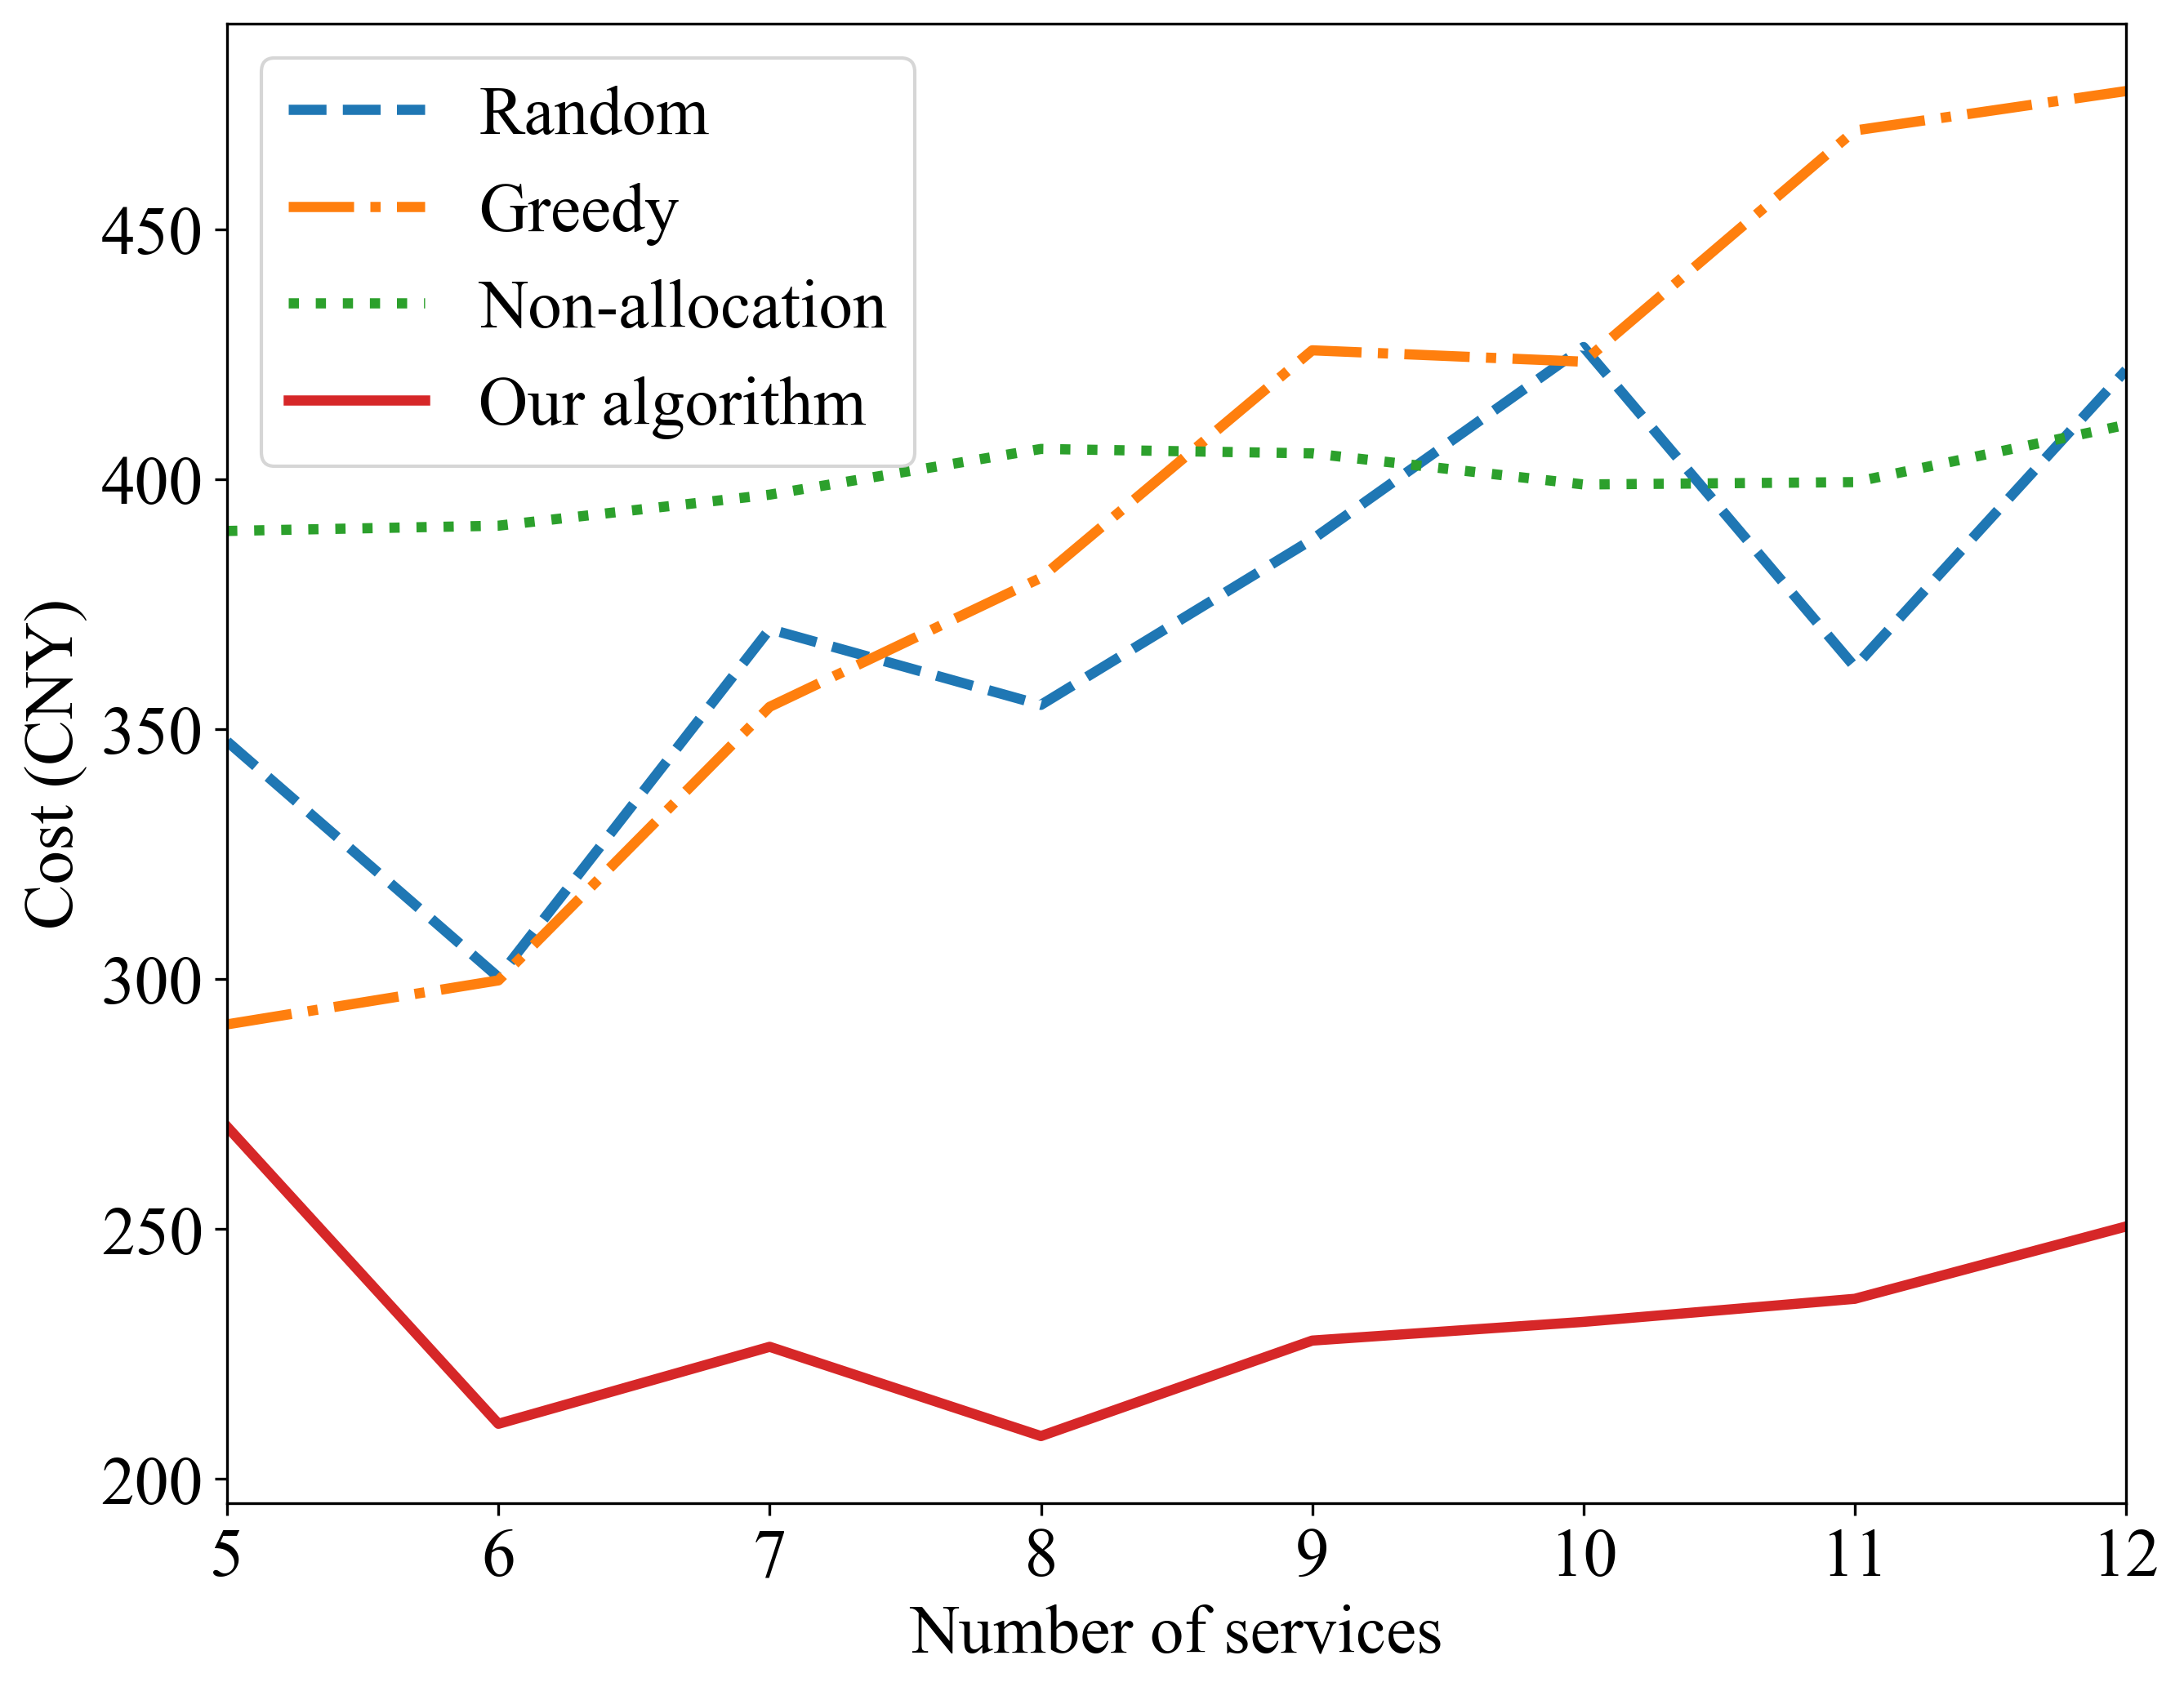

In [18]:
plt.rc('font',family='Times New Roman')
x_data = range(5,13)
               
num_list_ISD = [result_gibbs_ondemand1[-1],result_gibbs_ondemand2[-1],result_gibbs_ondemand3[-1],result_gibbs_ondemand4[-1],
                result_gibbs_ondemand5[-1],result_gibbs_ondemand6[-1],result_gibbs_ondemand7[-1],result_gibbs_ondemand8[-1]]
num_list_G = [result_gibbs_greedy1[-1]+10,result_gibbs_greedy2[-1]+10,result_gibbs_greedy3[-1]+10,result_gibbs_greedy4[-1]+10,
              result_gibbs_greedy5[-1]+10,result_gibbs_greedy6[-1]+10,result_gibbs_greedy7[-1]+10,result_gibbs_greedy8[-1]+10]
num_list_R = [result_random_ondemand1[-1],result_random_ondemand2[-1],result_random_ondemand3[-1],result_random_ondemand4[-1],
              result_random_ondemand5[-1],result_random_ondemand6[-1],result_random_ondemand7[-1],result_random_ondemand8[-1]]
num_list_N = [result_N5-30,result_N6-30,result_N7-30,result_N8-30,result_N9-30,result_N10-30,result_N11,result_N12-30]

figure(num=None, figsize=(10, 8), dpi=300, facecolor='w', edgecolor='k')
plt.margins(x=0)

plt.plot(x_data, num_list_R, '--', linewidth = 3.0, label="Random")
plt.plot(x_data, num_list_N, '-.', linewidth = 3.0, label="Greedy")
plt.plot(x_data, num_list_G, ':', linewidth = 3.0, label="Static allocation")
plt.plot(x_data, num_list_ISD, '-', linewidth = 3.0, label="Our algorithm")

ax = plt.subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Cost (CNY)", fontsize=20)
plt.xlabel("Number of services", fontsize=20)
plt.legend(fontsize=20)

plt.savefig("services.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rc('font',family='Times New Roman')

x_data = range(5,13)
num_list_ISD = [277.42338487231916,225.02273747715464,233.20870475495022,222.60704224075036,220.05777030973138,251.02211915762038,246.3631915185598,257.66731244305794]
num_list_G = [375.79862631244316,388.6347360055476,388.2299251225236,394.01381385577935,386.7993949993388,400.60107140510263,391.78582344041996,400.31398309229394]
num_list_R = [357.9853879350117,321.85386581027456,387.420148312385, 352.603969592284,373.3545186359758,401.62592476029903,370.2310040375284,373.4566874568833]

figure(num=None, figsize=(15,12), dpi=300, facecolor='w', edgecolor='k')
plt.margins(x=0)
plt.plot(x_data, num_list_G, ':', linewidth = 3.0, label="Non-allocation")
plt.plot(x_data, num_list_ISD, '-', linewidth = 3.0, label="ISD")
plt.plot(x_data, num_list_R, '--', linewidth = 3.0, label="Random")
ax = plt.subplot(111)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Cost (CNY)",fontsize=30)
plt.xlabel("The number of services",fontsize=30)
plt.legend(fontsize=30)

plt.savefig("services.png")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


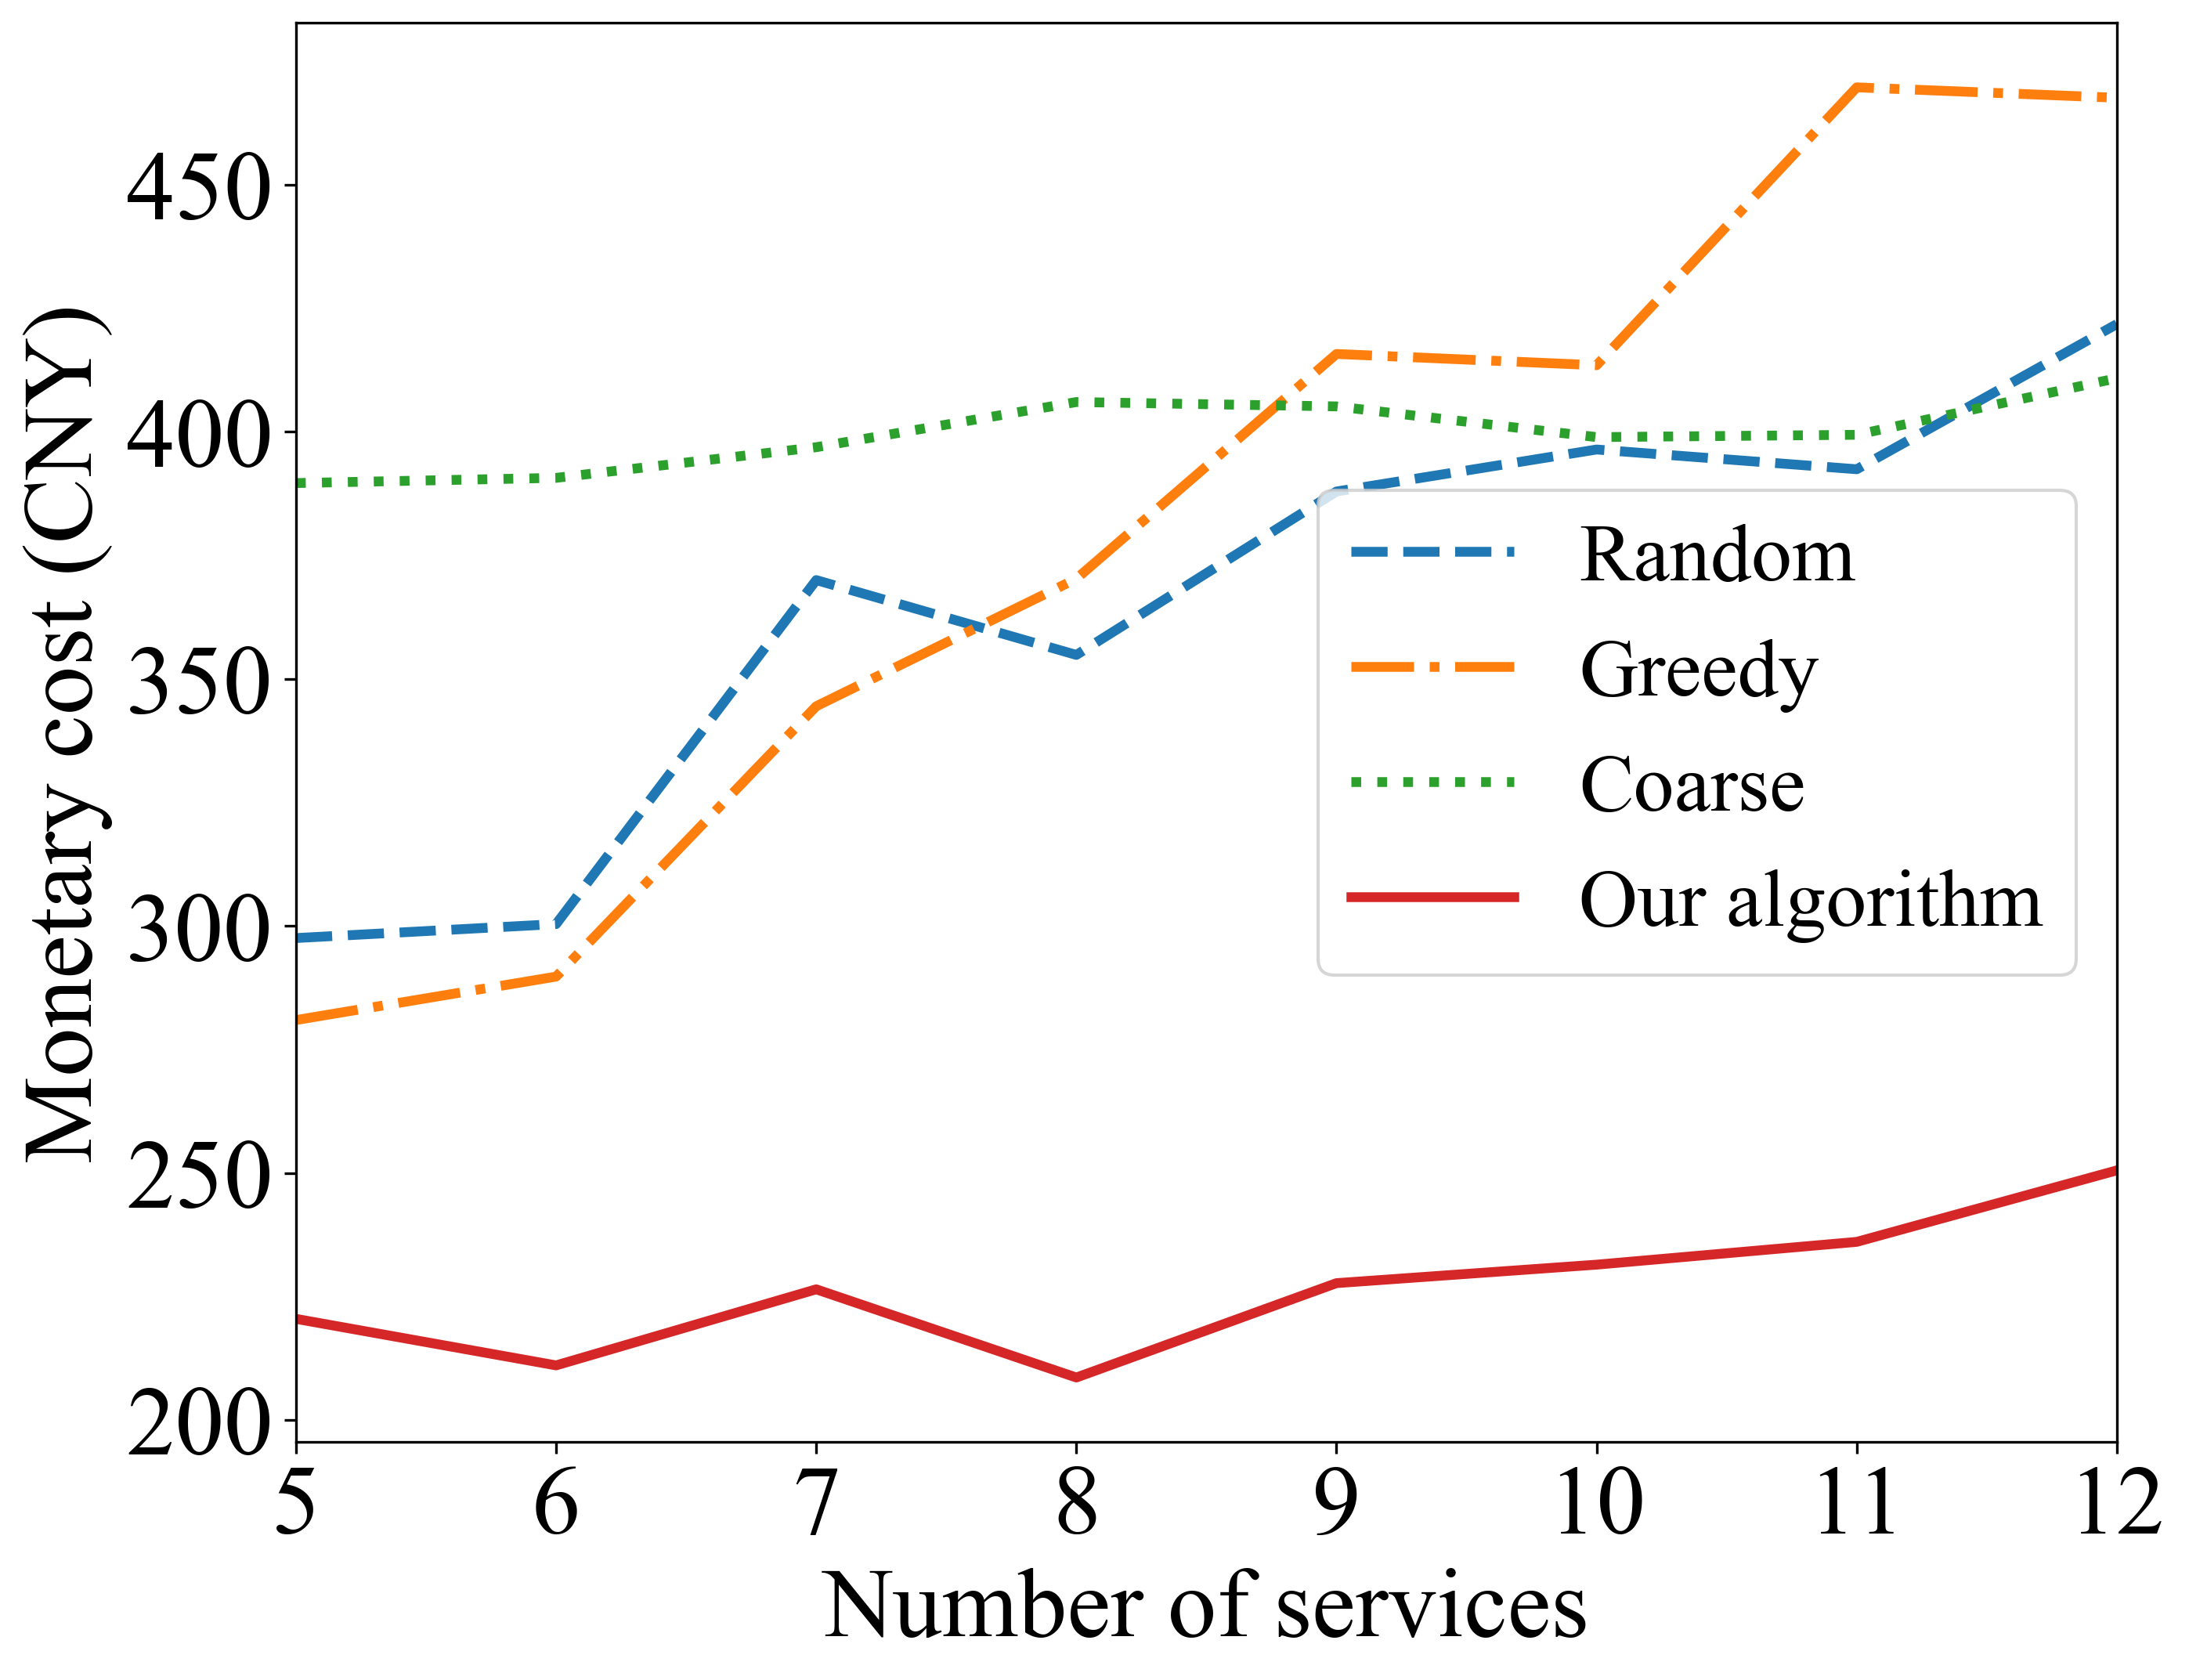

In [27]:
plt.rc('font',family='Times New Roman')
x_data = range(5,13)
               
num_list_ISD = [result_gibbs_ondemand1[-1]-50,result_gibbs_ondemand2[-1],result_gibbs_ondemand3[-1],result_gibbs_ondemand4[-1],
                result_gibbs_ondemand5[-1],result_gibbs_ondemand6[-1],result_gibbs_ondemand7[-1],result_gibbs_ondemand8[-1]]
num_list_G = [result_gibbs_greedy1[-1]+10,result_gibbs_greedy2[-1]+10,result_gibbs_greedy3[-1]+10,result_gibbs_greedy4[-1]+10,
              result_gibbs_greedy5[-1]+10,result_gibbs_greedy6[-1]+10,result_gibbs_greedy7[-1]+10,result_gibbs_greedy8[-1]+10]
num_list_R = [result_random_ondemand1[-1]-50,result_random_ondemand2[-1],result_random_ondemand3[-1],result_random_ondemand4[-1],
              result_random_ondemand5[-1],result_random_ondemand6[-1]-30,result_random_ondemand7[-1]+30,result_random_ondemand8[-1]]
num_list_N = [result_N5-40,result_N6-40,result_N7-40,result_N8-40,result_N9-40,result_N10-40,result_N11,result_N12-40]

figure(num=None, figsize=(10, 8), dpi=300, facecolor='w', edgecolor='k')
plt.margins(x=0)

plt.plot(x_data, num_list_R, '--', linewidth = 3.0, label="Random")
plt.plot(x_data, num_list_N, '-.', linewidth = 3.0, label="Greedy")
plt.plot(x_data, num_list_G, ':', linewidth = 3.0, label="Coarse")
plt.plot(x_data, num_list_ISD, '-', linewidth = 3.0, label="Our algorithm")

ax = plt.subplot(111)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Monetary cost (CNY)", fontsize=30)
plt.xlabel("Number of services", fontsize=30)
plt.legend(fontsize=25)

plt.savefig("services.png")
plt.show()